# Learning Z/nZ x Z/nZ group actions
This notebook is adapted from the `modular arithmetic` notebook, replacing `Z/nZ` group action with `Z/nZ x Z/nZ` group action 

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator

## Architecture

In [2]:
class TwoLayerNet(nn.Module):
    def __init__(self, p, hidden_size, nonlinearity='square', init_scale=1.0, output_scale=1.0):
        super(TwoLayerNet, self).__init__()
        
        # Store dimensions
        self.p = p
        self.hidden_size = hidden_size
        self.nonlinearity = nonlinearity
        self.init_scale = init_scale
        self.output_scale = output_scale
        self.group_size = p * p  # Since input is flattened p x p matrix
        
        # Initialize parameters 
        self.U = nn.Parameter(self.init_scale * torch.randn(hidden_size, self.group_size) / np.sqrt(2 * self.group_size))  # First p elements
        self.V = nn.Parameter(self.init_scale * torch.randn(hidden_size, self.group_size) / np.sqrt(2 * self.group_size))  # Second p elements
        self.W = nn.Parameter(self.init_scale * torch.randn(hidden_size, self.group_size) / np.sqrt(self.group_size)) # Second layer weights

    def forward(self, x):
        # First layer (linear and combined)
        x1 = x[:, :self.group_size] @ self.U.T
        x2 = x[:, self.group_size:] @ self.V.T
        x_combined = x1 + x2

        # Apply nonlinearity activation
        if self.nonlinearity == 'relu':
            x_combined = torch.relu(x_combined)
        elif self.nonlinearity == 'square':
            x_combined = x_combined**2
        elif self.nonlinearity == 'linear':
            x_combined = x_combined
        elif self.nonlinearity == 'tanh':
            x_combined = torch.tanh(x_combined)
        elif self.nonlinearity == 'gelu':
            gelu = torch.nn.GELU()
            x_combined = gelu(x_combined)
        else:
            raise ValueError(f"Invalid nonlinearity '{self.nonlinearity}' provided.")

        # Second layer (linear)
        x_out = x_combined @ self.W

        # Feature learning scaling
        x_out *= self.output_scale

        return x_out

## Optimization

In [3]:
def test_accuracy(model, dataloader):
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.view(inputs.shape[0], -1)  # Flatten input for FC layers
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the largest value (class)
            _, true_labels = torch.max(labels, 1)  # Get the true class from the one-hot encoding
            correct += (predicted == true_labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    return accuracy

def train(model, dataloader, criterion, optimizer, epochs=100, verbose_interval=1):
    model.train()  # Set the model to training mode
    loss_history = []  # List to store loss values
    accuracy_history = []
    param_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            # Check if labels are all zeros or if labels are not being set correctly
            if torch.all(labels == 0):
                print(f"Warning: All labels are zero in batch {batch_idx} of epoch {epoch}")
            if torch.isnan(inputs).any() or torch.isnan(labels).any():
                print(f"NaN detected in inputs or labels in batch {batch_idx} of epoch {epoch}")

            inputs = inputs.view(inputs.shape[0], -1)  # Flatten input for FC layers

            optimizer.zero_grad()  # Zero gradients
            outputs = model(inputs)  # Forward pass

            # Check if outputs are all zeros or constant
            if torch.all(outputs == 0):
                print(f"Warning: Model outputs are all zero in batch {batch_idx} of epoch {epoch}")

            loss = criterion(outputs, labels)  # Compute loss

            # Check if loss is zero from the start
            if epoch == 0 and batch_idx == 0 and loss.item() == 0.0:
                print("Warning: Loss is zero at the very first batch. Check if criterion and labels are set up correctly.")

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()

        # Append the average loss for the epoch to loss_history
        avg_loss = running_loss / len(dataloader)
        loss_history.append(avg_loss)

        # Append the accuracy
        model.eval()
        accuracy = test_accuracy(model, dataloader)
        accuracy_history.append(accuracy)
        model.train()

        # Save current model parameters
        current_params = {
            "U": model.U.detach().cpu().clone(),
            "V": model.V.detach().cpu().clone(),
            "W": model.W.detach().cpu().clone()
        }
        param_history.append(current_params)

        # Print verbose information every `verbose_interval` epochs
        if (epoch + 1) % verbose_interval == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

        # Plot results every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}')
            model.eval()
            with torch.no_grad():
                # Get one random example from the dataset
                idx = np.random.randint(len(dataloader.dataset))
                x, y = dataloader.dataset[idx]
                # If x is not already a tensor, convert it
                if not torch.is_tensor(x):
                    x = torch.tensor(x, dtype=torch.float32)
                if not torch.is_tensor(y):
                    y = torch.tensor(y, dtype=torch.float32)
                # Move to device if needed
                x_input = x.view(1, -1)
                if hasattr(model, 'device'):
                    x_input = x_input.to(model.device)
                elif next(model.parameters()).is_cuda:
                    x_input = x_input.cuda()
                output = model(x_input)
                output_np = output.cpu().numpy().squeeze()
                target_np = y.cpu().numpy().squeeze() if hasattr(y, 'cpu') else y.numpy().squeeze()

                # Try to infer image size if possible
                # Ensure x, output, and target are on CPU and numpy arrays for plotting
                if torch.is_tensor(x):
                    x_np = x.detach().cpu().numpy()
                else:
                    x_np = np.array(x)
                if torch.is_tensor(output):
                    output_np = output.detach().cpu().numpy().squeeze()
                # output_np already defined above, but ensure it's on CPU and numpy
                if torch.is_tensor(y):
                    target_np = y.detach().cpu().numpy().squeeze()
                else:
                    target_np = np.array(y).squeeze()

                # Infer image size
                image_size = int(np.sqrt(x_np.shape[-1] // 2)) if x_np.shape[-1] % 2 == 0 else int(np.sqrt(x_np.shape[-1]))

                fig, axs = plt.subplots(1, 4, figsize=(15, 3), sharey=True)
                axs[0].imshow(x_np[:image_size*image_size].reshape(image_size, image_size))
                axs[0].set_title('Input 1')
                axs[1].imshow(x_np[image_size*image_size:].reshape(image_size, image_size))
                axs[1].set_title('Input 2')
                axs[2].imshow(output_np.reshape(image_size, image_size))
                axs[2].set_title('Output')
                axs[3].imshow(target_np.reshape(image_size, image_size))
                axs[3].set_title('Target')
                plt.tight_layout()
                plt.show()
             

    return loss_history, accuracy_history, param_history # Return loss history for plotting

## Plotting functions

In [4]:
def style_axes(ax, numyticks=5, numxticks=5, labelsize=24):
    # Y-axis ticks
    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=labelsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=numyticks))
    
    # X-axis ticks
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=labelsize)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=numxticks))

    # Scientific notation formatting
    if ax.get_yscale() == 'linear':
        ax.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
    if ax.get_xscale() == 'linear':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(-2, 2))

    ax.xaxis.offsetText.set_fontsize(20)
    ax.grid()

    # Customize spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(3)

In [16]:
def get_power_2d(points, no_freq=False):
    """
    Compute the 2D power spectrum of a real-valued array.

    Note on redundant frequencies:
    rfft2 removes redundant frequencies along first axis automatically
    but does not truncate the second axis
    Therefore, the output shape is (M, N//2 + 1).
    This eliminates redundancy, save for a specific cases:
    --> All frequencies along the first axis at (u, 0) for u = N//2 + 1, ..., N - 1
    are redundant and contain the same information as (u, 0) for u = 1, ..., N//2 - 1.

    Since most of the power coefficients now represnet 2 frequencies (positive and negative),
    we double all the power coefficients to conserve total power.
    However, we do not double the DC component (0, 0) and the Nyquist frequency (N/2, 0) if N is even,
    since these are unique and do not have a negative counterpart.

    Parameters
    ----------
    points : ndarray (M, N)
        Real-valued 2D input array.

    Returns
    -------
    freqs_u : ndarray (M,)
        Frequency bins for the first axis (rows).
    freqs_v : ndarray (N//2 + 1,)
        Frequency bins for the second axis (columns).
    power : ndarray (M, N//2 + 1)
        Power spectrum of the input.
    """
    M, N = points.shape
    num_coefficients = N // 2 + 1
    
    # Perform 2D rFFT
    ft = np.fft.rfft2(points)
    
    # Power spectrum normalized by total number of samples
    power = np.abs(ft)**2 / (M * N)

    # For the first row (u=0), remove redundant frequencies and double the appropriate ones
    power[(N//2 + 1):, 0] = 0 

    # Since (almost) all frequencies contribute twice (positive and negative), double the power
    power *= 2
    # Except the DC component
    power[0, 0] /= 2
    # Except the Nyquist frequency if N is even
    if N % 2 == 0:
        power[N//2, 0] /= 2

    # Check Parseval’s theorem
    total_power = np.sum(power)
    norm_squared = np.linalg.norm(points)**2
    if not np.isclose(total_power, norm_squared, rtol=1e-3):
        print(f"Warning: Total power {total_power:.3f} does not match norm squared {norm_squared:.3f}")


    if no_freq:
        return power

    # Frequency bins
    freqs_u = np.fft.fftfreq(M)          # full symmetric frequencies (rows)
    freqs_v = np.fft.rfftfreq(N)         # only non-negative frequencies (columns)

    return freqs_u, freqs_v, power


def get_alpha_values(template):
    p = int(np.sqrt(len(template)))
    x_freq, y_freq, power = get_power_2d(template.reshape((p, p)))
    print(power)
    power = power.flatten()

    valid = power > 1e-20
    power = power[valid]
    sorted_idx = np.argsort(power)[::-1]  # np.argsort with [::-1] gives descending order
    power = power[sorted_idx]

    # Plot theoretical lines
    alpha_values = [np.sum(power[k:]) for k in range(len(power))]
    coef = 1 / (p * p)
    alpha_values = [alpha * coef for alpha in alpha_values]

    return alpha_values


def plot2D(ax, points, color, continuous, alpha=1.0):
    # Adapted: points is a flattened square matrix. Un-flatten and plot as 2D signal.
    n = int(np.sqrt(len(points)))
    if n * n != len(points):
        raise ValueError("Length of points is not a perfect square, cannot reshape to square matrix.")
    mat = np.array(points).reshape((n, n))
    im = ax.imshow(mat, cmap='viridis', interpolation='nearest', alpha=alpha)
    # Optionally add a colorbar if desired:
    # plt.colorbar(im, ax=ax)

## Template and Dataset Functions

In [6]:
def one_hot2D(p):
    """One-hot encode an integer value in R^pxp.
    
    Parameters
    ----------
    p : int
        p in Z/pZ x Z/pZ. Number of elements in the 2D modular addition
    
    Returns
    -------
    mat : np.ndarray
        A flattened one-hot encoded matrix of shape (p*p).
    """
    mat = np.zeros((p,p))
    mat[0,0] = 1
    mat = mat.flatten()
    return mat

def generate_fixed_template(p):
    """Generate a fixed template for the 2D modular addition dataset.

    Note: Since our input is a flattened matrix, we should un-flatten
    the weights vectors to match the shape of the template when we visualize.
    
    Parameters
    ----------
    p : int
        p in Z/pZ x Z/pZ. Number of elements per dimension in the 2D modular addition

    Returns
    -------
    template : np.ndarray
        A flattened 2D array of shape (p, p) representing the template.
        After flattening, it will have shape (p*p,).
    """
    # Generate template array from Fourier spectrum
    spectrum = np.zeros((p,p), dtype=complex)

    # Three low-frequency bins with Gaussian-ish weights
    v1 = 2.0
    v2 = 1.0 #0.1 # make sure this is not too close to v1
    v3 = 0.7 #0.01

    plot_set_template_components(v1, v2, v3, p)

    # Mode (1,0)
    spectrum[1,0] = v1
    spectrum[-1,0] = np.conj(v1) 

    # Mode (2,1)
    spectrum[0,1] = v2
    spectrum[0,-1] = np.conj(v2)

    # Mode (1,1)
    spectrum[1,1] = v3
    spectrum[-1,-1] = np.conj(v3)
    
    # Generate signal from spectrum
    template = np.fft.ifft2(spectrum).real

    template = template.flatten()

    return template


def mnist_template(p):
    """Generate a template from the MNIST dataset, resized to p x p.

    Parameters
    ----------
    p : int
        p in Z/pZ x Z/pZ. Number of elements per dimension in the 2D modular addition
    Returns
    -------
    template : np.ndarray
        A flattened 2D array of shape (p, p) representing the template.
    """
    from sklearn.datasets import fetch_openml
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.utils import shuffle
    from skimage.transform import resize

    # Load MNIST dataset
    mnist = fetch_openml('mnist_784', version=1)
    X = mnist.data.values
    y = mnist.target.astype(int).values

    # Filter for digit '0'
    X_zero = X[y == 0]

    # Shuffle and take one sample
    X_zero = shuffle(X_zero, random_state=42)
    sample = X_zero[0].reshape(28, 28)

    # Resize to p x p
    sample_resized = resize(sample, (p, p), anti_aliasing=True)

    # Normalize to [0, 1]
    sample_resized = (sample_resized - np.min(sample_resized)) / (np.max(sample_resized) - np.min(sample_resized))

    plot_top_template_components(sample_resized, p)

    template = sample_resized.flatten()

    return template


def plot_top_template_components(template_2d, p):
    """Plot the top 5 Fourier components of the template.

    Parameters
    ----------
    template : np.ndarray
        A flattened 2D array of shape (p, p) representing the template.
    p : int
        p in Z/pZ x Z/pZ. Number of elements per dimension in the 2D modular addition
    """
    freqs_u, freqs_v, power = get_power_2d(template_2d)

    # Flatten the power array and get the indices of the top 5 components
    power_flat = power.flatten()
    top_indices = np.argsort(power_flat)[-5:][::-1]  # Indices of top 5 components

    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    
    # Initialize cumulative spectrum
    cumulative_spectrum = np.zeros_like(power, dtype=complex)
    
    for i, idx in enumerate(top_indices):
        u = idx // power.shape[1]
        v = idx % power.shape[1]
        
        # Add current component to cumulative spectrum
        cumulative_spectrum[u, v] = np.sqrt(power[u, v] * p * p)  # Scale back to amplitude
        if v != 0 and v != power.shape[1] - 1:
            cumulative_spectrum[u, -v] = np.conj(cumulative_spectrum[u, v])  # Add negative frequency component if not DC or Nyquist
        
        # Convert cumulative spectrum to spatial domain
        spatial_component = np.fft.ifft2(cumulative_spectrum).real
        
        # Create title showing which components are included
        components_list = []
        for j in range(i + 1):
            comp_idx = top_indices[j]
            comp_u = comp_idx // power.shape[1]
            comp_v = comp_idx % power.shape[1]
            components_list.append(f"({comp_u},{comp_v})")
        
        title = f"Components: {', '.join(components_list)}\nNew: ({u},{v}) Power: {power[u,v]:.4f}"
        
        # Roll the spatial component by half the image length in both x and y directions
        spatial_component_rolled = np.roll(spatial_component, spatial_component.shape[0]//2, axis=0)
        spatial_component_rolled = np.roll(spatial_component_rolled, spatial_component.shape[1]//2, axis=1)
        
        im = axs[i].imshow(spatial_component_rolled, cmap='viridis')
        axs[i].set_title(title)
        plt.colorbar(im, ax=axs[i])
    plt.tight_layout()
    plt.show()


def plot_set_template_components(v1, v2, v3, p):
    spectrum = np.zeros((p,p), dtype=complex)

    # Mode (1,0)
    spectrum[1,0] = v1
    spectrum[-1,0] = np.conj(v1) 

    template_1 = np.fft.ifft2(spectrum).real

    # Mode (0,1)
    spectrum[0,1] = v2
    spectrum[0,-1] = np.conj(v2)

    template_2 = np.fft.ifft2(spectrum).real

    # Mode (1,1)
    spectrum[1,1] = v3
    spectrum[-1,-1] = np.conj(v3)
    
    # Generate signal from spectrum
    template_full = np.fft.ifft2(spectrum).real

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    im1 = axs[0].imshow(template_1, cmap='viridis')
    axs[0].set_title("Mode (1,0)")
    plt.colorbar(im1, ax=axs[0])
    im2 = axs[1].imshow(template_2, cmap='viridis')
    axs[1].set_title("Mode (1,0)+(0,1)")
    plt.colorbar(im2, ax=axs[1])
    im3 = axs[2].imshow(template_full, cmap='viridis')
    axs[2].set_title("Full Template")
    plt.colorbar(im3, ax=axs[2])
    plt.tight_layout()

    plt.show()

def ModularAdditionDataset2D(p, template, fraction=0.3, random_state=42):
    """Generate a dataset for the 2D modular addition operation.

    General idea: We are generating a dataset where each sample consists of 
    two inputs (a*template and b*template) and an output (a*b)*template,
    where a, b \in Z/pZ x Z/pZ. The template is a flattened 2D array
    representing the modular addition operation in a 2D space.

    Each element X_i will contain the template with a different a_i, b_i, and
    in fact X contains the template at all possible a, b shifts.
    The output Y_i will contain the template shifted by a_i*b_i.
    * refers to the composition of two group actions (but by an abuse of notation, 
    also refers to group action on the template. oops.)
    
    Parameters
    ----------
    p : int
        p in Z/pZ x Z/pZ. Number of elements per dimension in the 2D modular addition.
    template : np.ndarray
        A flattened 2D array of shape (p*p,) representing the template.
        This should be generated using `generate_fixed_template(p)`.
        
    Returns
    -------
    X : np.ndarray
        Input data of shape (p^4, 2, p*p). 
        2 inputs (a and b), each with shape (p*p,).
         is the total number of combinations of shifted a's and b's.
    Y : np.ndarray
        Output data of shape (p^4, p*p), where each sample is the result of the modular addition."""
    # Initialize data arrays
    X = np.zeros((p ** 4, 2, p * p))  # Shape: (p^4, 2, p*p)
    Y = np.zeros((p ** 4, p * p))     # Shape: (p^4, p*p)
    translations = np.zeros((p**4, 3, 2), dtype=int)
    
    # Generate the dataset
    idx = 0
    template_2d = template.reshape((p, p))
    for a_x in range(p):
        for a_y in range(p):
            for b_x in range(p):
                for b_y in range(p):
                    q_x = (a_x + b_x) % p
                    q_y = (a_y + b_y) % p
                    X[idx, 0, :] = np.roll(np.roll(template_2d, a_x, axis=0), a_y, axis=1).flatten()
                    X[idx, 1, :] = np.roll(np.roll(template_2d, b_x, axis=0), b_y, axis=1).flatten()
                    Y[idx, :] = np.roll(np.roll(template_2d, q_x, axis=0), q_y, axis=1).flatten()
                    translations[idx, 0, :] = (a_x, a_y)
                    translations[idx, 1, :] = (b_x, b_y)
                    translations[idx, 2, :] = (q_x, q_y)
                    idx += 1

    assert 0 < fraction <= 1.0, "fraction must be in (0, 1]"
    N = X.shape[0]
    n_sample = int(np.ceil(N * fraction))
    rng = np.random.default_rng(random_state)
    indices = rng.choice(N, size=n_sample, replace=False)

    return X[indices], Y[indices], translations[indices]
            

<>:205: SyntaxWarning: invalid escape sequence '\i'
<>:205: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_1169237/3251451214.py:205: SyntaxWarning: invalid escape sequence '\i'
  where a, b \in Z/pZ x Z/pZ. The template is a flattened 2D array


# Define Dataset and Visualize

In [7]:
def plot_template(template, template_minus_mean, indices, p, i=4):
    template_matrix = template.reshape((p, p))
    template_minus_mean_matrix = template_minus_mean.reshape((p, p))
    translation = indices[i]
    print(f"Translation for sample {i}: a=({translation[0][0]}, {translation[0][1]}), b=({translation[1][0]}, {translation[1][1]}), a+b=({translation[2][0]}, {translation[2][1]})")

    Xi_a = X[i, 0].reshape((p, p))
    Xi_b = X[i, 1].reshape((p, p))
    Yi = Y[i].reshape((p, p))

    # Plot the original template and the matrices
    fig, axs = plt.subplots(1, 5, figsize=(16, 4))

    # Plot the original template
    im_template = axs[0].imshow(template_matrix, cmap='viridis')
    axs[0].set_title("Original Template")
    plt.colorbar(im_template, ax=axs[0])

    im_template_minus_mean = axs[1].imshow(template_minus_mean_matrix, cmap='viridis')
    axs[1].set_title("Template Minus Mean")
    plt.colorbar(im_template_minus_mean, ax=axs[1])

    # Extract translation values for titles
    a_x, a_y = translation[0]
    b_x, b_y = translation[1]
    q_x, q_y = translation[2]

    # Plot X[i][0] (a*template)
    im0 = axs[2].imshow(Xi_a, cmap='viridis')
    axs[2].set_title(f"X_a: Δx {a_x} Δy {a_y}")
    axs[2].set_xlabel("y")
    axs[2].set_ylabel("x")
    plt.colorbar(im0, ax=axs[2])

    # Plot X[i][1] (b*template)
    im1 = axs[3].imshow(Xi_b, cmap='viridis')
    axs[3].set_title(f"X_b: Δx {b_x} Δy {b_y}")
    axs[3].set_xlabel("y")
    axs[3].set_ylabel("x")
    plt.colorbar(im1, ax=axs[3])

    # Plot Y[i] ((a+b)*template)
    im2 = axs[4].imshow(Yi, cmap='viridis')
    axs[4].set_title(f"Y: Δx {q_x} Δy {q_y}")
    axs[4].set_xlabel("y")
    axs[4].set_ylabel("x")
    plt.colorbar(im2, ax=axs[4])

    plt.tight_layout()
    plt.show()


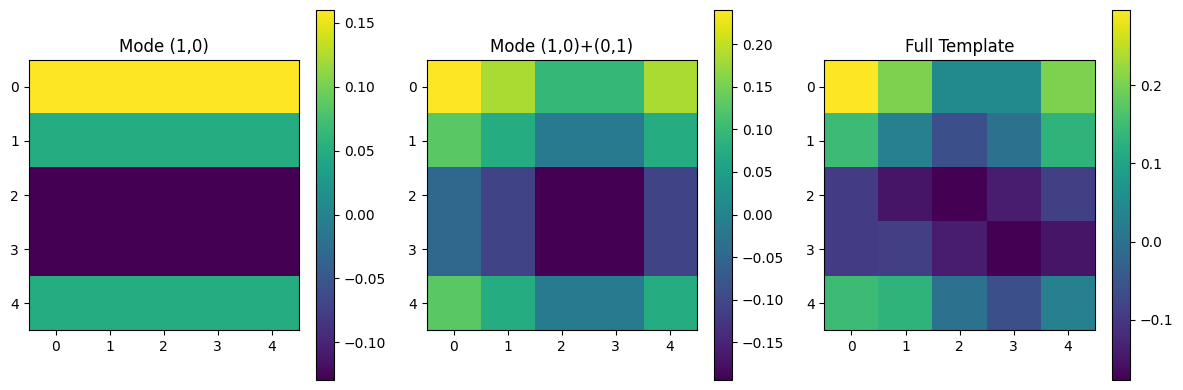

Template mean: -3.469446951953614e-18
Translation for sample 4: a=(1, 3), b=(4, 1), a+b=(0, 4)


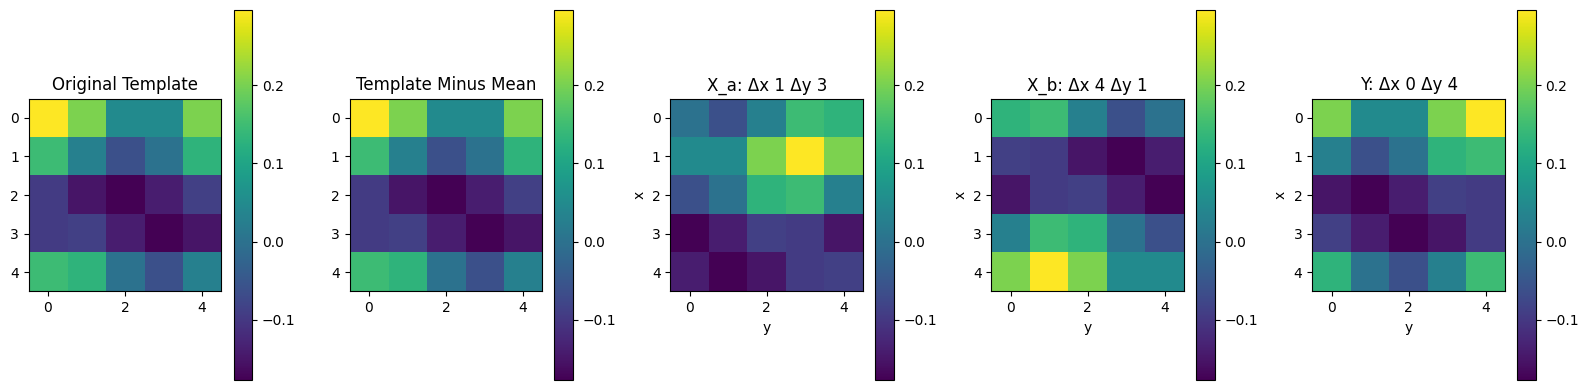

X_tensor shape: torch.Size([625, 50]), Y_tensor shape: torch.Size([625, 25])
GPU is available. Using CUDA.


In [8]:
# Data Generation using the new function
p = 5  # Modulus

# Choose template
# template = generate_template(p, 2, 1.0)
# template = one_hot2D(p)
# og_template = mnist_template(p)
og_template = generate_fixed_template(p)

print("Template mean:", np.mean(og_template))

# Mean center template
template = og_template - np.mean(og_template) # subtract the zeroth frequency

# Generate dataset using numpy
X, Y, indices = ModularAdditionDataset2D(p, template, fraction=1.0)
plot_template(og_template, template, indices, p, i=4)

# Convert to PyTorch tensors
X_len = X.shape[-1]
X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 2 * X_len)  # Flatten input (num_samples, 2*p)
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # Targets (num_samples, p)
print(f"X_tensor shape: {X_tensor.shape}, Y_tensor shape: {Y_tensor.shape}")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using CUDA.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

# Move tensors and model to the correct device if not already
X_tensor = X_tensor.to(device)
Y_tensor = Y_tensor.to(device)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

## Gradient Descent Experiment

X_tensor device: cuda:0
Y_tensor device: cuda:0
Model device: cuda:0
Epoch 10/50000, Loss: 0.0176, Accuracy: 19.84%
Epoch 20/50000, Loss: 0.0173, Accuracy: 20.48%
Epoch 30/50000, Loss: 0.0164, Accuracy: 21.76%
Epoch 40/50000, Loss: 0.0137, Accuracy: 20.64%
Epoch 50/50000, Loss: 0.0091, Accuracy: 19.84%
Epoch 60/50000, Loss: 0.0053, Accuracy: 20.64%
Epoch 70/50000, Loss: 0.0051, Accuracy: 20.48%
Epoch 80/50000, Loss: 0.0048, Accuracy: 20.00%
Epoch 90/50000, Loss: 0.0048, Accuracy: 19.68%
Epoch 100/50000, Loss: 0.0048, Accuracy: 20.00%
Epoch 100/50000, Loss: 0.004781


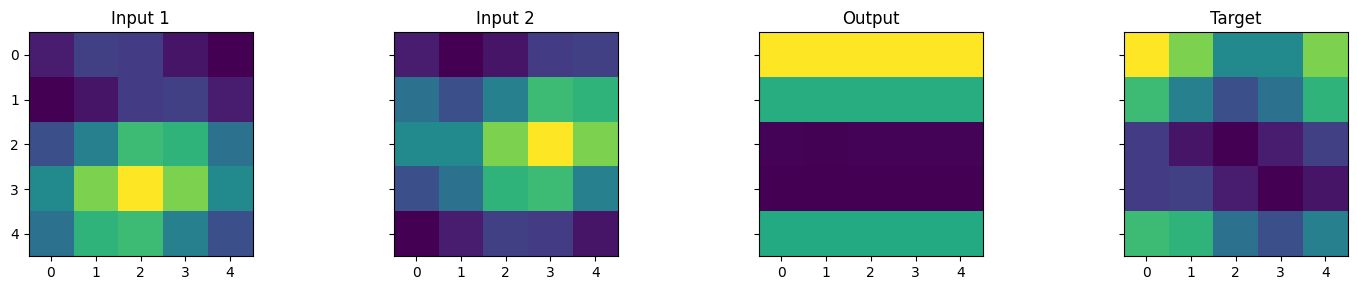

Epoch 110/50000, Loss: 0.0048, Accuracy: 18.72%
Epoch 120/50000, Loss: 0.0048, Accuracy: 18.72%
Epoch 130/50000, Loss: 0.0048, Accuracy: 20.16%
Epoch 140/50000, Loss: 0.0048, Accuracy: 20.96%
Epoch 150/50000, Loss: 0.0048, Accuracy: 22.24%
Epoch 160/50000, Loss: 0.0048, Accuracy: 22.56%
Epoch 170/50000, Loss: 0.0048, Accuracy: 22.72%
Epoch 180/50000, Loss: 0.0048, Accuracy: 23.68%
Epoch 190/50000, Loss: 0.0048, Accuracy: 23.36%
Epoch 200/50000, Loss: 0.0048, Accuracy: 25.76%
Epoch 200/50000, Loss: 0.004750


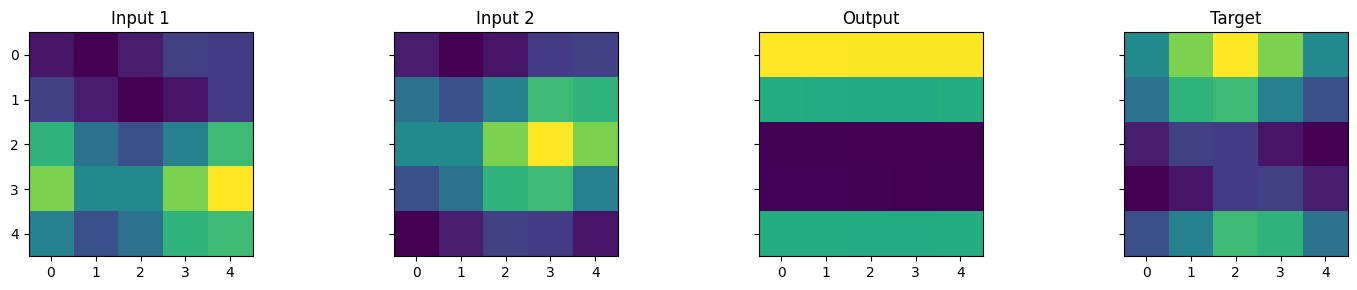

Epoch 210/50000, Loss: 0.0047, Accuracy: 27.68%
Epoch 220/50000, Loss: 0.0047, Accuracy: 30.40%
Epoch 230/50000, Loss: 0.0047, Accuracy: 32.80%
Epoch 240/50000, Loss: 0.0046, Accuracy: 33.44%
Epoch 250/50000, Loss: 0.0045, Accuracy: 36.32%
Epoch 260/50000, Loss: 0.0043, Accuracy: 37.12%
Epoch 270/50000, Loss: 0.0042, Accuracy: 39.84%
Epoch 280/50000, Loss: 0.0041, Accuracy: 40.32%
Epoch 290/50000, Loss: 0.0040, Accuracy: 42.40%
Epoch 300/50000, Loss: 0.0038, Accuracy: 45.44%
Epoch 300/50000, Loss: 0.003804


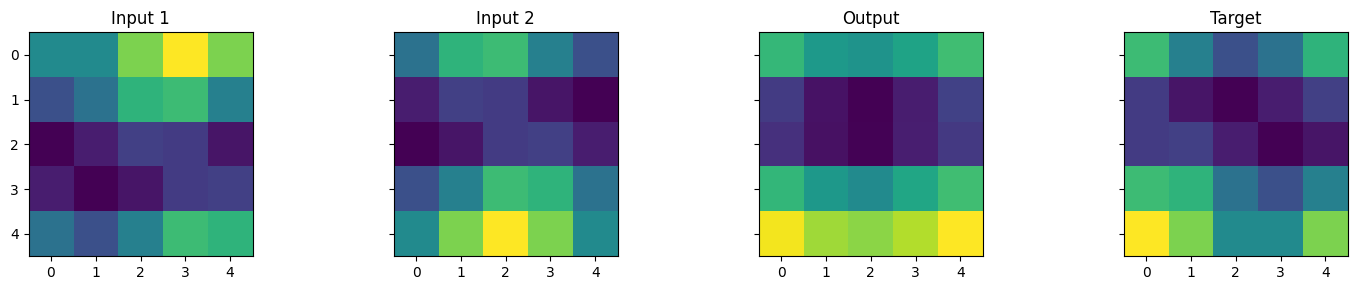

Epoch 310/50000, Loss: 0.0036, Accuracy: 50.24%
Epoch 320/50000, Loss: 0.0034, Accuracy: 58.56%
Epoch 330/50000, Loss: 0.0033, Accuracy: 60.48%
Epoch 340/50000, Loss: 0.0032, Accuracy: 60.00%
Epoch 350/50000, Loss: 0.0032, Accuracy: 58.56%
Epoch 360/50000, Loss: 0.0032, Accuracy: 56.96%
Epoch 370/50000, Loss: 0.0032, Accuracy: 55.68%
Epoch 380/50000, Loss: 0.0032, Accuracy: 54.24%
Epoch 390/50000, Loss: 0.0031, Accuracy: 55.20%
Epoch 400/50000, Loss: 0.0031, Accuracy: 56.32%
Epoch 400/50000, Loss: 0.003147


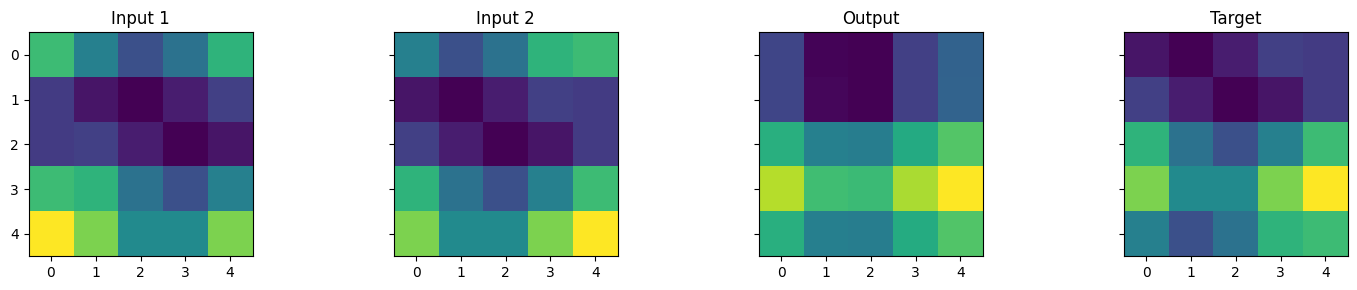

Epoch 410/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 420/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 430/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 440/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 450/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 460/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 470/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 480/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 490/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 500/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 500/50000, Loss: 0.003145


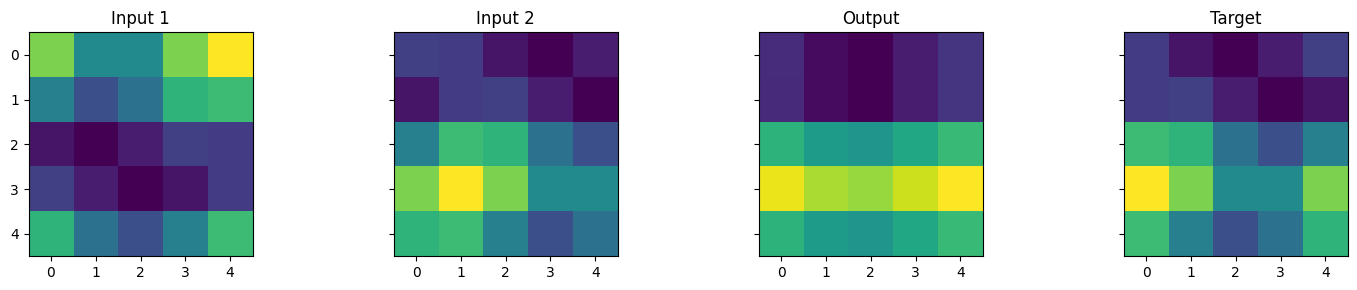

Epoch 510/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 520/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 530/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 540/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 550/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 560/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 570/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 580/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 590/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 600/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 600/50000, Loss: 0.003145


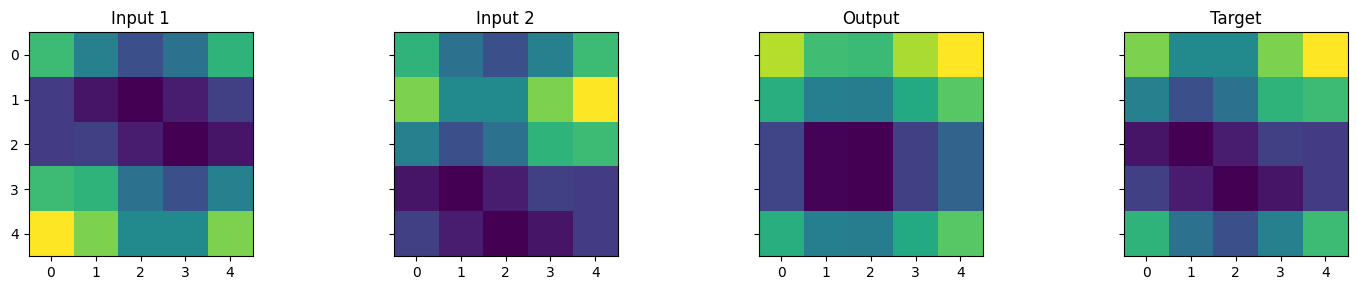

Epoch 610/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 620/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 630/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 640/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 650/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 660/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 670/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 680/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 690/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 700/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 700/50000, Loss: 0.003145


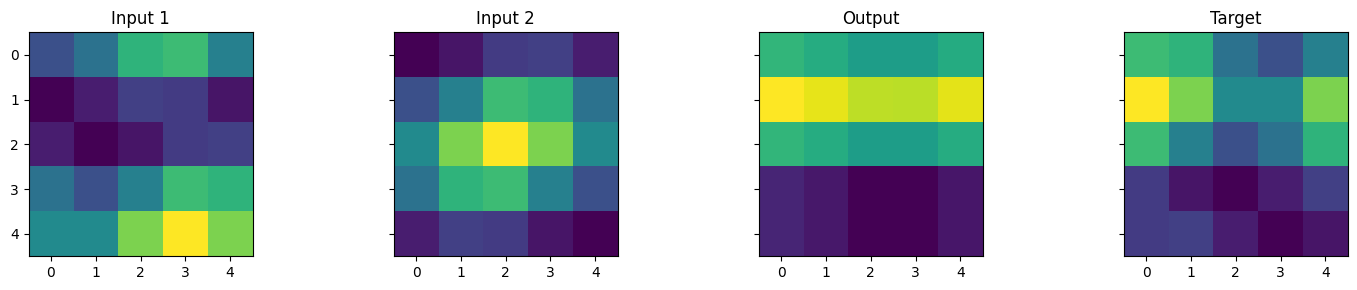

Epoch 710/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 720/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 730/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 740/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 750/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 760/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 770/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 780/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 790/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 800/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 800/50000, Loss: 0.003145


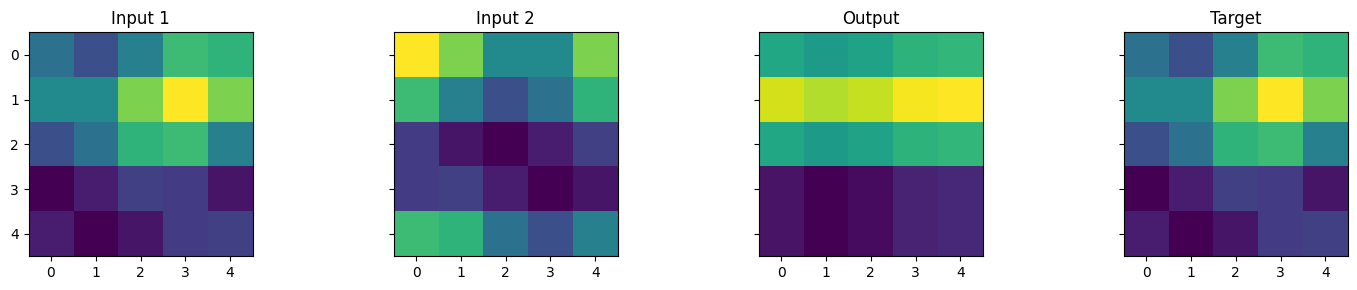

Epoch 810/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 820/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 830/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 840/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 850/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 860/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 870/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 880/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 890/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 900/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 900/50000, Loss: 0.003143


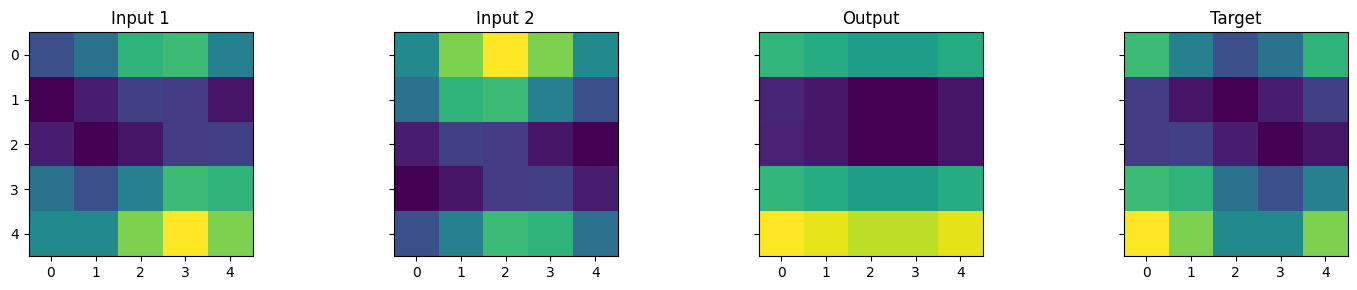

Epoch 910/50000, Loss: 0.0031, Accuracy: 56.00%
Epoch 920/50000, Loss: 0.0031, Accuracy: 55.84%
Epoch 930/50000, Loss: 0.0031, Accuracy: 56.48%
Epoch 940/50000, Loss: 0.0031, Accuracy: 56.64%
Epoch 950/50000, Loss: 0.0031, Accuracy: 56.96%
Epoch 960/50000, Loss: 0.0031, Accuracy: 58.88%
Epoch 970/50000, Loss: 0.0030, Accuracy: 59.36%
Epoch 980/50000, Loss: 0.0029, Accuracy: 61.92%
Epoch 990/50000, Loss: 0.0028, Accuracy: 69.60%
Epoch 1000/50000, Loss: 0.0026, Accuracy: 80.16%
Epoch 1000/50000, Loss: 0.002595


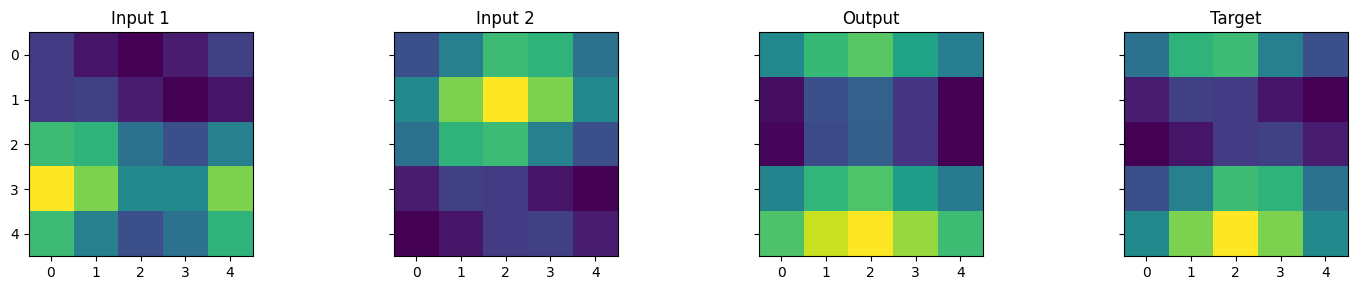

Epoch 1010/50000, Loss: 0.0024, Accuracy: 84.00%
Epoch 1020/50000, Loss: 0.0023, Accuracy: 90.40%
Epoch 1030/50000, Loss: 0.0021, Accuracy: 96.00%
Epoch 1040/50000, Loss: 0.0020, Accuracy: 100.00%
Epoch 1050/50000, Loss: 0.0019, Accuracy: 100.00%
Epoch 1060/50000, Loss: 0.0018, Accuracy: 100.00%
Epoch 1070/50000, Loss: 0.0017, Accuracy: 100.00%
Epoch 1080/50000, Loss: 0.0017, Accuracy: 100.00%
Epoch 1090/50000, Loss: 0.0017, Accuracy: 100.00%
Epoch 1100/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1100/50000, Loss: 0.001635


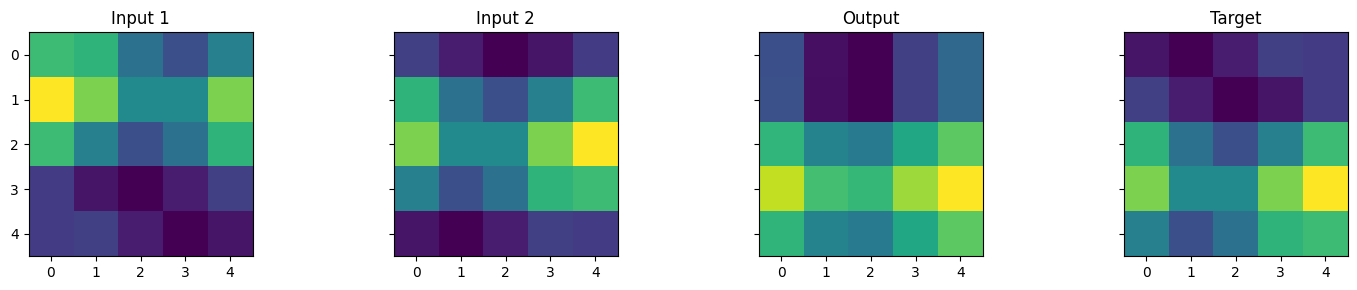

Epoch 1110/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1120/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1130/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1140/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1150/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1160/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1170/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1180/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1190/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1200/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1200/50000, Loss: 0.001575


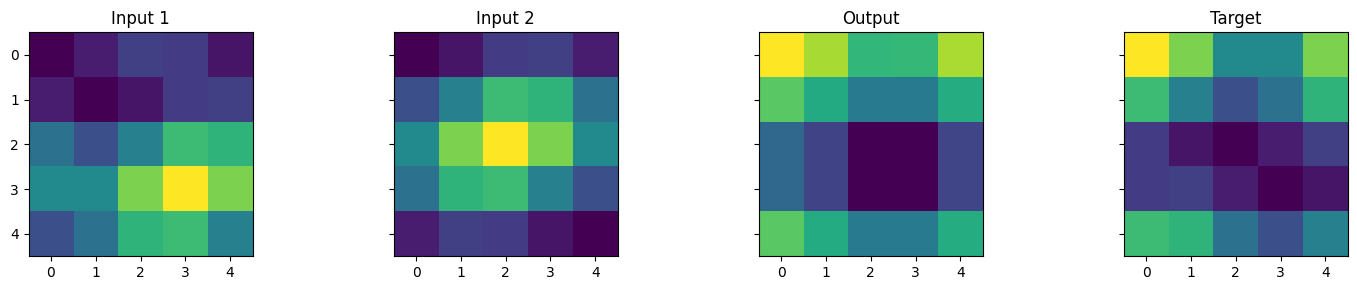

Epoch 1210/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1220/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1230/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1240/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1250/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1260/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1270/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1280/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1290/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1300/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1300/50000, Loss: 0.001569


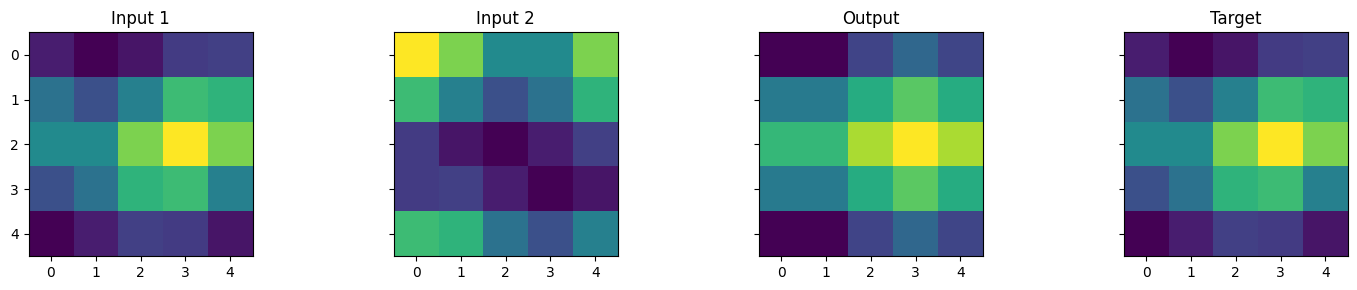

Epoch 1310/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1320/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1330/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1340/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1350/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1360/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1370/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1380/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1390/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1400/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1400/50000, Loss: 0.001568


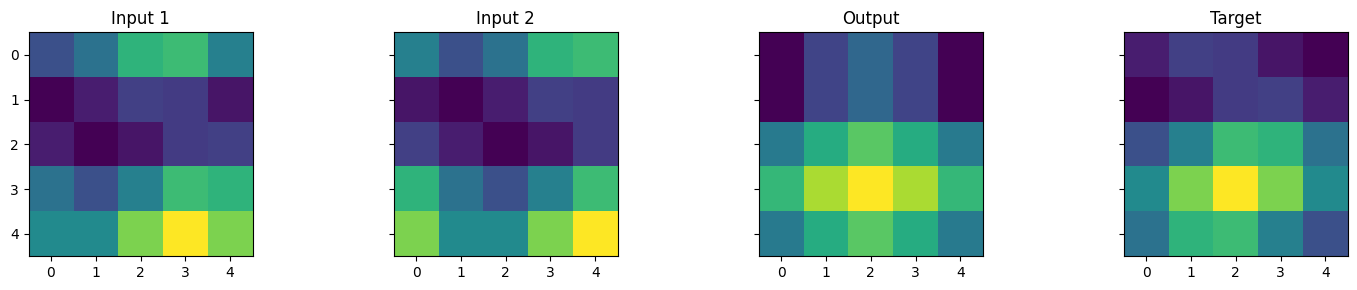

Epoch 1410/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1420/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1430/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1440/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1450/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1460/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1470/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1480/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1490/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1500/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1500/50000, Loss: 0.001568


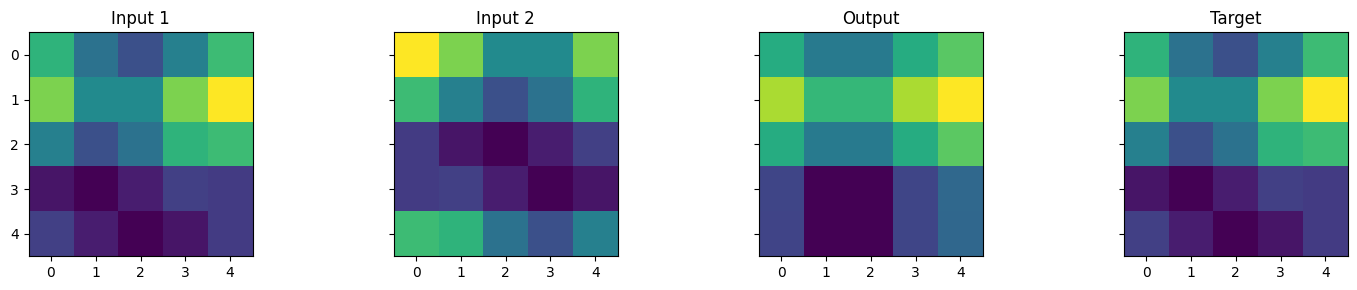

Epoch 1510/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1520/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1530/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1540/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1550/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1560/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1570/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1580/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1590/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1600/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1600/50000, Loss: 0.001568


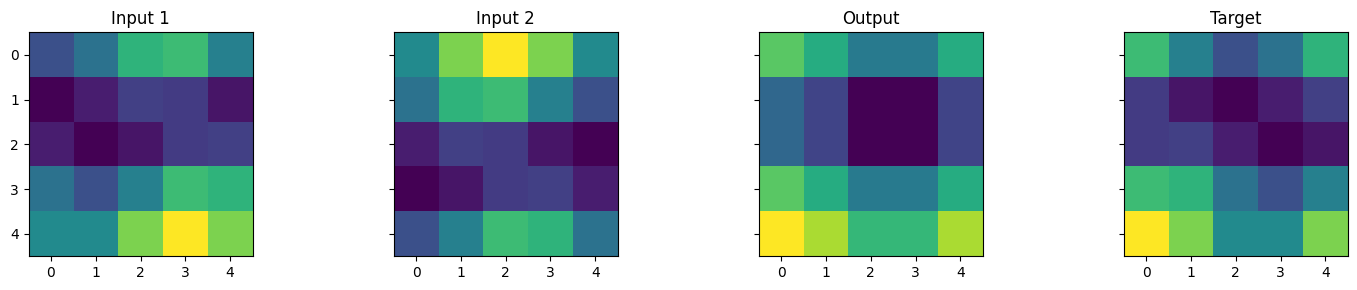

Epoch 1610/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1620/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1630/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1640/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1650/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1660/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1670/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1680/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1690/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1700/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1700/50000, Loss: 0.001568


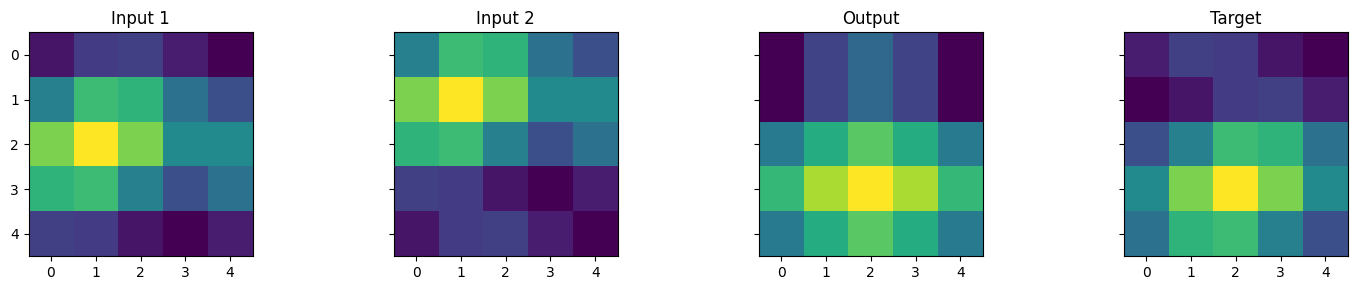

Epoch 1710/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1720/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1730/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1740/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1750/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1760/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1770/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1780/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1790/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1800/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1800/50000, Loss: 0.001568


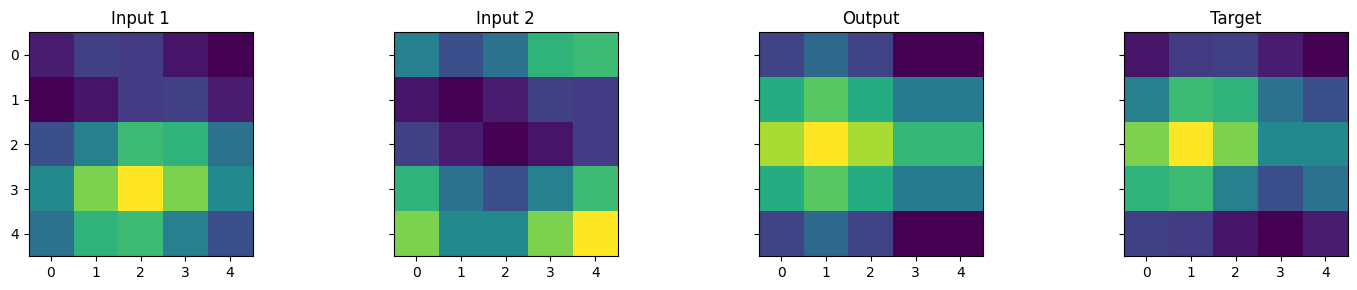

Epoch 1810/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1820/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1830/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1840/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1850/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1860/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1870/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1880/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1890/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1900/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1900/50000, Loss: 0.001568


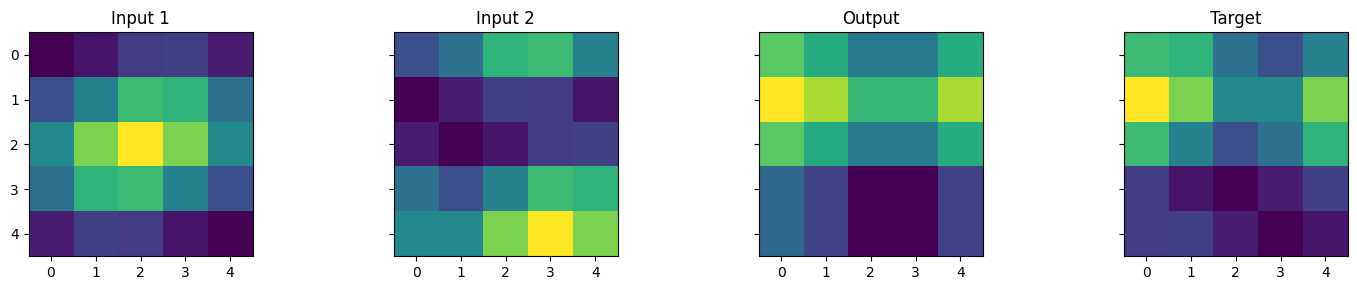

Epoch 1910/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1920/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1930/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1940/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1950/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1960/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1970/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1980/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 1990/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 2000/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 2000/50000, Loss: 0.001567


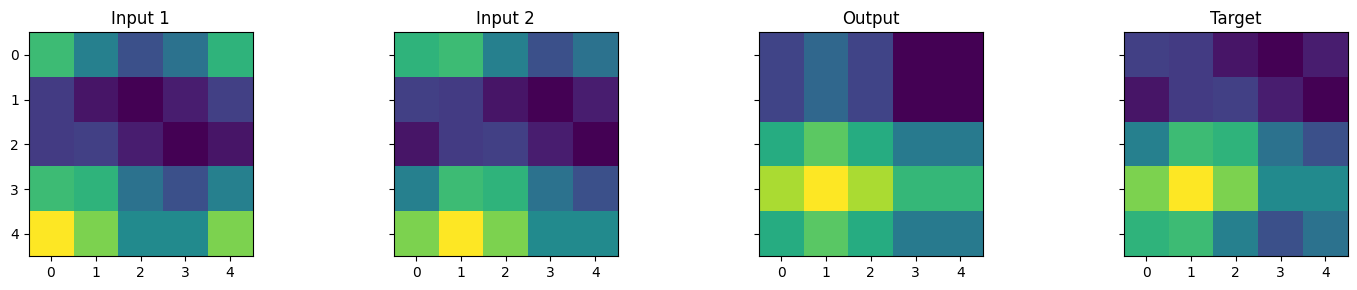

Epoch 2010/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 2020/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 2030/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 2040/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 2050/50000, Loss: 0.0016, Accuracy: 100.00%
Epoch 2060/50000, Loss: 0.0015, Accuracy: 100.00%
Epoch 2070/50000, Loss: 0.0015, Accuracy: 100.00%
Epoch 2080/50000, Loss: 0.0014, Accuracy: 100.00%
Epoch 2090/50000, Loss: 0.0013, Accuracy: 100.00%
Epoch 2100/50000, Loss: 0.0012, Accuracy: 100.00%
Epoch 2100/50000, Loss: 0.001247


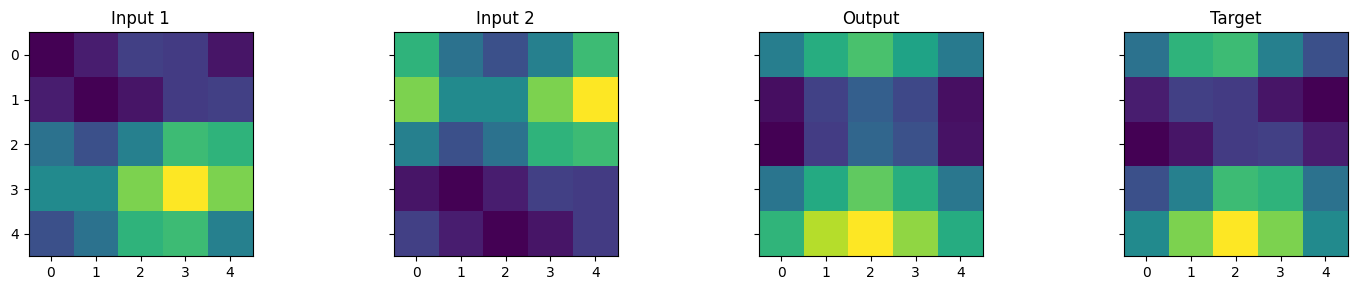

Epoch 2110/50000, Loss: 0.0012, Accuracy: 100.00%
Epoch 2120/50000, Loss: 0.0011, Accuracy: 100.00%
Epoch 2130/50000, Loss: 0.0010, Accuracy: 100.00%
Epoch 2140/50000, Loss: 0.0009, Accuracy: 100.00%
Epoch 2150/50000, Loss: 0.0008, Accuracy: 100.00%
Epoch 2160/50000, Loss: 0.0008, Accuracy: 100.00%
Epoch 2170/50000, Loss: 0.0007, Accuracy: 100.00%
Epoch 2180/50000, Loss: 0.0007, Accuracy: 100.00%
Epoch 2190/50000, Loss: 0.0006, Accuracy: 100.00%
Epoch 2200/50000, Loss: 0.0005, Accuracy: 100.00%
Epoch 2200/50000, Loss: 0.000456


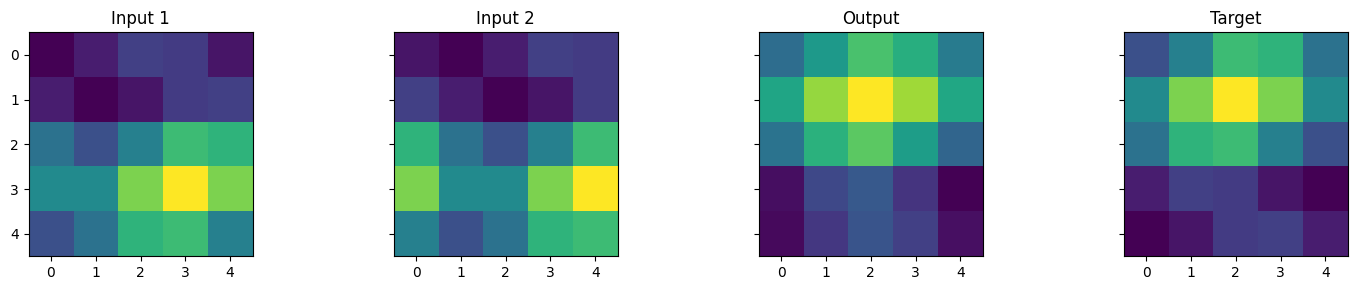

Epoch 2210/50000, Loss: 0.0003, Accuracy: 100.00%
Epoch 2220/50000, Loss: 0.0003, Accuracy: 100.00%
Epoch 2230/50000, Loss: 0.0003, Accuracy: 100.00%
Epoch 2240/50000, Loss: 0.0002, Accuracy: 100.00%
Epoch 2250/50000, Loss: 0.0002, Accuracy: 100.00%
Epoch 2260/50000, Loss: 0.0002, Accuracy: 100.00%
Epoch 2270/50000, Loss: 0.0001, Accuracy: 100.00%
Epoch 2280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2300/50000, Loss: 0.000011


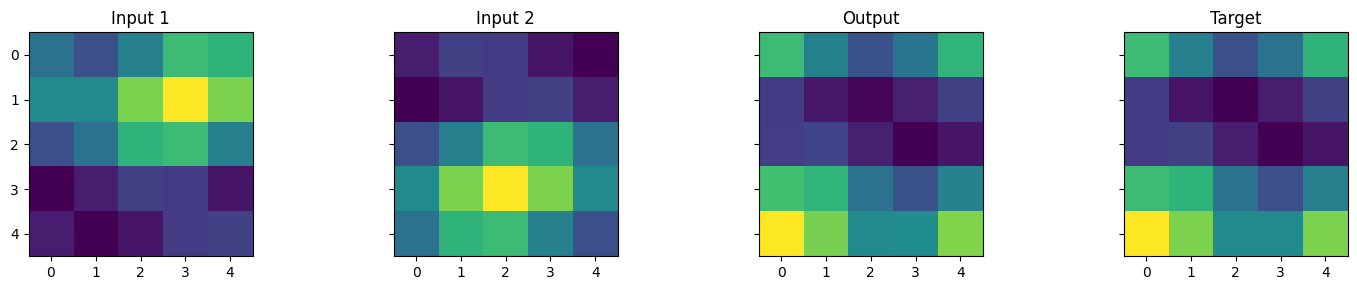

Epoch 2310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2400/50000, Loss: 0.000001


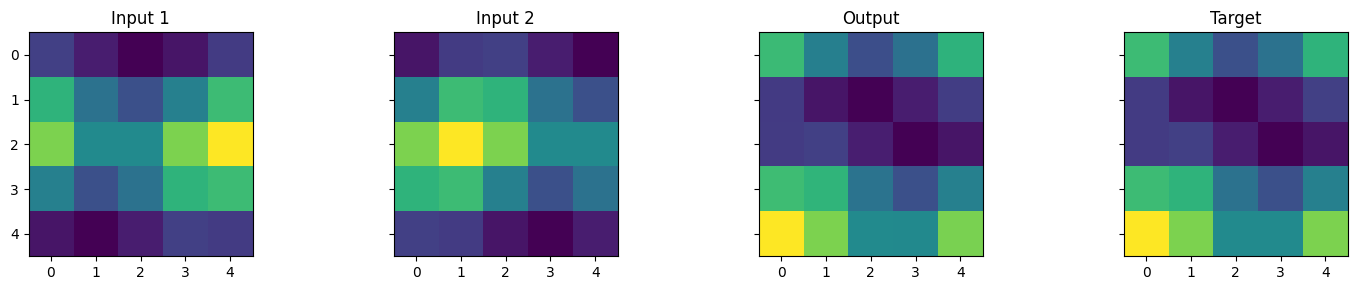

Epoch 2410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2500/50000, Loss: 0.000000


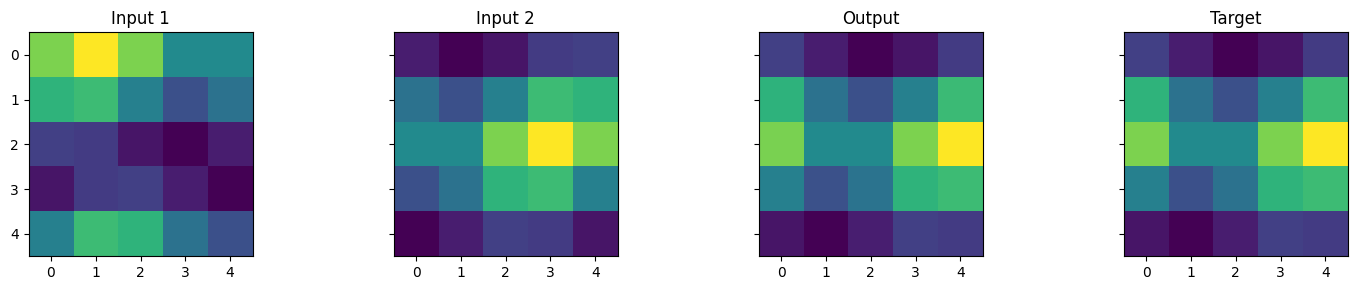

Epoch 2510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2600/50000, Loss: 0.000000


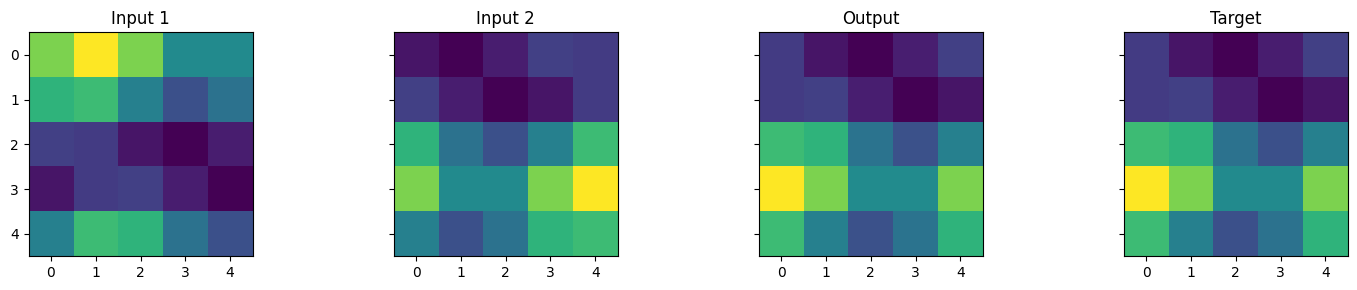

Epoch 2610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2700/50000, Loss: 0.000000


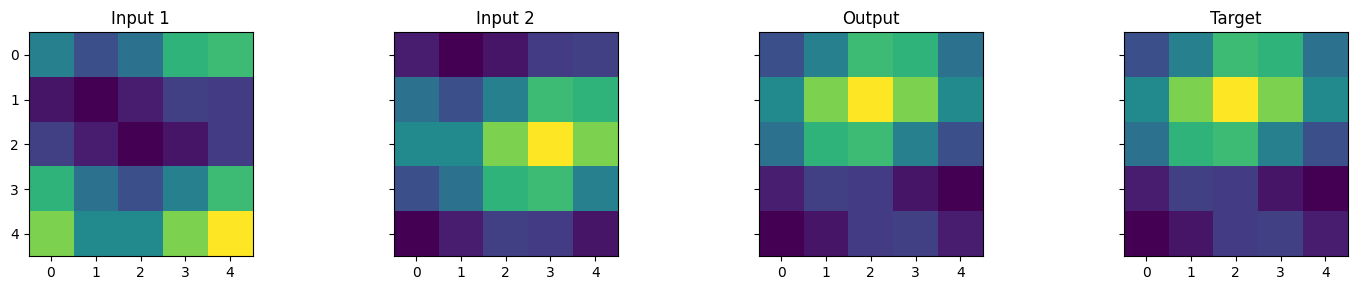

Epoch 2710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2800/50000, Loss: 0.000000


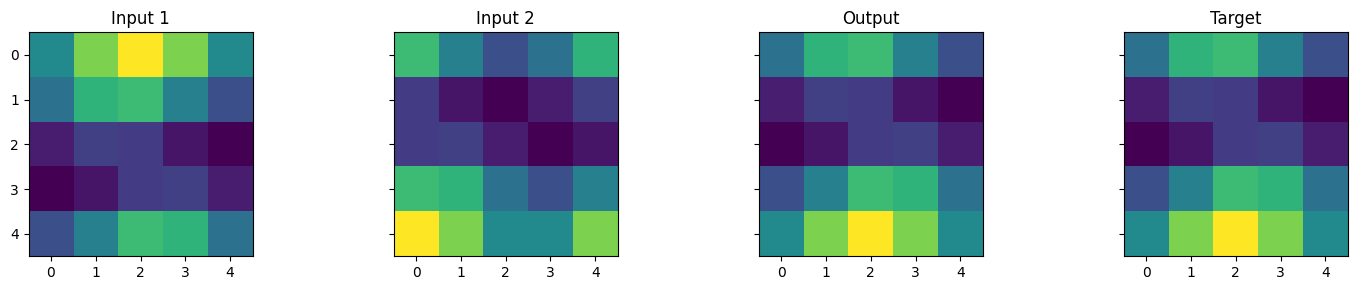

Epoch 2810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2900/50000, Loss: 0.000000


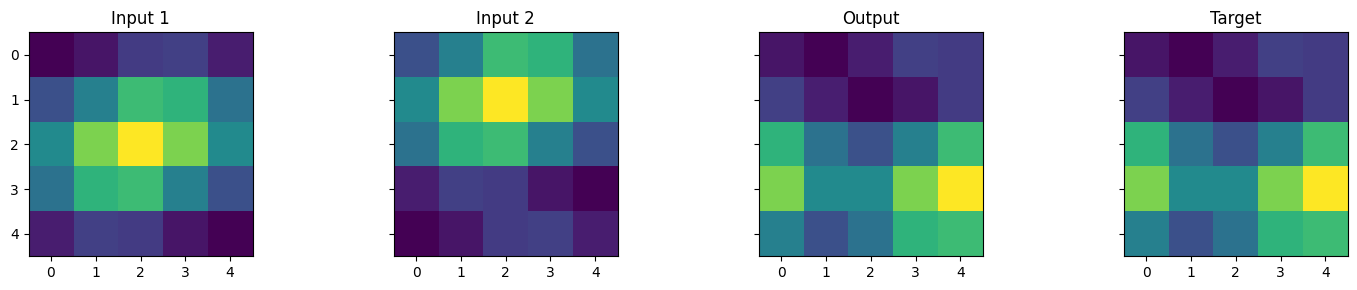

Epoch 2910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 2990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3000/50000, Loss: 0.000000


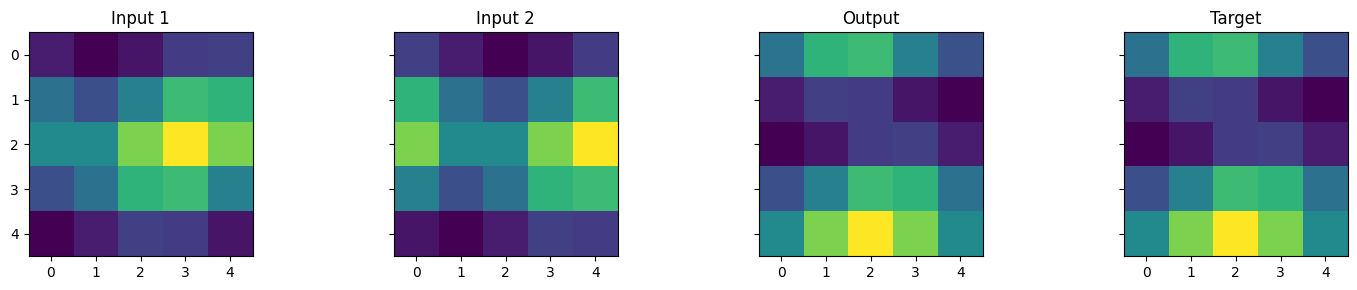

Epoch 3010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3100/50000, Loss: 0.000000


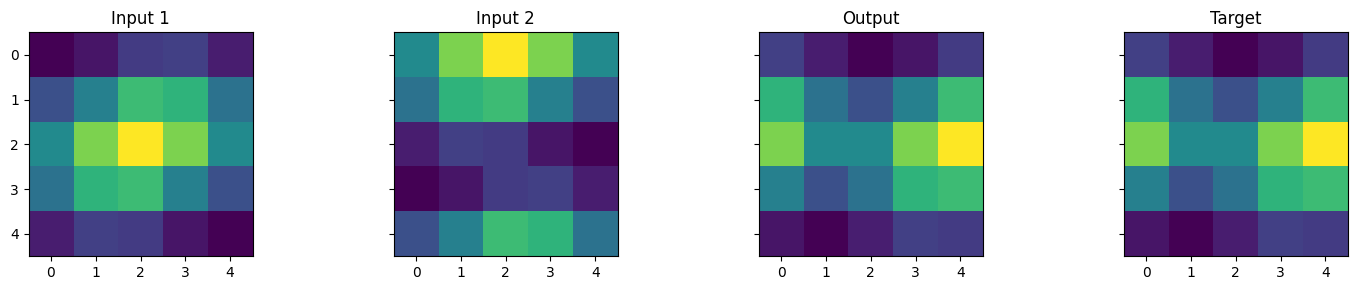

Epoch 3110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3200/50000, Loss: 0.000000


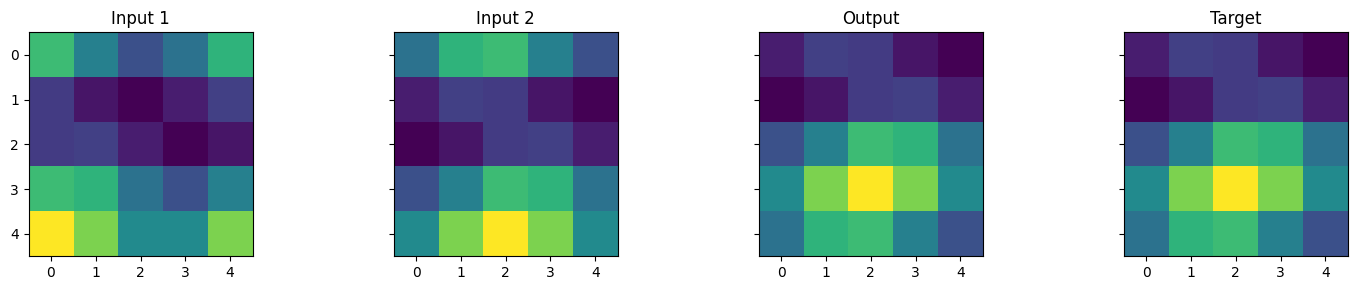

Epoch 3210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3300/50000, Loss: 0.000000


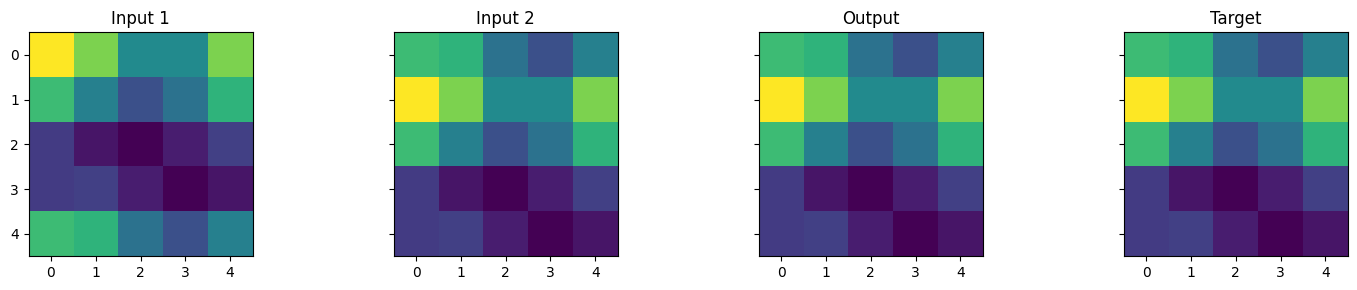

Epoch 3310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3400/50000, Loss: 0.000000


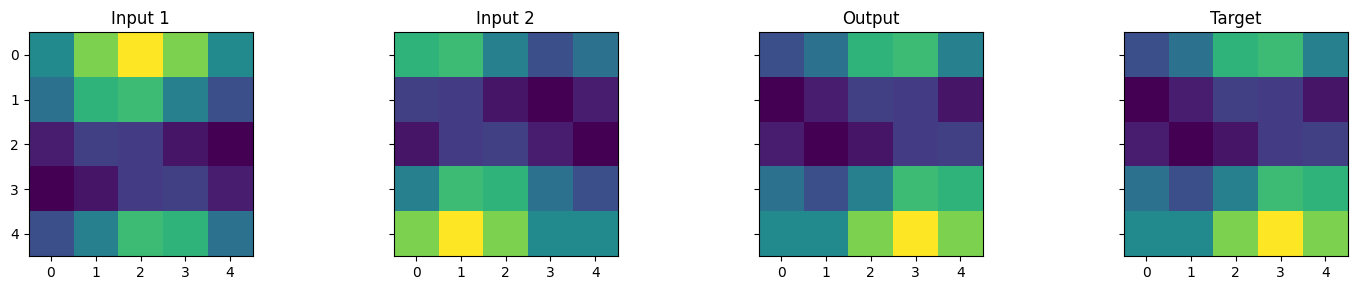

Epoch 3410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3500/50000, Loss: 0.000000


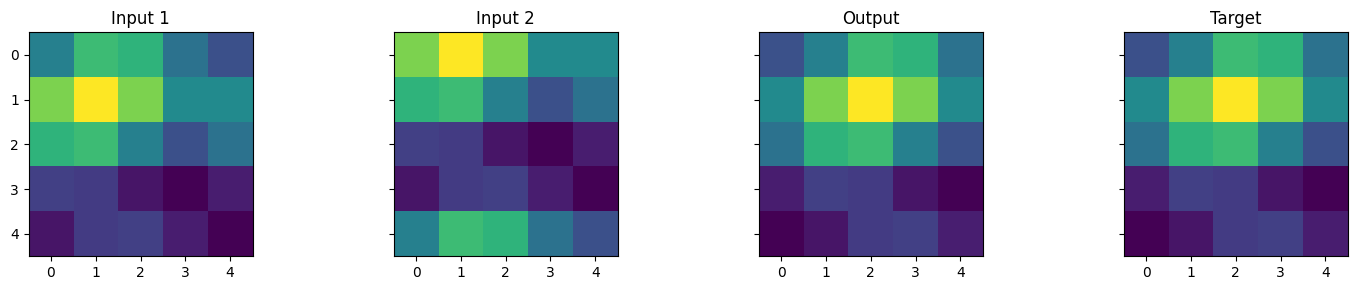

Epoch 3510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3600/50000, Loss: 0.000000


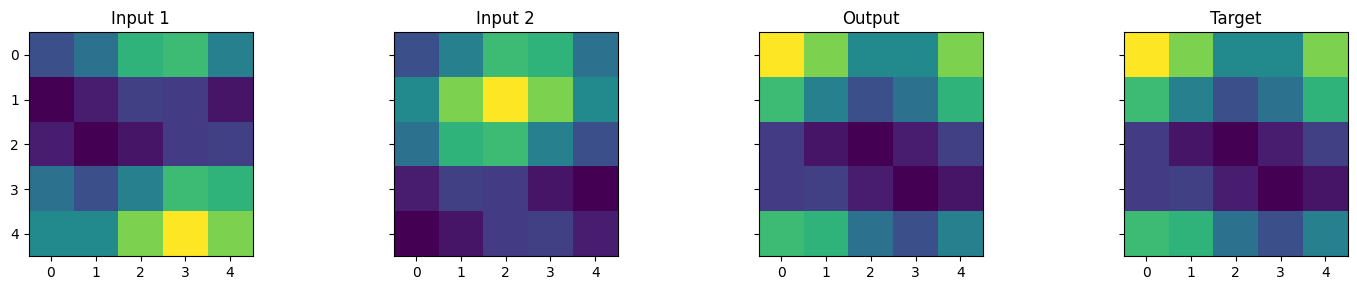

Epoch 3610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3700/50000, Loss: 0.000000


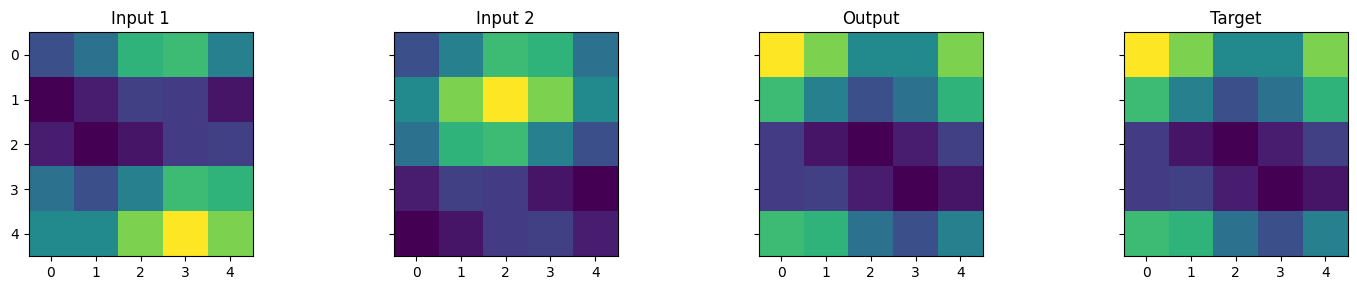

Epoch 3710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3800/50000, Loss: 0.000000


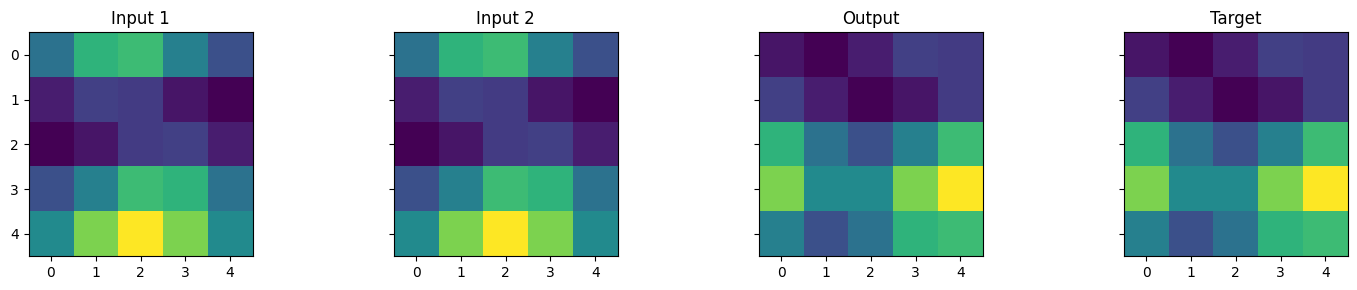

Epoch 3810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3900/50000, Loss: 0.000000


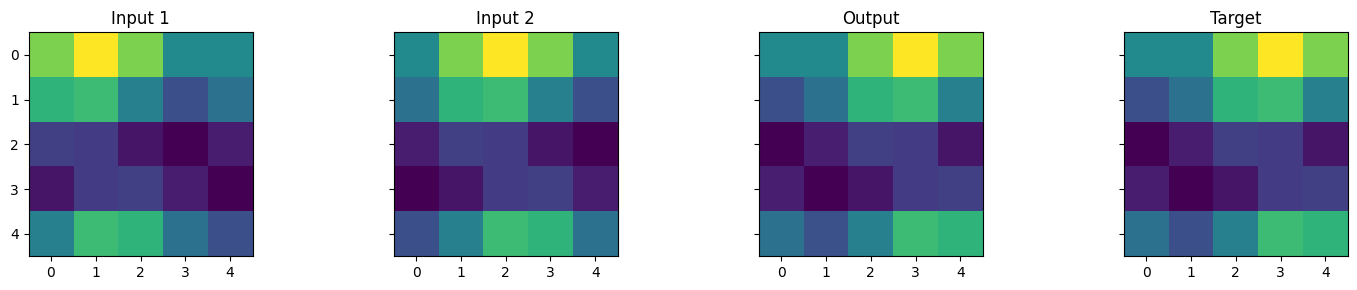

Epoch 3910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 3990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4000/50000, Loss: 0.000000


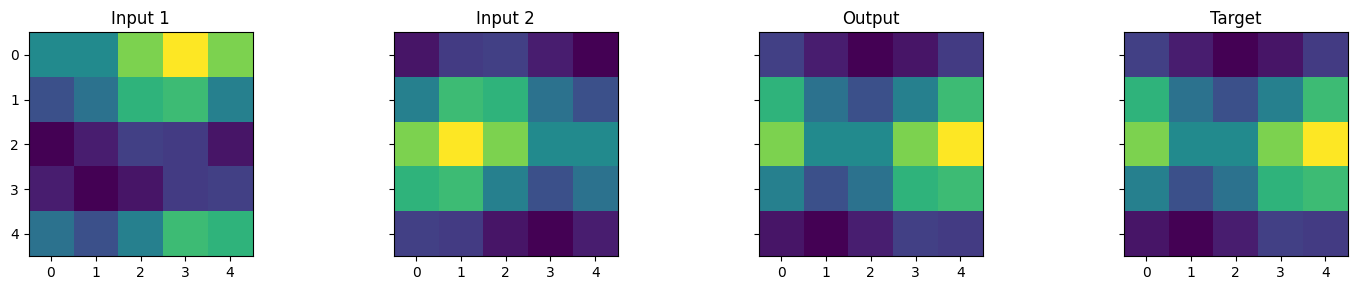

Epoch 4010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4100/50000, Loss: 0.000000


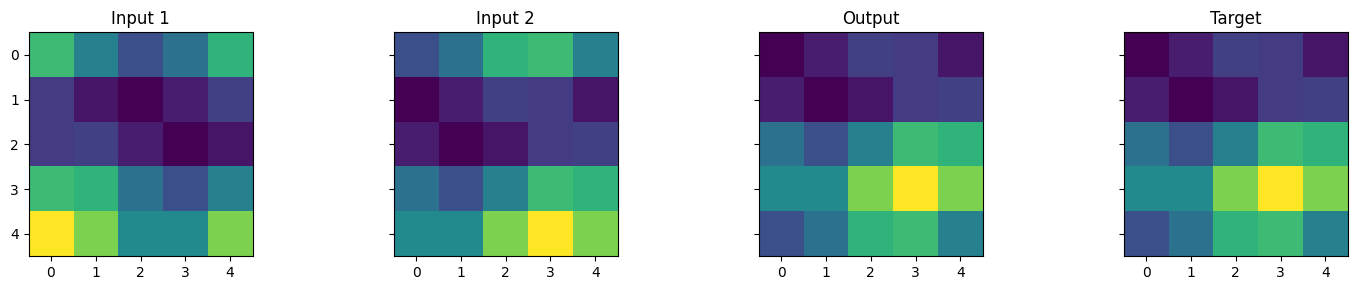

Epoch 4110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4200/50000, Loss: 0.000000


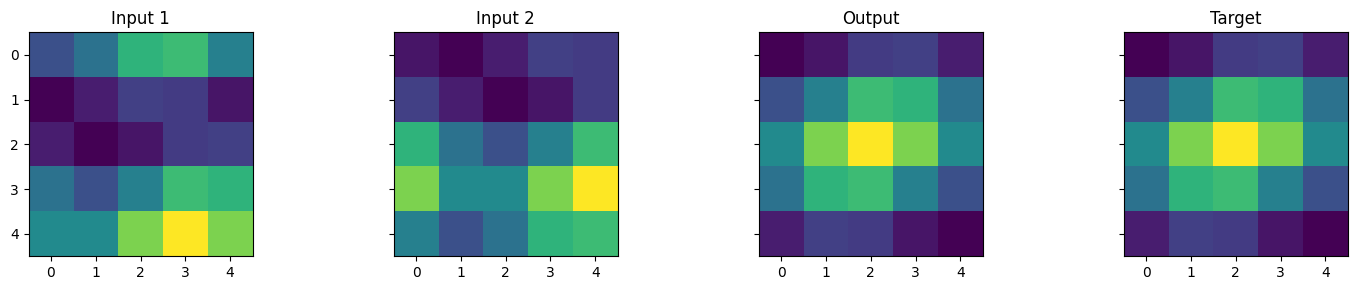

Epoch 4210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4300/50000, Loss: 0.000000


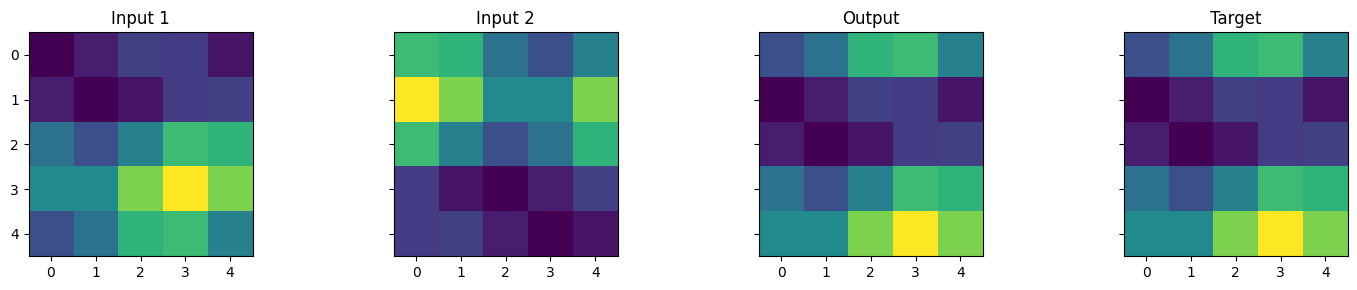

Epoch 4310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4400/50000, Loss: 0.000000


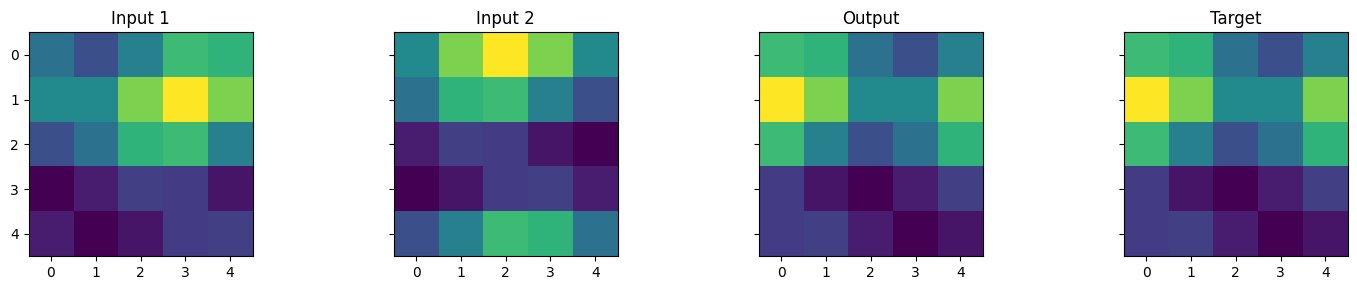

Epoch 4410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4500/50000, Loss: 0.000000


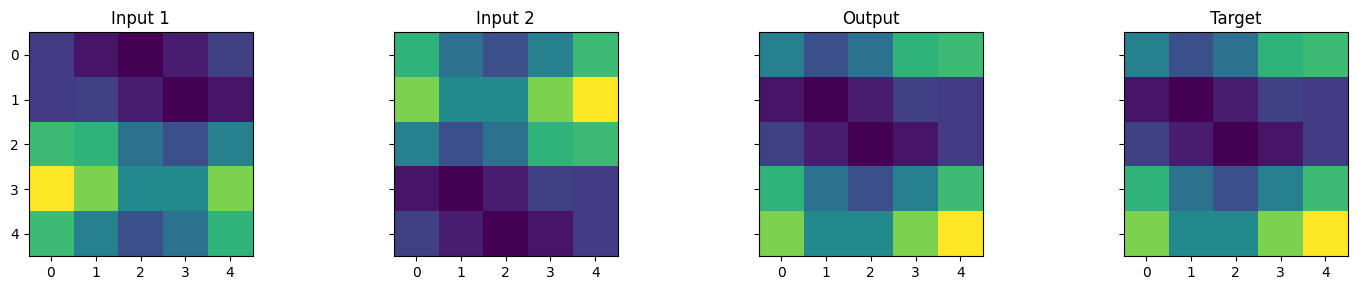

Epoch 4510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4600/50000, Loss: 0.000000


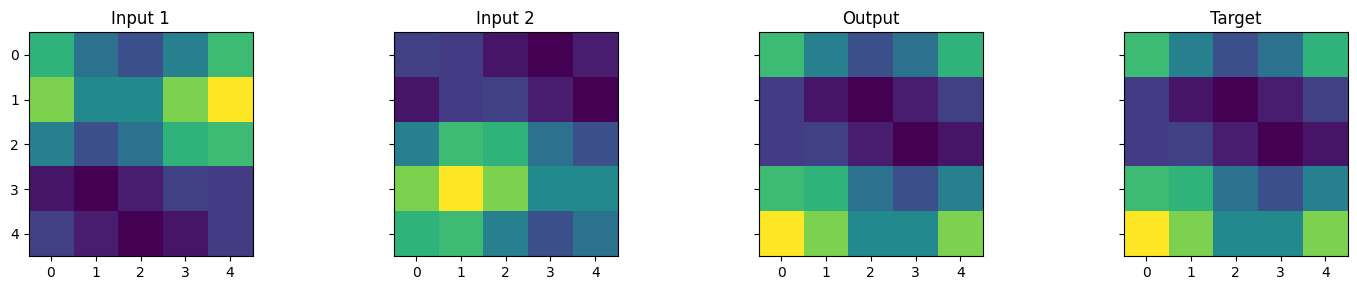

Epoch 4610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4700/50000, Loss: 0.000000


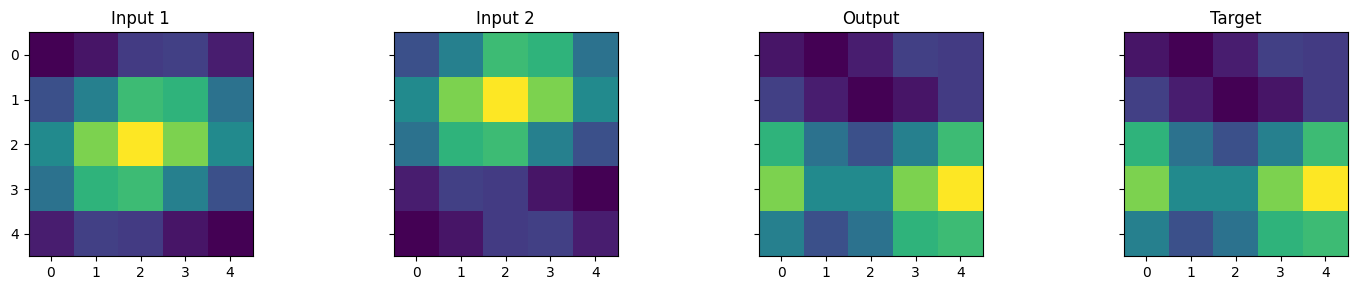

Epoch 4710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4800/50000, Loss: 0.000000


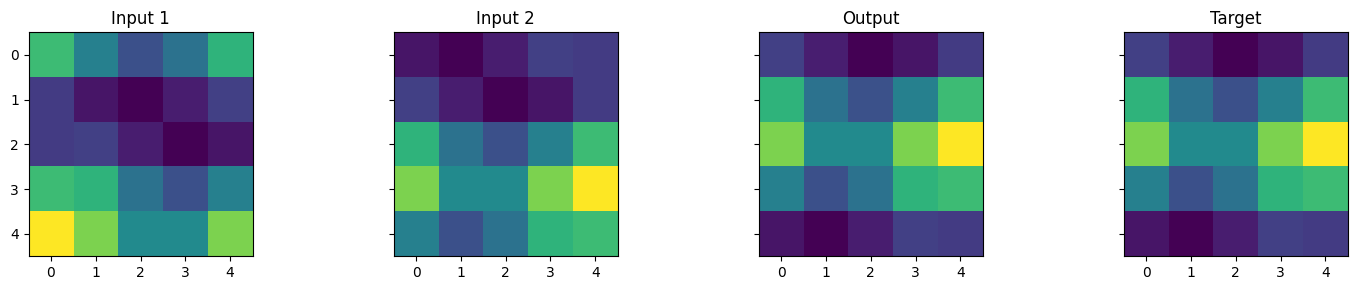

Epoch 4810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4900/50000, Loss: 0.000000


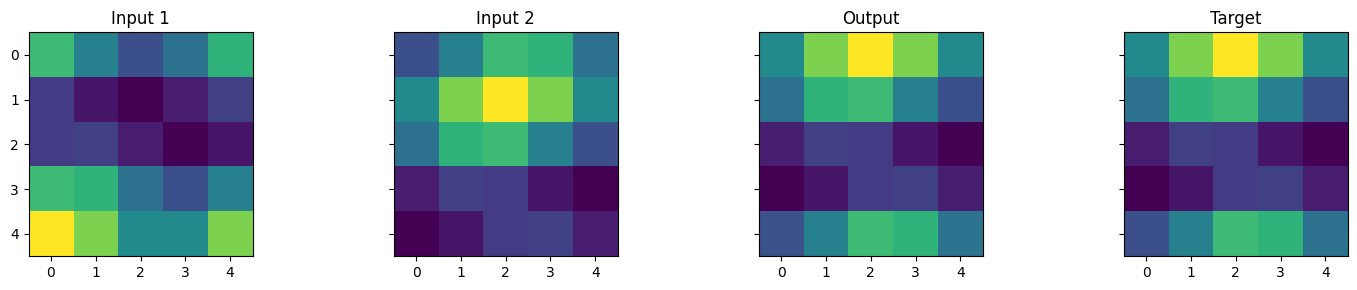

Epoch 4910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 4990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5000/50000, Loss: 0.000000


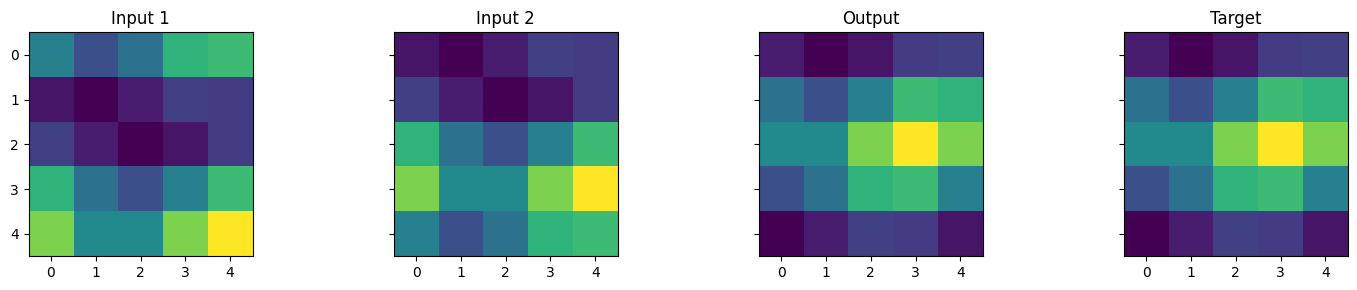

Epoch 5010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5100/50000, Loss: 0.000000


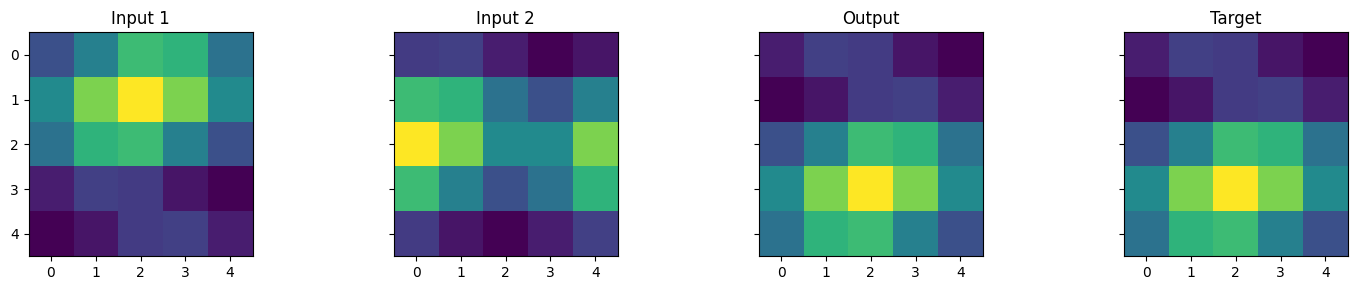

Epoch 5110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5200/50000, Loss: 0.000000


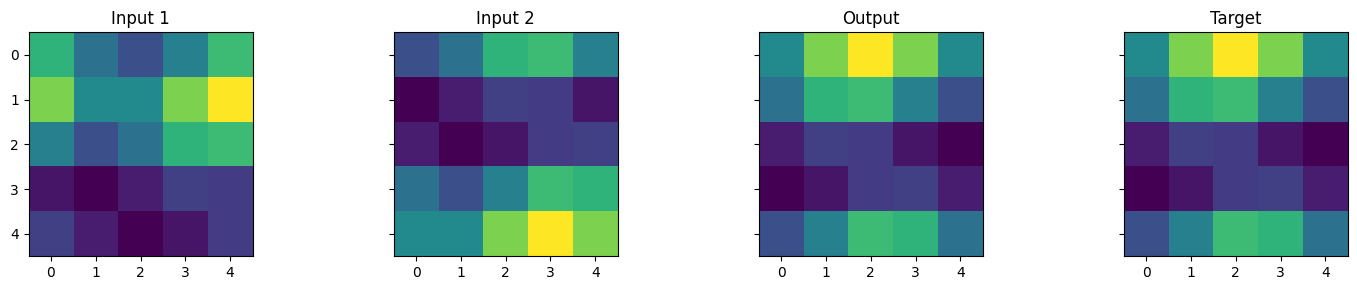

Epoch 5210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5300/50000, Loss: 0.000000


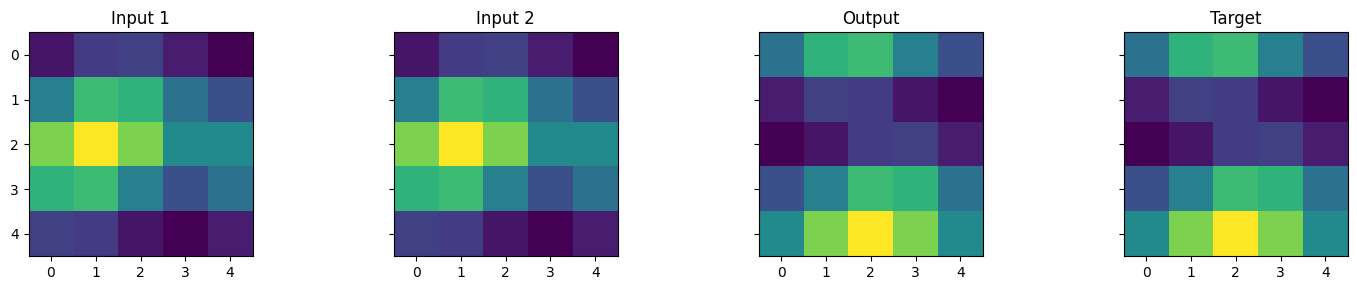

Epoch 5310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5400/50000, Loss: 0.000000


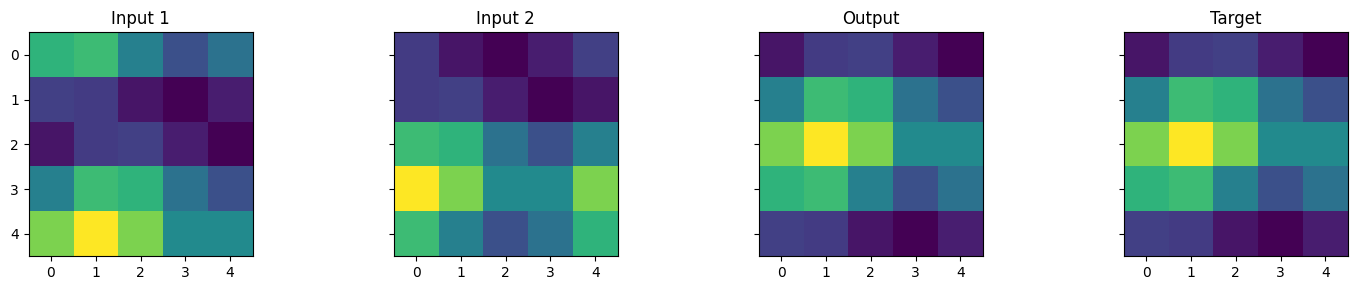

Epoch 5410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5500/50000, Loss: 0.000000


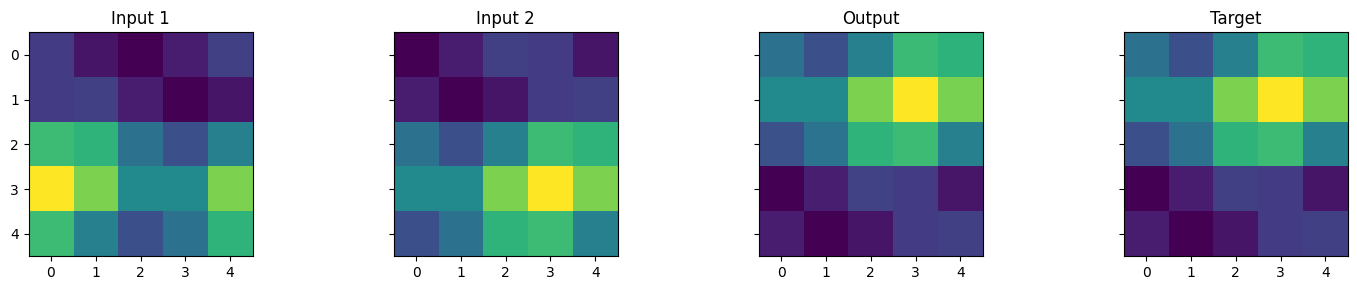

Epoch 5510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5600/50000, Loss: 0.000000


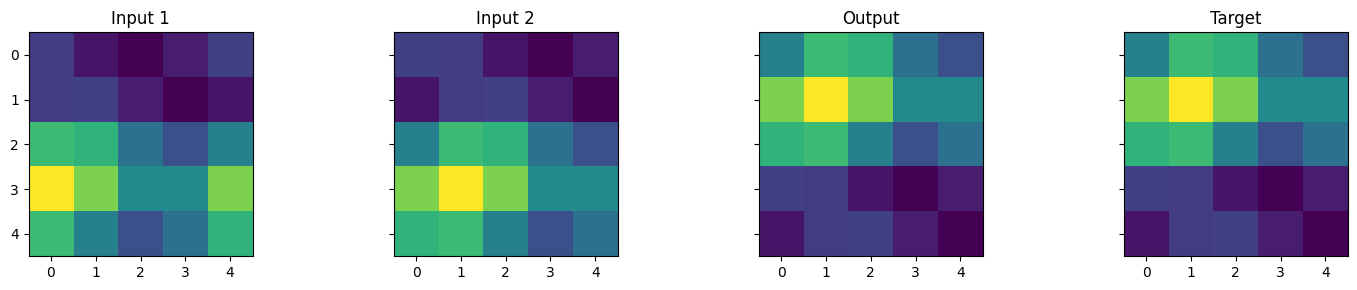

Epoch 5610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5700/50000, Loss: 0.000000


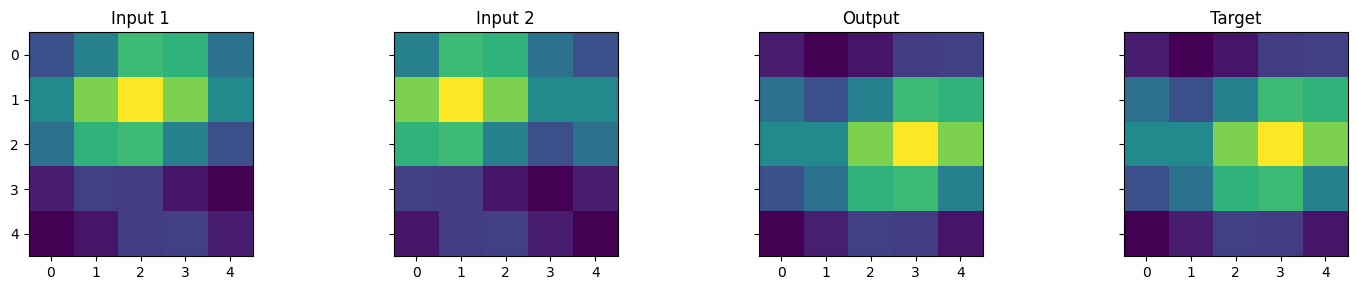

Epoch 5710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5800/50000, Loss: 0.000000


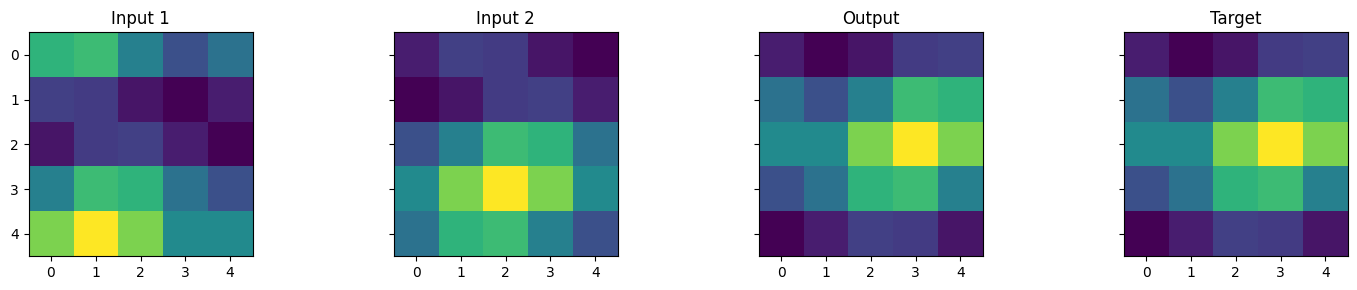

Epoch 5810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5900/50000, Loss: 0.000000


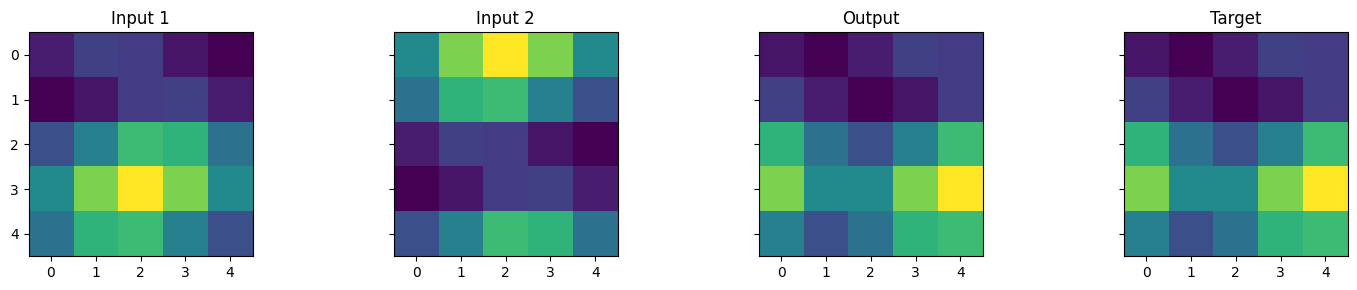

Epoch 5910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 5990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6000/50000, Loss: 0.000000


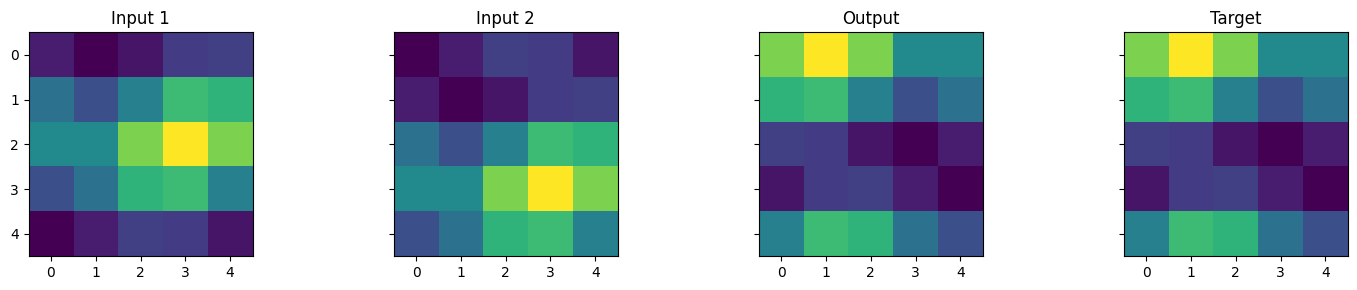

Epoch 6010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6100/50000, Loss: 0.000000


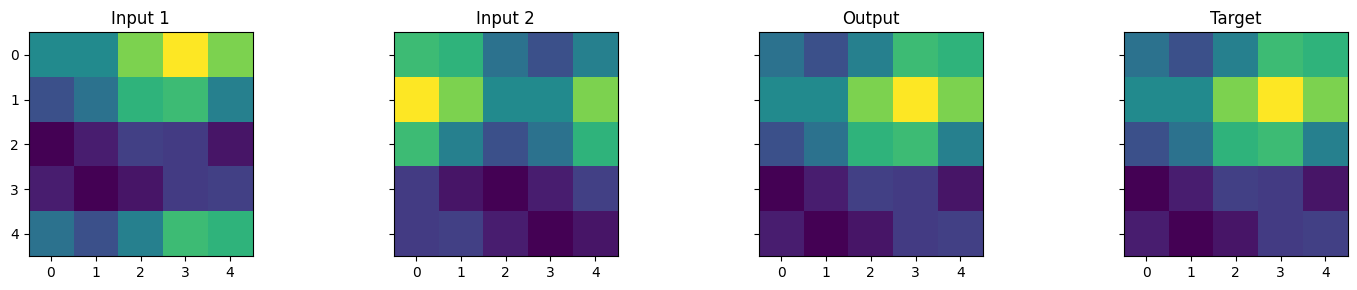

Epoch 6110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6200/50000, Loss: 0.000000


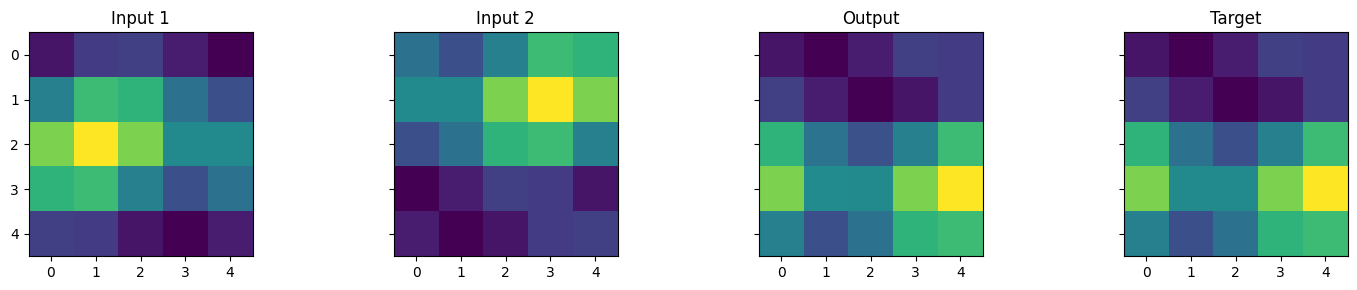

Epoch 6210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6300/50000, Loss: 0.000000


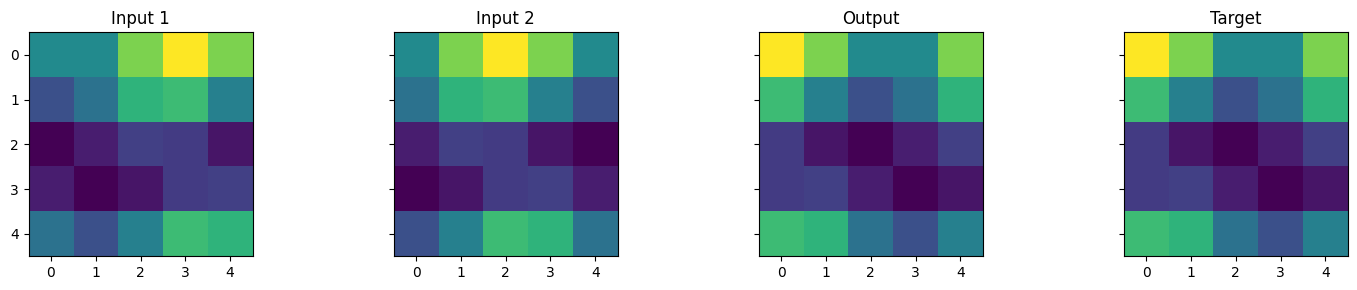

Epoch 6310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6400/50000, Loss: 0.000000


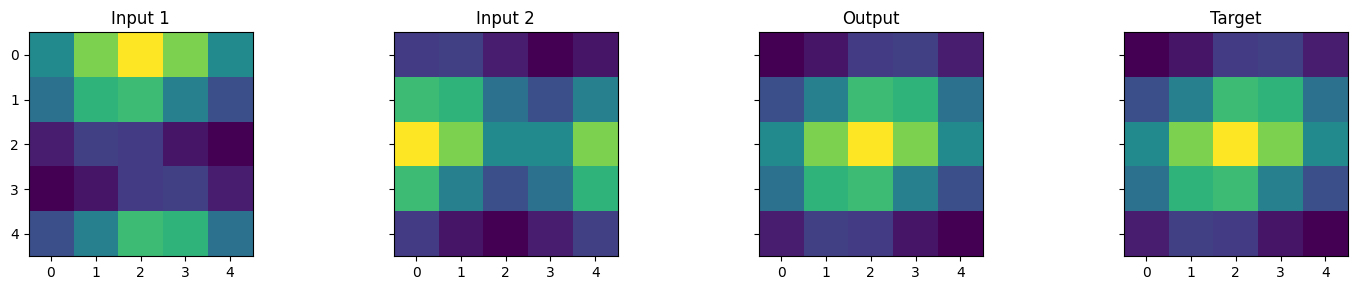

Epoch 6410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6500/50000, Loss: 0.000000


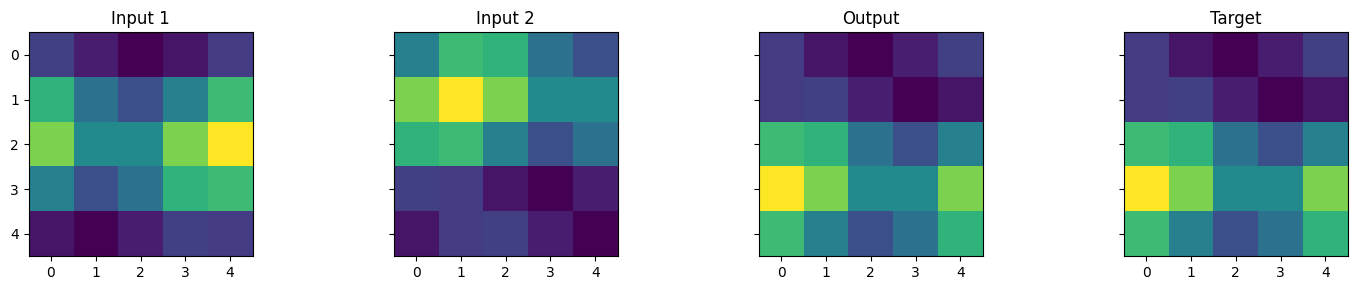

Epoch 6510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6600/50000, Loss: 0.000000


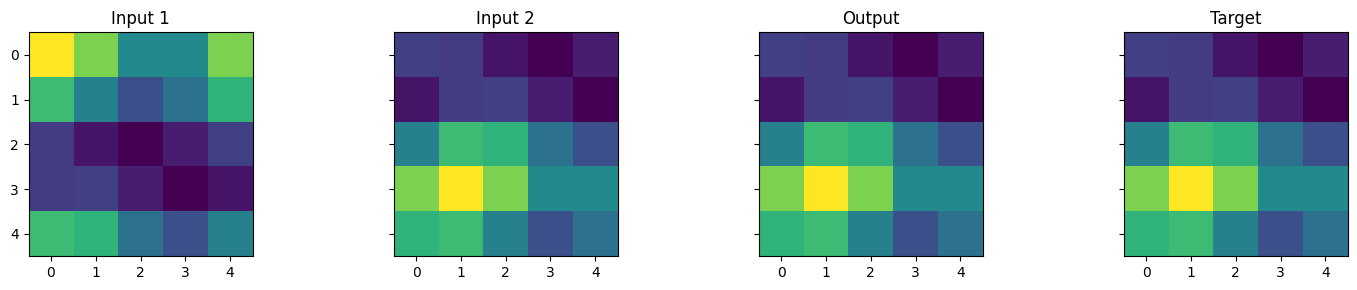

Epoch 6610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6700/50000, Loss: 0.000000


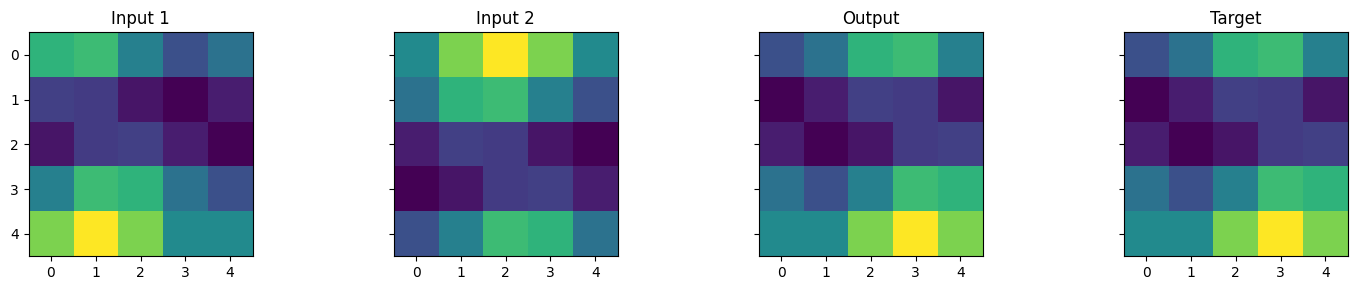

Epoch 6710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6800/50000, Loss: 0.000000


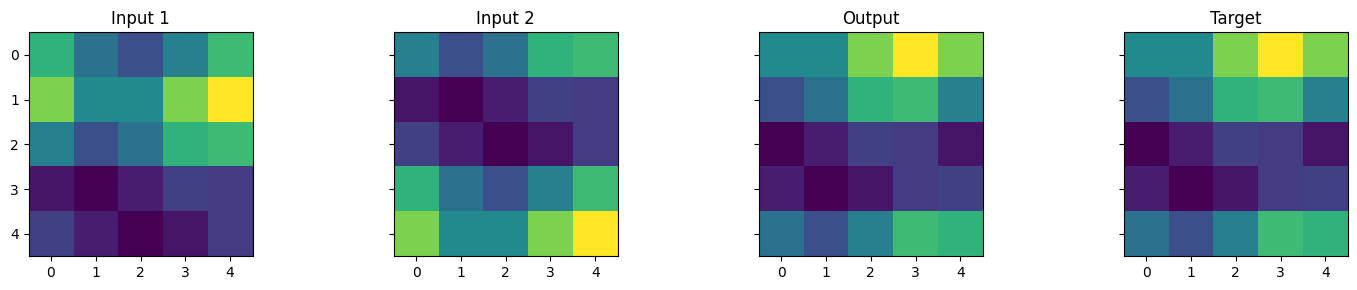

Epoch 6810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6900/50000, Loss: 0.000000


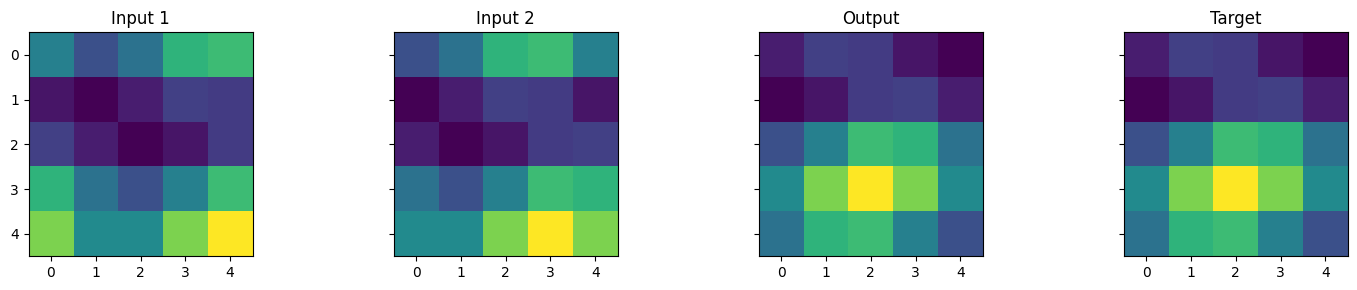

Epoch 6910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 6990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7000/50000, Loss: 0.000000


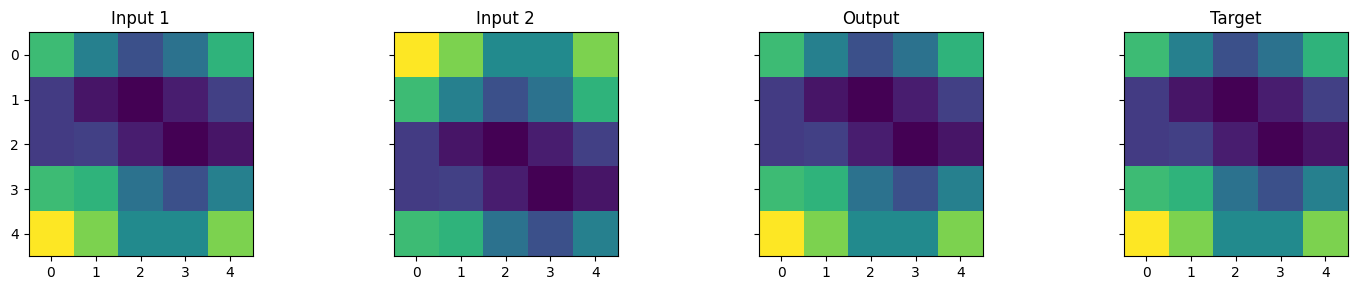

Epoch 7010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7100/50000, Loss: 0.000000


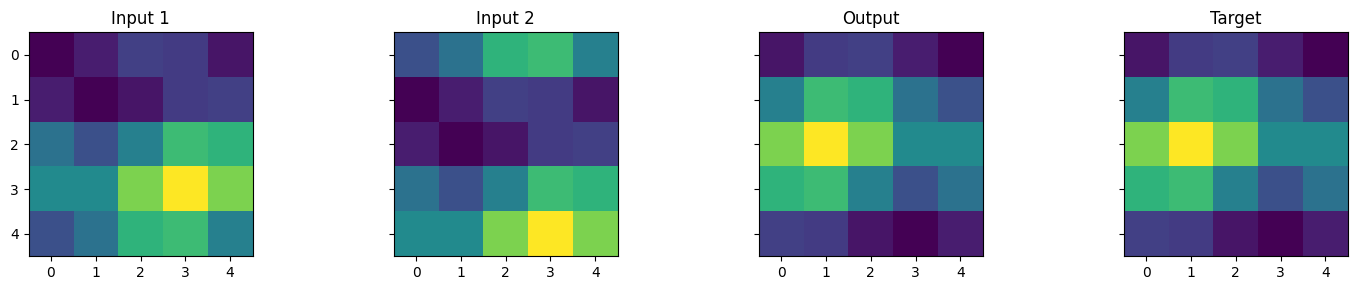

Epoch 7110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7200/50000, Loss: 0.000000


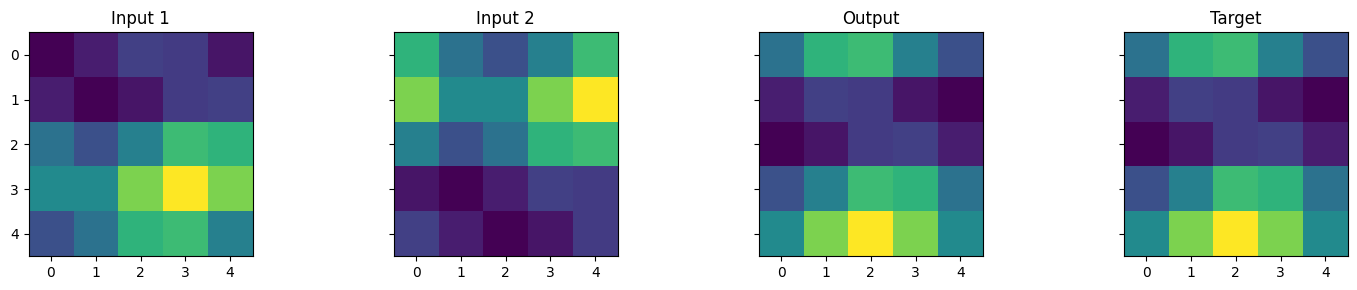

Epoch 7210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7300/50000, Loss: 0.000000


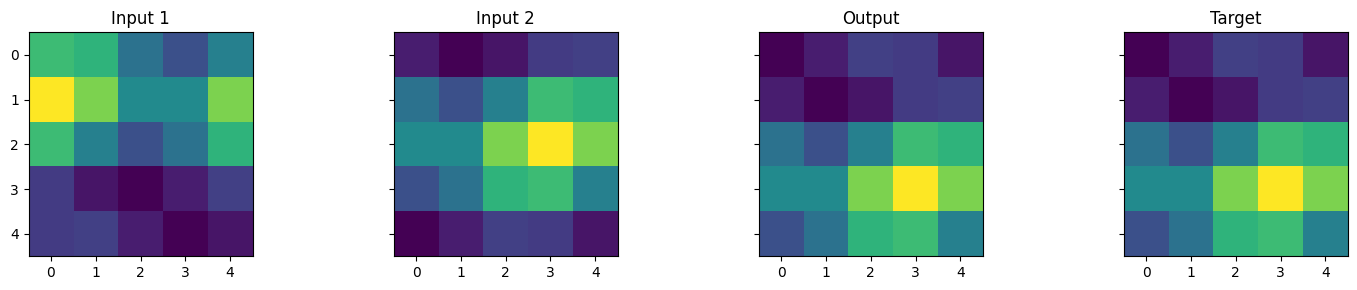

Epoch 7310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7400/50000, Loss: 0.000000


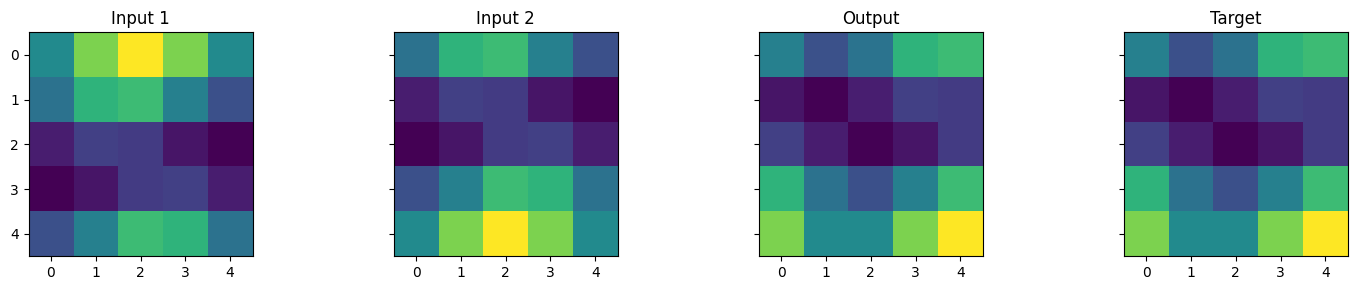

Epoch 7410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7500/50000, Loss: 0.000000


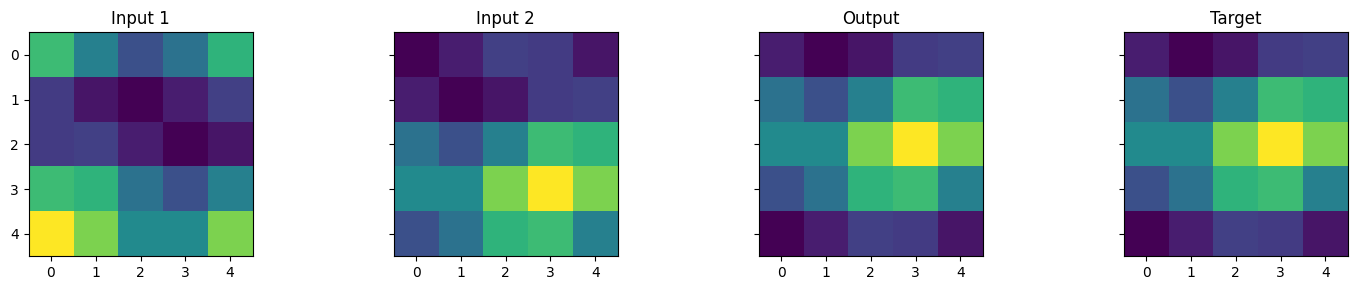

Epoch 7510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7600/50000, Loss: 0.000000


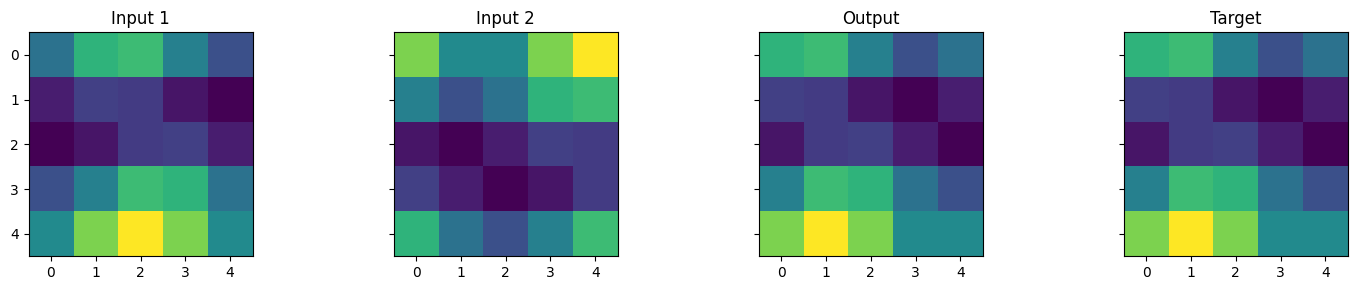

Epoch 7610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7700/50000, Loss: 0.000000


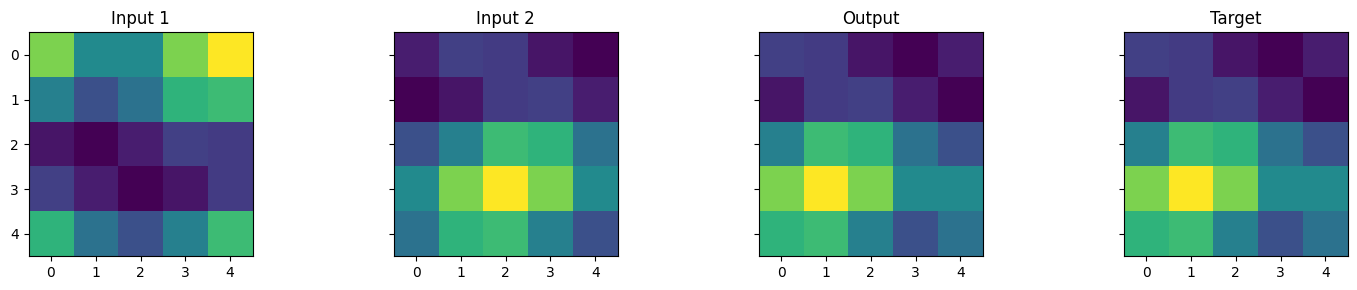

Epoch 7710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7800/50000, Loss: 0.000000


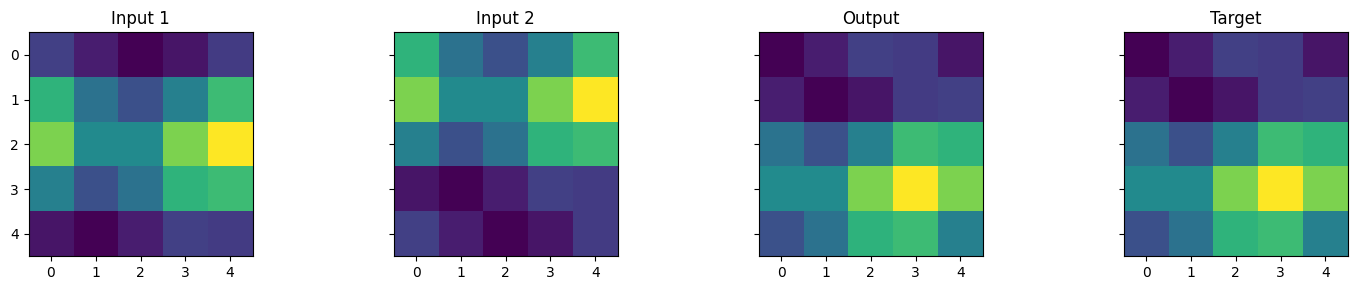

Epoch 7810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7900/50000, Loss: 0.000000


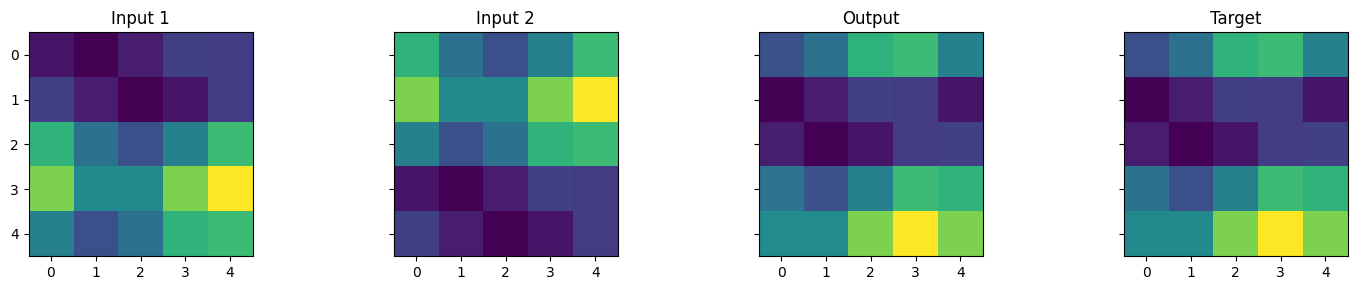

Epoch 7910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 7990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8000/50000, Loss: 0.000000


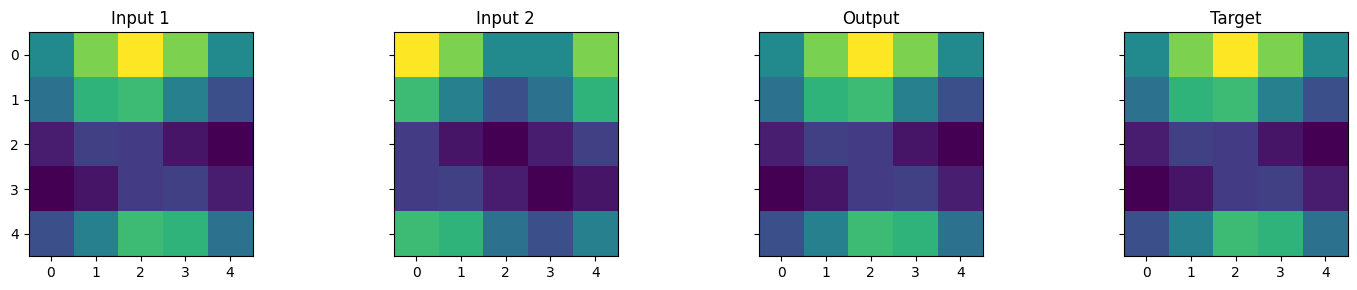

Epoch 8010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8100/50000, Loss: 0.000000


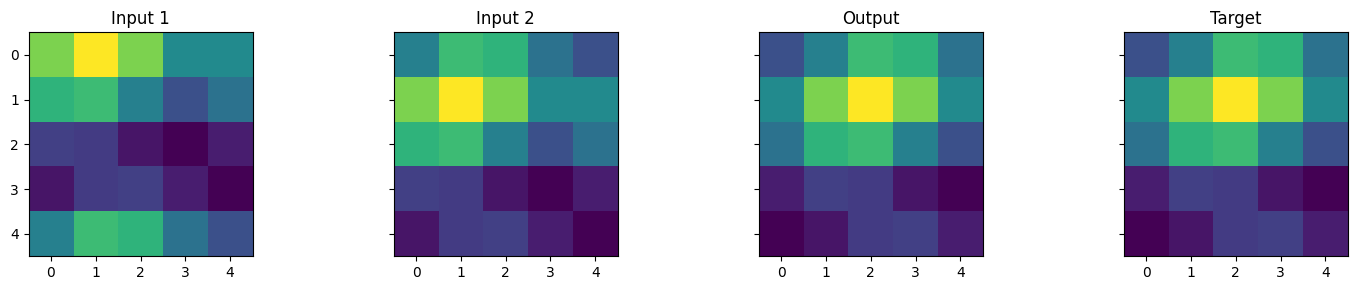

Epoch 8110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8200/50000, Loss: 0.000000


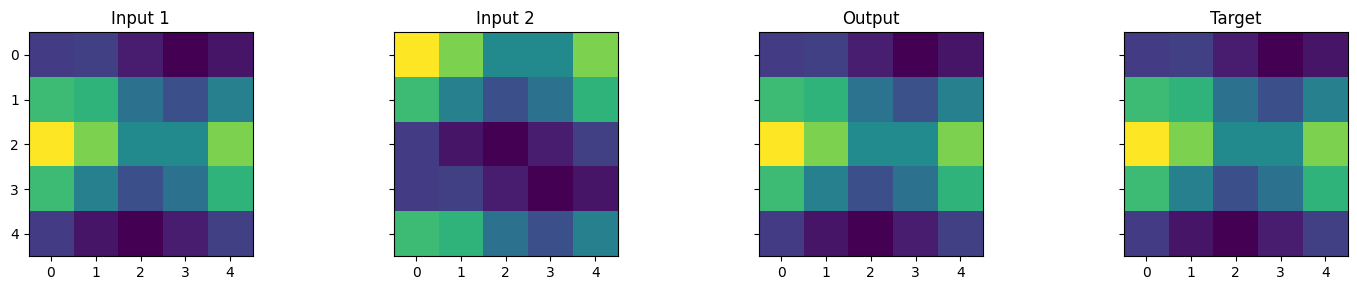

Epoch 8210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8300/50000, Loss: 0.000000


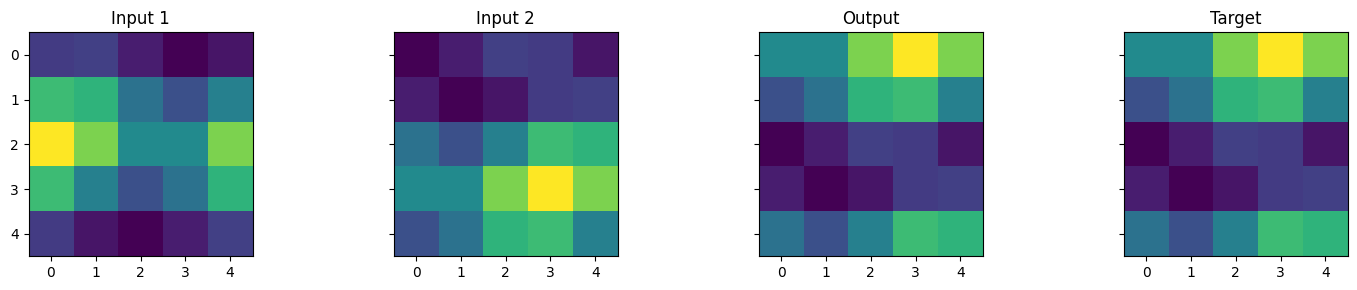

Epoch 8310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8400/50000, Loss: 0.000000


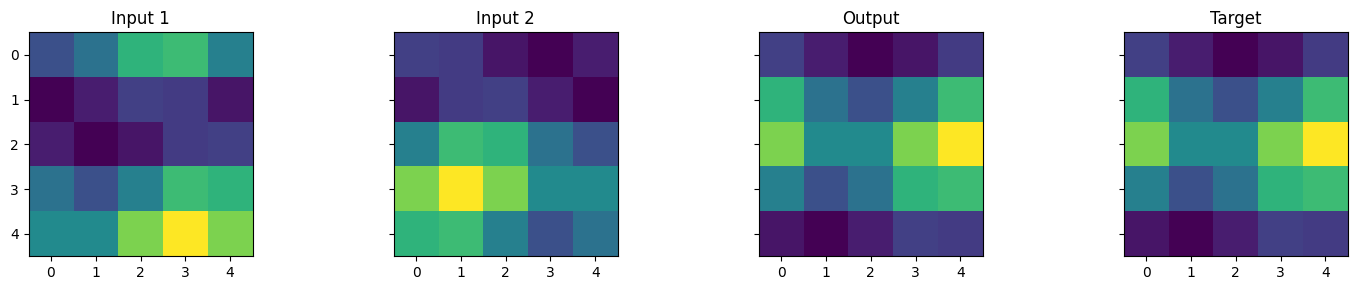

Epoch 8410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8500/50000, Loss: 0.000000


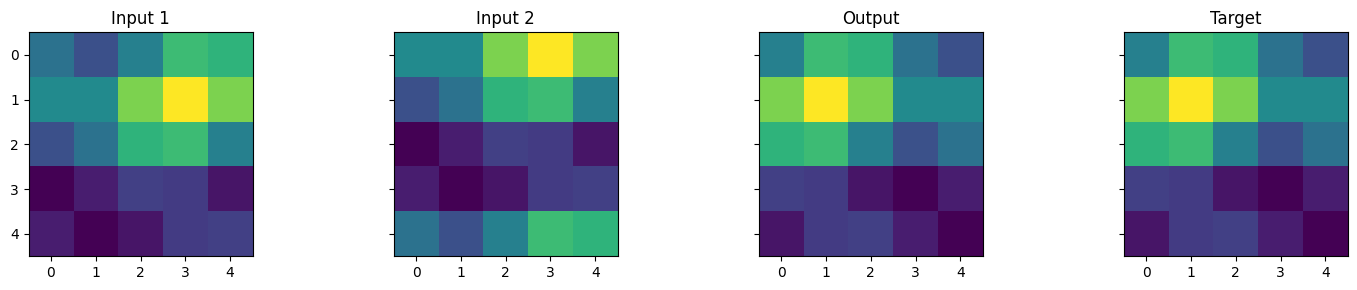

Epoch 8510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8600/50000, Loss: 0.000000


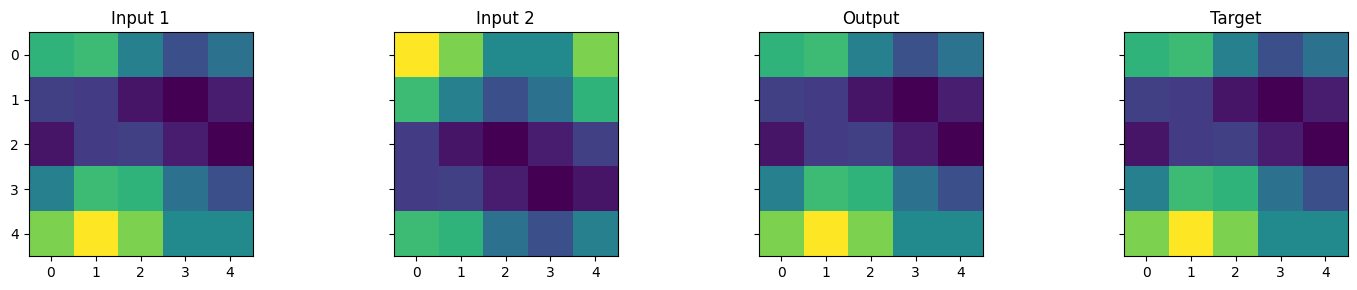

Epoch 8610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8700/50000, Loss: 0.000000


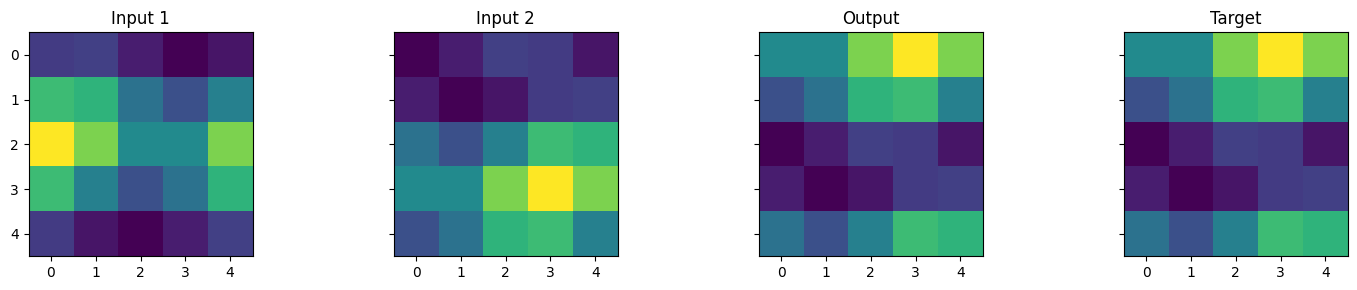

Epoch 8710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8800/50000, Loss: 0.000000


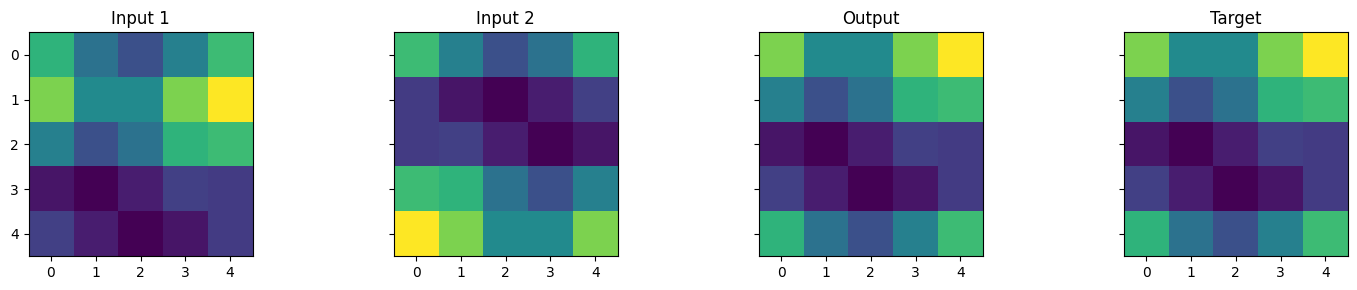

Epoch 8810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8900/50000, Loss: 0.000000


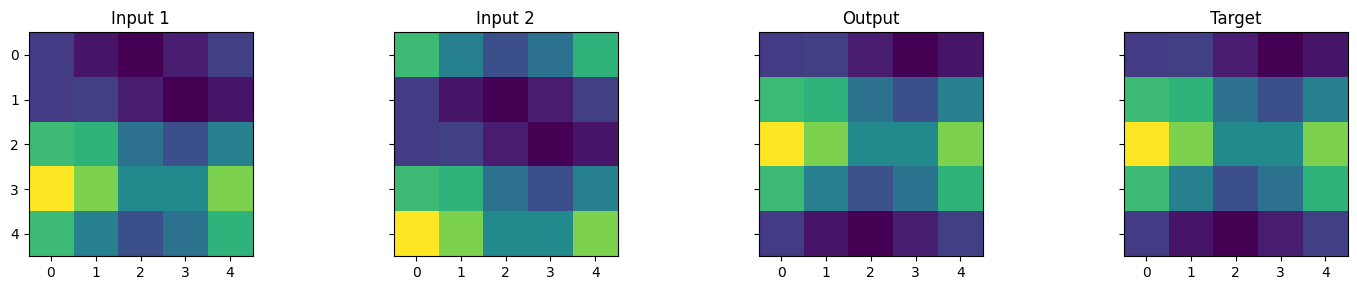

Epoch 8910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 8990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9000/50000, Loss: 0.000000


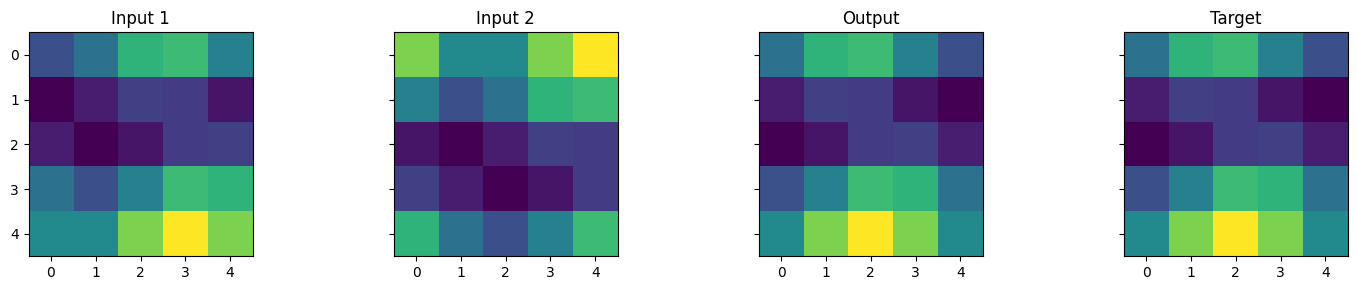

Epoch 9010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9100/50000, Loss: 0.000000


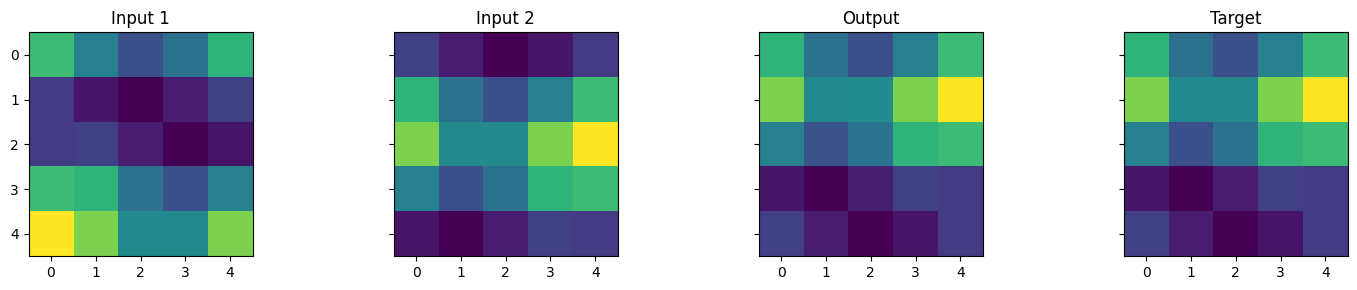

Epoch 9110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9200/50000, Loss: 0.000000


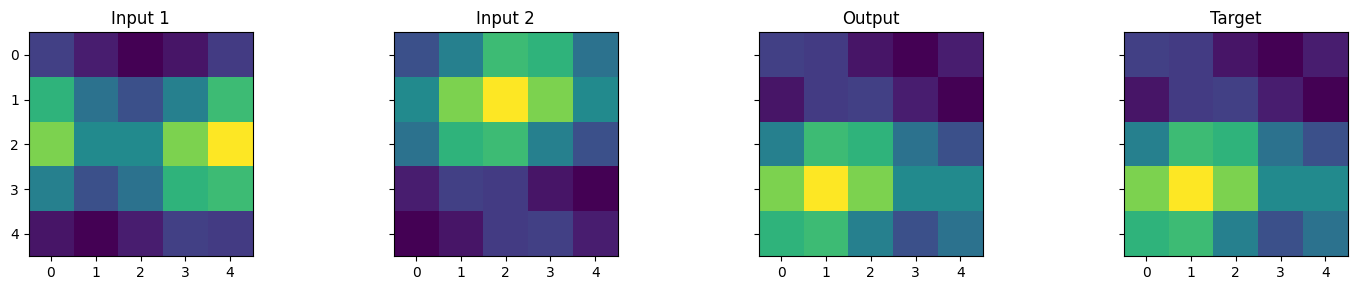

Epoch 9210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9300/50000, Loss: 0.000000


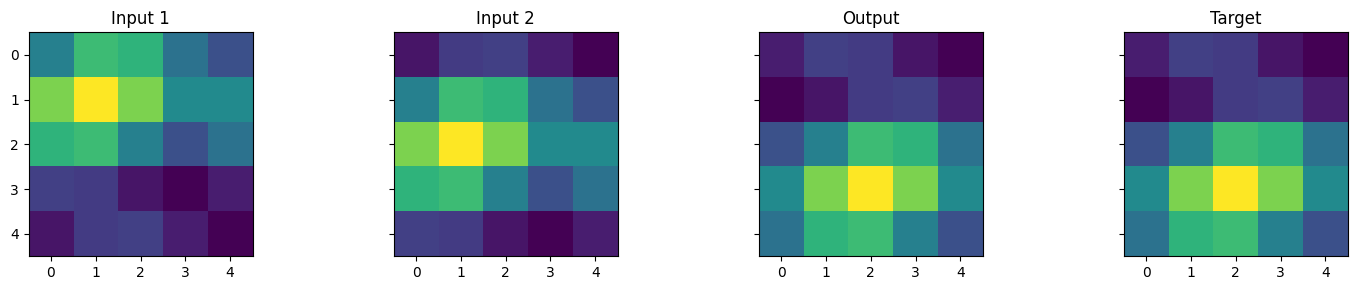

Epoch 9310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9400/50000, Loss: 0.000000


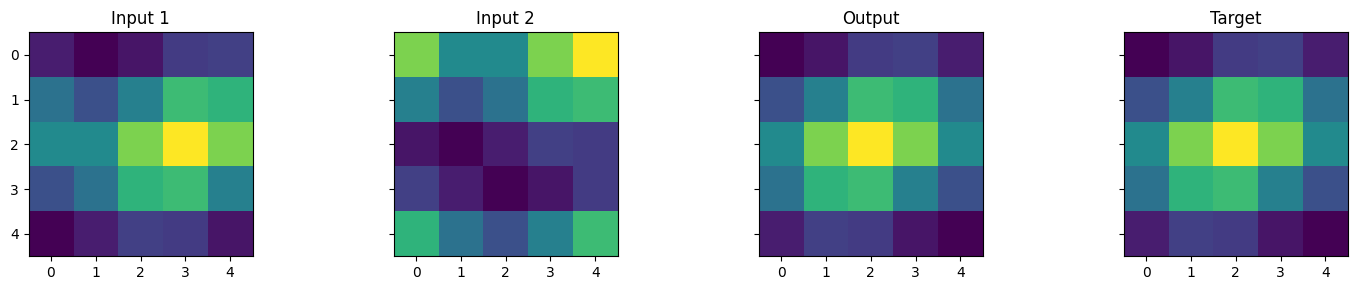

Epoch 9410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9500/50000, Loss: 0.000000


Epoch 9510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9600/50000, Loss: 0.000000


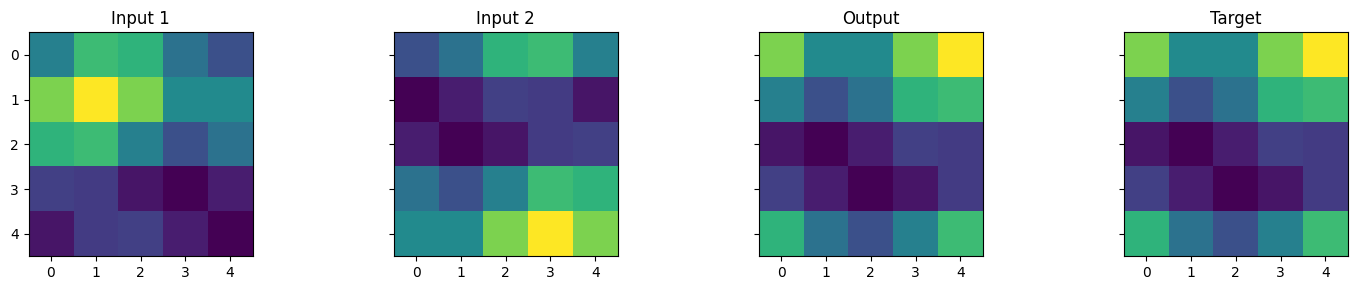

Epoch 9610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9700/50000, Loss: 0.000000


Epoch 9710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9800/50000, Loss: 0.000000


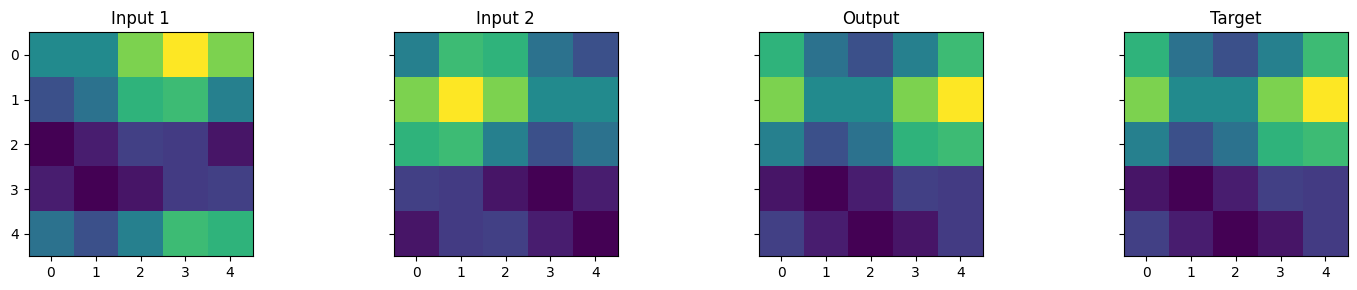

Epoch 9810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9900/50000, Loss: 0.000000


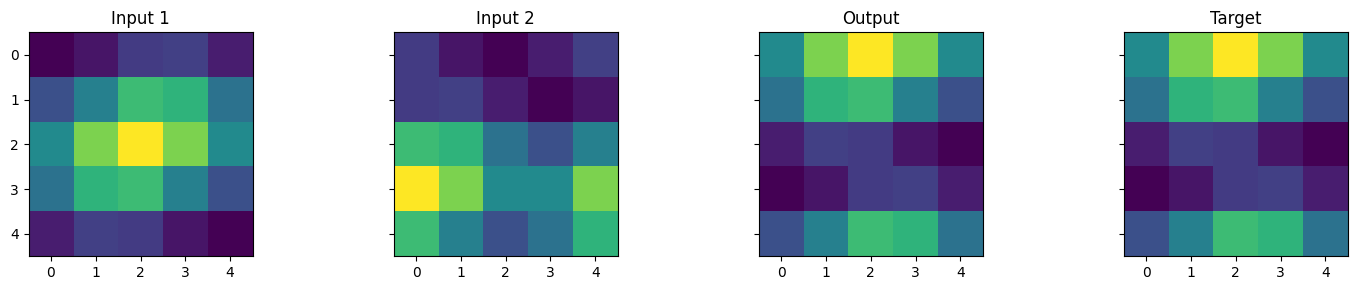

Epoch 9910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 9990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10000/50000, Loss: 0.000000


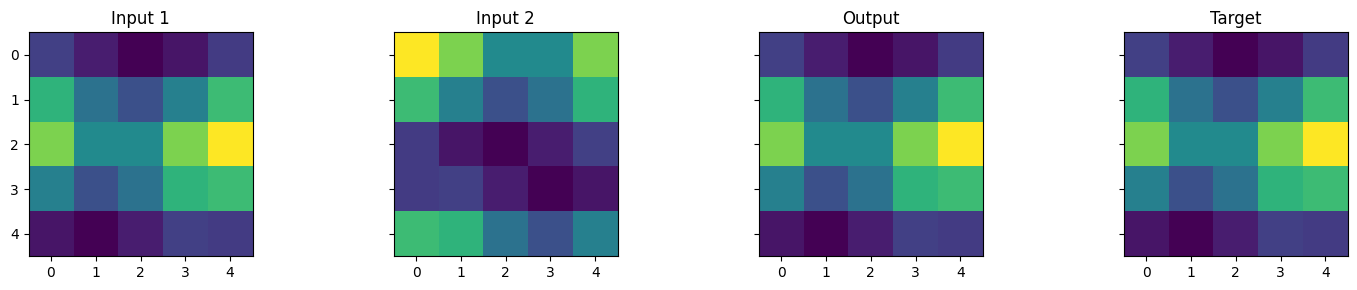

Epoch 10010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10100/50000, Loss: 0.000000


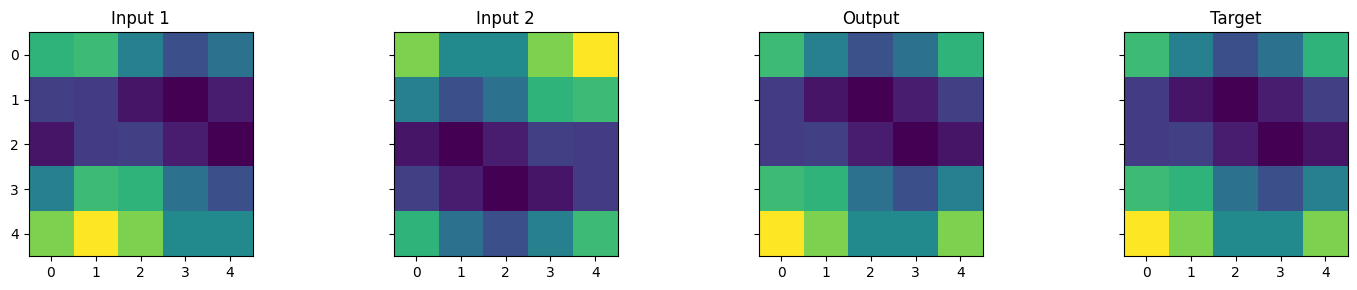

Epoch 10110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10200/50000, Loss: 0.000000


Epoch 10210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10300/50000, Loss: 0.000000


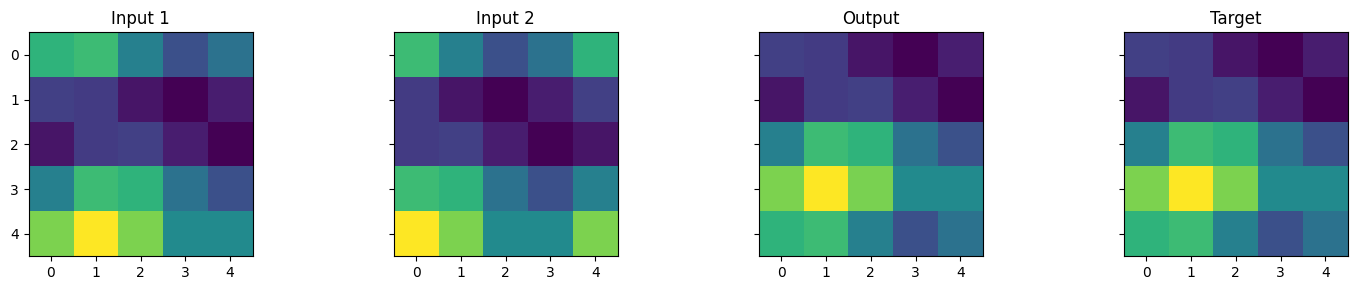

Epoch 10310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10400/50000, Loss: 0.000000


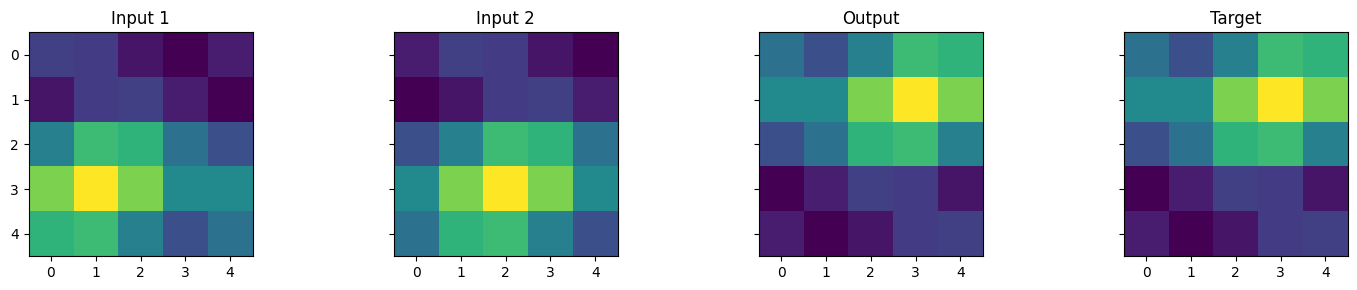

Epoch 10410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10500/50000, Loss: 0.000000


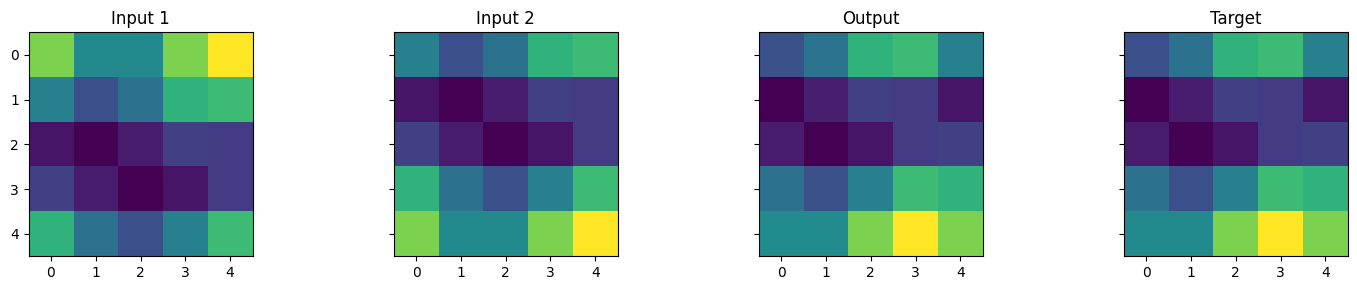

Epoch 10510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10600/50000, Loss: 0.000000


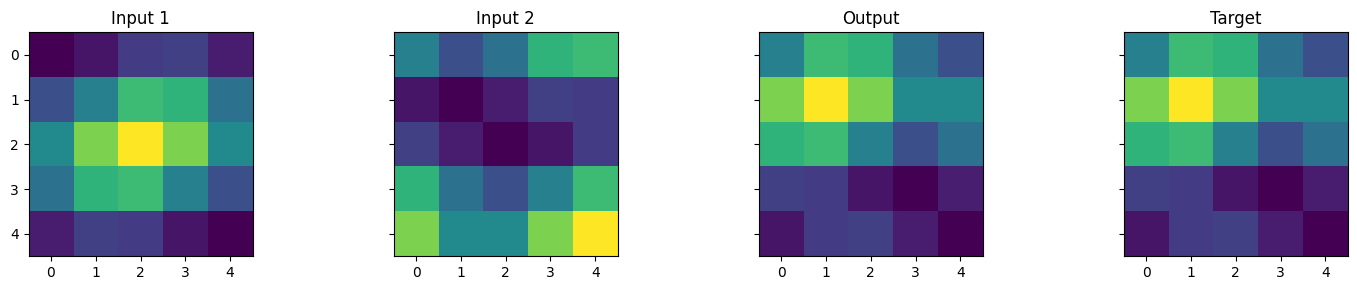

Epoch 10610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10700/50000, Loss: 0.000000


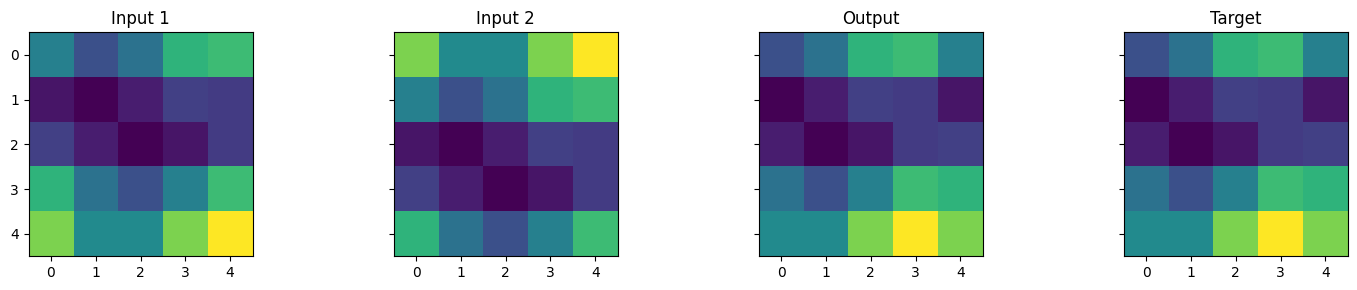

Epoch 10710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10800/50000, Loss: 0.000000


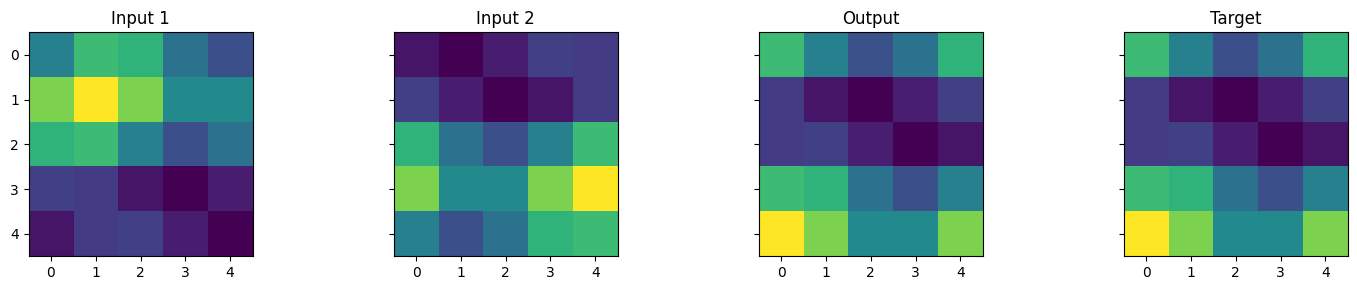

Epoch 10810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10900/50000, Loss: 0.000000


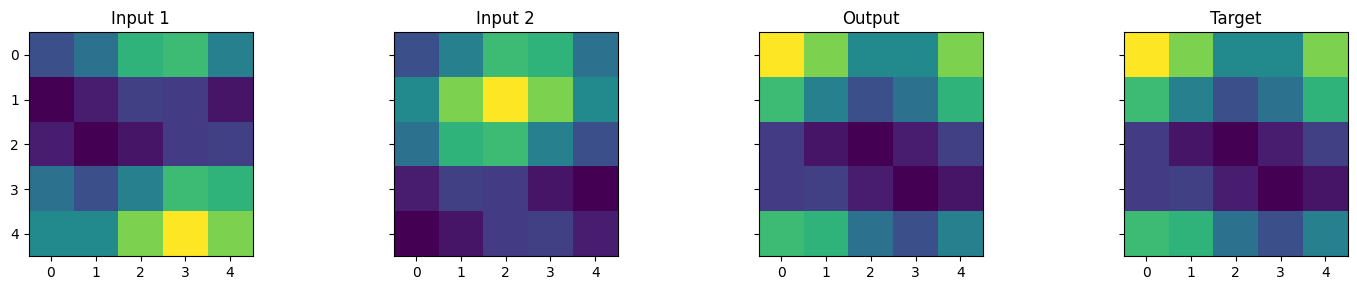

Epoch 10910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 10990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11000/50000, Loss: 0.000000


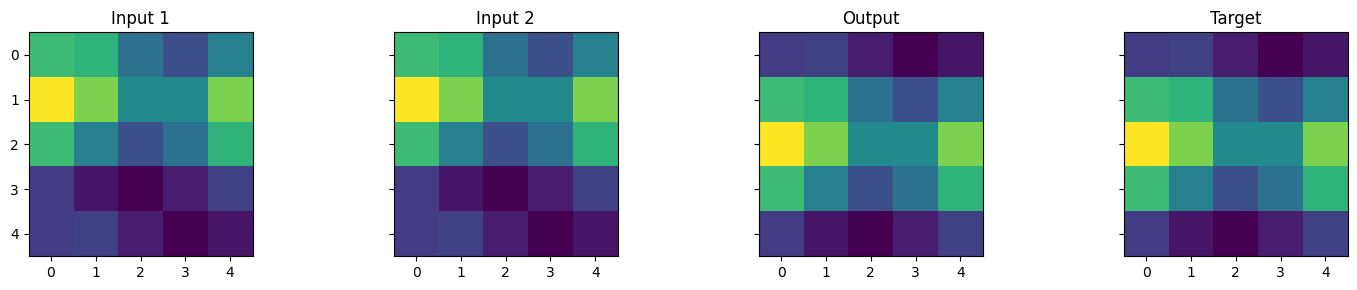

Epoch 11010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11100/50000, Loss: 0.000000


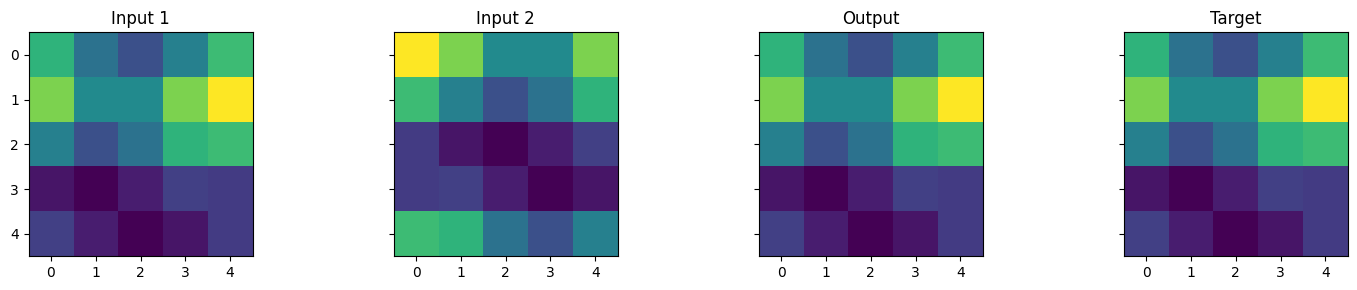

Epoch 11110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11200/50000, Loss: 0.000000


Epoch 11210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11300/50000, Loss: 0.000000


Epoch 11310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11400/50000, Loss: 0.000000


Epoch 11410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11500/50000, Loss: 0.000000


Epoch 11510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11600/50000, Loss: 0.000000


Epoch 11610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11700/50000, Loss: 0.000000


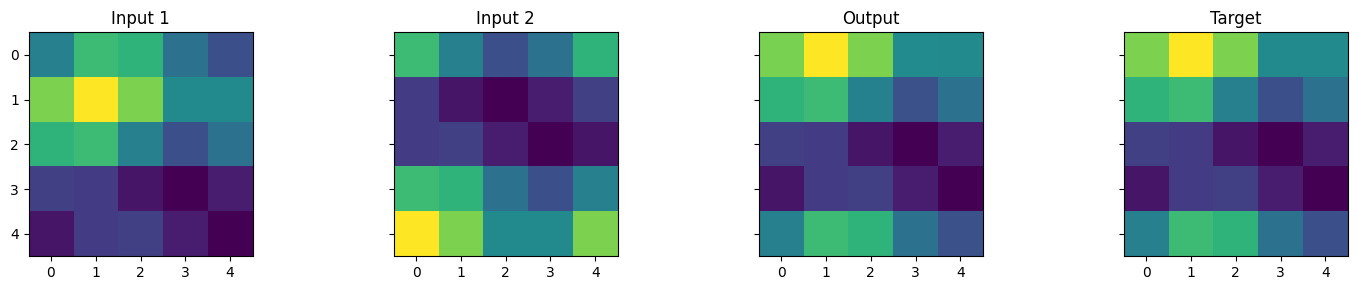

Epoch 11710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11800/50000, Loss: 0.000000


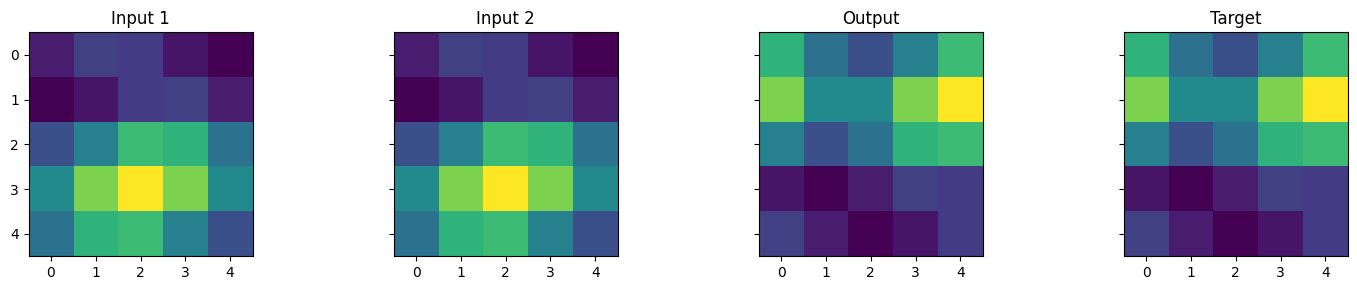

Epoch 11810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11900/50000, Loss: 0.000000


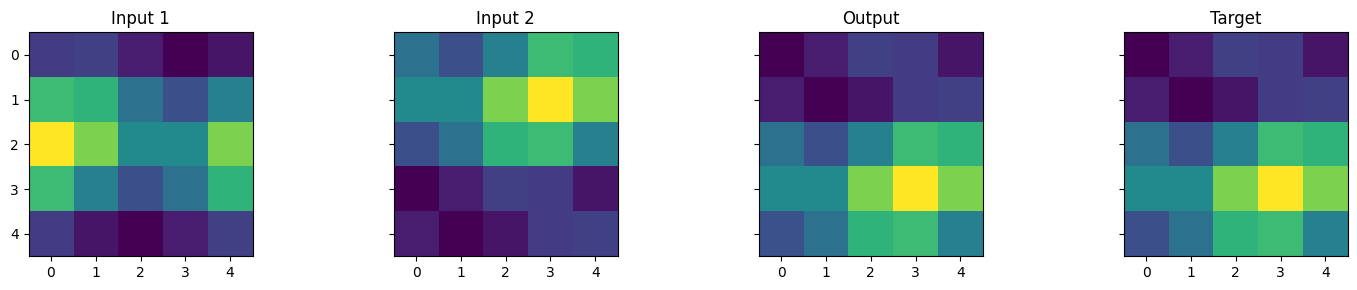

Epoch 11910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 11990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12000/50000, Loss: 0.000000


Epoch 12010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12100/50000, Loss: 0.000000


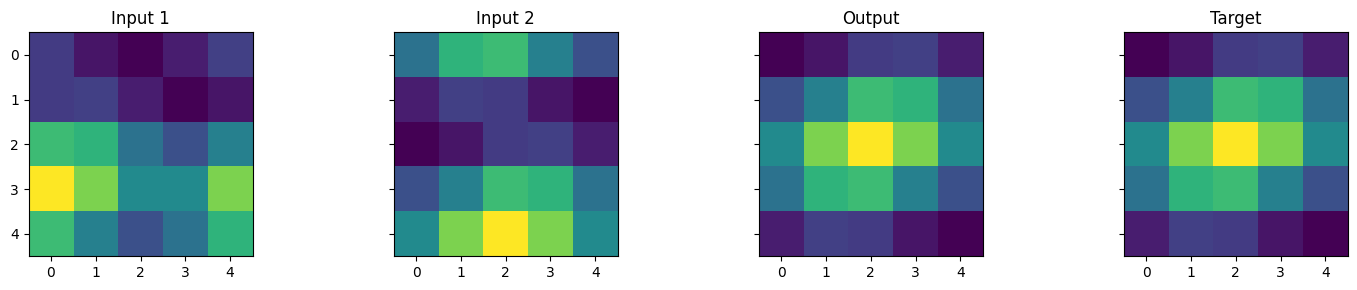

Epoch 12110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12200/50000, Loss: 0.000000


Epoch 12210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12300/50000, Loss: 0.000000


Epoch 12310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12400/50000, Loss: 0.000000


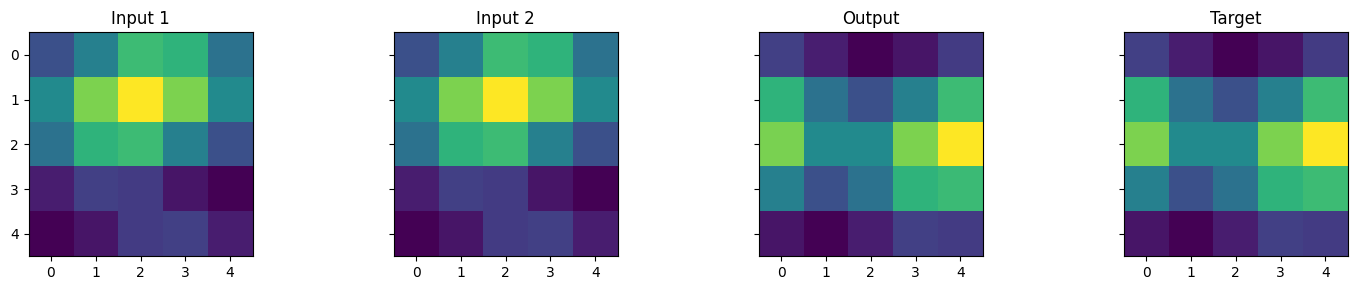

Epoch 12410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12500/50000, Loss: 0.000000


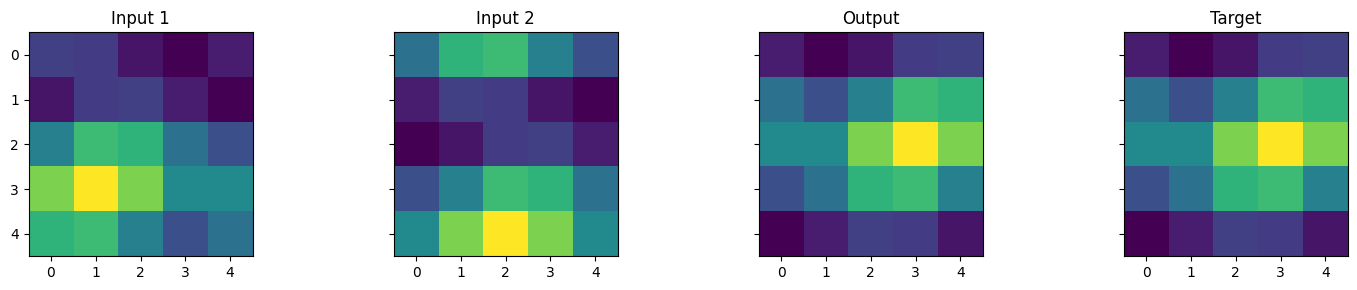

Epoch 12510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12600/50000, Loss: 0.000000


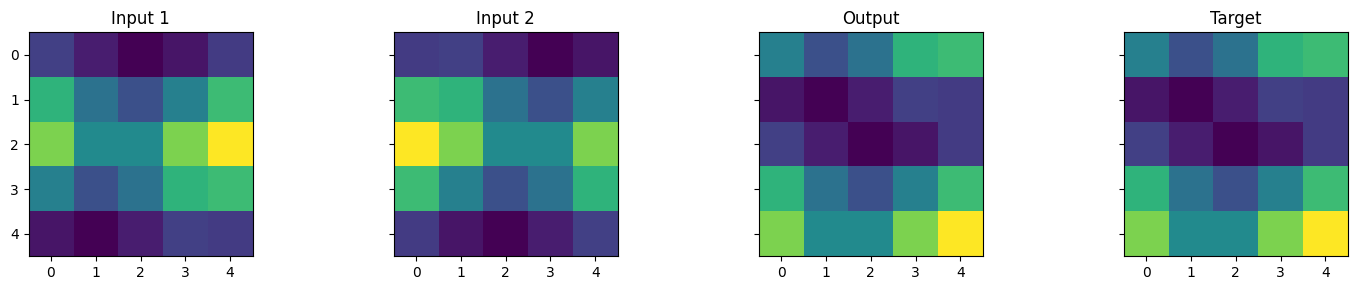

Epoch 12610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12700/50000, Loss: 0.000000


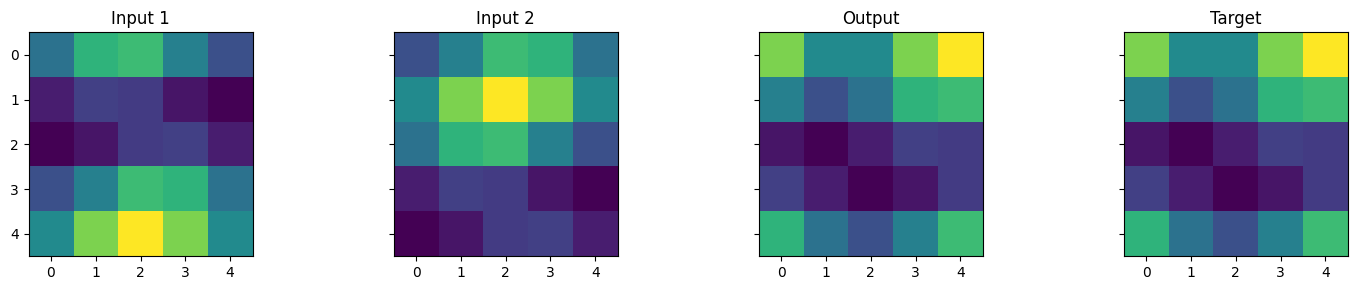

Epoch 12710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12800/50000, Loss: 0.000000


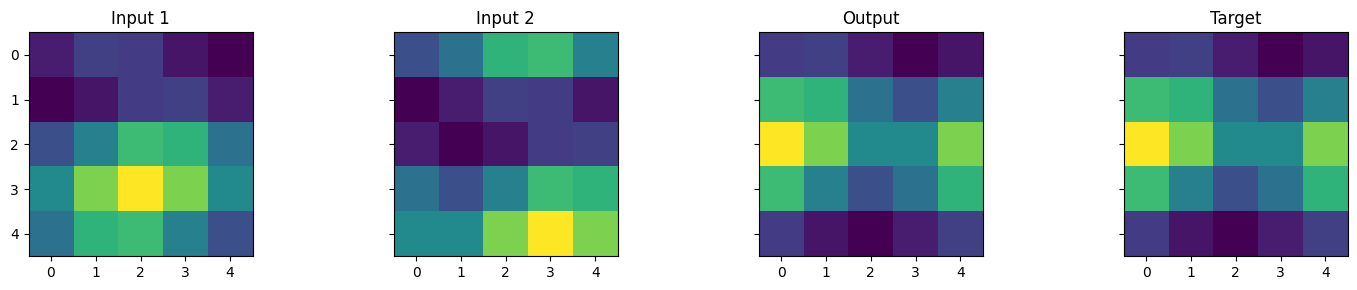

Epoch 12810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12900/50000, Loss: 0.000000


Epoch 12910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 12990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13000/50000, Loss: 0.000000


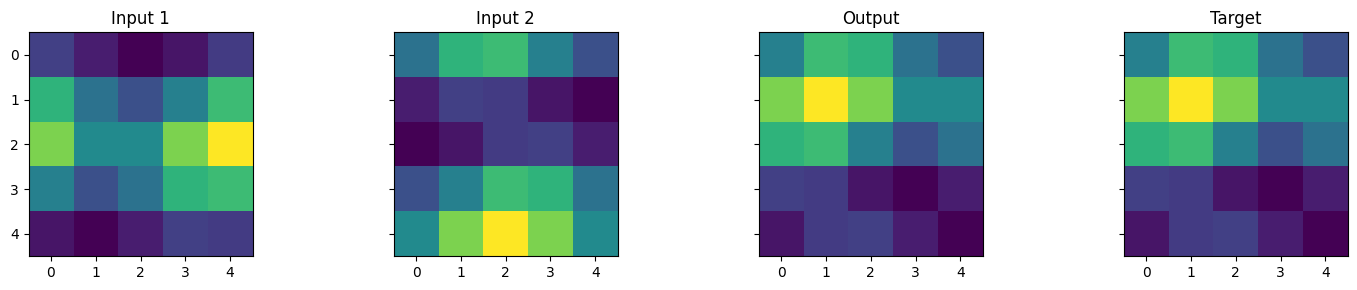

Epoch 13010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13100/50000, Loss: 0.000000


Epoch 13110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13200/50000, Loss: 0.000000


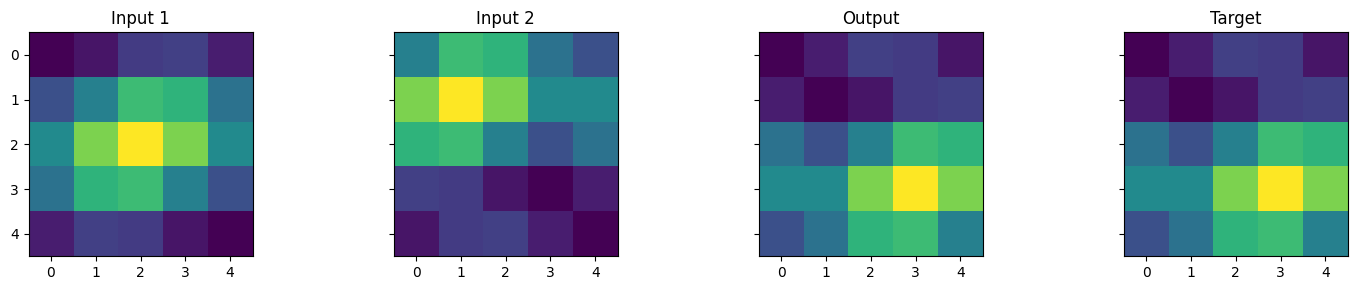

Epoch 13210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13300/50000, Loss: 0.000001


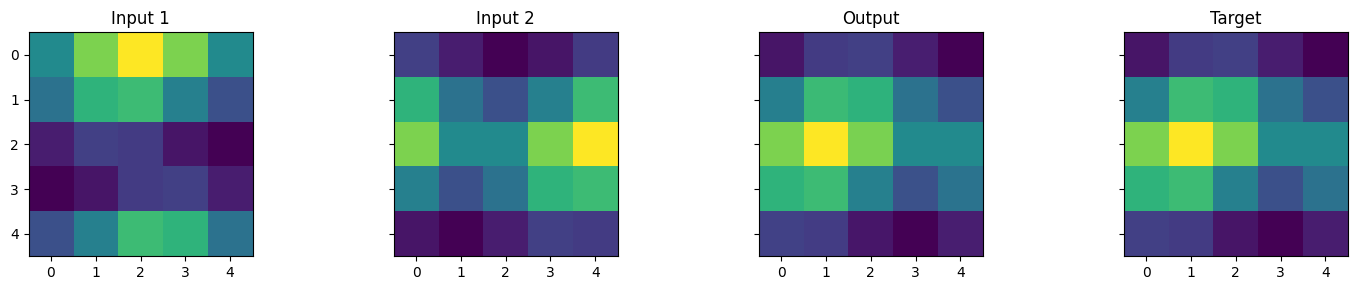

Epoch 13310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13400/50000, Loss: 0.000000


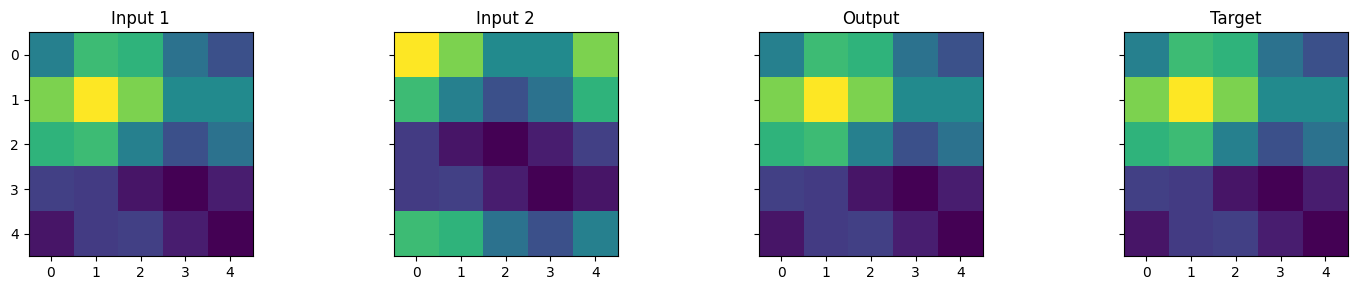

Epoch 13410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13500/50000, Loss: 0.000001


Epoch 13510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13600/50000, Loss: 0.000000


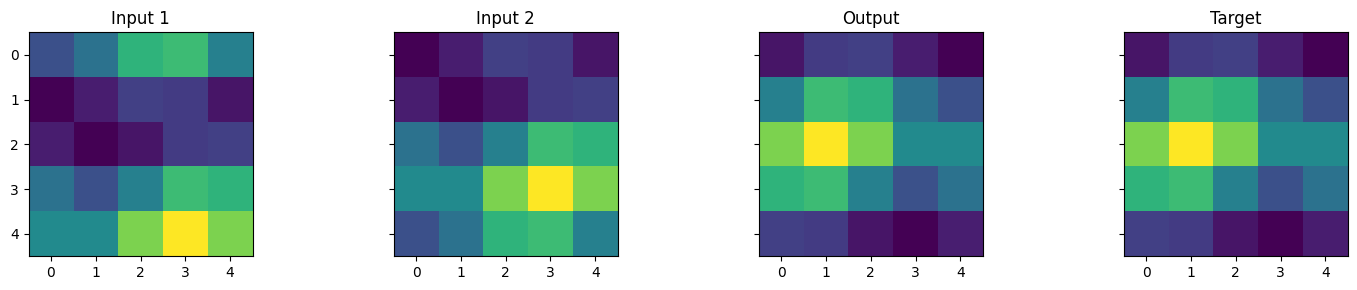

Epoch 13610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13700/50000, Loss: 0.000000


Epoch 13710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13800/50000, Loss: 0.000000


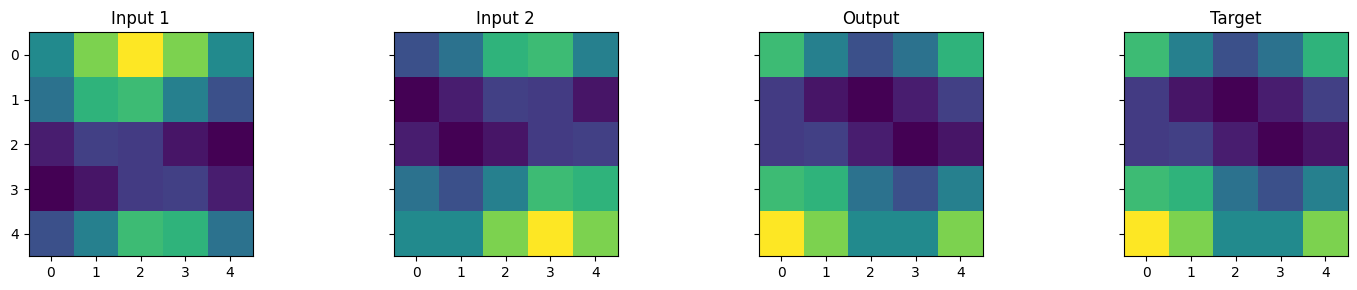

Epoch 13810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13900/50000, Loss: 0.000000


Epoch 13910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 13990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14000/50000, Loss: 0.000000


Epoch 14010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14100/50000, Loss: 0.000000


Epoch 14110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14200/50000, Loss: 0.000000


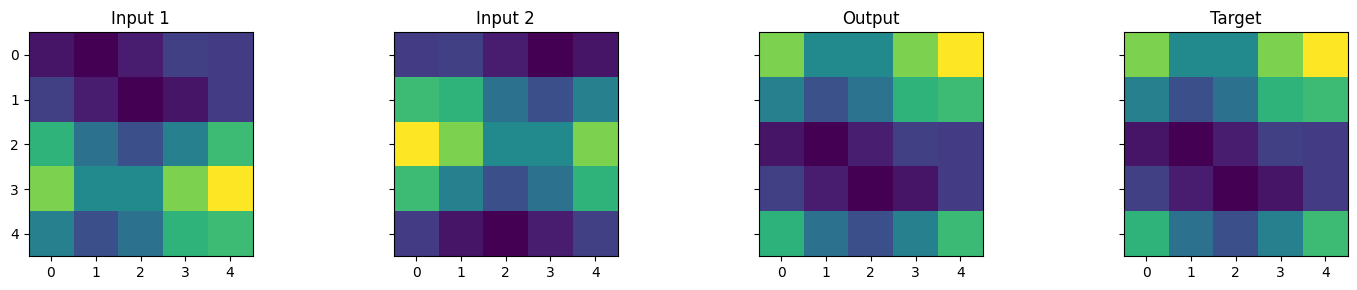

Epoch 14210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14300/50000, Loss: 0.000000


Epoch 14310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14400/50000, Loss: 0.000000


Epoch 14410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14500/50000, Loss: 0.000000


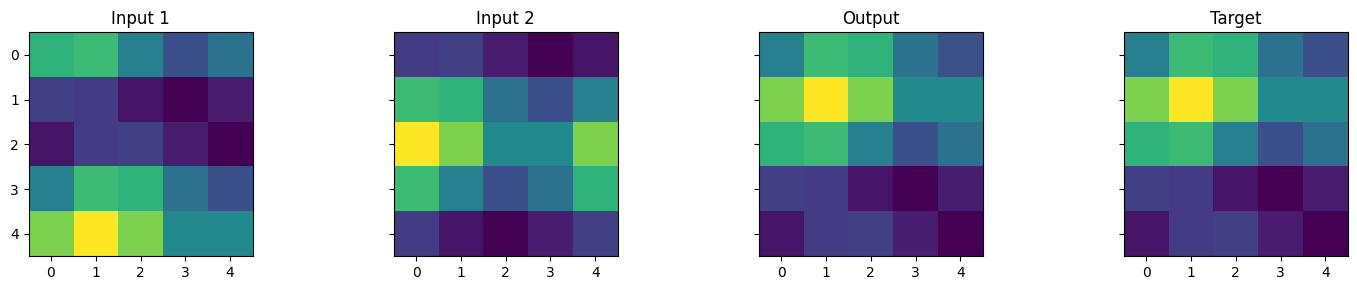

Epoch 14510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14600/50000, Loss: 0.000000


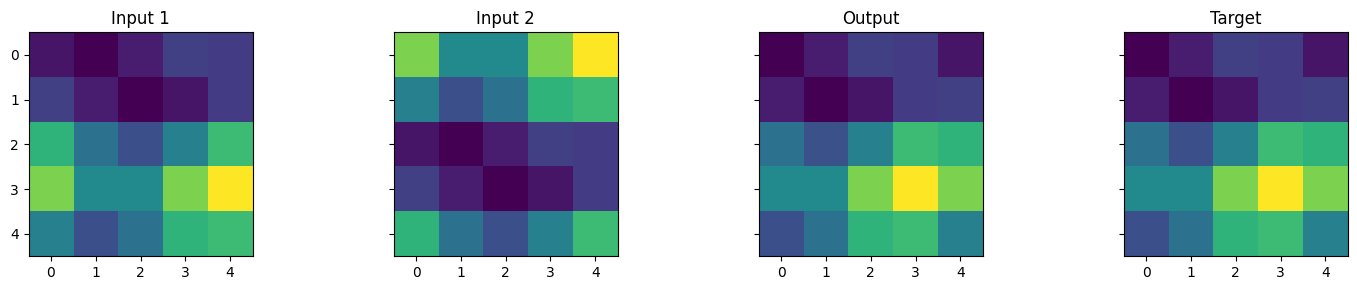

Epoch 14610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14700/50000, Loss: 0.000000


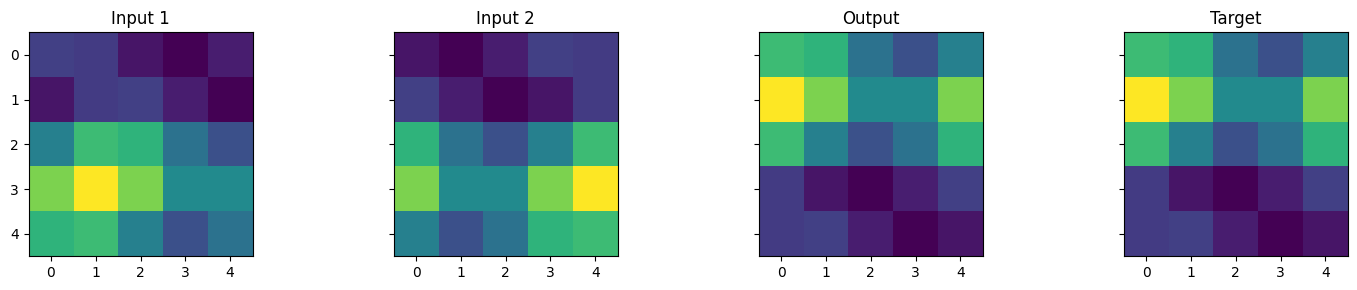

Epoch 14710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14800/50000, Loss: 0.000000


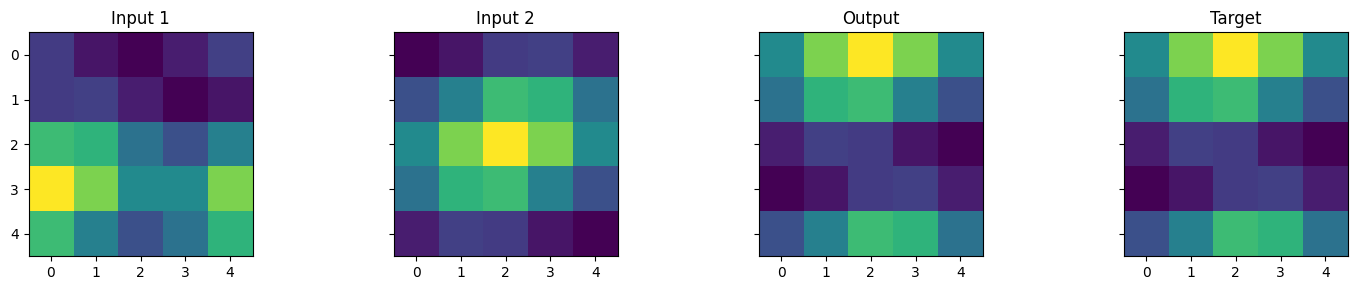

Epoch 14810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14900/50000, Loss: 0.000000


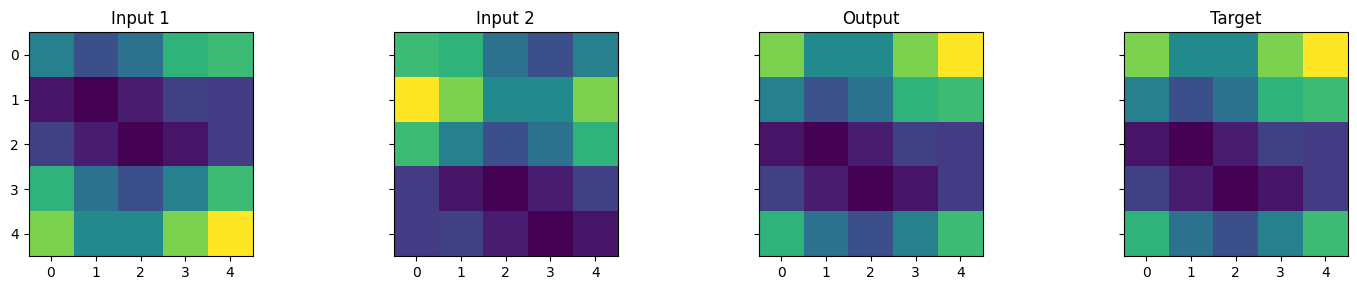

Epoch 14910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 14990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15000/50000, Loss: 0.000000


Epoch 15010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15100/50000, Loss: 0.000000


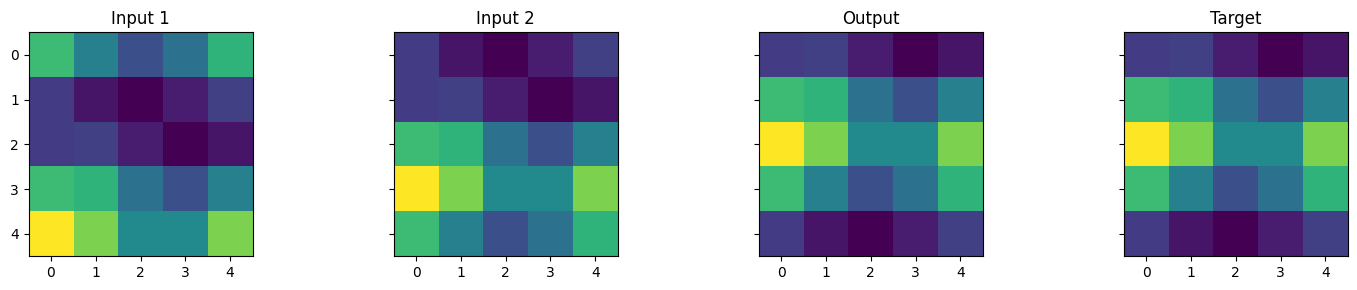

Epoch 15110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15200/50000, Loss: 0.000000


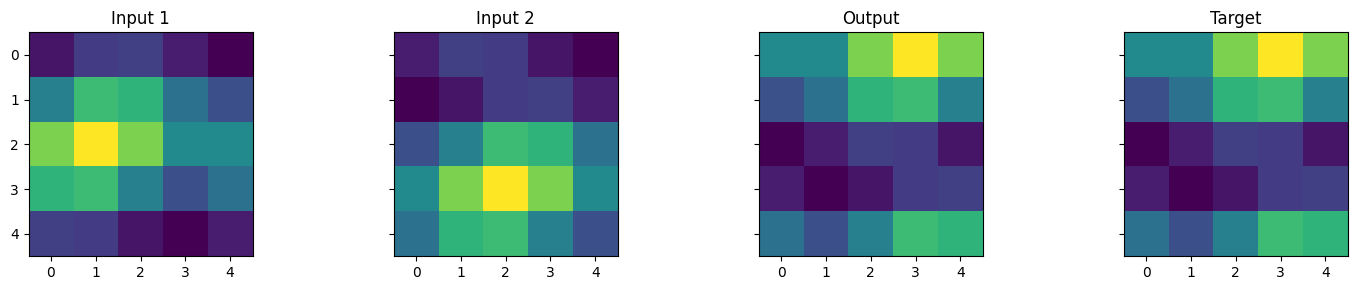

Epoch 15210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15300/50000, Loss: 0.000000


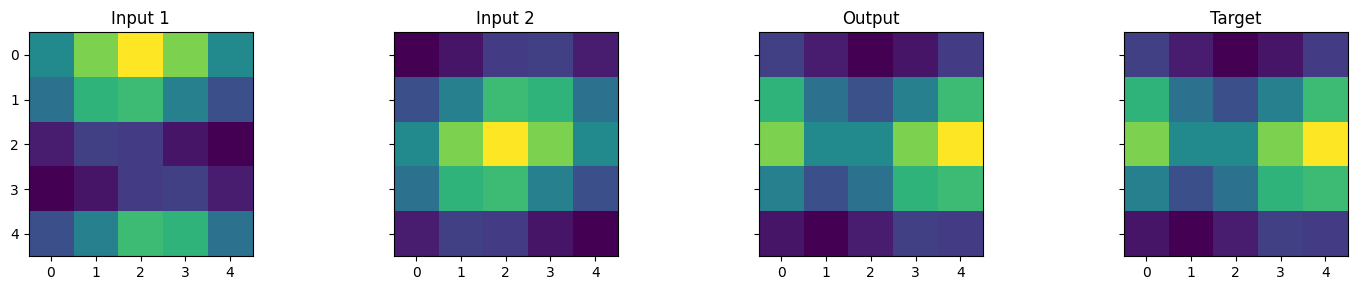

Epoch 15310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15400/50000, Loss: 0.000000


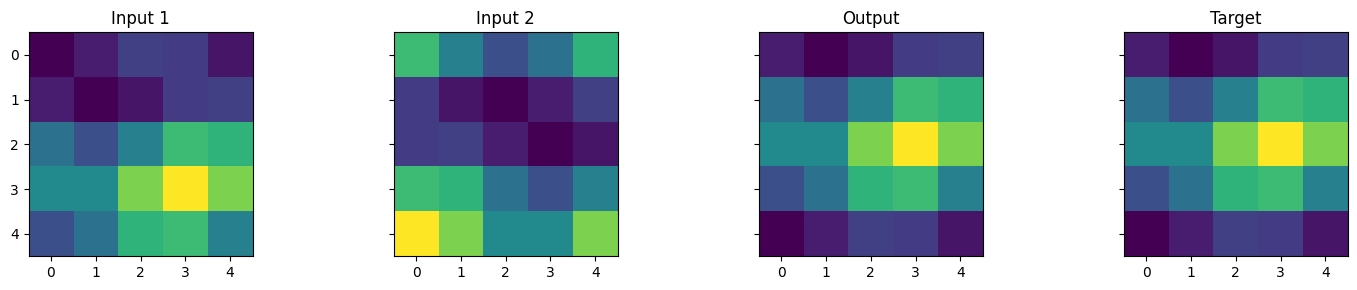

Epoch 15410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15500/50000, Loss: 0.000000


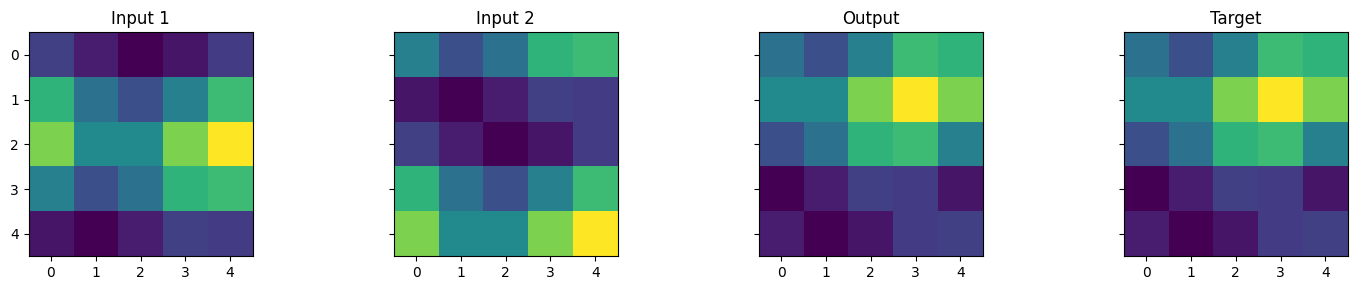

Epoch 15510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15600/50000, Loss: 0.000000


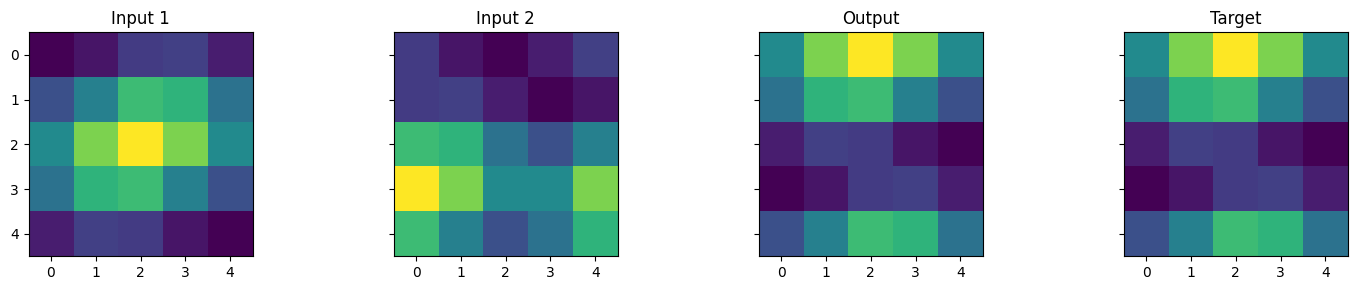

Epoch 15610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15700/50000, Loss: 0.000000


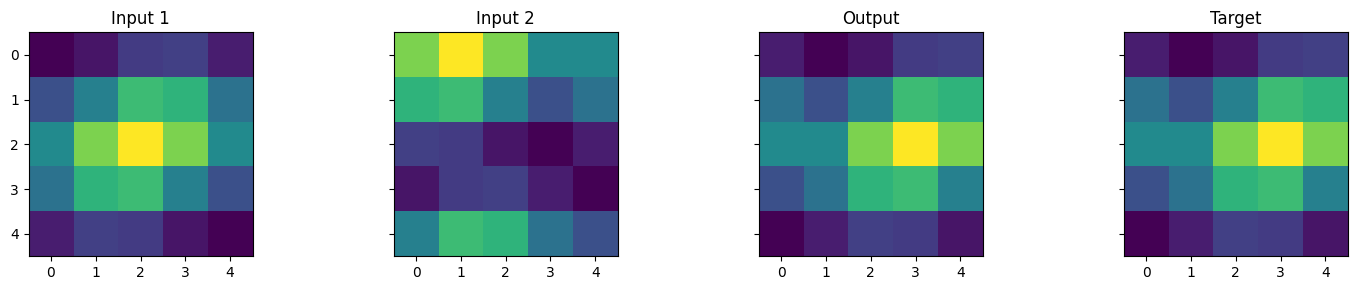

Epoch 15710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15800/50000, Loss: 0.000000


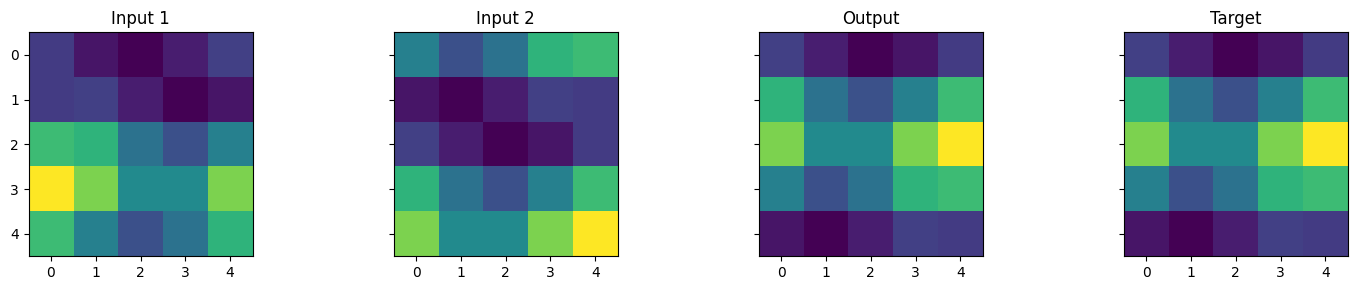

Epoch 15810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15900/50000, Loss: 0.000000


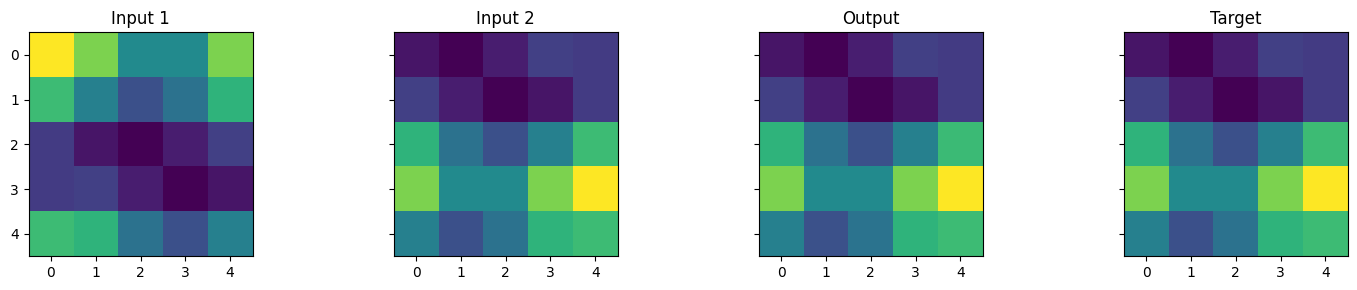

Epoch 15910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 15990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16000/50000, Loss: 0.000000


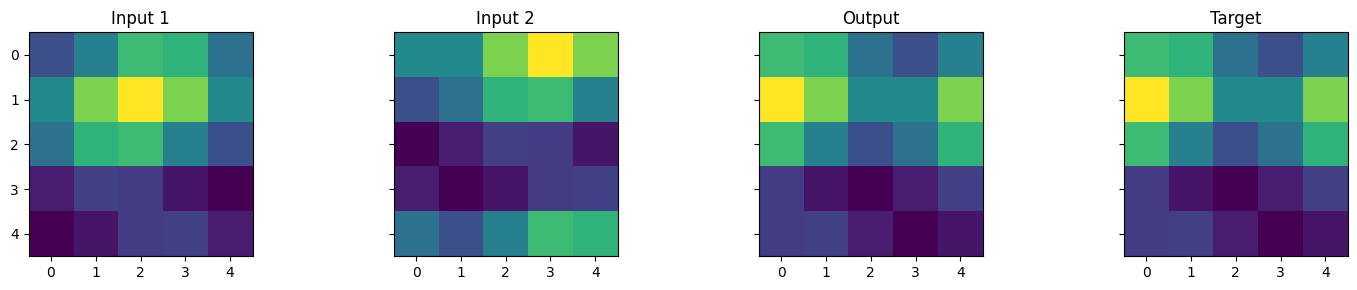

Epoch 16010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16100/50000, Loss: 0.000000


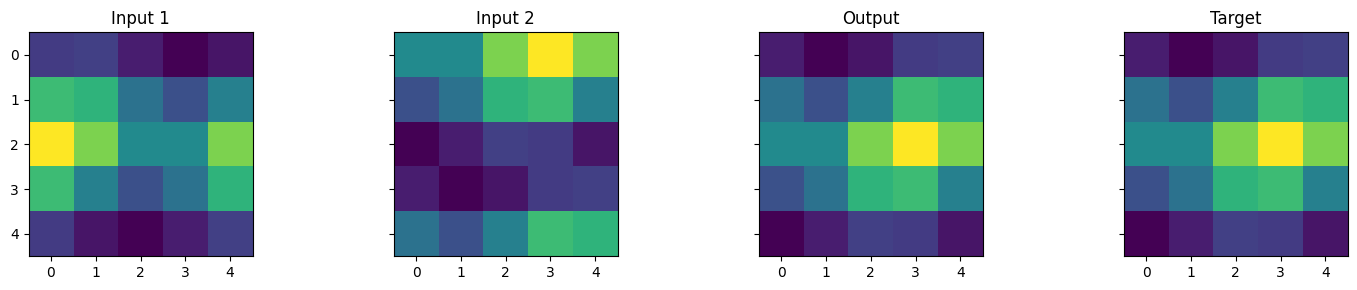

Epoch 16110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16200/50000, Loss: 0.000000


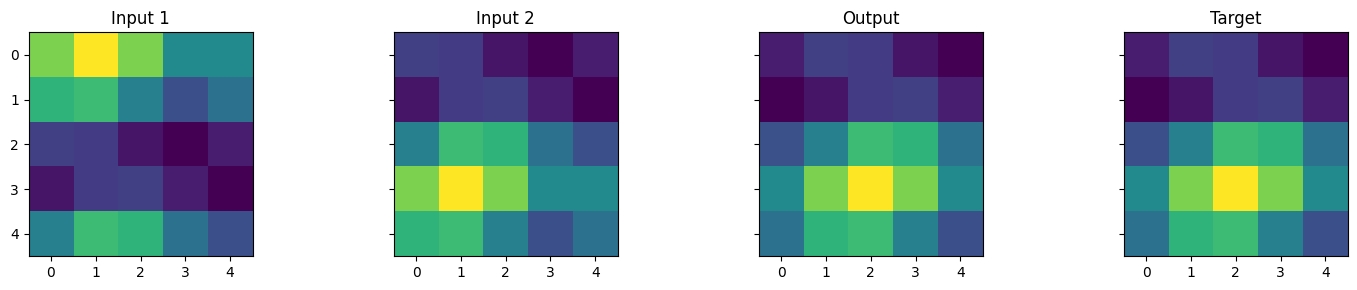

Epoch 16210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16300/50000, Loss: 0.000000


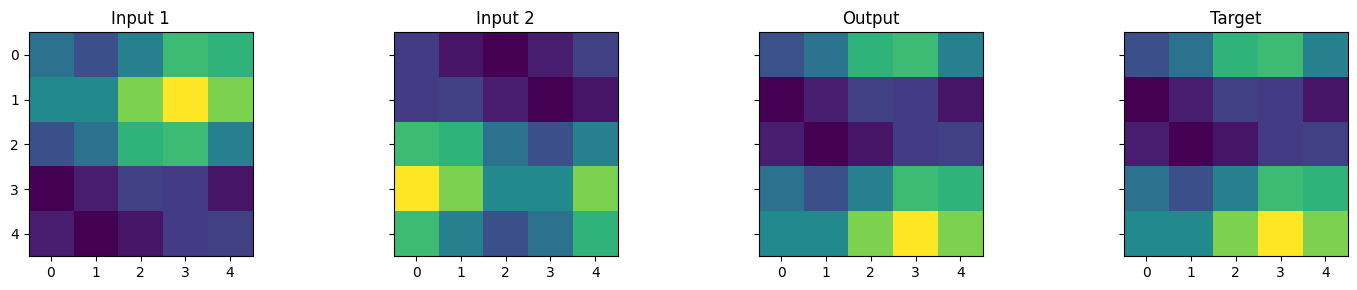

Epoch 16310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16400/50000, Loss: 0.000000


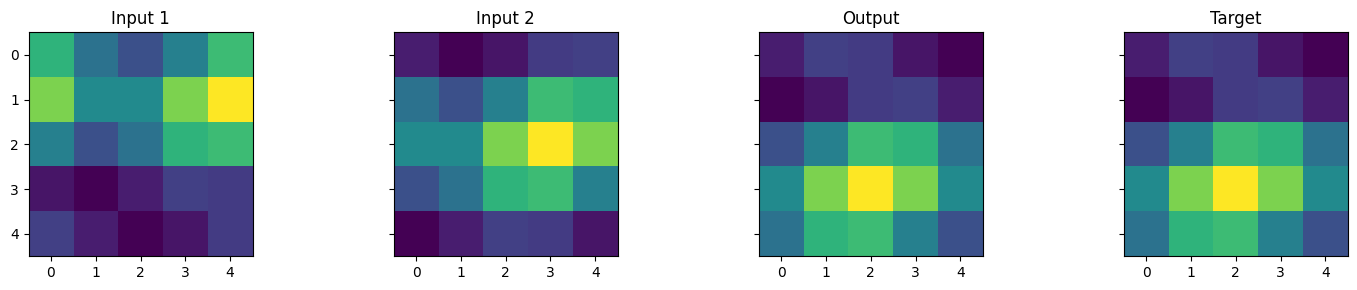

Epoch 16410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16500/50000, Loss: 0.000000


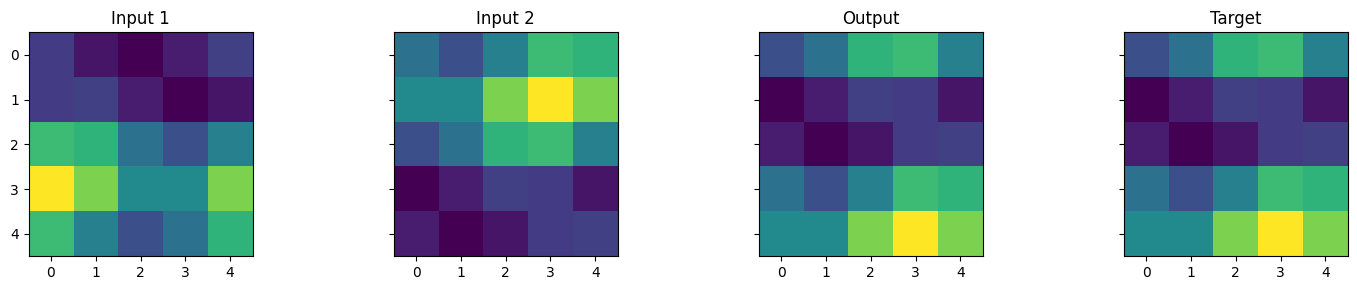

Epoch 16510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16600/50000, Loss: 0.000000


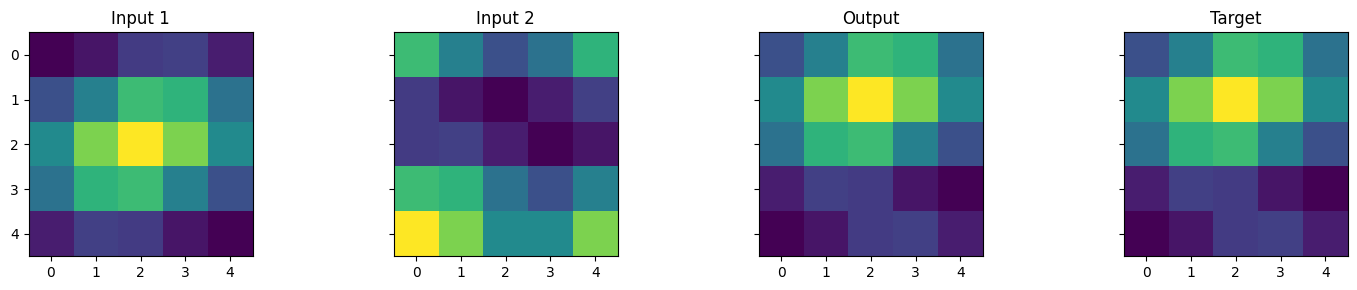

Epoch 16610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16700/50000, Loss: 0.000000


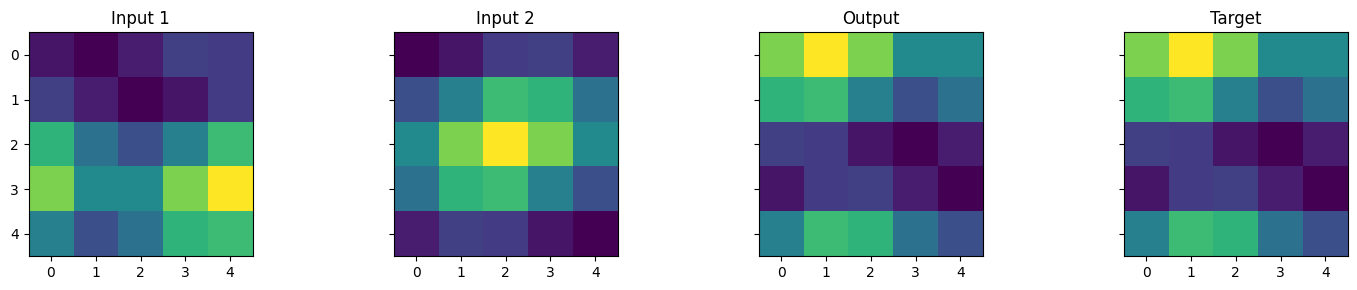

Epoch 16710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16800/50000, Loss: 0.000000


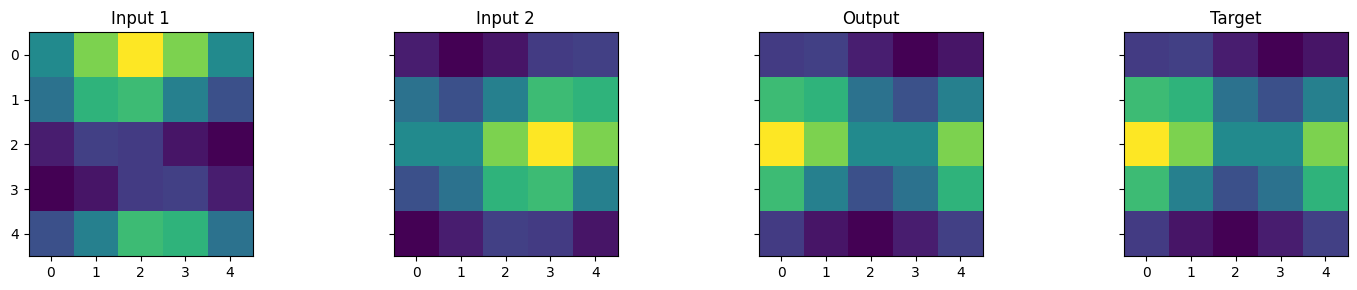

Epoch 16810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16900/50000, Loss: 0.000000


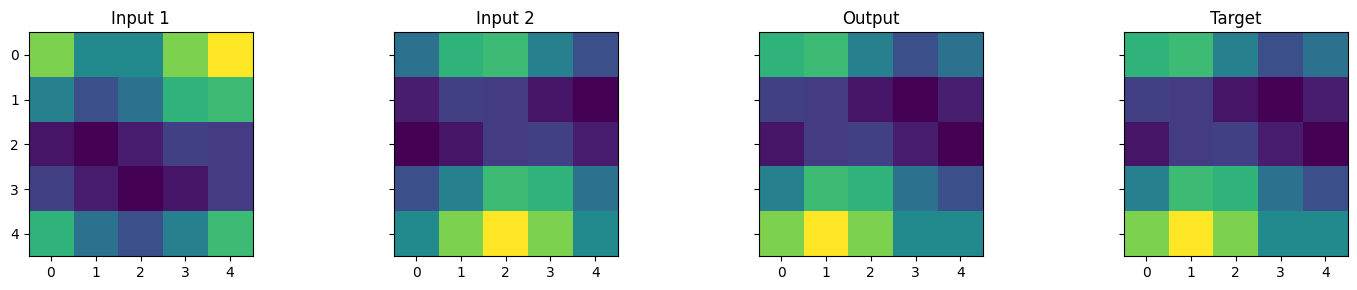

Epoch 16910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 16990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17000/50000, Loss: 0.000000


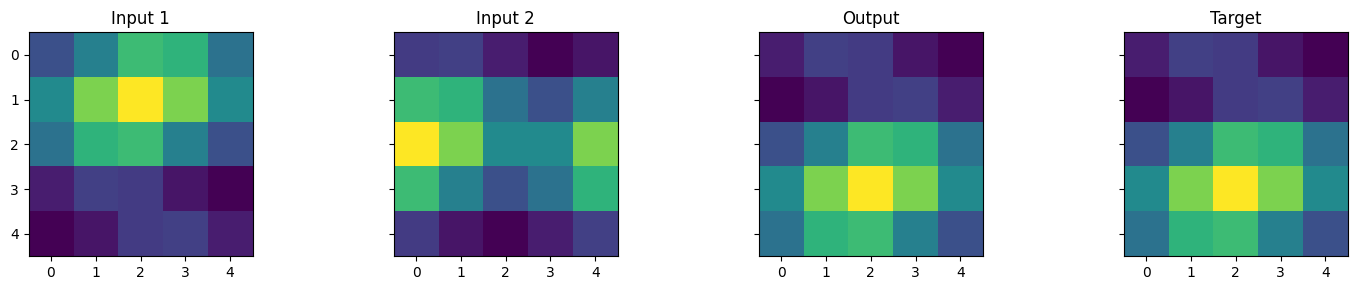

Epoch 17010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17100/50000, Loss: 0.000000


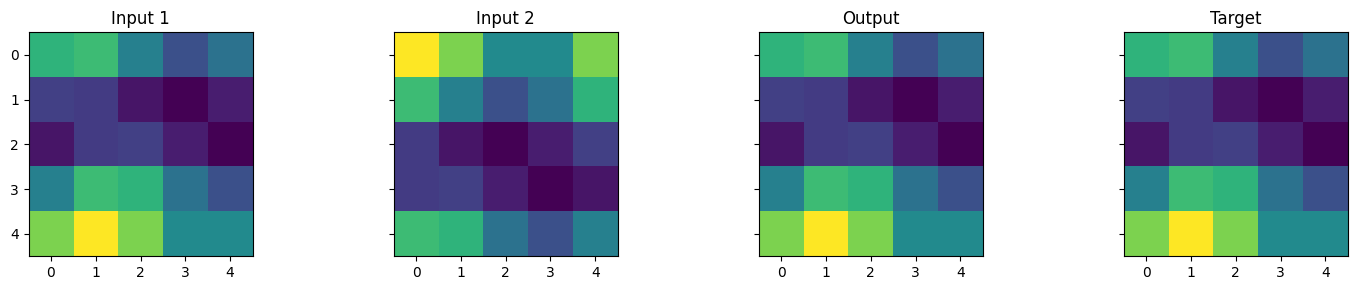

Epoch 17110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17200/50000, Loss: 0.000000


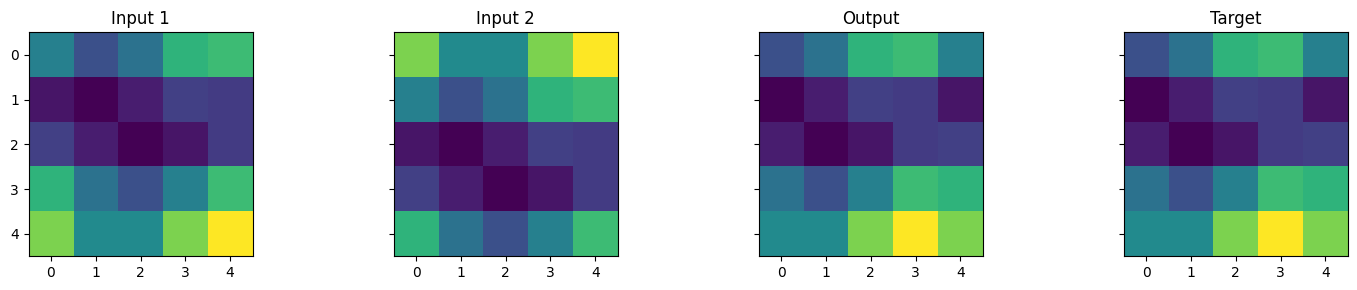

Epoch 17210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17300/50000, Loss: 0.000000


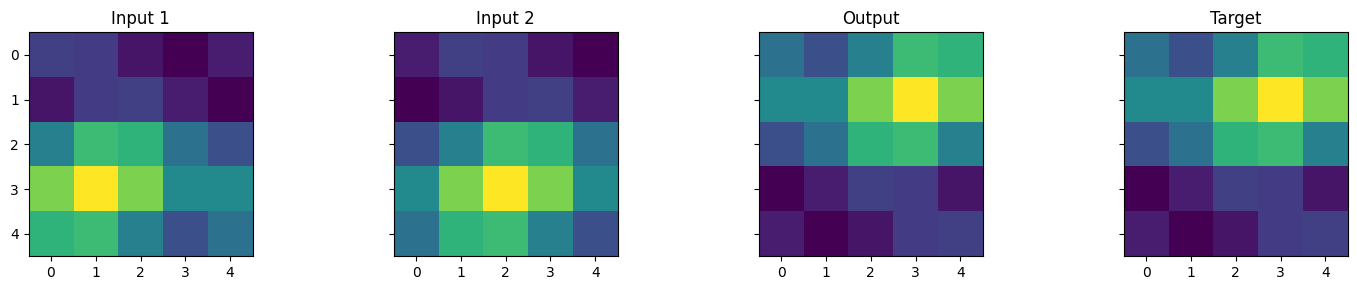

Epoch 17310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17400/50000, Loss: 0.000000


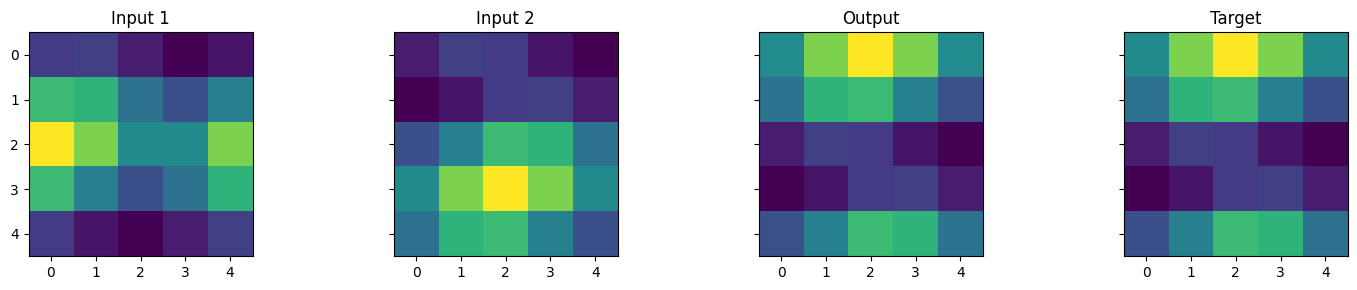

Epoch 17410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17500/50000, Loss: 0.000000


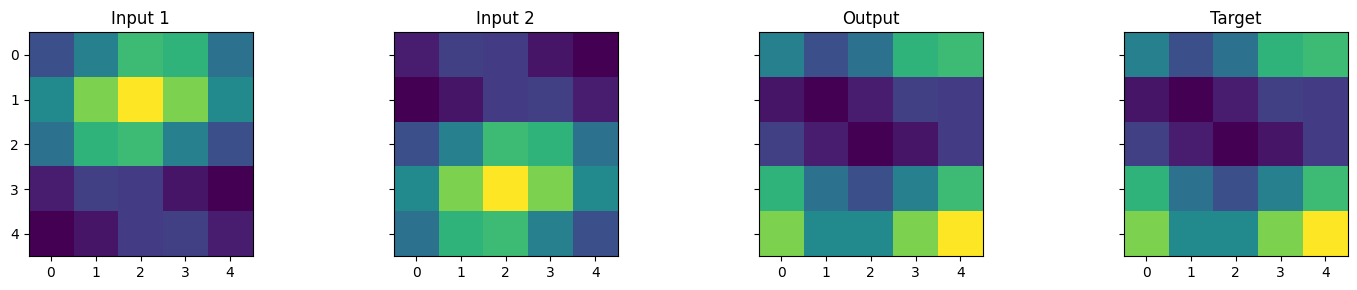

Epoch 17510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17600/50000, Loss: 0.000000


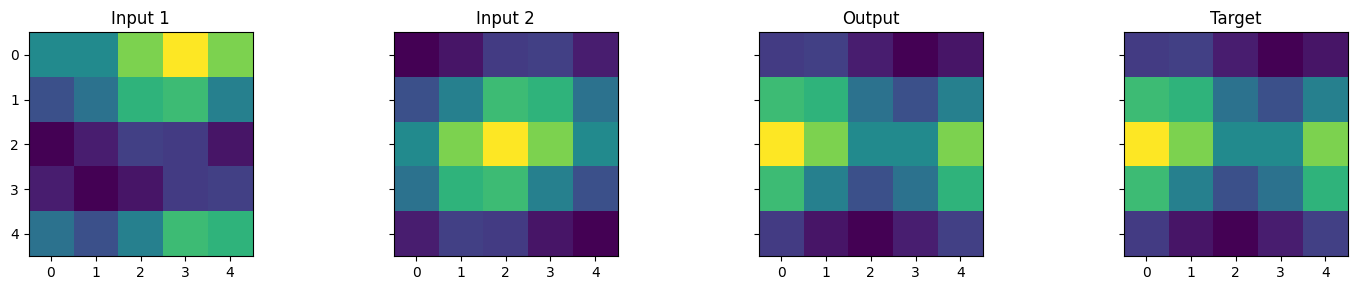

Epoch 17610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17700/50000, Loss: 0.000000


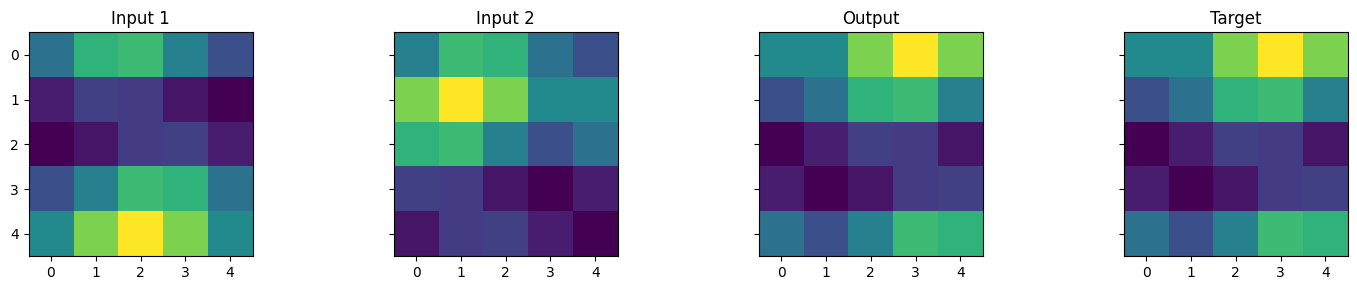

Epoch 17710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17800/50000, Loss: 0.000000


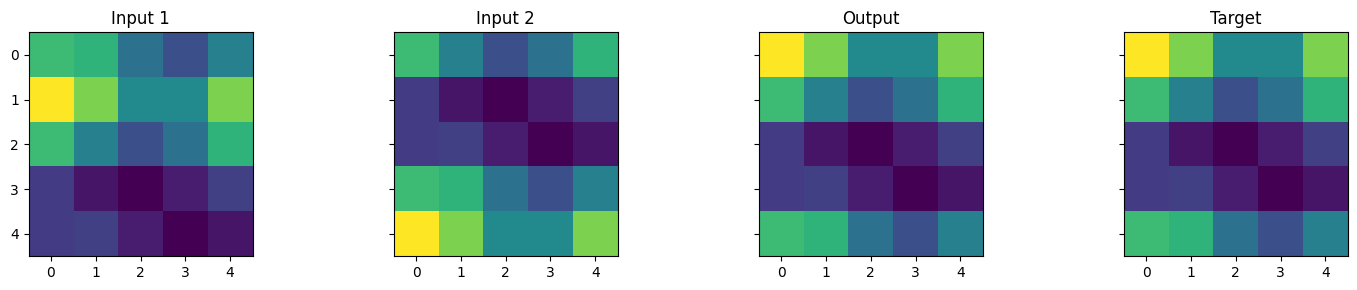

Epoch 17810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17900/50000, Loss: 0.000000


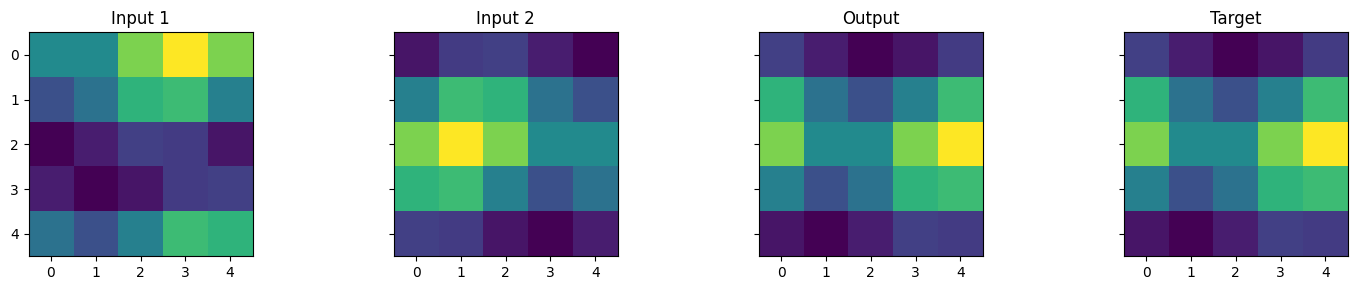

Epoch 17910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 17990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18000/50000, Loss: 0.000000


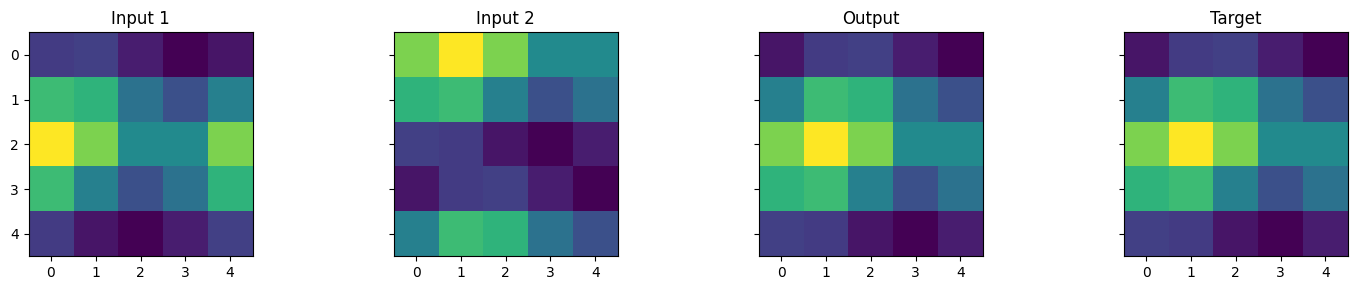

Epoch 18010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18100/50000, Loss: 0.000000


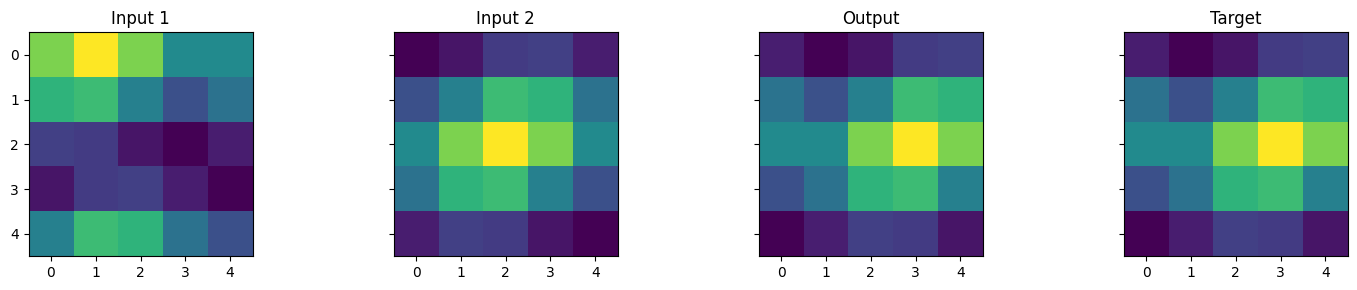

Epoch 18110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18200/50000, Loss: 0.000000


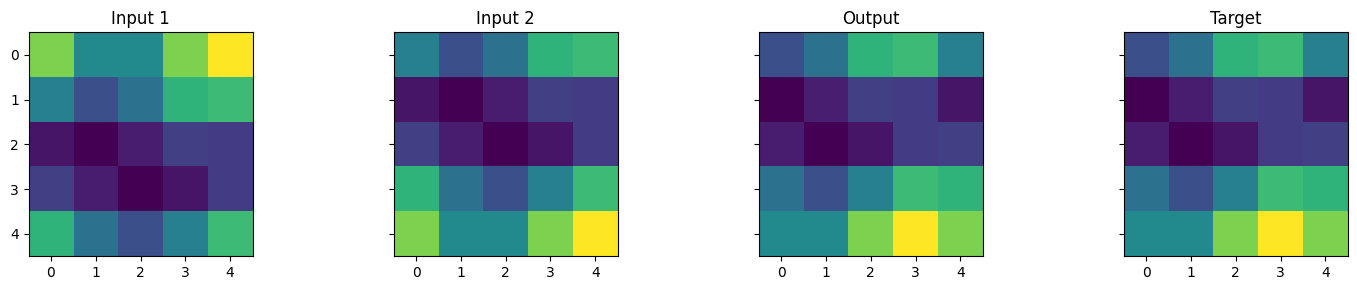

Epoch 18210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18300/50000, Loss: 0.000000


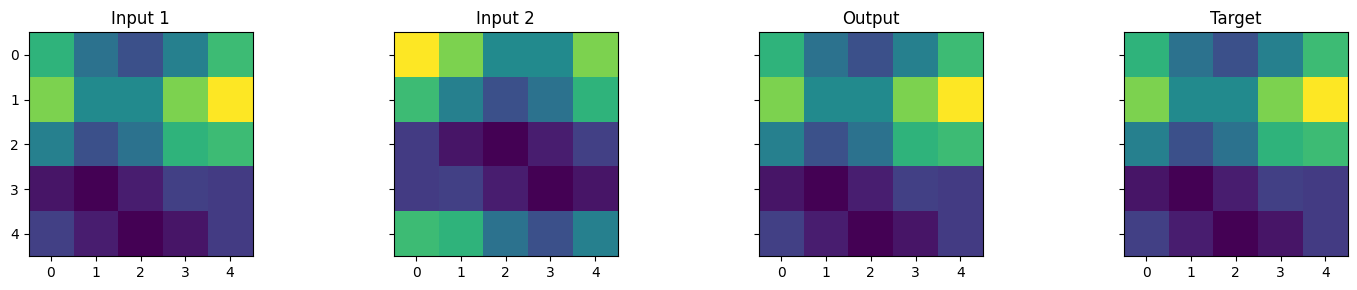

Epoch 18310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18400/50000, Loss: 0.000000


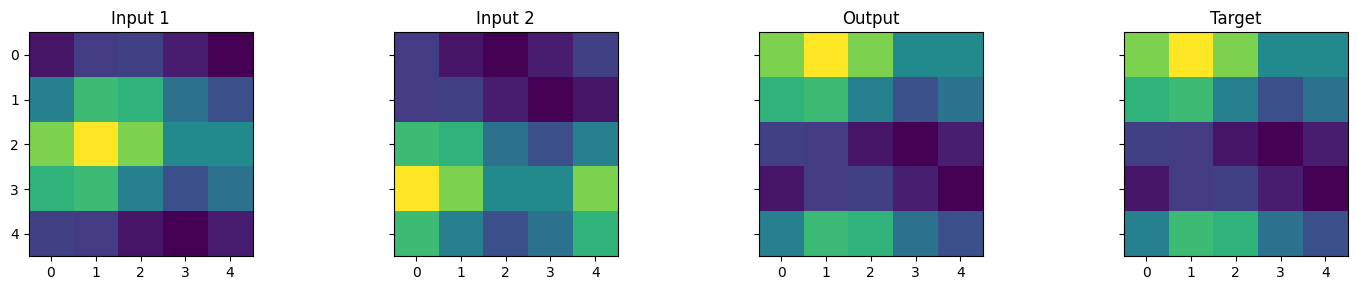

Epoch 18410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18500/50000, Loss: 0.000000


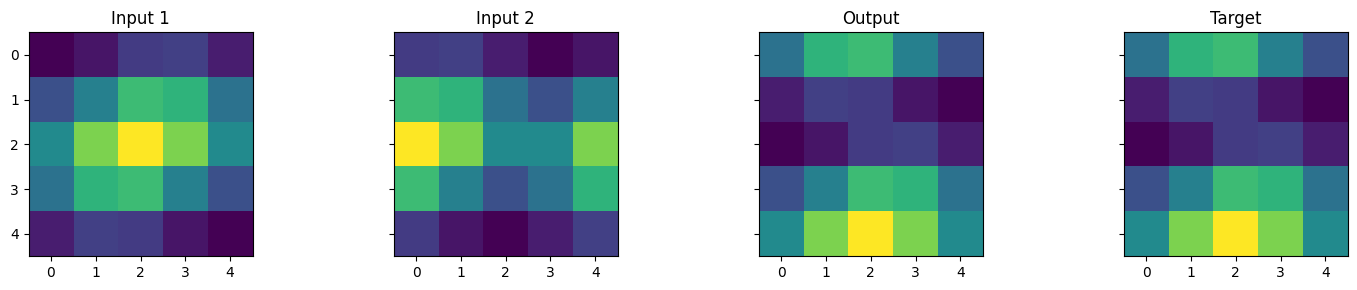

Epoch 18510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18600/50000, Loss: 0.000000


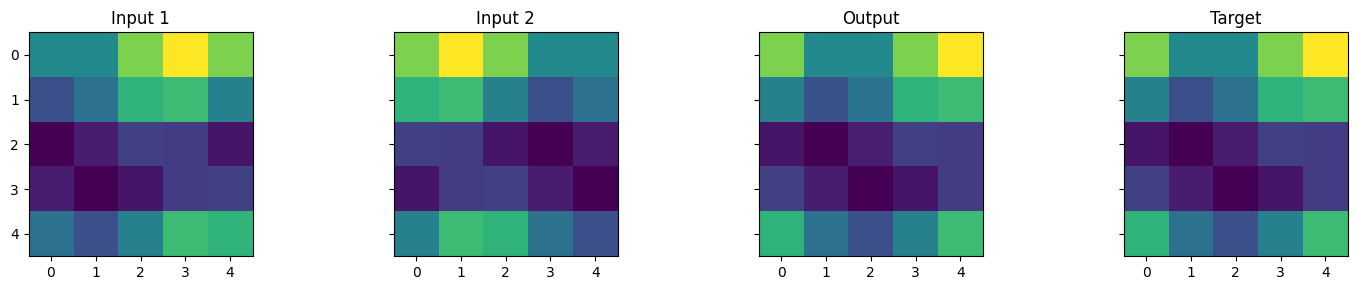

Epoch 18610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18700/50000, Loss: 0.000000


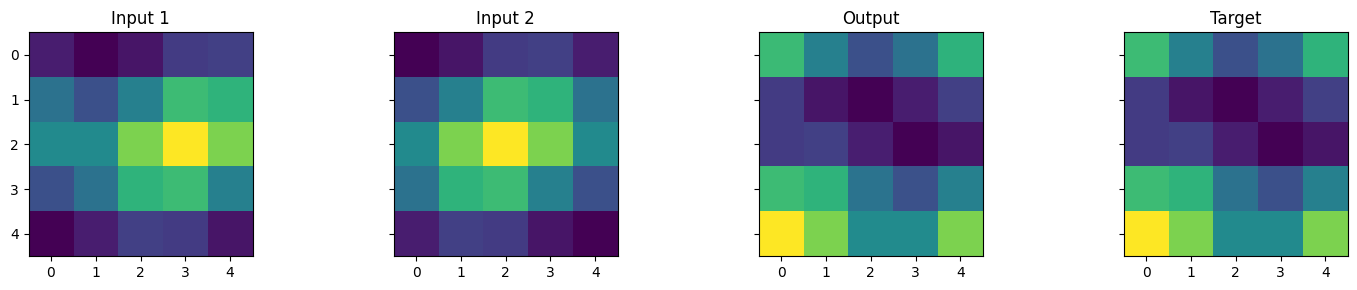

Epoch 18710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18800/50000, Loss: 0.000000


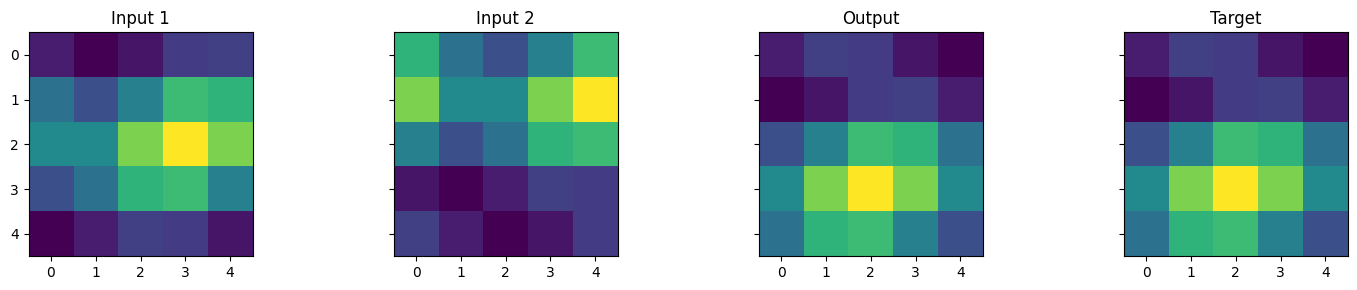

Epoch 18810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18900/50000, Loss: 0.000000


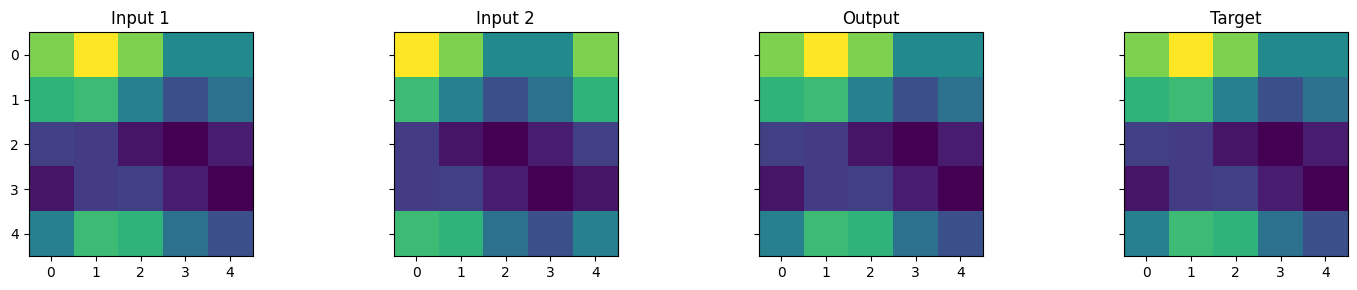

Epoch 18910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 18990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19000/50000, Loss: 0.000000


Epoch 19010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19100/50000, Loss: 0.000000


Epoch 19110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19200/50000, Loss: 0.000000


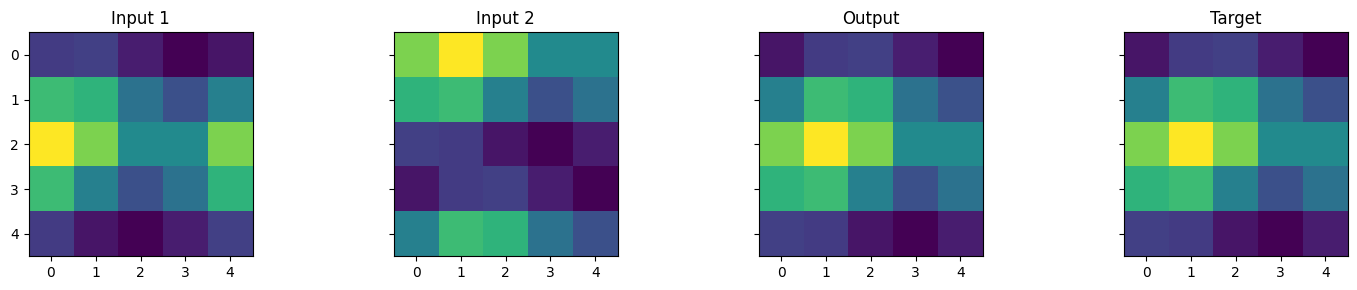

Epoch 19210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19300/50000, Loss: 0.000000


Epoch 19310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19400/50000, Loss: 0.000000


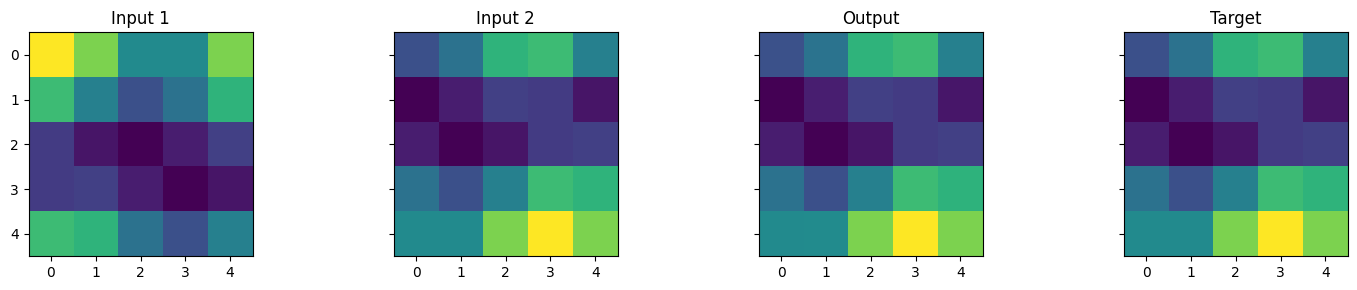

Epoch 19410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19500/50000, Loss: 0.000000


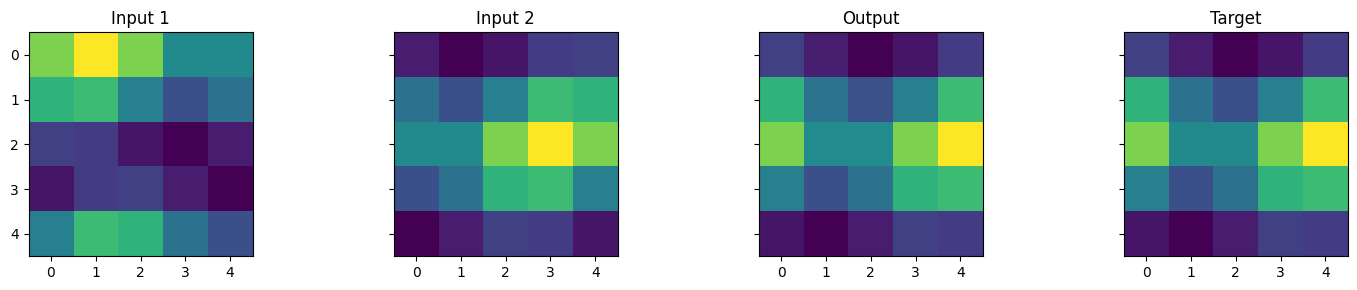

Epoch 19510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19600/50000, Loss: 0.000001


Epoch 19610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19700/50000, Loss: 0.000000


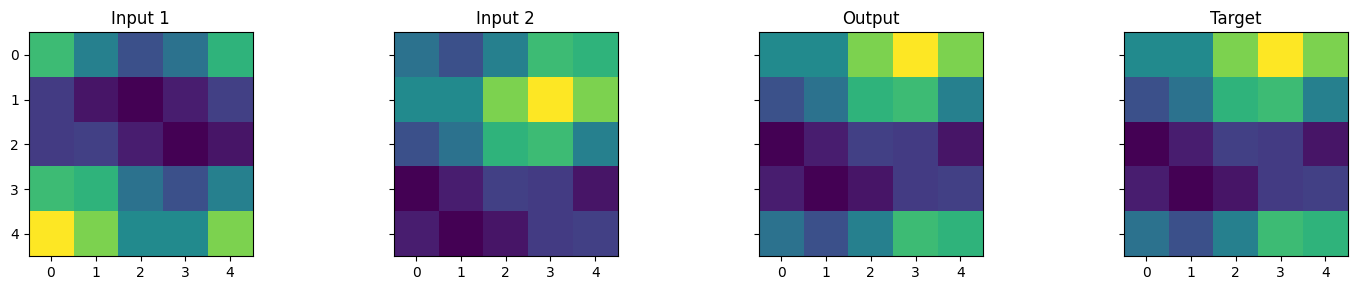

Epoch 19710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19800/50000, Loss: 0.000000


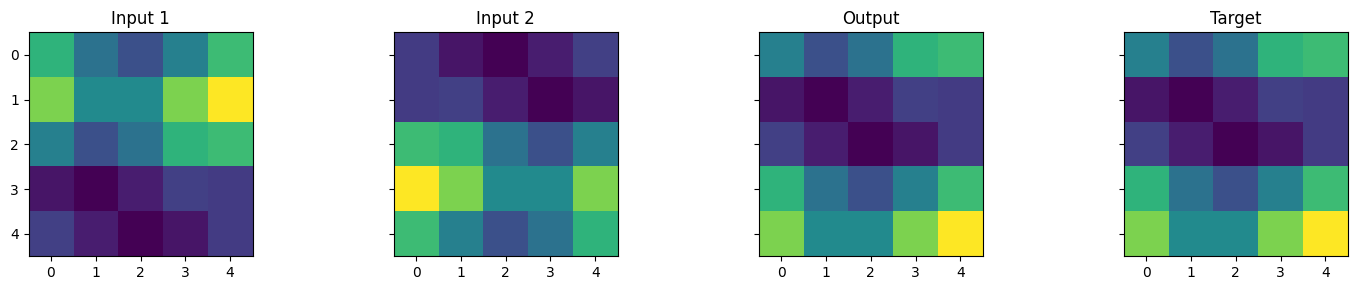

Epoch 19810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19900/50000, Loss: 0.000000


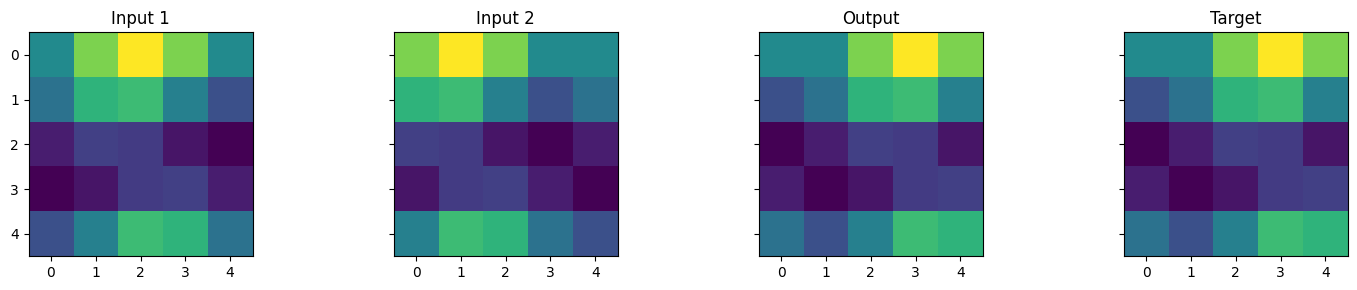

Epoch 19910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 19990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20000/50000, Loss: 0.000000


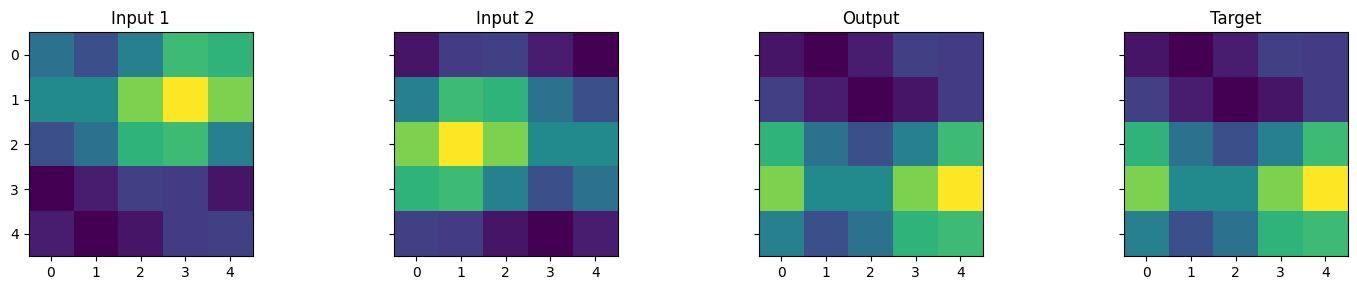

Epoch 20010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20100/50000, Loss: 0.000000


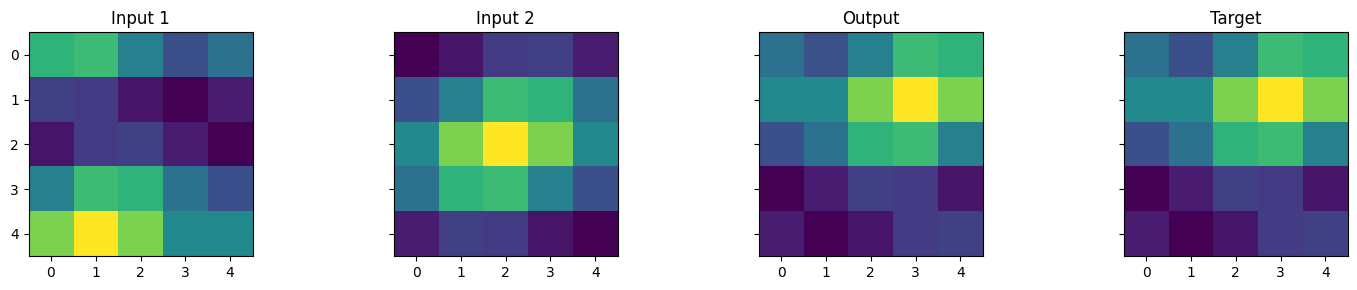

Epoch 20110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20200/50000, Loss: 0.000000


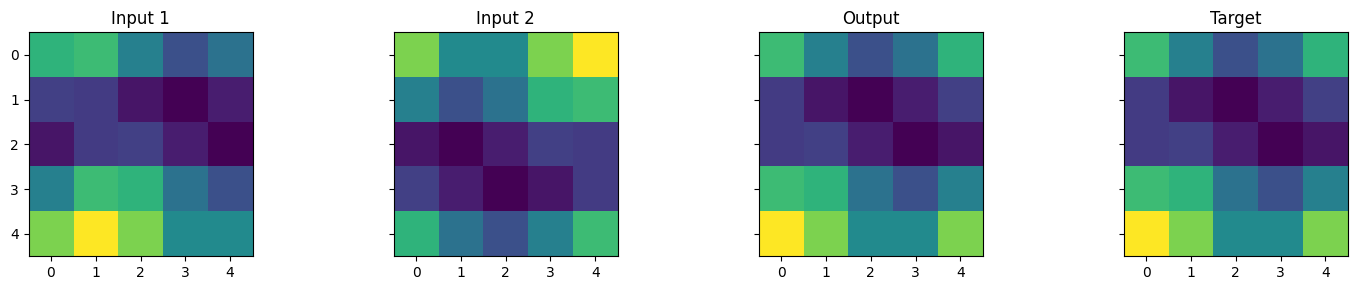

Epoch 20210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20300/50000, Loss: 0.000000


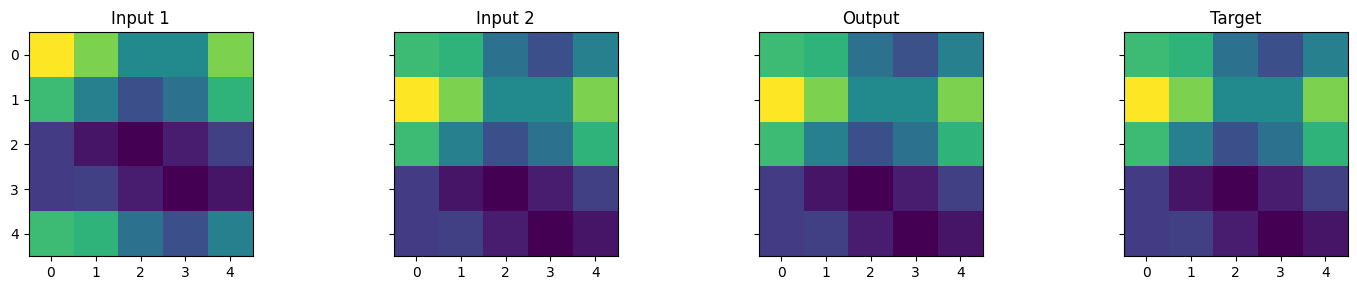

Epoch 20310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20400/50000, Loss: 0.000000


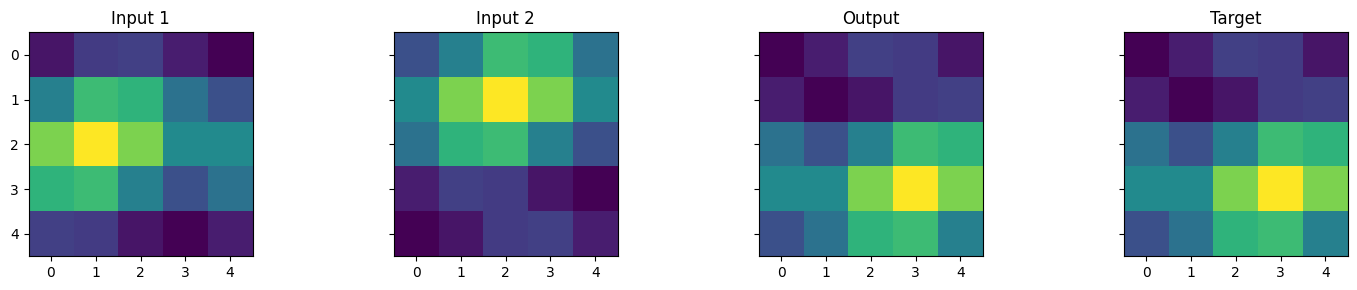

Epoch 20410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20500/50000, Loss: 0.000000


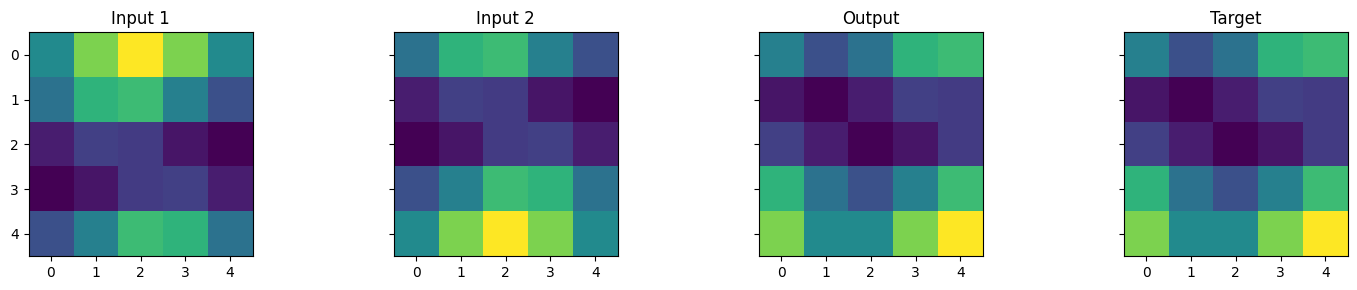

Epoch 20510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20600/50000, Loss: 0.000000


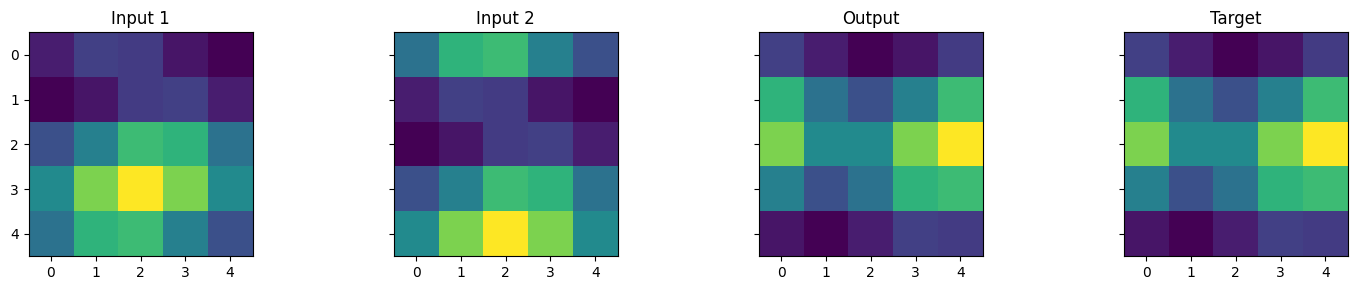

Epoch 20610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20700/50000, Loss: 0.000000


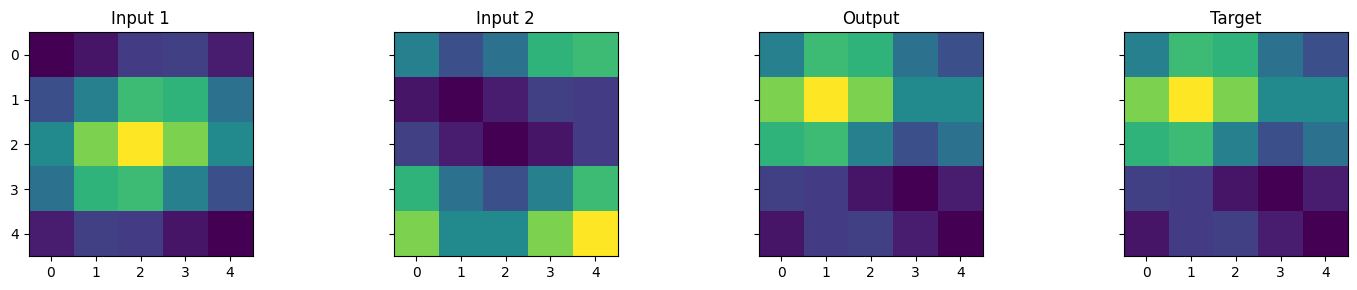

Epoch 20710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20800/50000, Loss: 0.000000


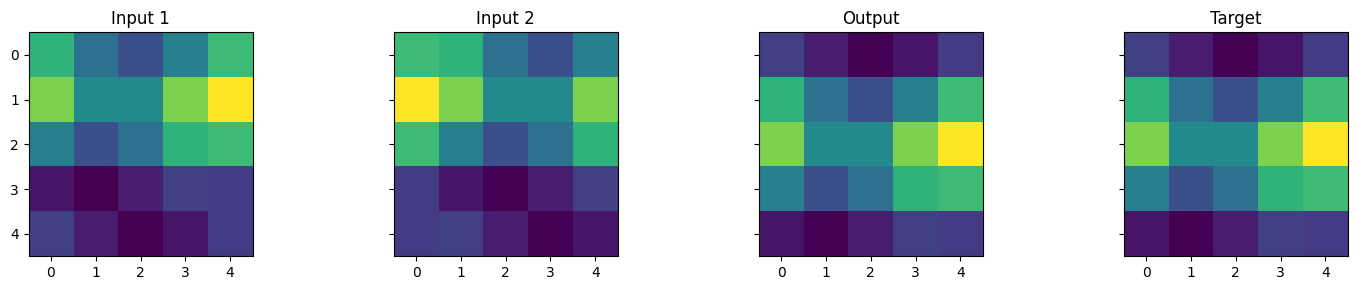

Epoch 20810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20900/50000, Loss: 0.000000


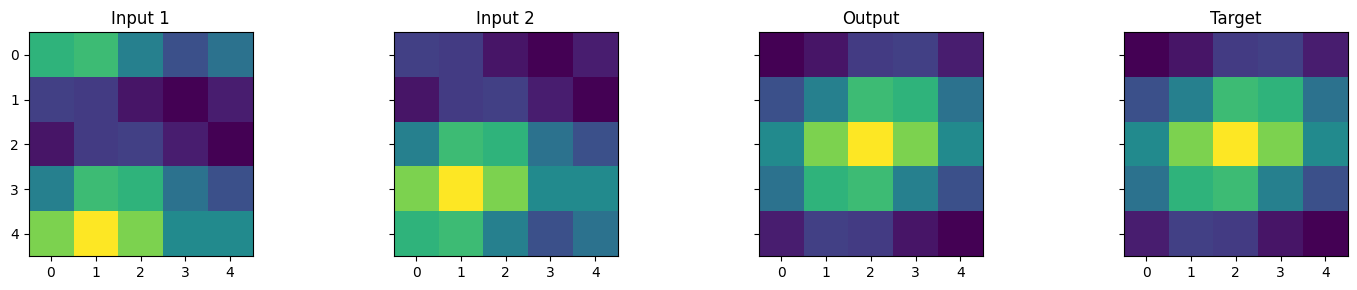

Epoch 20910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 20990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21000/50000, Loss: 0.000000


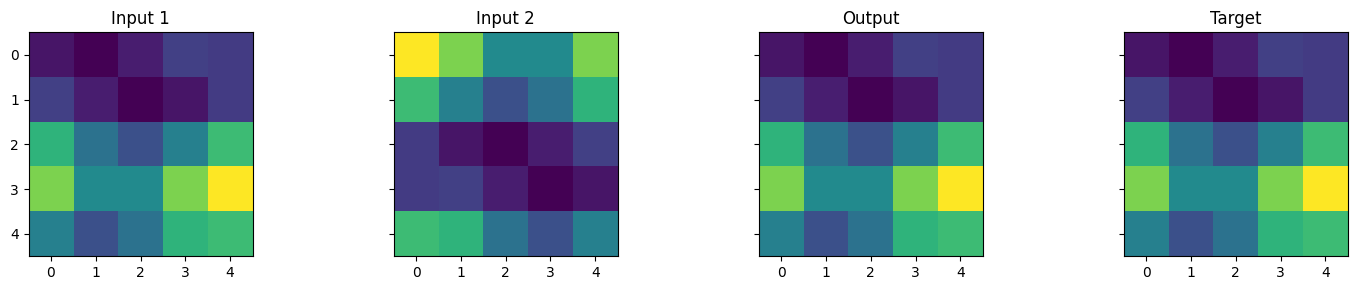

Epoch 21010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21100/50000, Loss: 0.000000


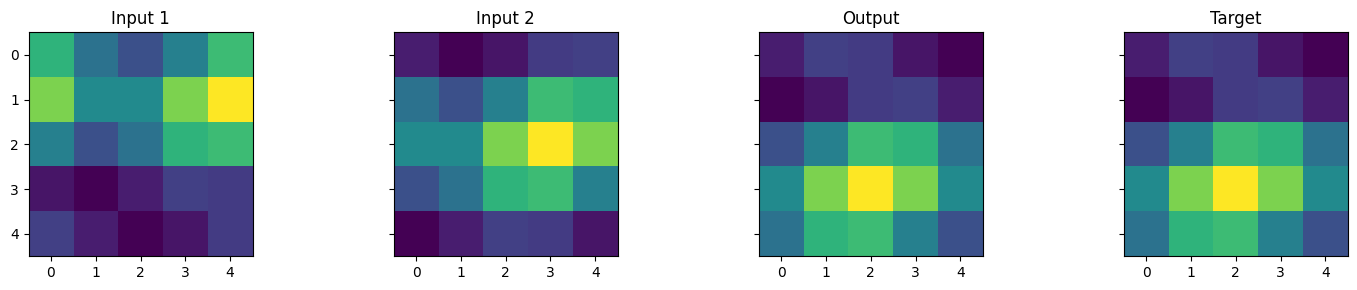

Epoch 21110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21200/50000, Loss: 0.000000


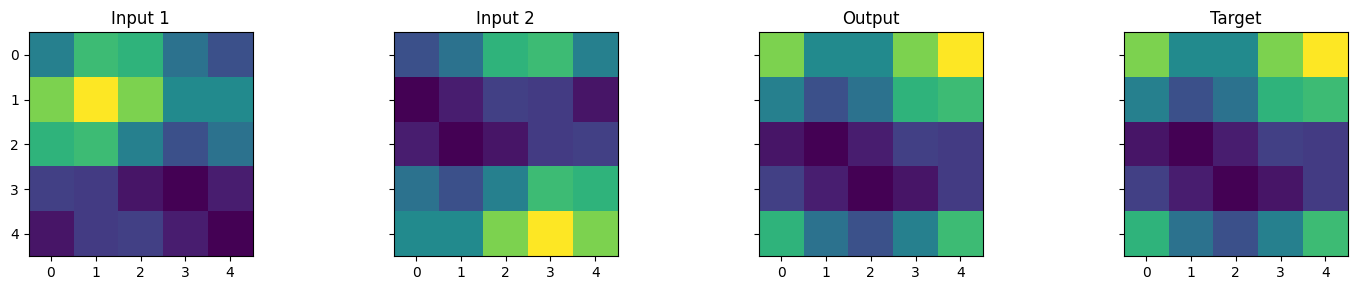

Epoch 21210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21300/50000, Loss: 0.000000


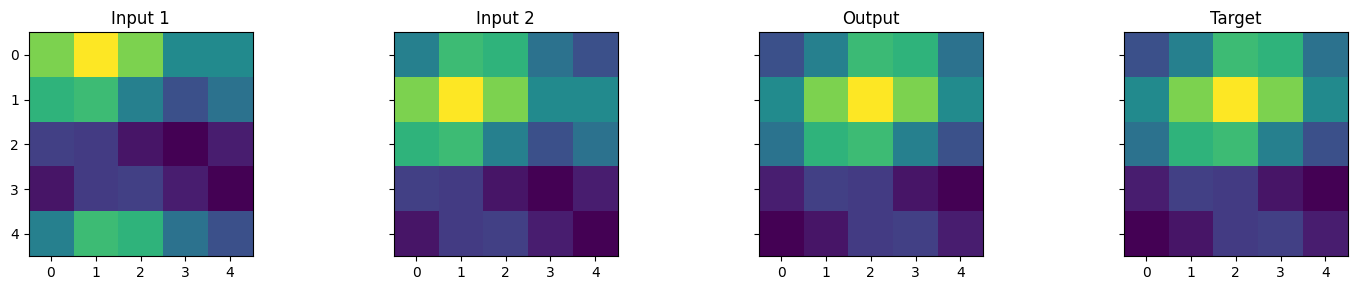

Epoch 21310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21400/50000, Loss: 0.000000


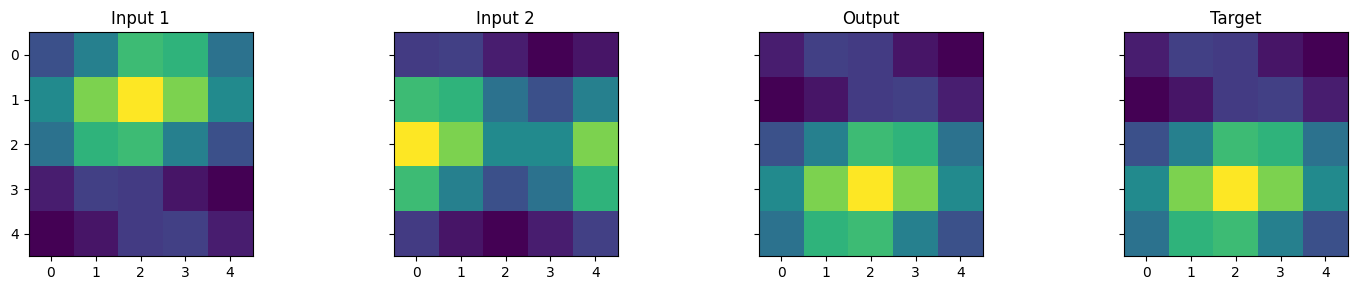

Epoch 21410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21500/50000, Loss: 0.000000


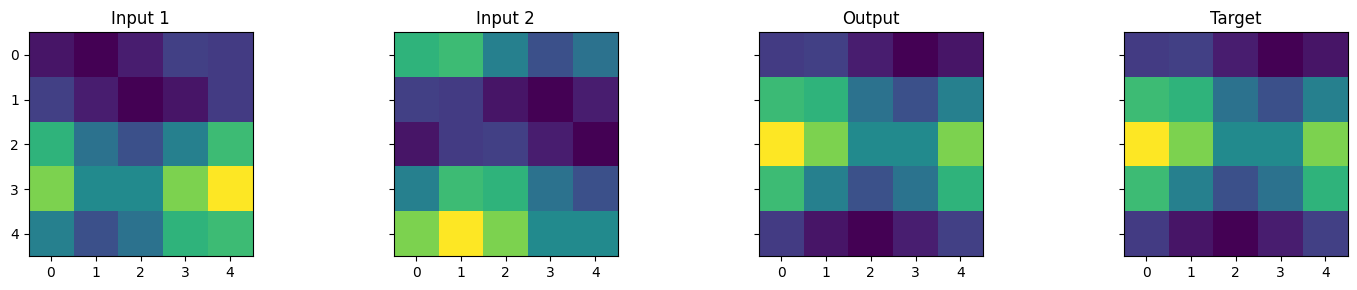

Epoch 21510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21600/50000, Loss: 0.000000


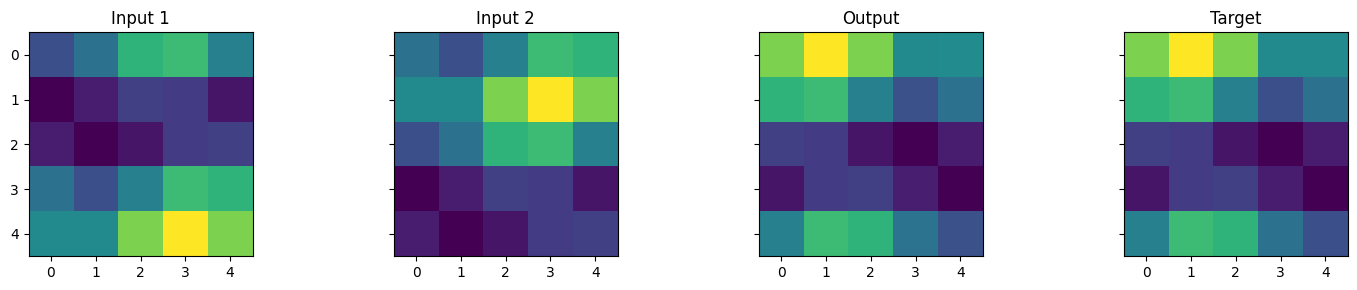

Epoch 21610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21700/50000, Loss: 0.000000


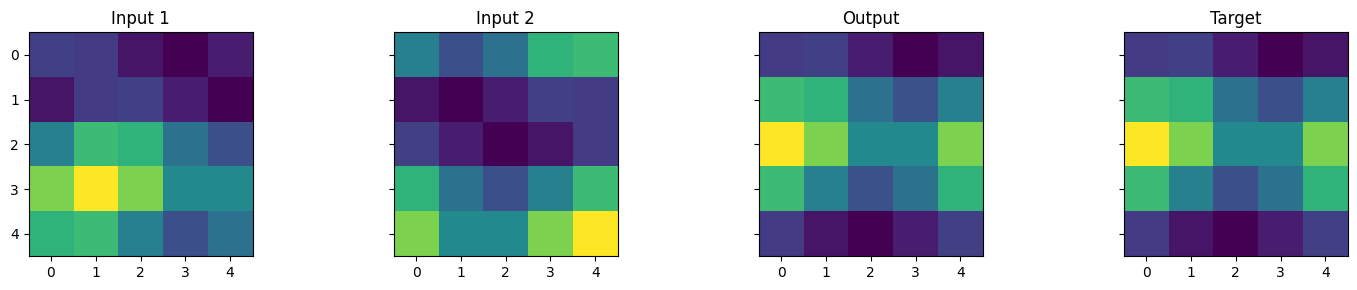

Epoch 21710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21800/50000, Loss: 0.000000


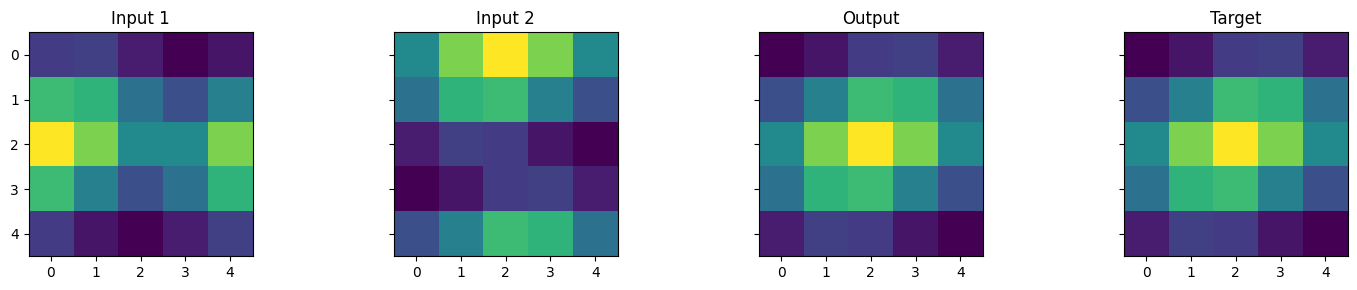

Epoch 21810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21900/50000, Loss: 0.000000


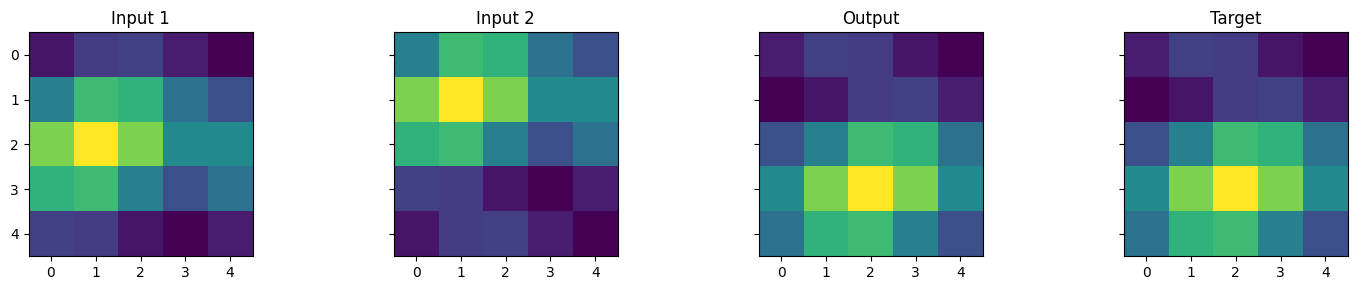

Epoch 21910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 21990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22000/50000, Loss: 0.000000


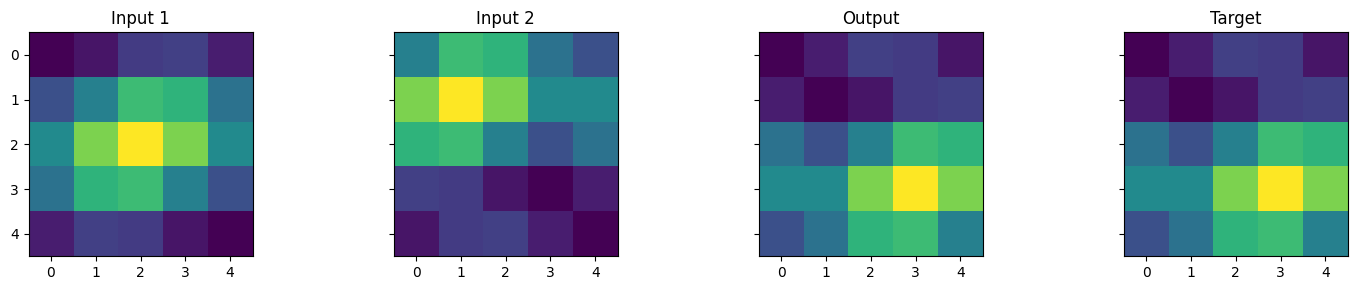

Epoch 22010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22100/50000, Loss: 0.000000


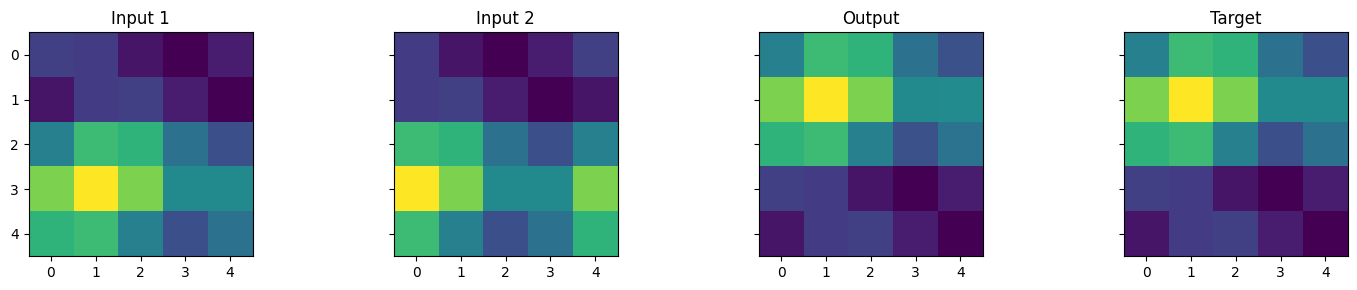

Epoch 22110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22200/50000, Loss: 0.000000


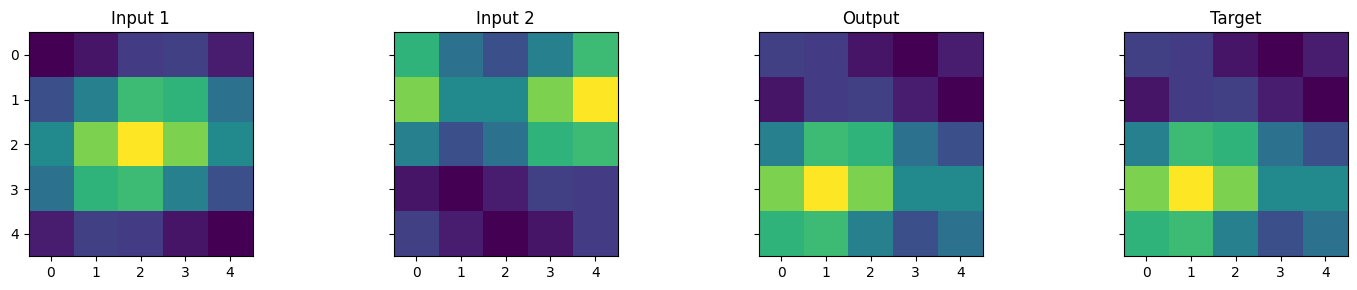

Epoch 22210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22300/50000, Loss: 0.000000


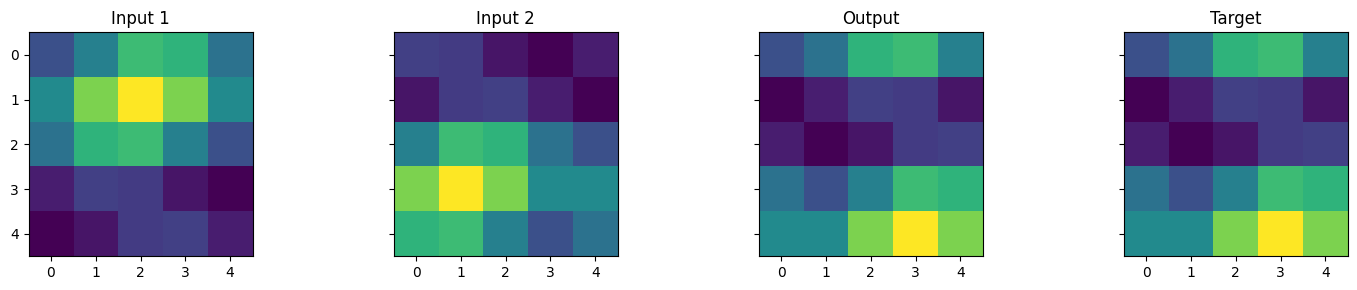

Epoch 22310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22400/50000, Loss: 0.000000


Epoch 22410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22500/50000, Loss: 0.000000


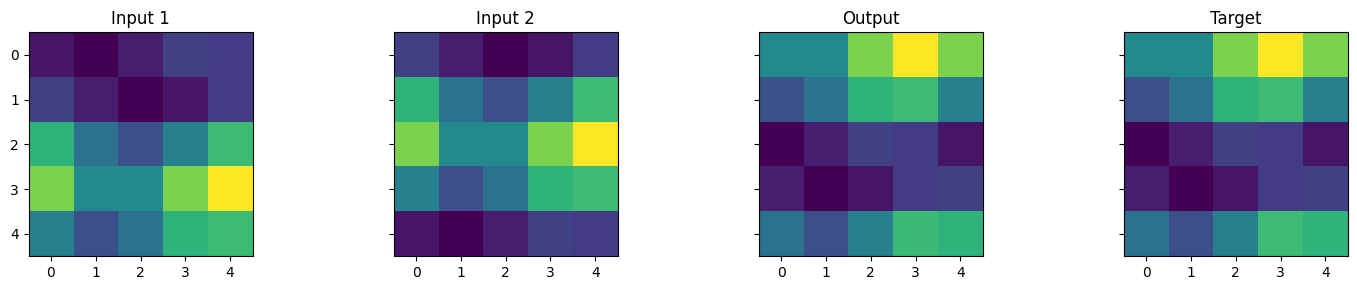

Epoch 22510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22600/50000, Loss: 0.000000


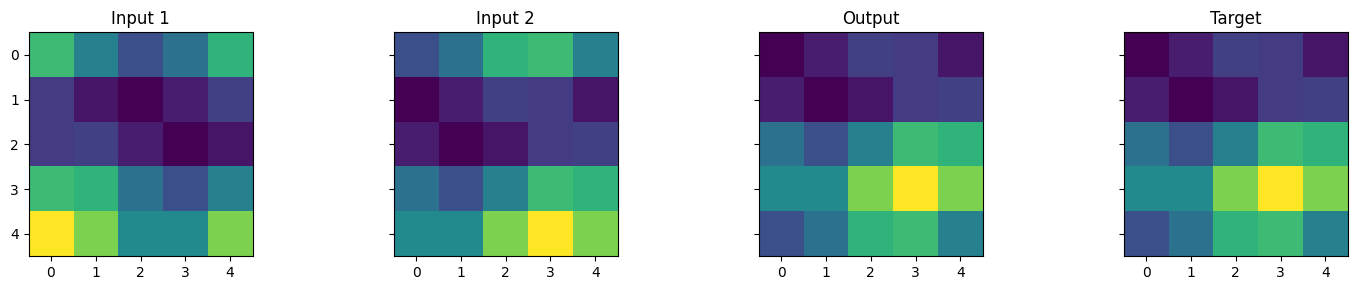

Epoch 22610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22700/50000, Loss: 0.000000


Epoch 22710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22800/50000, Loss: 0.000000


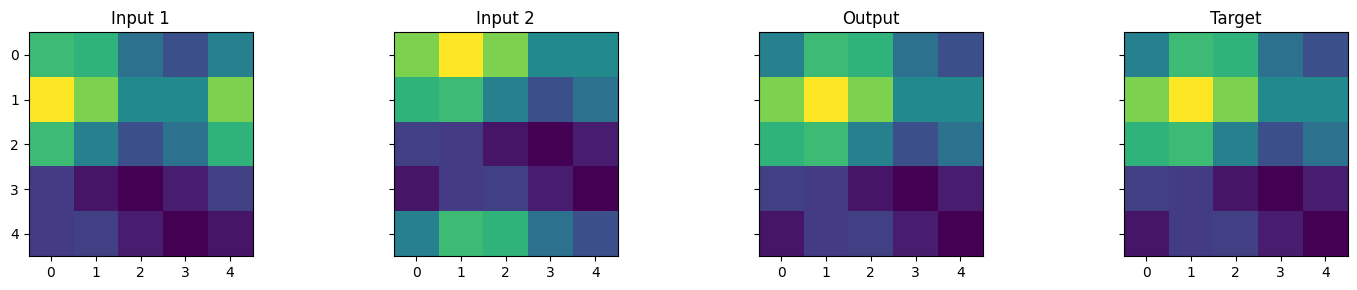

Epoch 22810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22900/50000, Loss: 0.000000


Epoch 22910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 22990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23000/50000, Loss: 0.000000


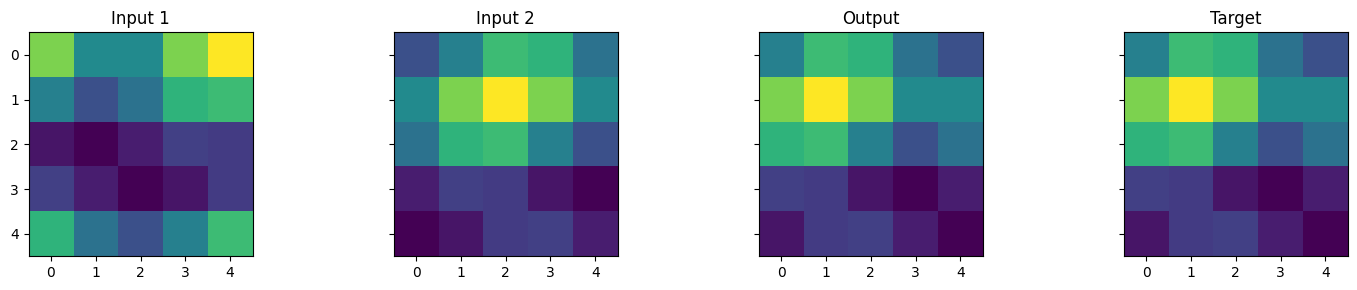

Epoch 23010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23100/50000, Loss: 0.000000


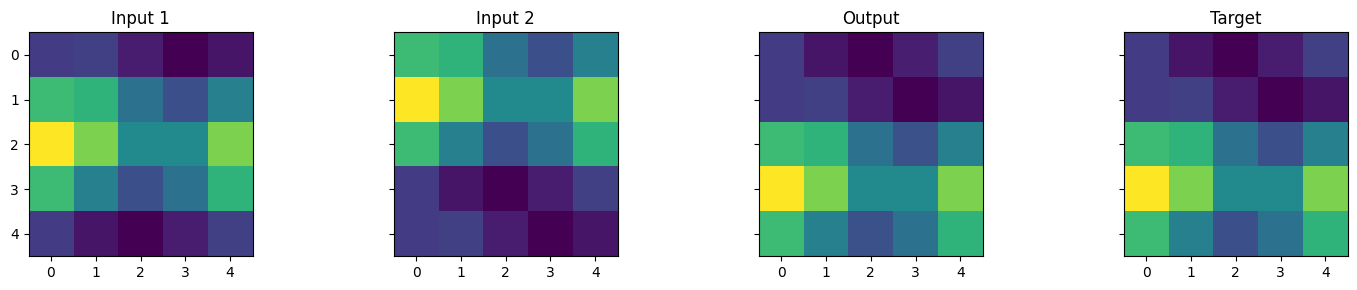

Epoch 23110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23200/50000, Loss: 0.000000


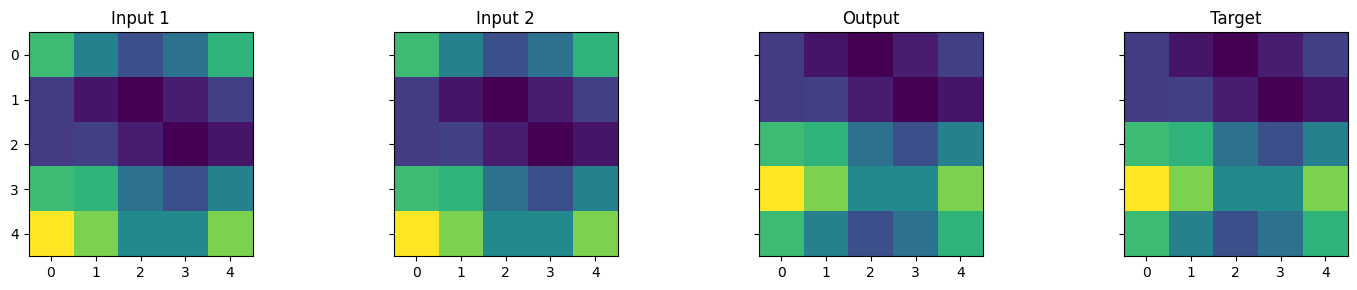

Epoch 23210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23300/50000, Loss: 0.000000


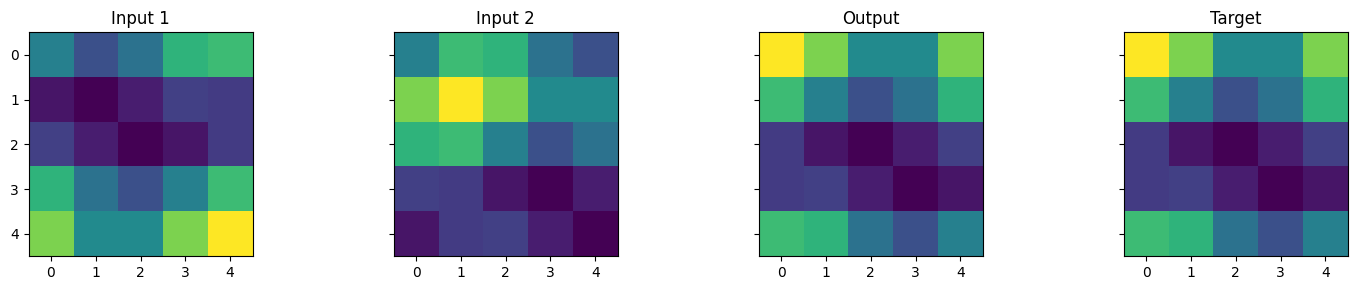

Epoch 23310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23400/50000, Loss: 0.000000


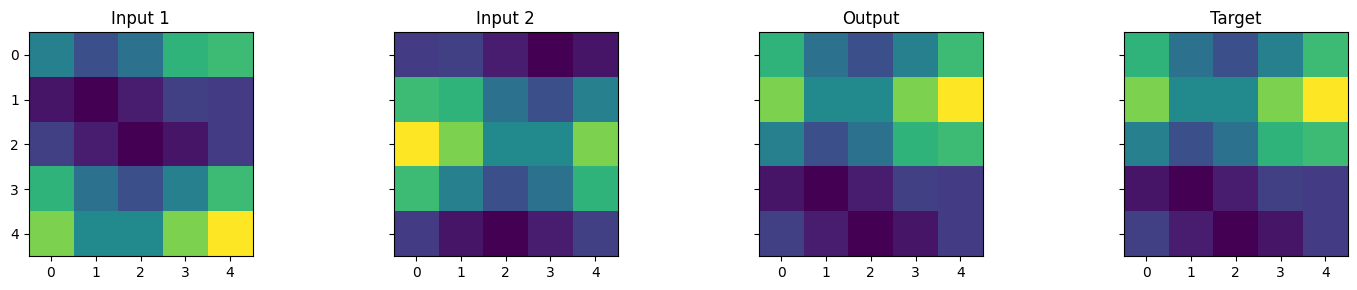

Epoch 23410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23500/50000, Loss: 0.000000


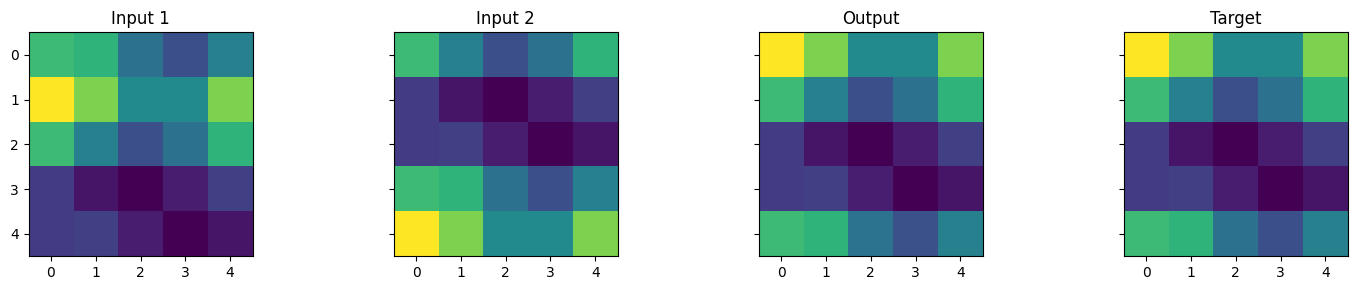

Epoch 23510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23600/50000, Loss: 0.000000


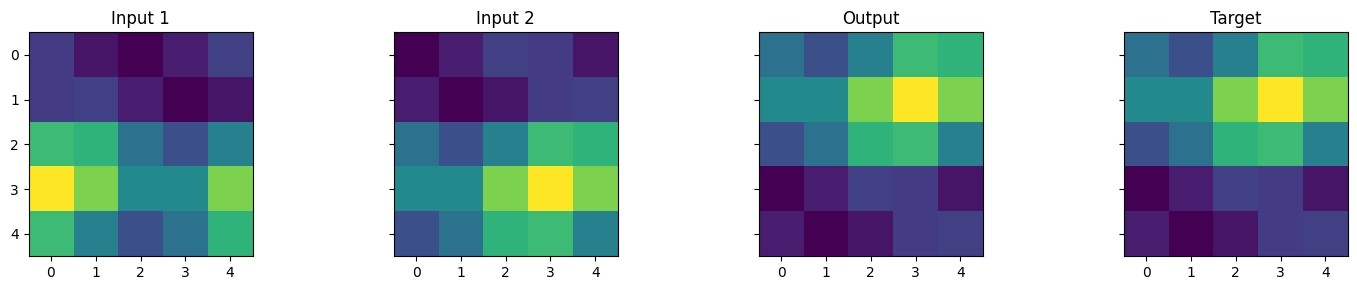

Epoch 23610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23700/50000, Loss: 0.000000


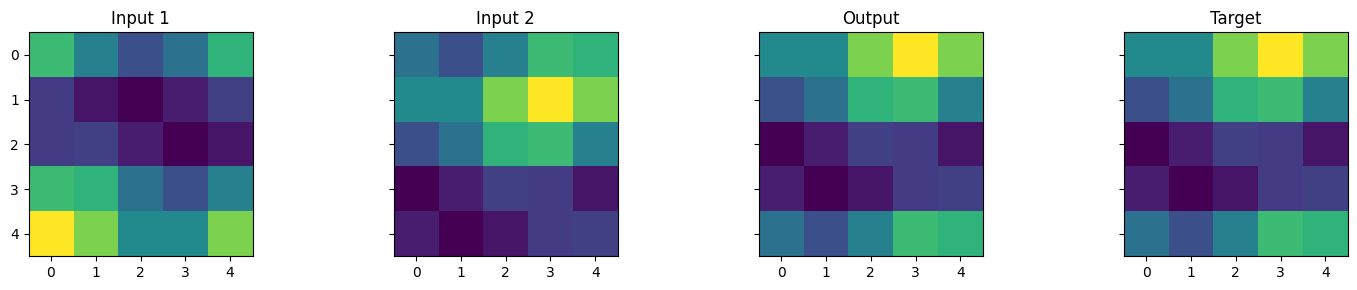

Epoch 23710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23800/50000, Loss: 0.000000


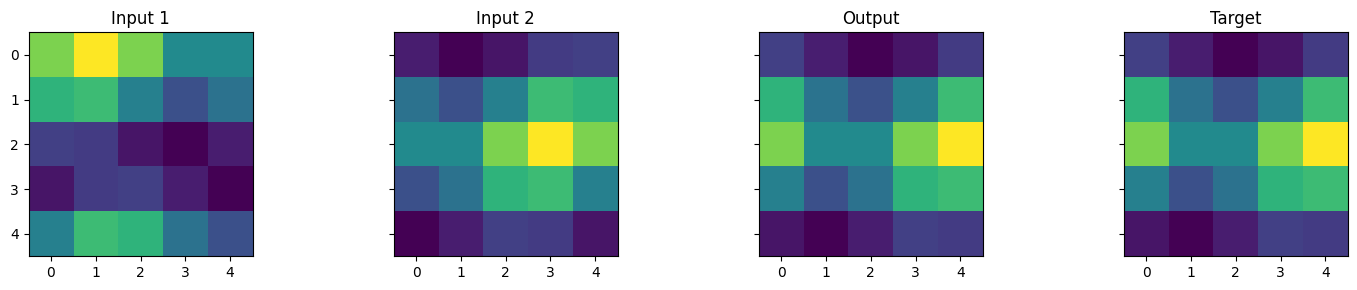

Epoch 23810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23900/50000, Loss: 0.000000


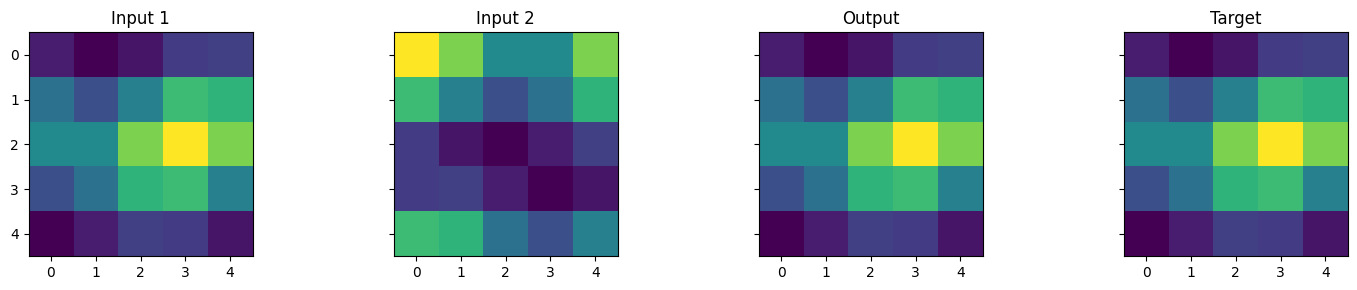

Epoch 23910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 23990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24000/50000, Loss: 0.000000


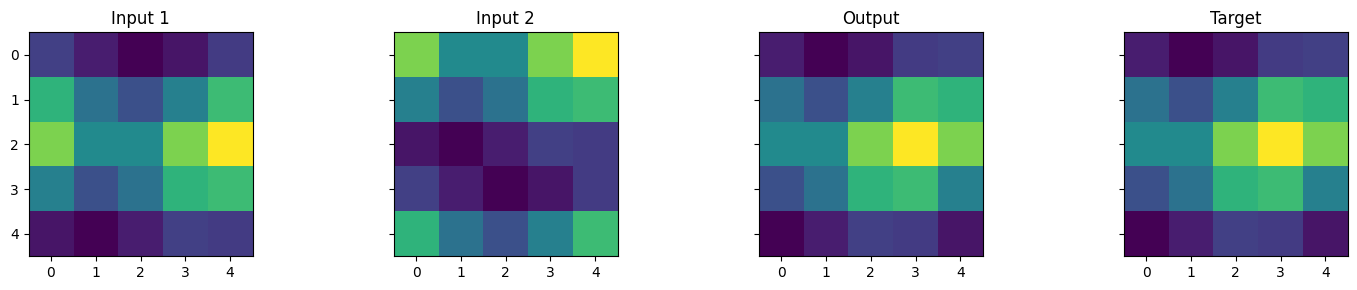

Epoch 24010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24100/50000, Loss: 0.000000


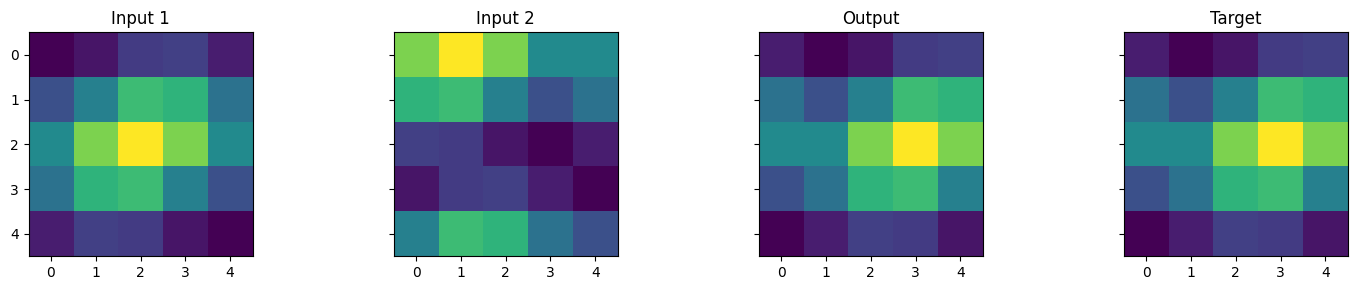

Epoch 24110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24200/50000, Loss: 0.000000


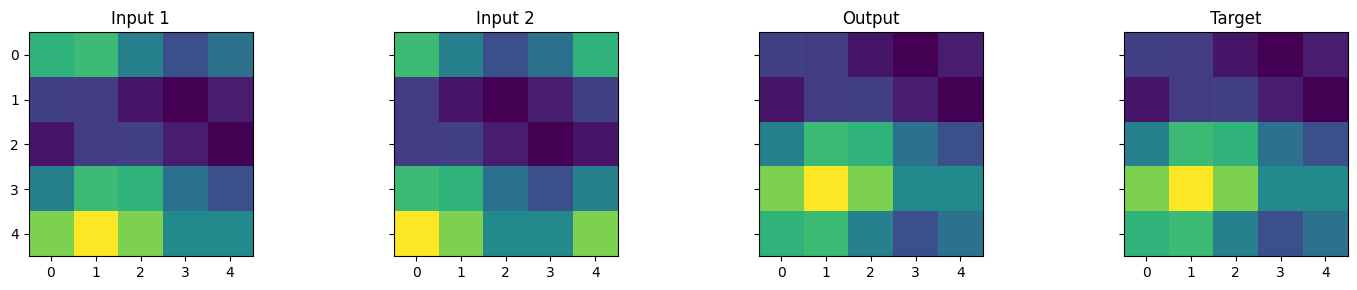

Epoch 24210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24300/50000, Loss: 0.000000


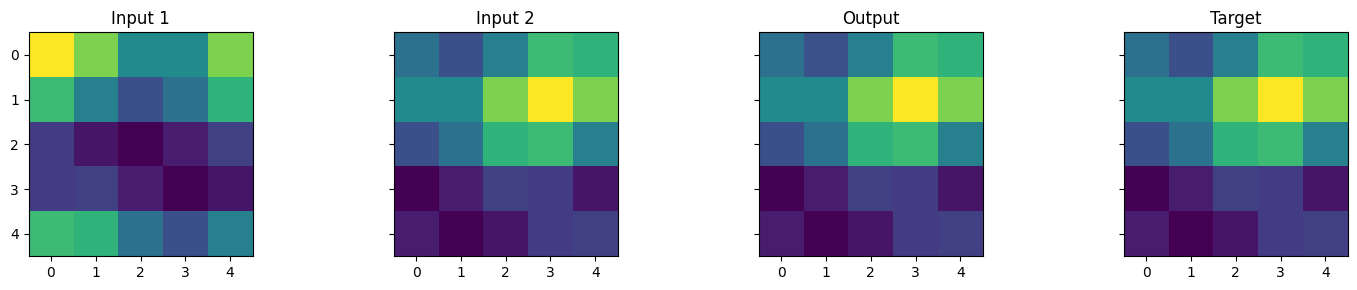

Epoch 24310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24400/50000, Loss: 0.000000


Epoch 24410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24500/50000, Loss: 0.000001


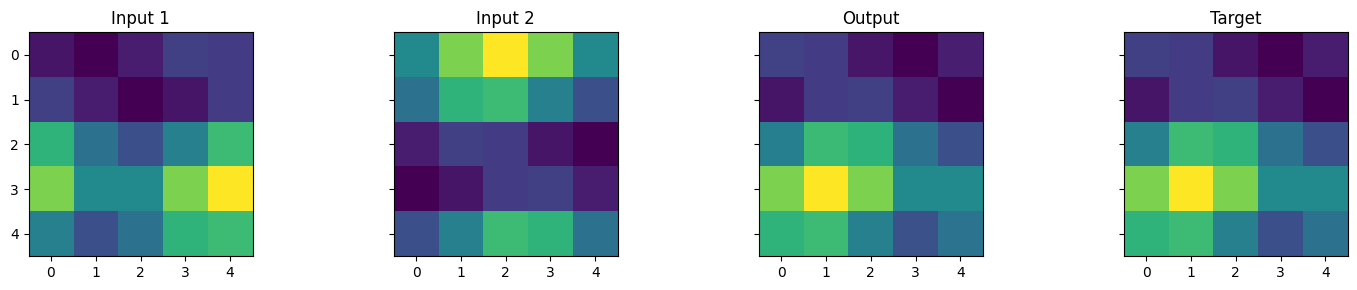

Epoch 24510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24600/50000, Loss: 0.000000


Epoch 24610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24700/50000, Loss: 0.000000


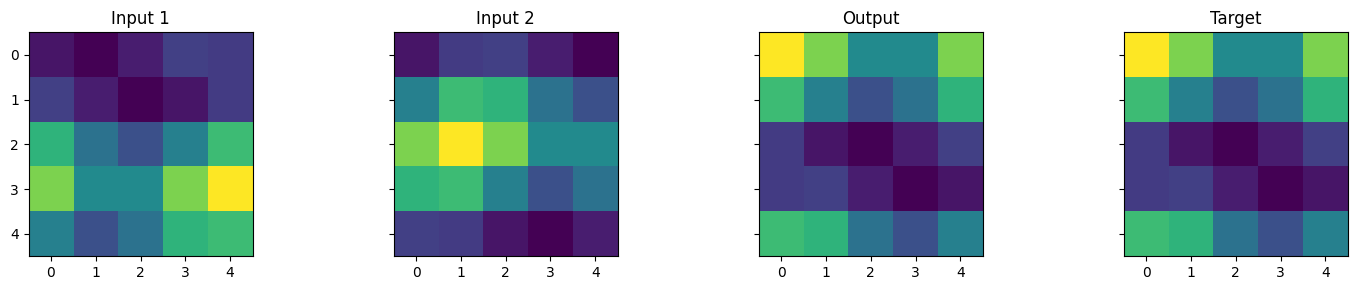

Epoch 24710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24800/50000, Loss: 0.000000


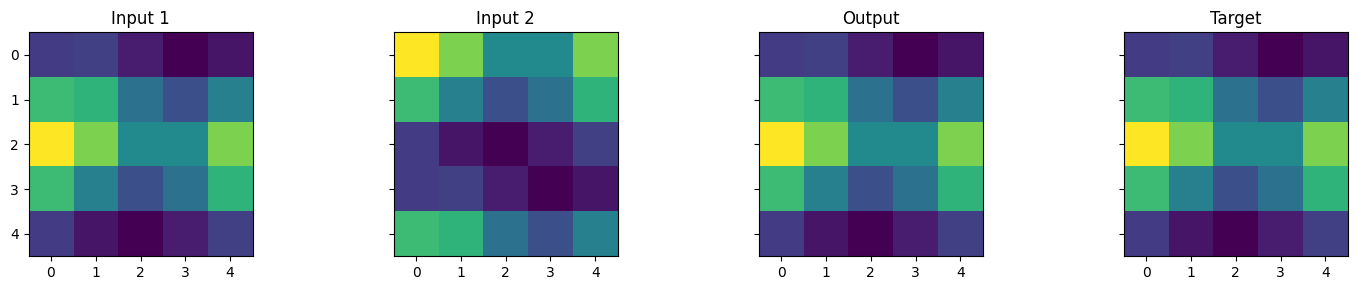

Epoch 24810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24900/50000, Loss: 0.000000


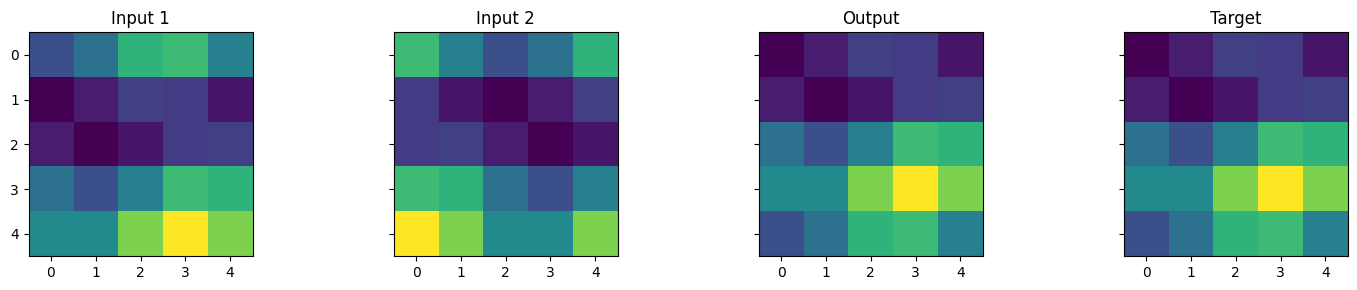

Epoch 24910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 24990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25000/50000, Loss: 0.000000


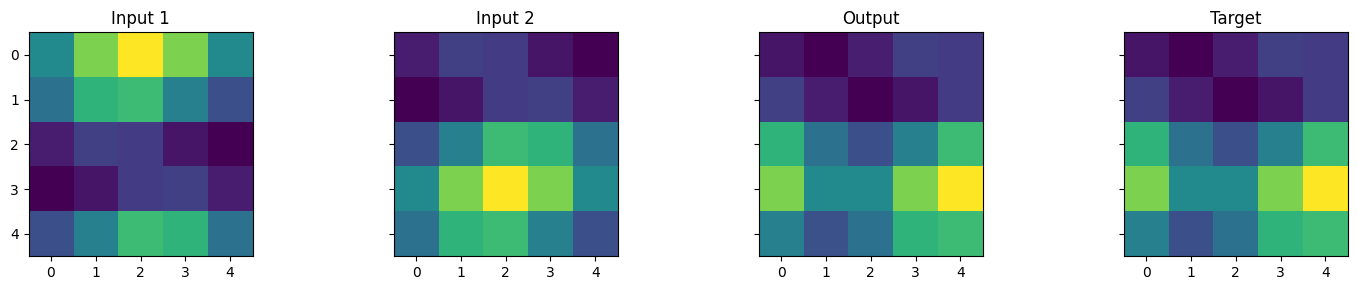

Epoch 25010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25100/50000, Loss: 0.000000


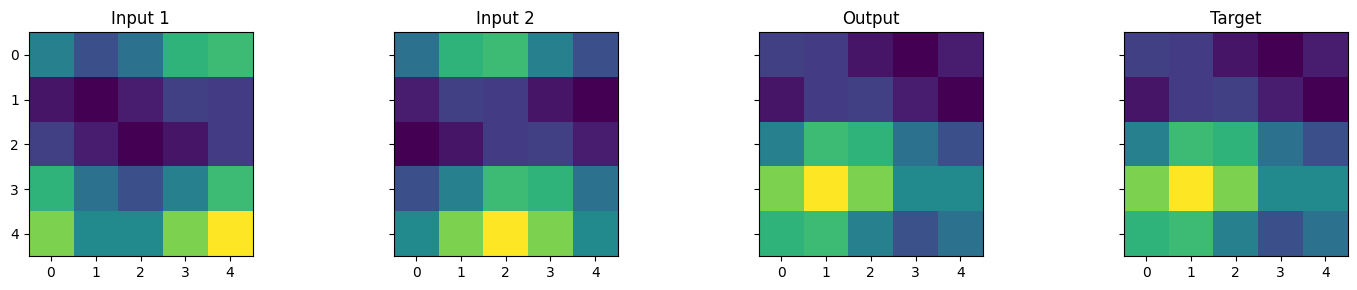

Epoch 25110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25200/50000, Loss: 0.000000


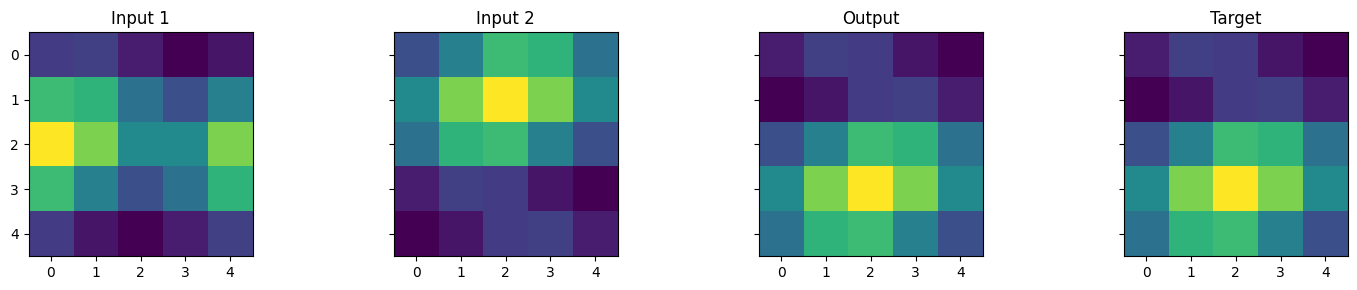

Epoch 25210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25300/50000, Loss: 0.000000


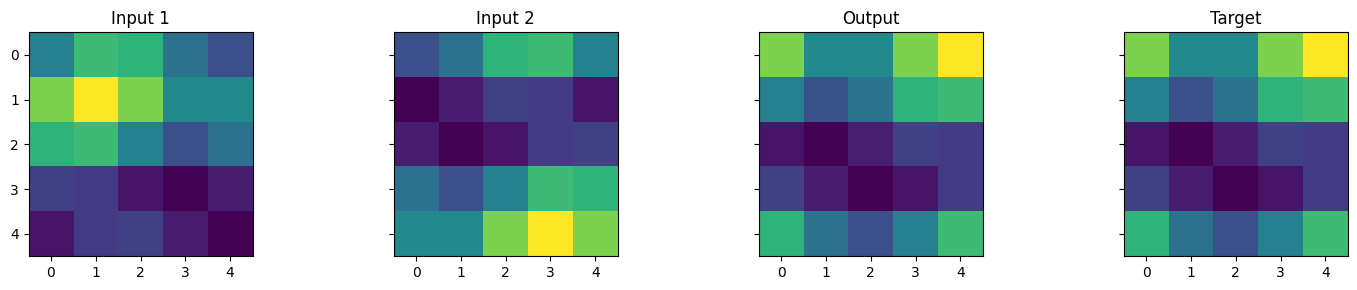

Epoch 25310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25400/50000, Loss: 0.000000


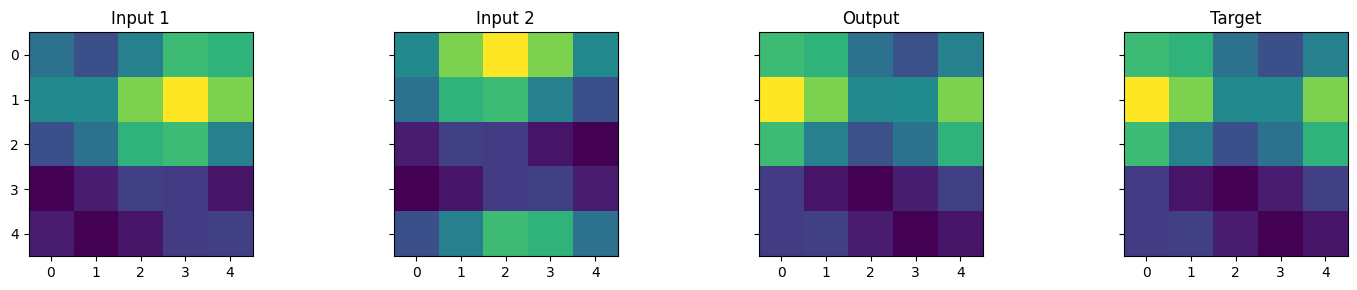

Epoch 25410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25500/50000, Loss: 0.000000


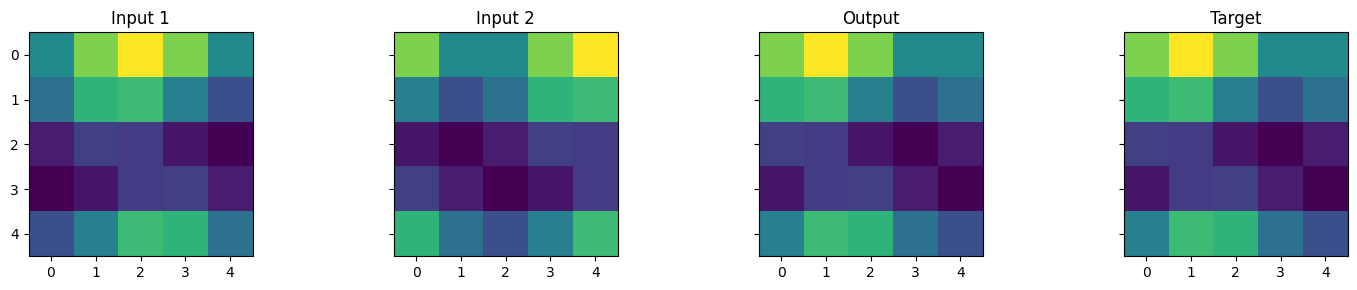

Epoch 25510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25600/50000, Loss: 0.000000


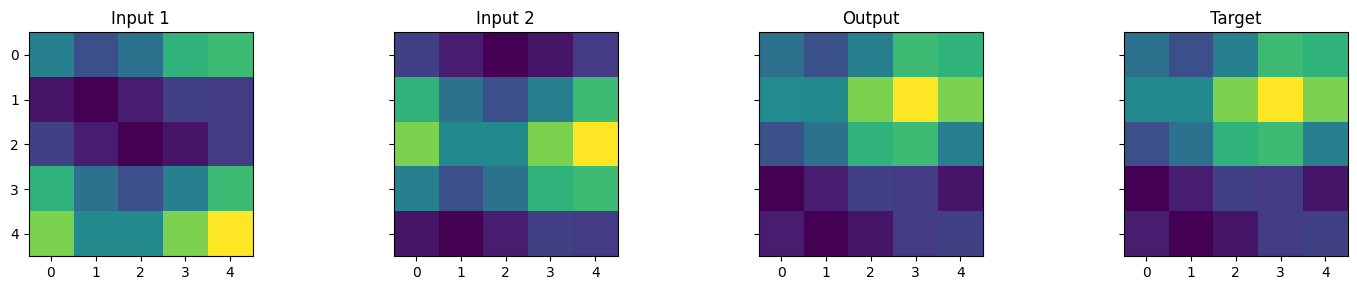

Epoch 25610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25700/50000, Loss: 0.000000


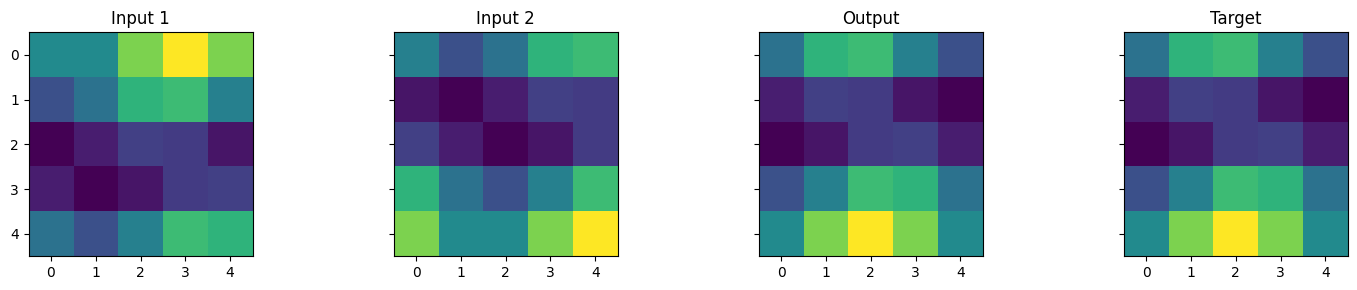

Epoch 25710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25800/50000, Loss: 0.000000


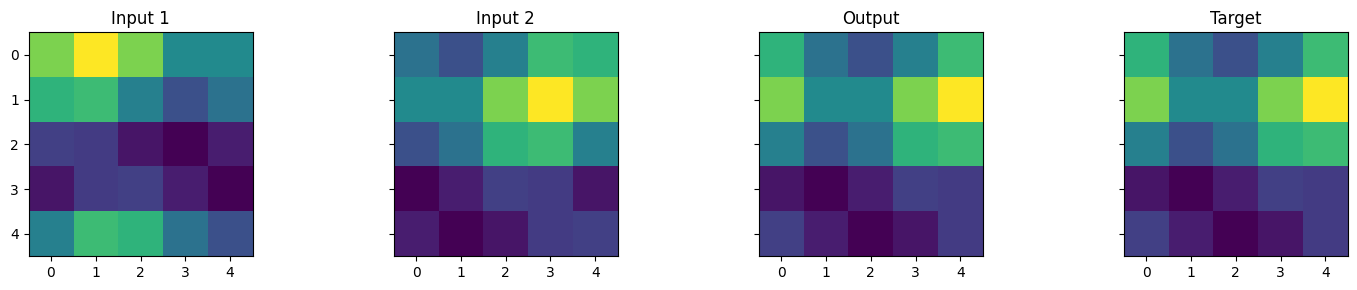

Epoch 25810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25900/50000, Loss: 0.000000


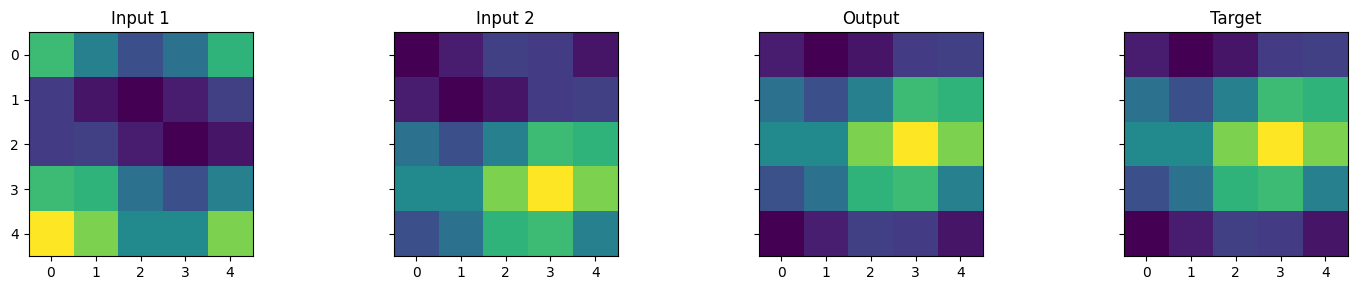

Epoch 25910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 25990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26000/50000, Loss: 0.000000


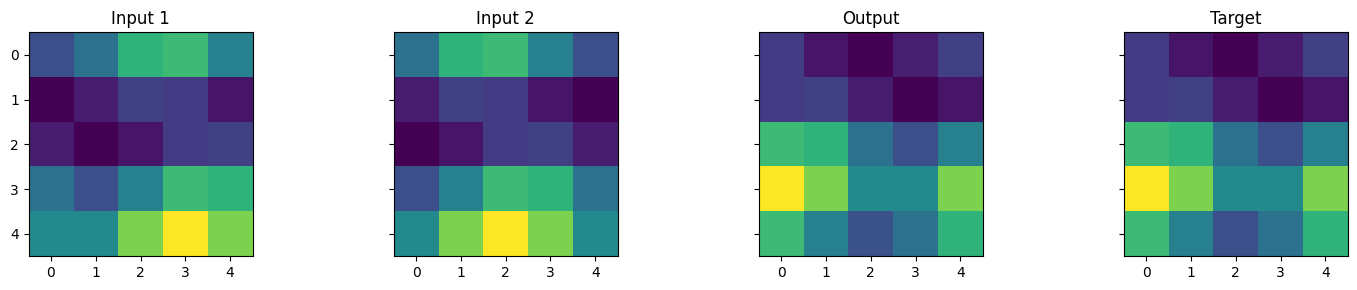

Epoch 26010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26100/50000, Loss: 0.000000


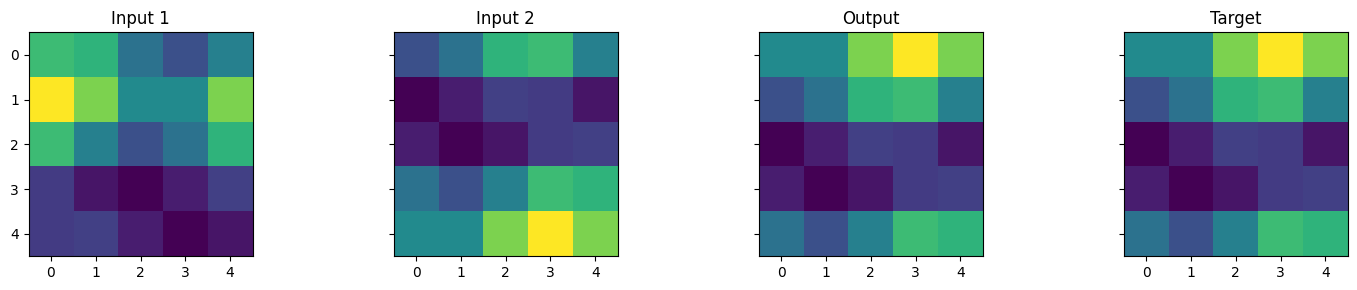

Epoch 26110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26200/50000, Loss: 0.000000


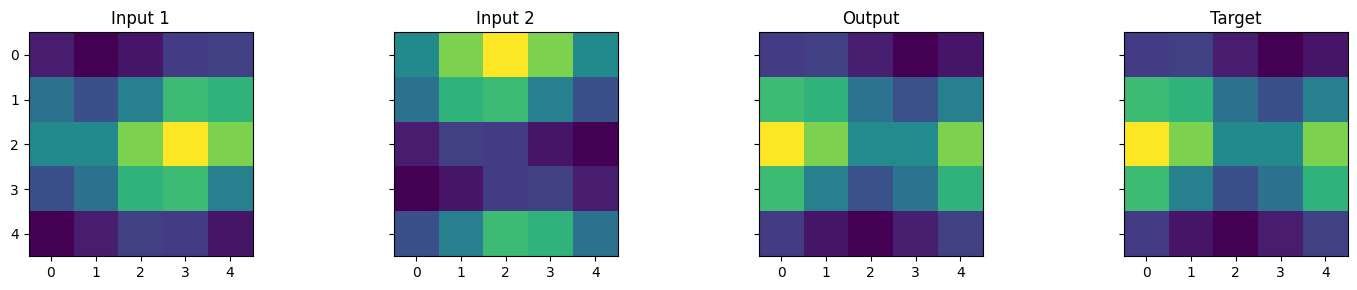

Epoch 26210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26300/50000, Loss: 0.000000


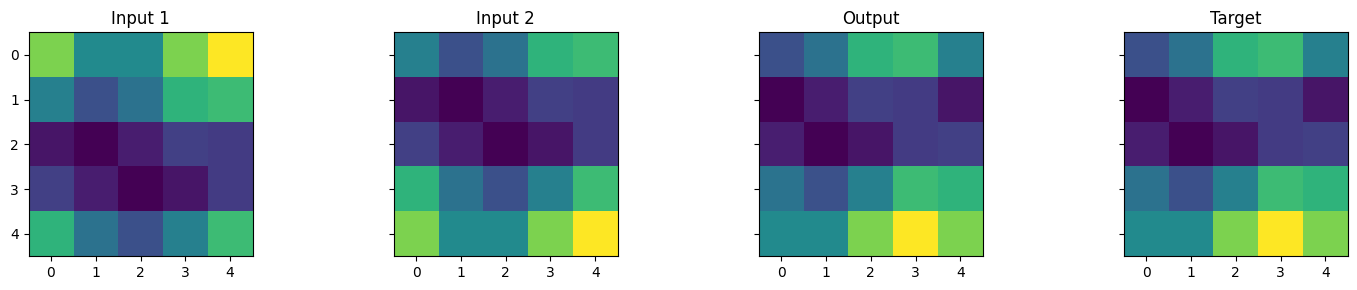

Epoch 26310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26400/50000, Loss: 0.000000


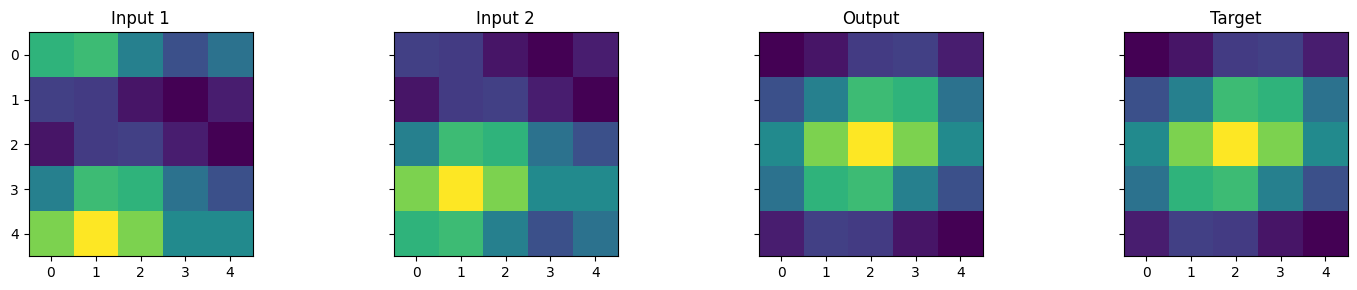

Epoch 26410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26500/50000, Loss: 0.000000


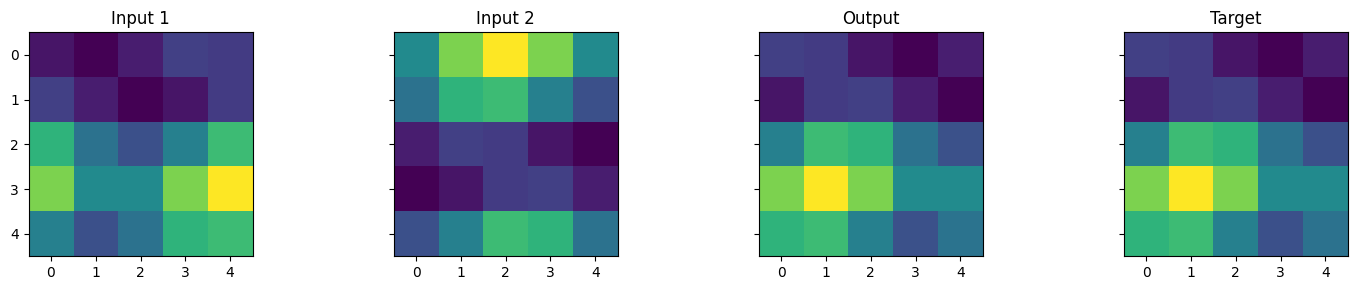

Epoch 26510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26600/50000, Loss: 0.000000


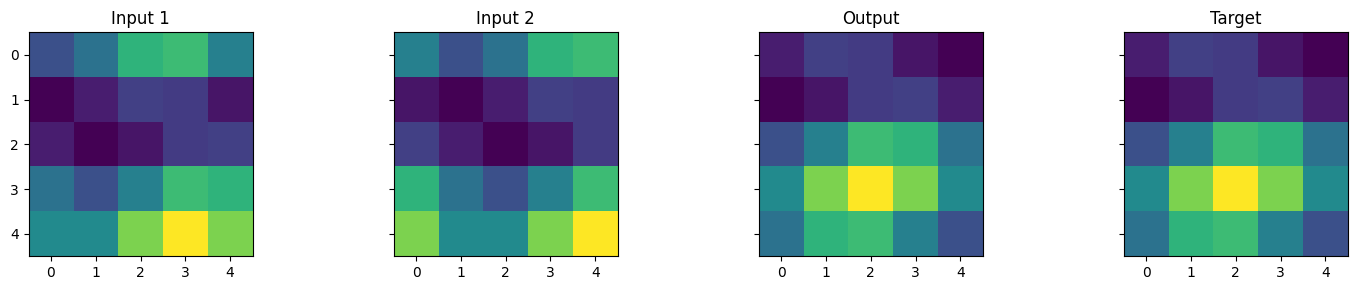

Epoch 26610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26700/50000, Loss: 0.000000


Epoch 26710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26800/50000, Loss: 0.000000


Epoch 26810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26900/50000, Loss: 0.000000


Epoch 26910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 26990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27000/50000, Loss: 0.000001


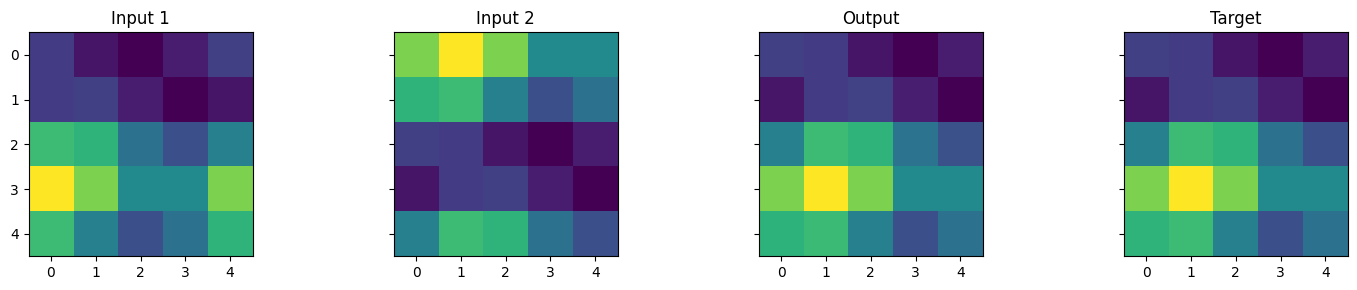

Epoch 27010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27100/50000, Loss: 0.000000


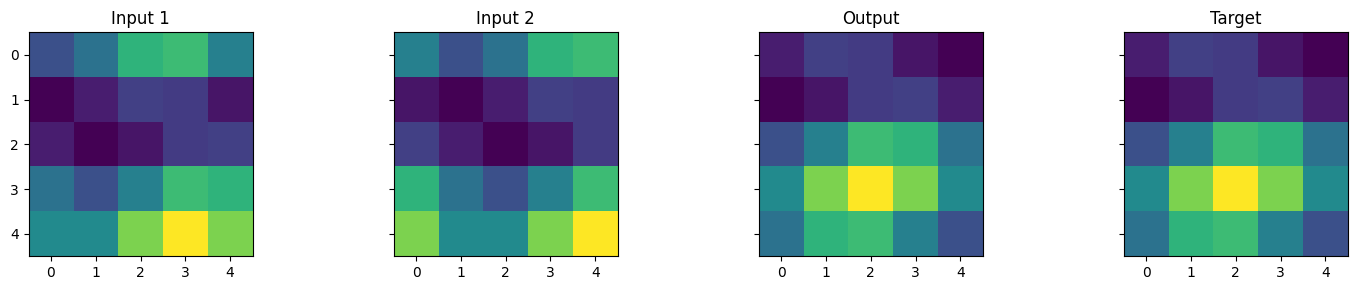

Epoch 27110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27200/50000, Loss: 0.000000


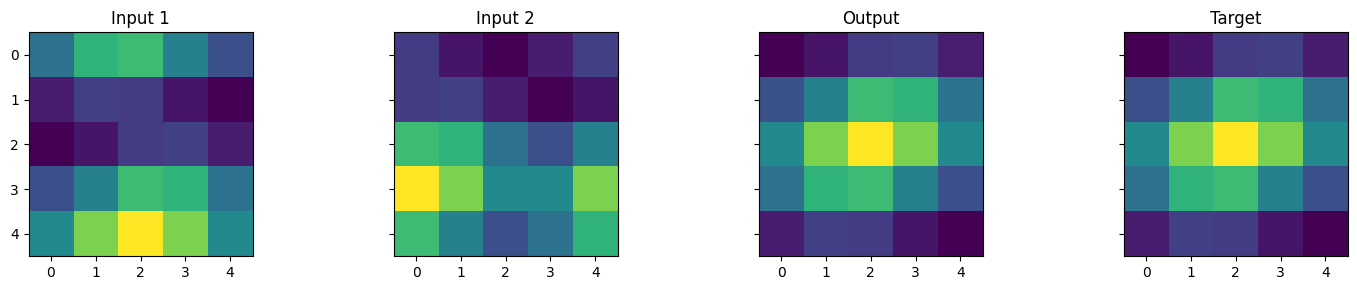

Epoch 27210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27300/50000, Loss: 0.000000


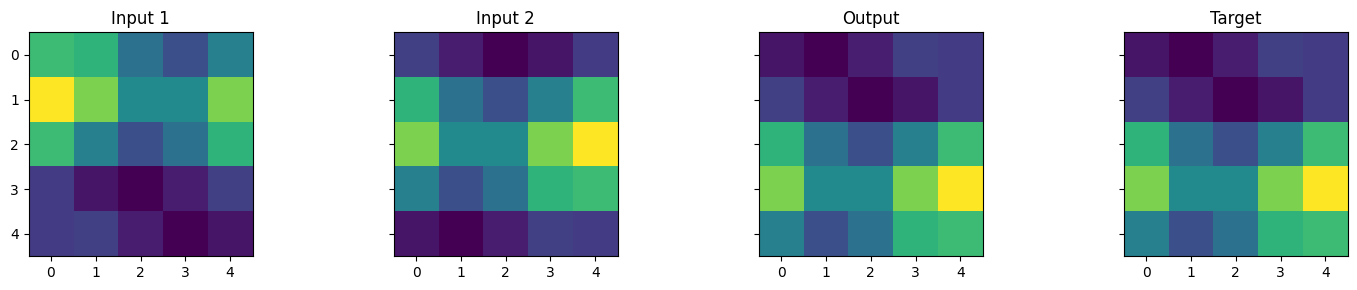

Epoch 27310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27400/50000, Loss: 0.000000


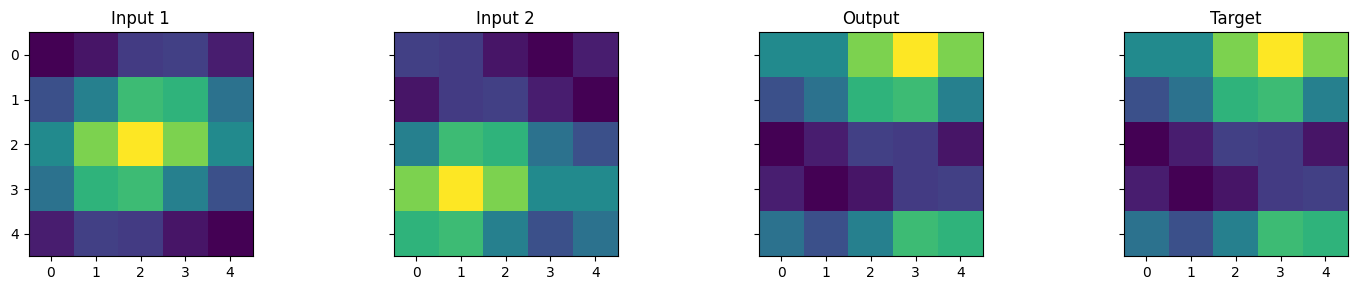

Epoch 27410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27500/50000, Loss: 0.000000


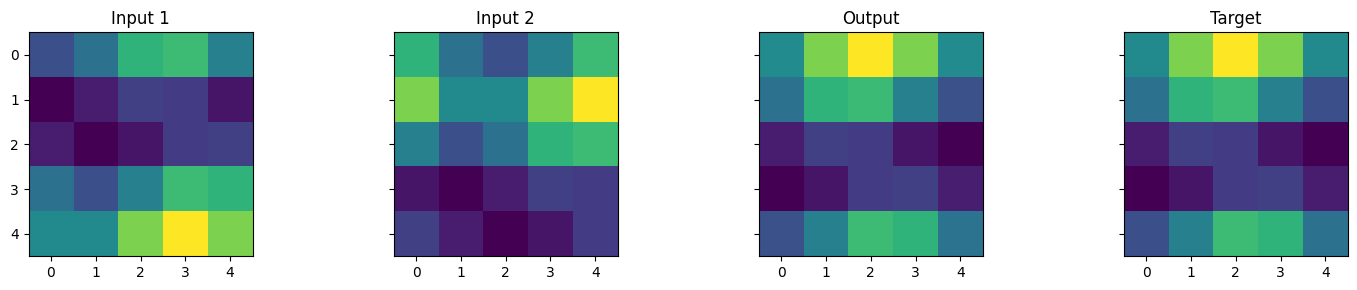

Epoch 27510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27600/50000, Loss: 0.000000


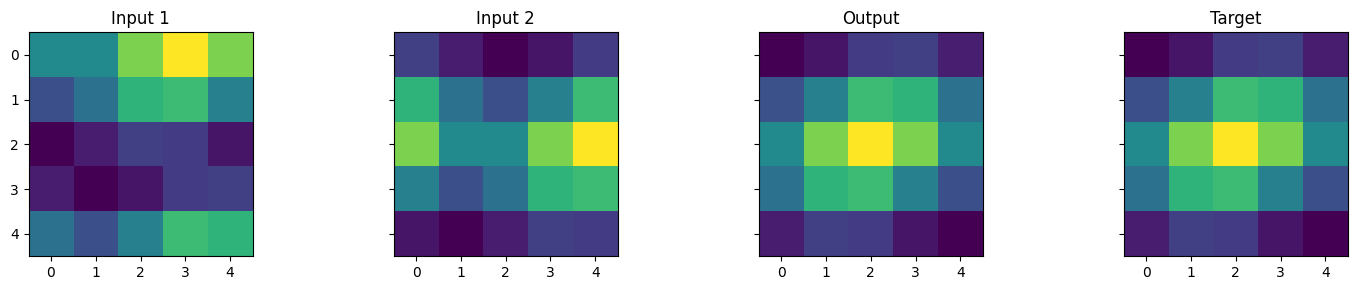

Epoch 27610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27700/50000, Loss: 0.000000


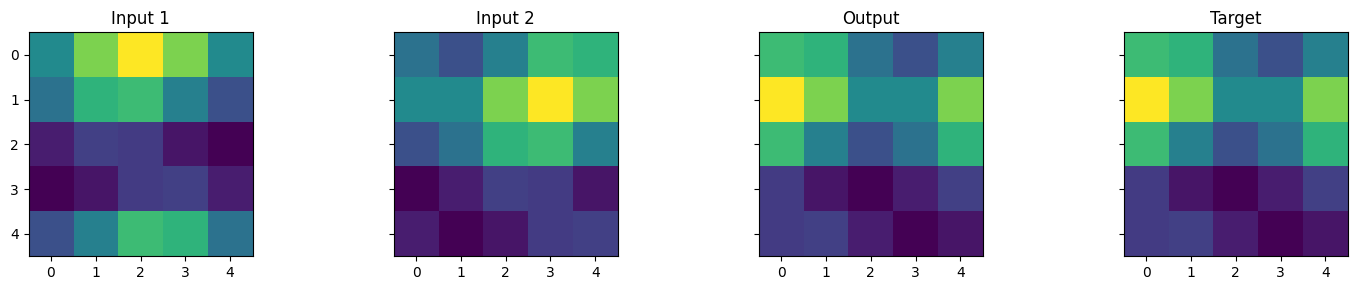

Epoch 27710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27800/50000, Loss: 0.000000


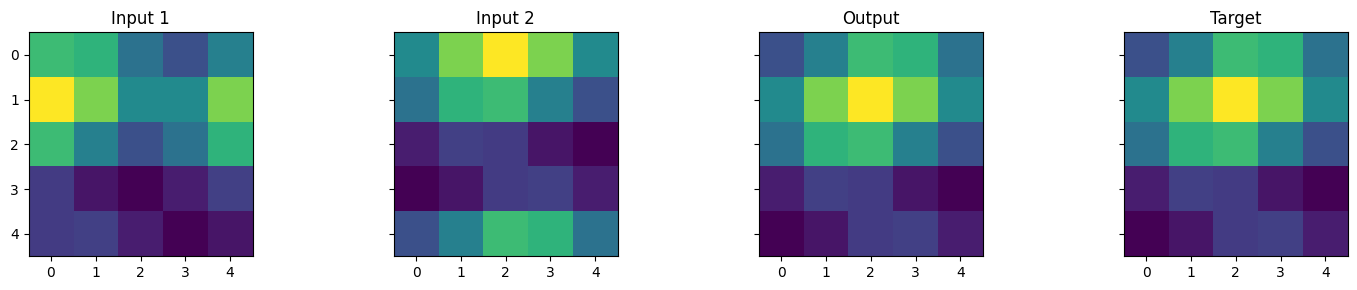

Epoch 27810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27900/50000, Loss: 0.000000


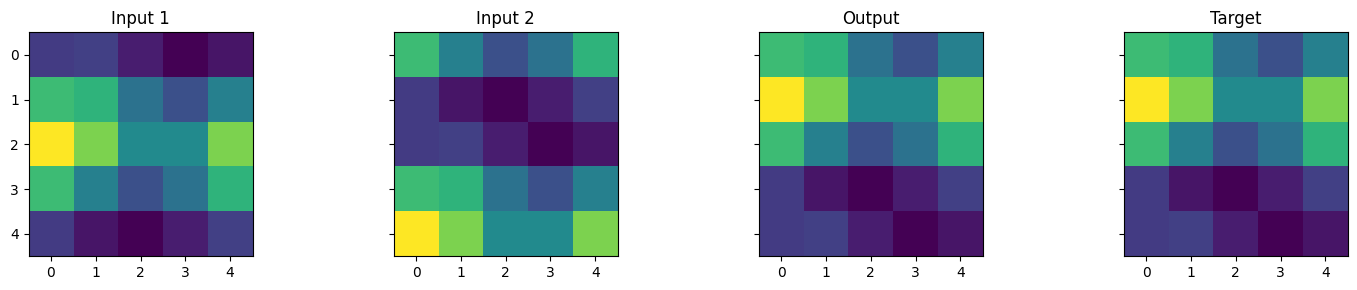

Epoch 27910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 27990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28000/50000, Loss: 0.000000


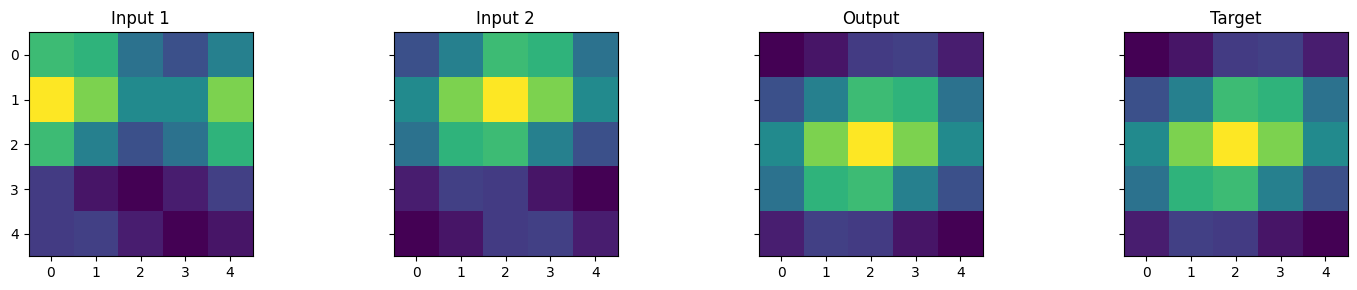

Epoch 28010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28100/50000, Loss: 0.000000


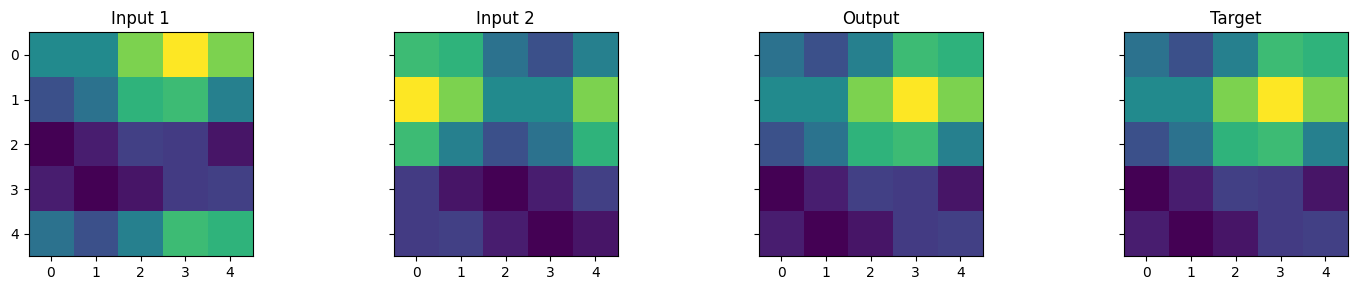

Epoch 28110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28200/50000, Loss: 0.000000


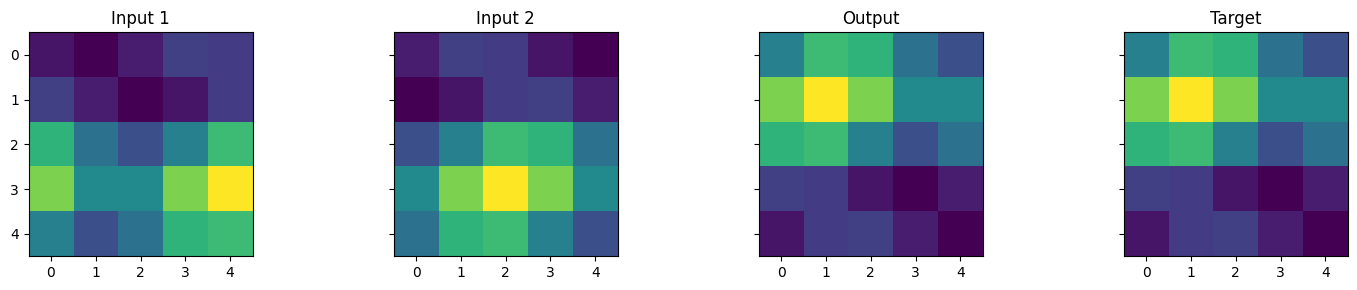

Epoch 28210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28300/50000, Loss: 0.000000


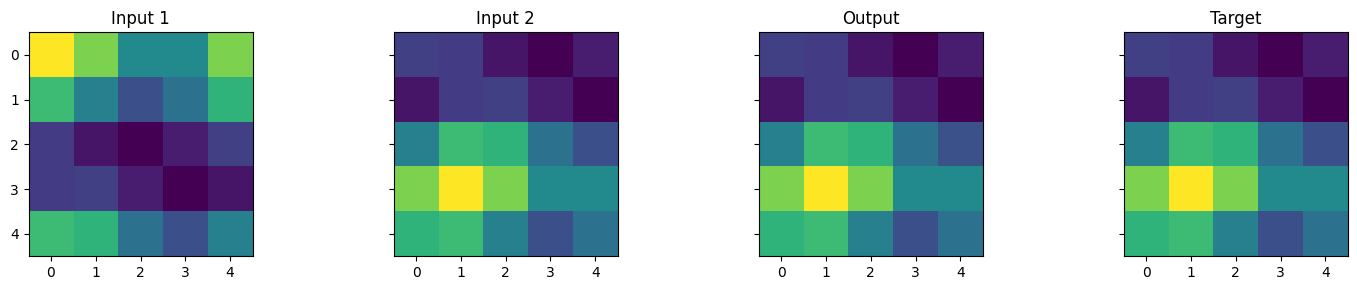

Epoch 28310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28400/50000, Loss: 0.000000


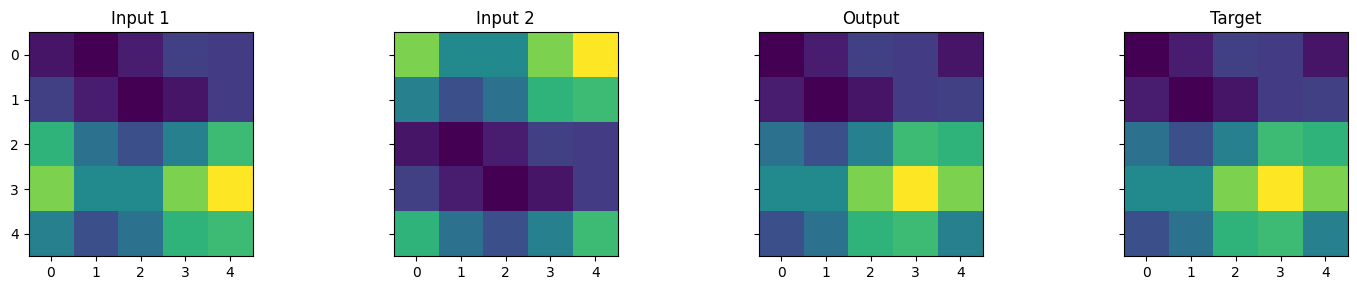

Epoch 28410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28500/50000, Loss: 0.000000


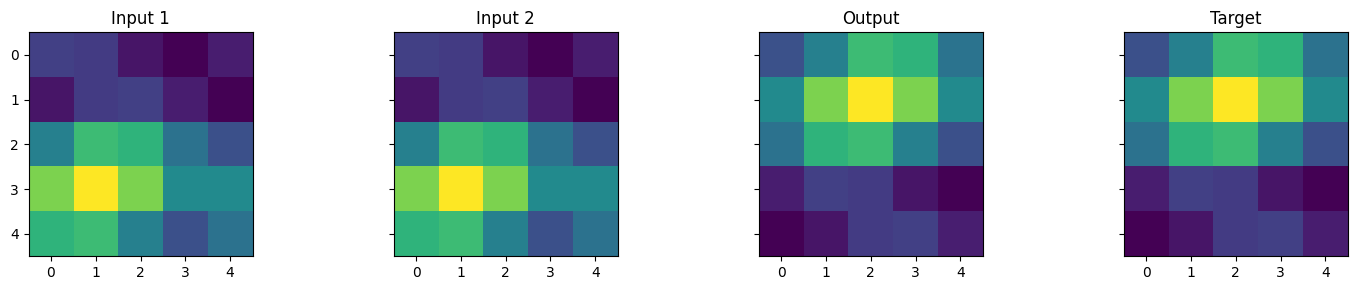

Epoch 28510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28600/50000, Loss: 0.000000


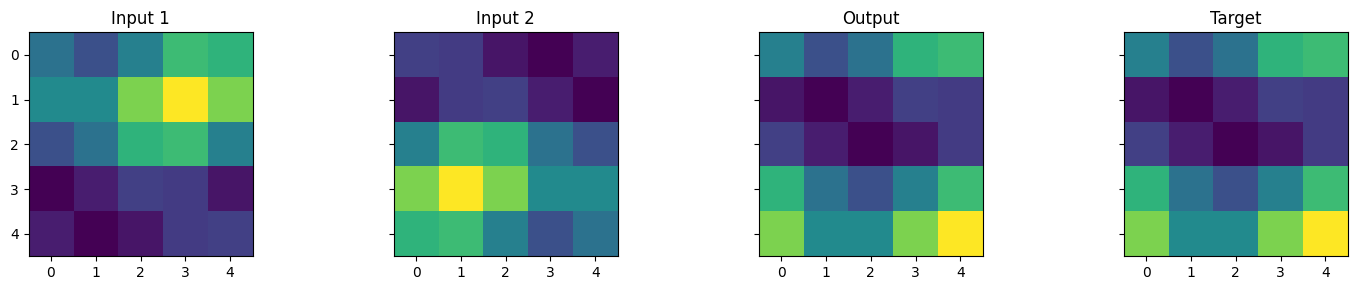

Epoch 28610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28700/50000, Loss: 0.000000


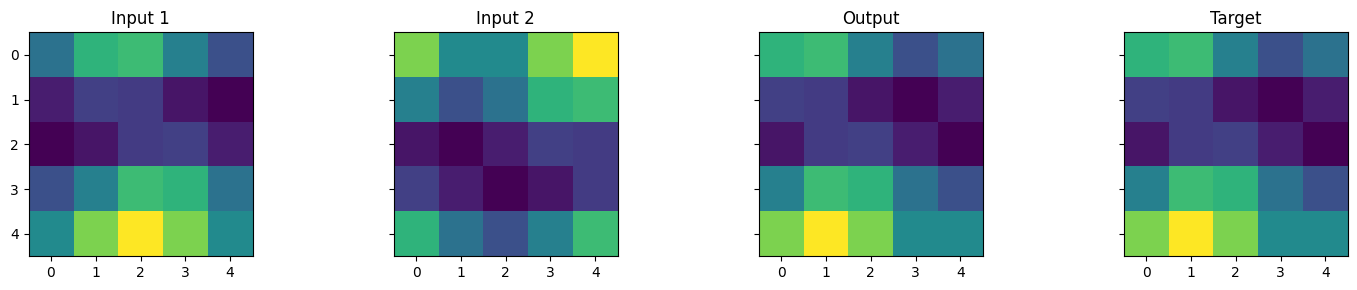

Epoch 28710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28800/50000, Loss: 0.000000


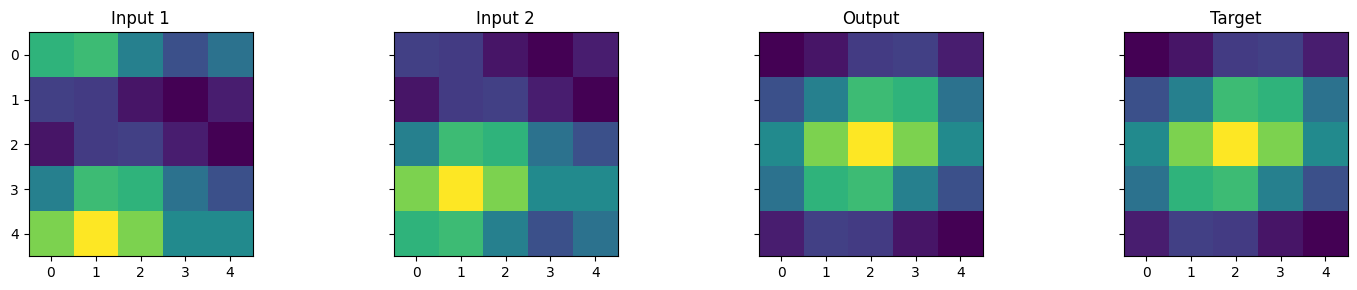

Epoch 28810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28900/50000, Loss: 0.000000


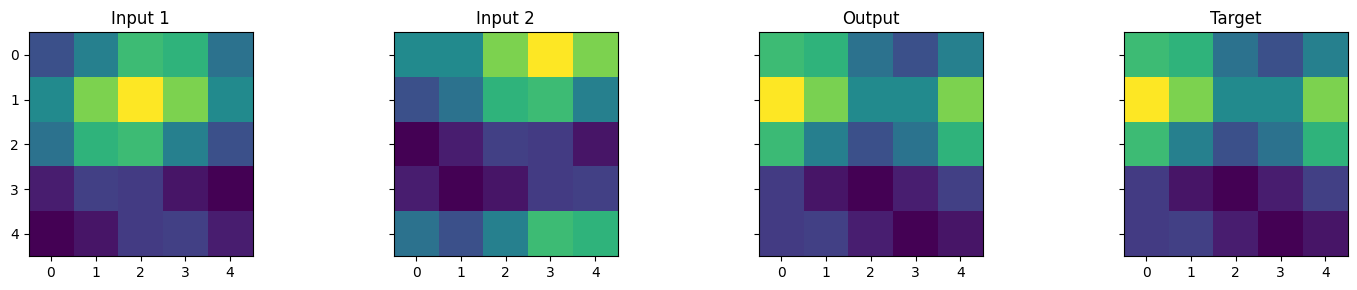

Epoch 28910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 28990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29000/50000, Loss: 0.000000


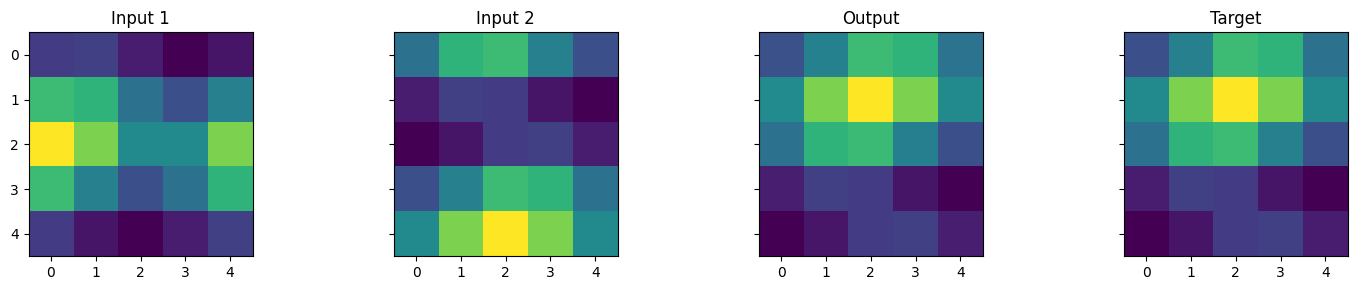

Epoch 29010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29100/50000, Loss: 0.000000


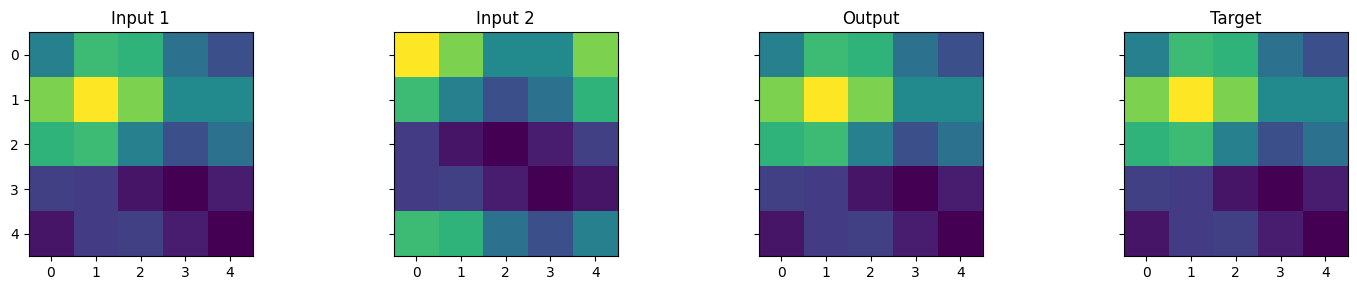

Epoch 29110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29200/50000, Loss: 0.000000


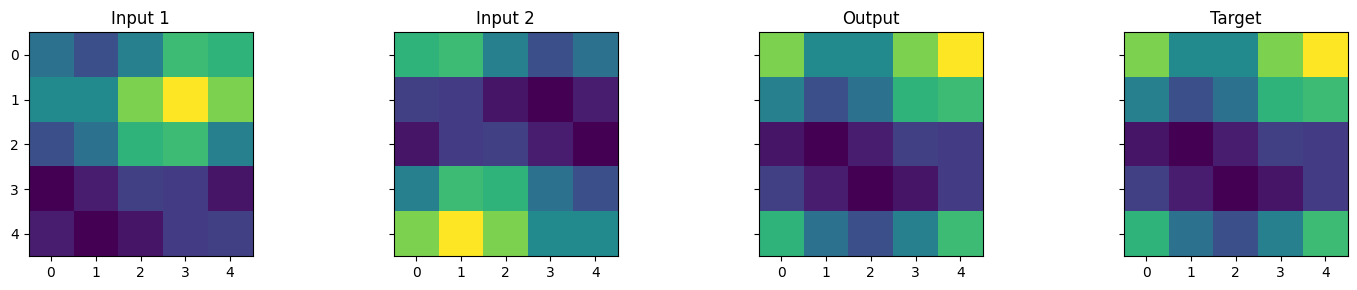

Epoch 29210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29300/50000, Loss: 0.000000


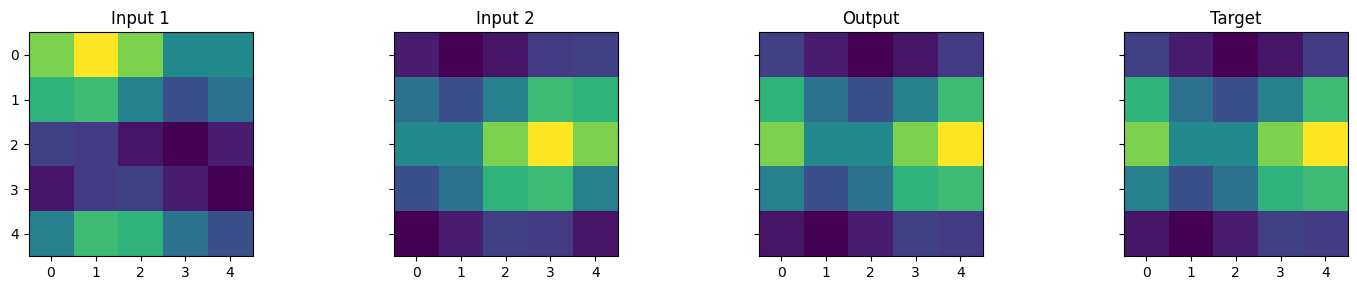

Epoch 29310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29400/50000, Loss: 0.000000


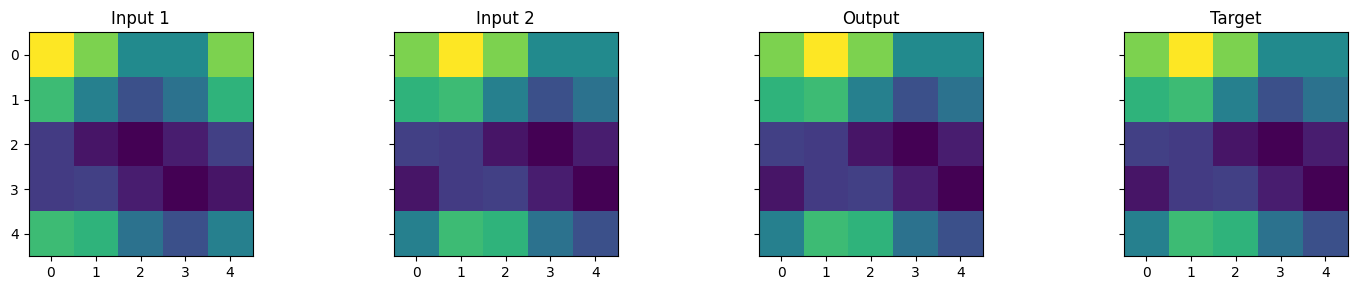

Epoch 29410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29500/50000, Loss: 0.000000


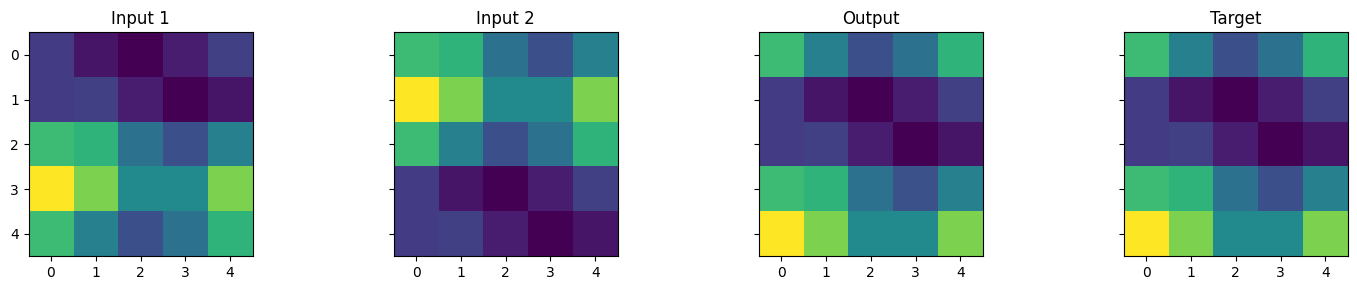

Epoch 29510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29600/50000, Loss: 0.000000


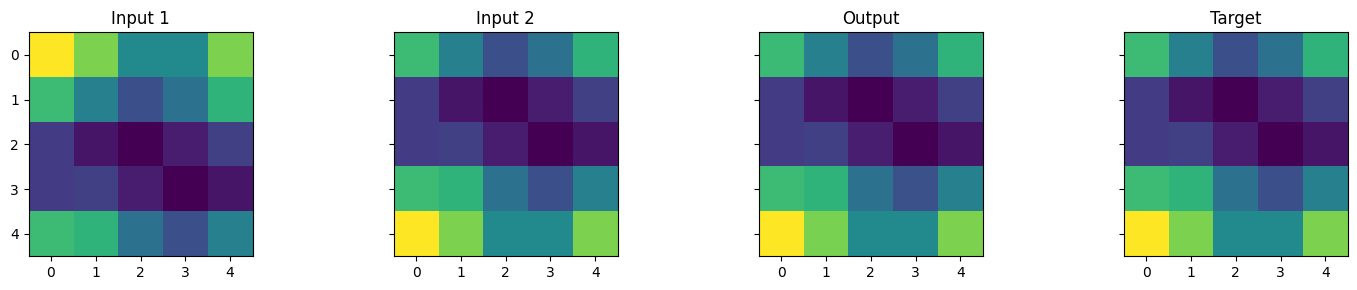

Epoch 29610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29700/50000, Loss: 0.000000


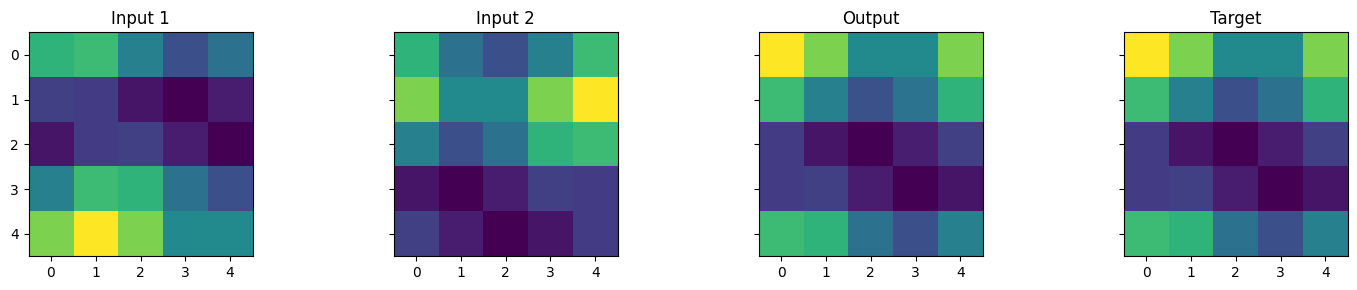

Epoch 29710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29800/50000, Loss: 0.000000


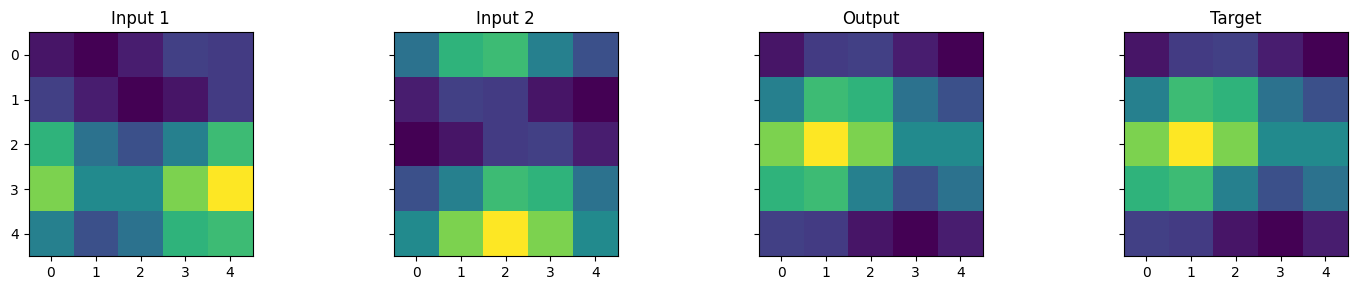

Epoch 29810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29900/50000, Loss: 0.000000


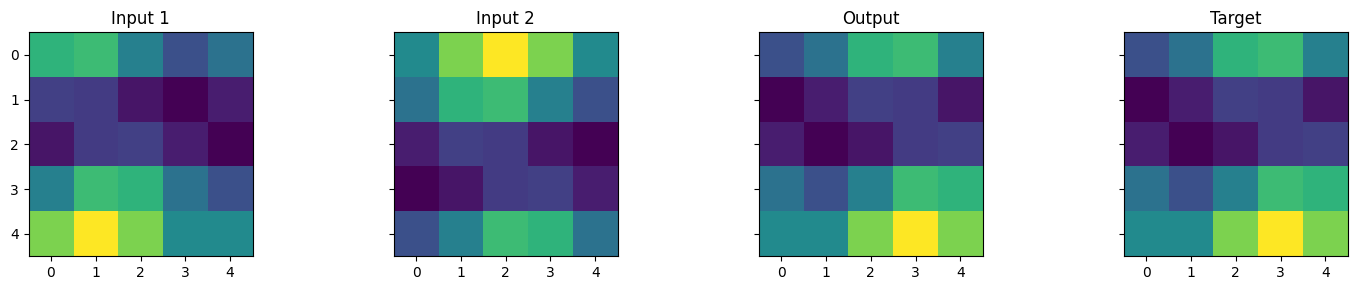

Epoch 29910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 29990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30000/50000, Loss: 0.000000


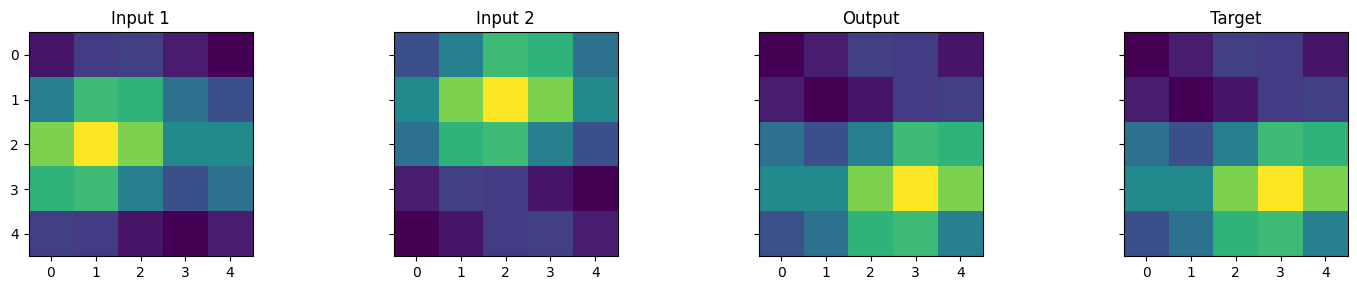

Epoch 30010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30100/50000, Loss: 0.000000


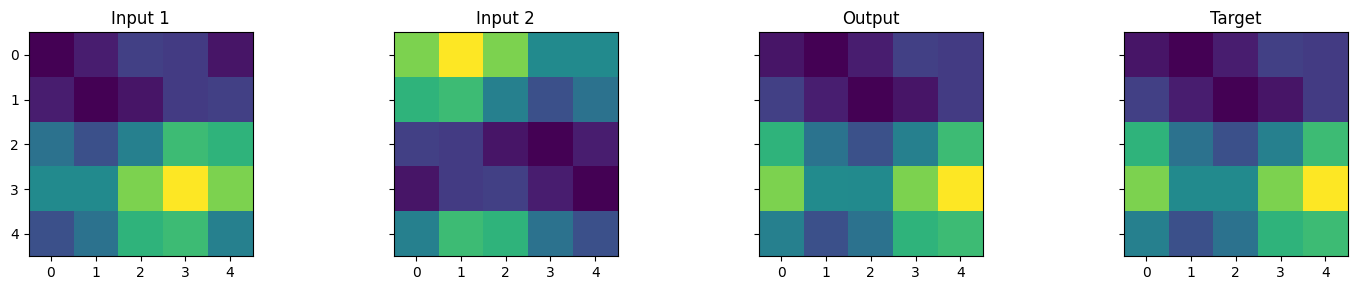

Epoch 30110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30200/50000, Loss: 0.000000


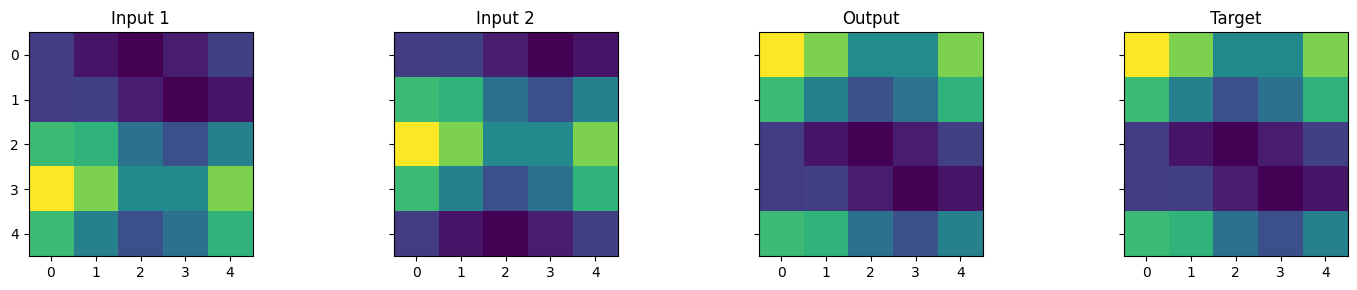

Epoch 30210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30300/50000, Loss: 0.000000


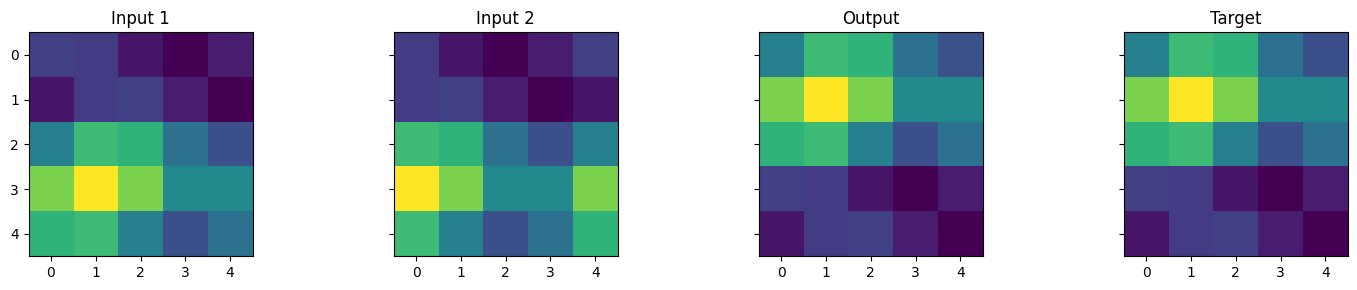

Epoch 30310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30400/50000, Loss: 0.000000


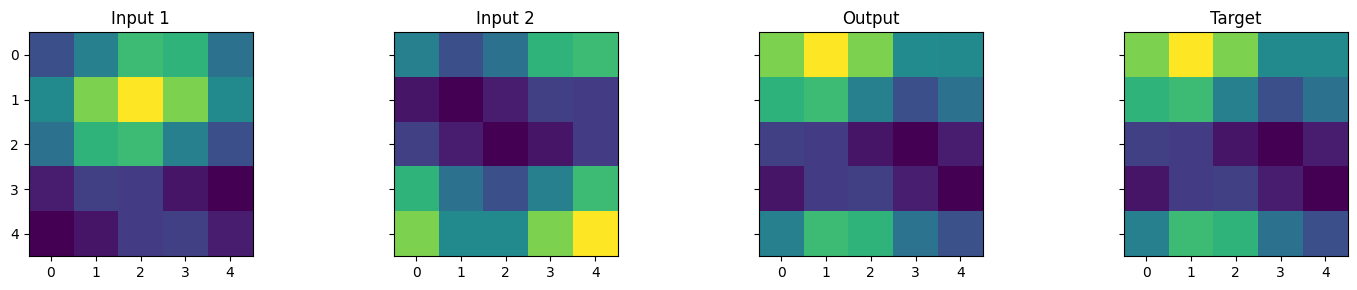

Epoch 30410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30500/50000, Loss: 0.000000


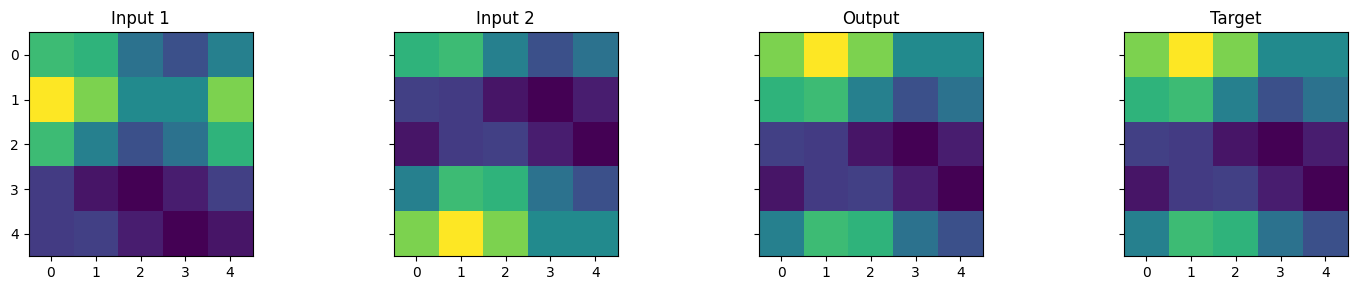

Epoch 30510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30600/50000, Loss: 0.000000


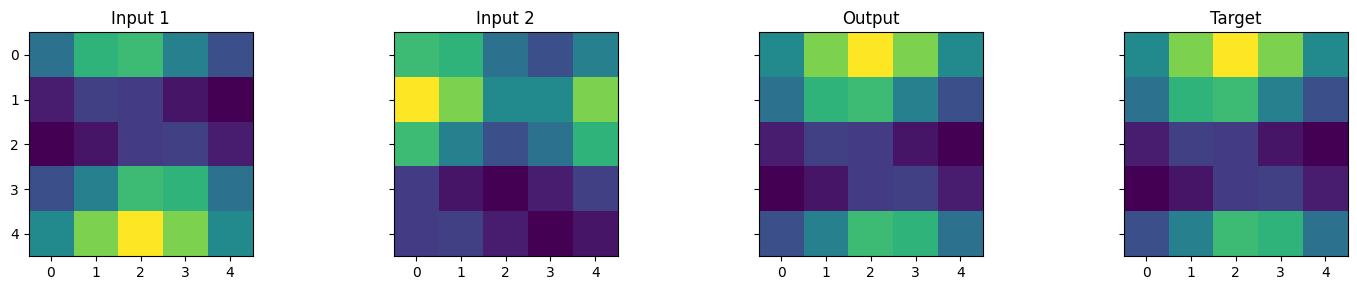

Epoch 30610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30700/50000, Loss: 0.000000


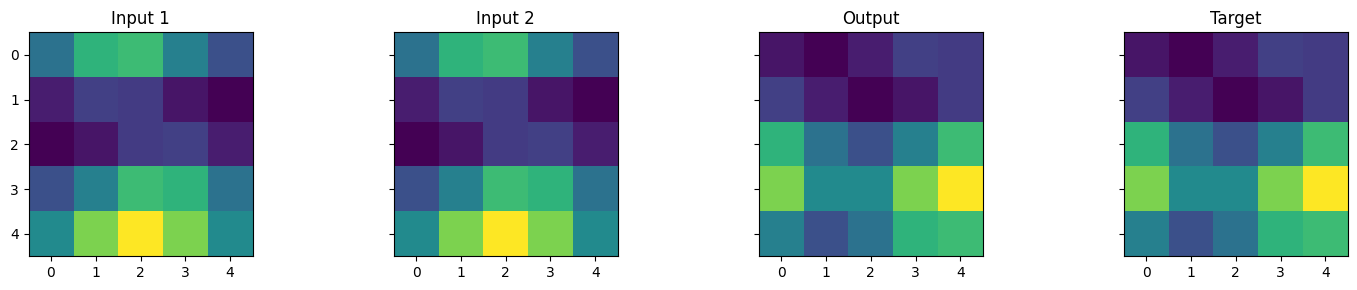

Epoch 30710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30800/50000, Loss: 0.000000


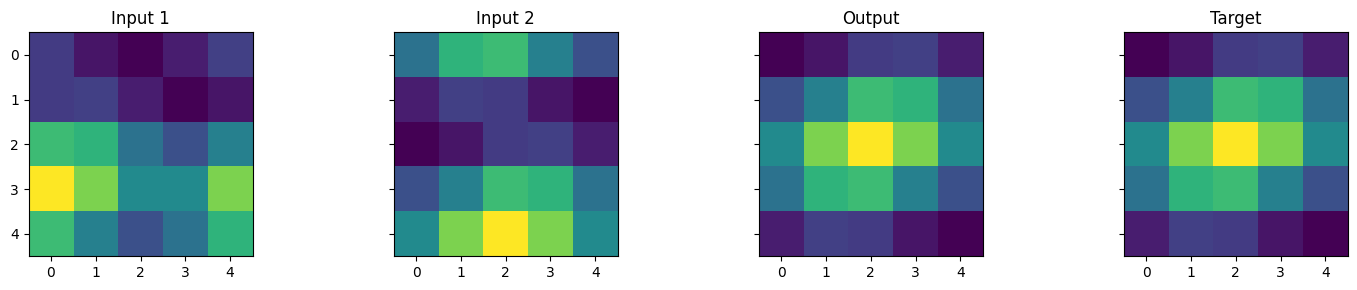

Epoch 30810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30900/50000, Loss: 0.000000


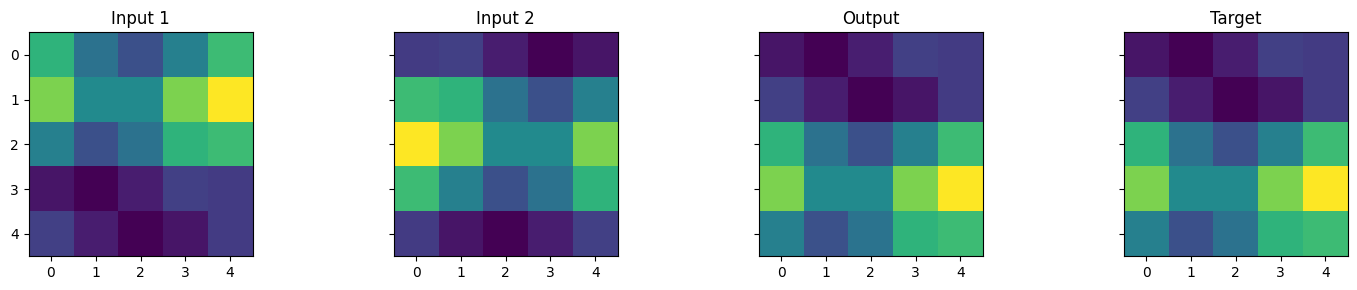

Epoch 30910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 30990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31000/50000, Loss: 0.000000


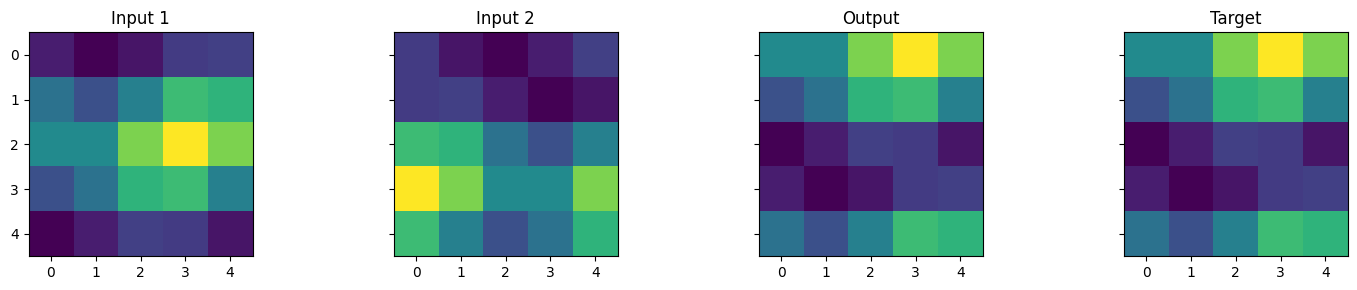

Epoch 31010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31100/50000, Loss: 0.000000


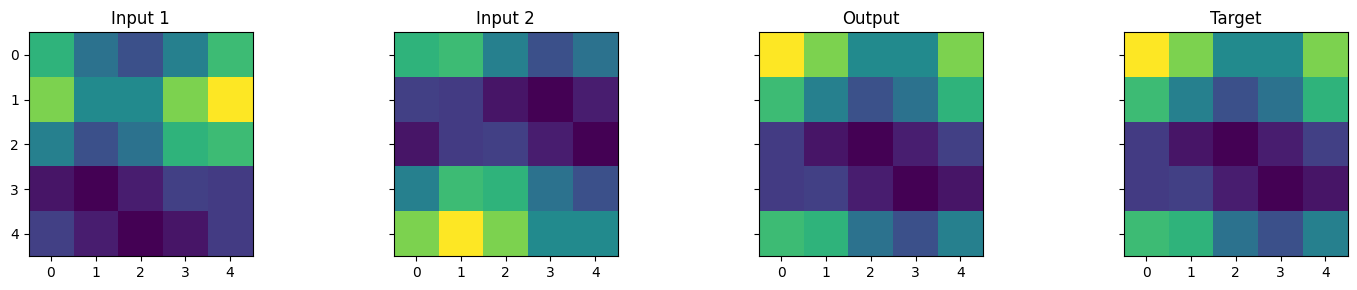

Epoch 31110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31200/50000, Loss: 0.000000


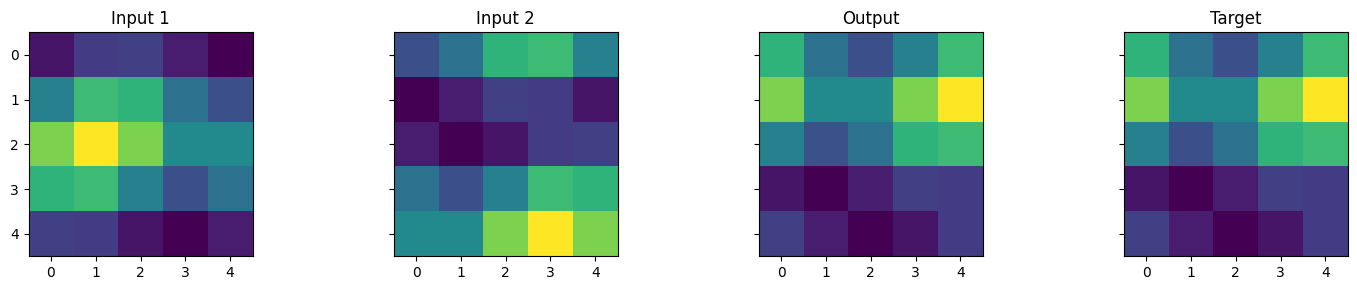

Epoch 31210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31300/50000, Loss: 0.000000


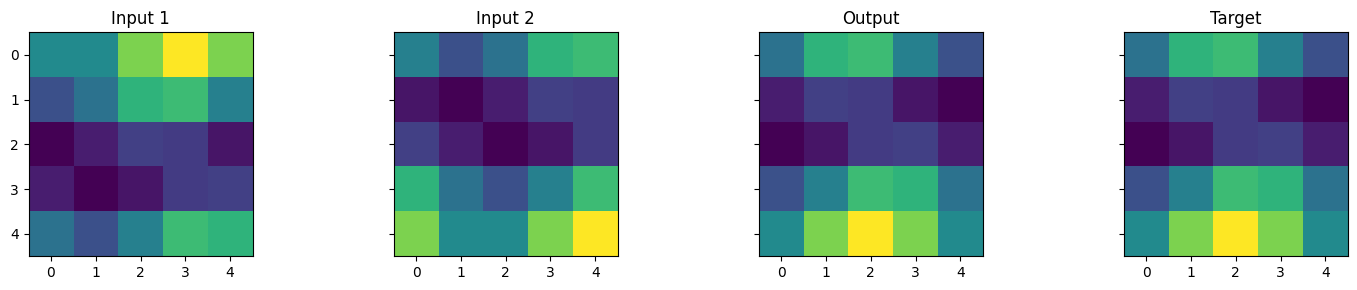

Epoch 31310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31400/50000, Loss: 0.000000


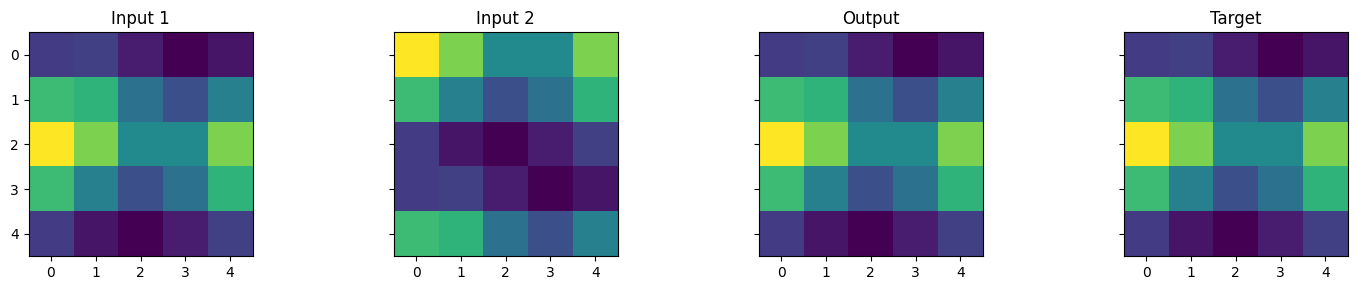

Epoch 31410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31500/50000, Loss: 0.000000


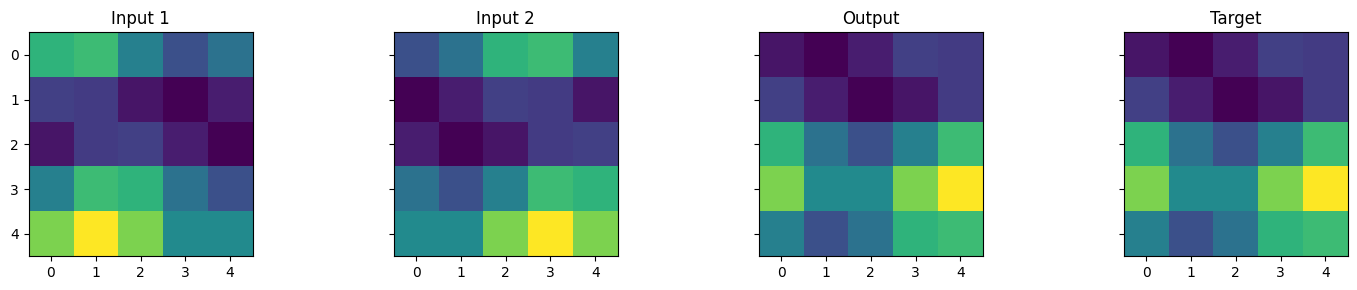

Epoch 31510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31600/50000, Loss: 0.000000


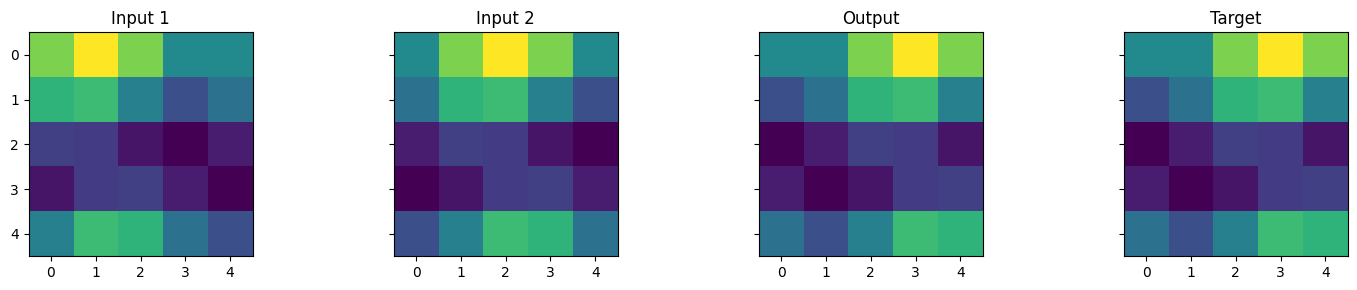

Epoch 31610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31700/50000, Loss: 0.000000


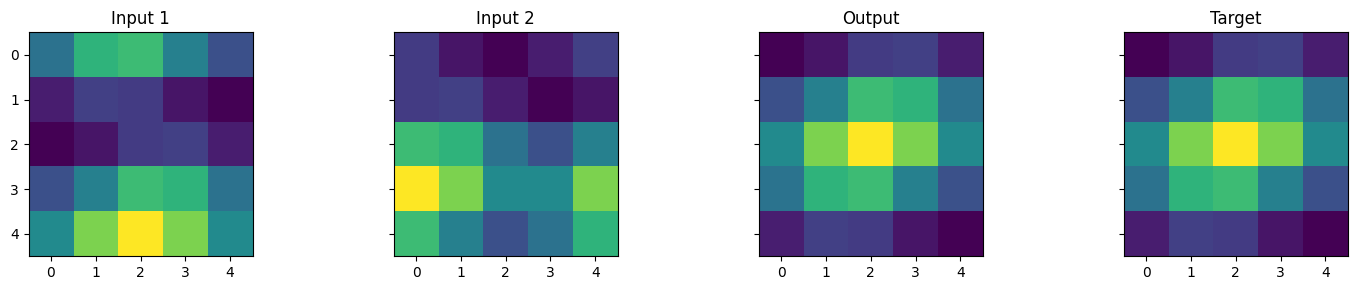

Epoch 31710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31800/50000, Loss: 0.000000


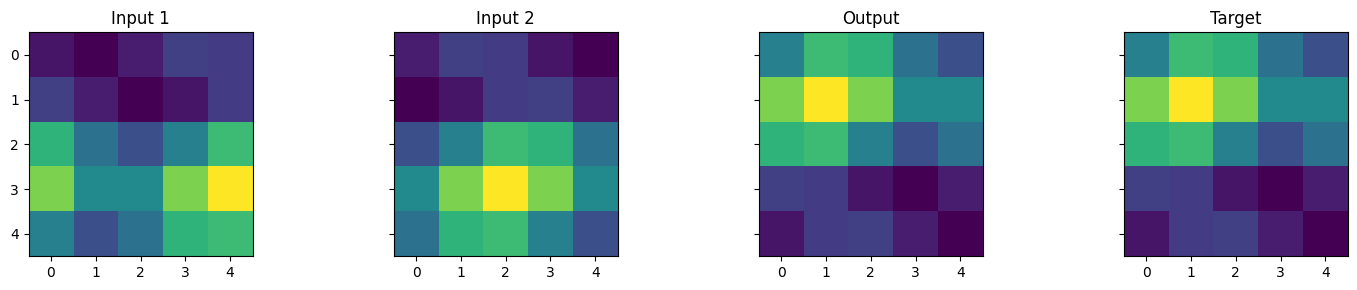

Epoch 31810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31900/50000, Loss: 0.000000


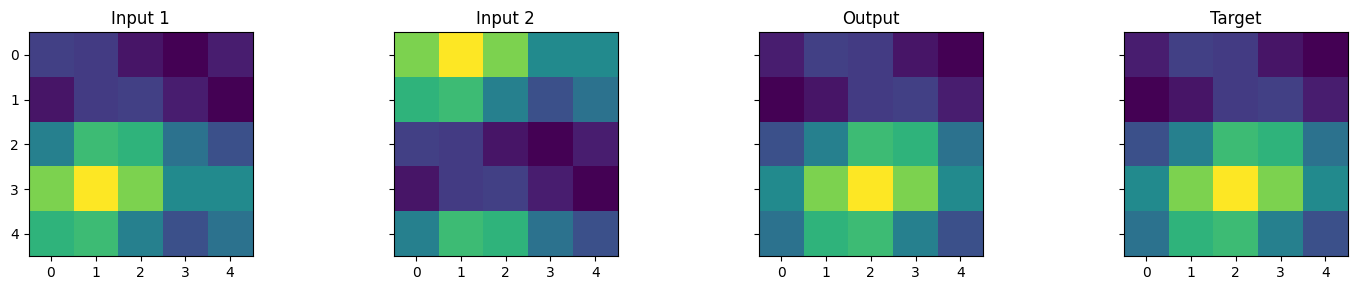

Epoch 31910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 31990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32000/50000, Loss: 0.000000


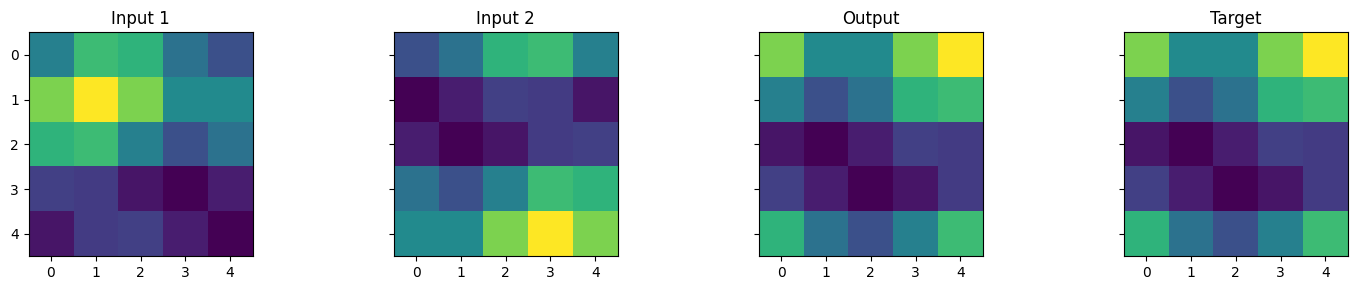

Epoch 32010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32100/50000, Loss: 0.000000


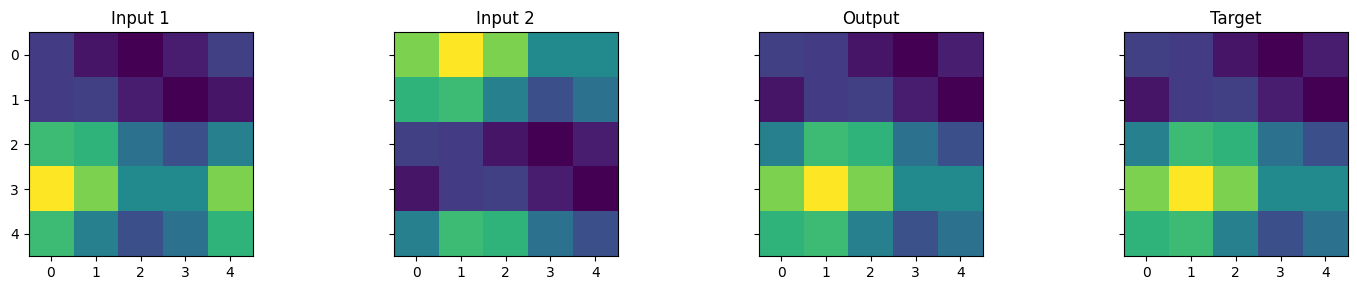

Epoch 32110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32200/50000, Loss: 0.000000


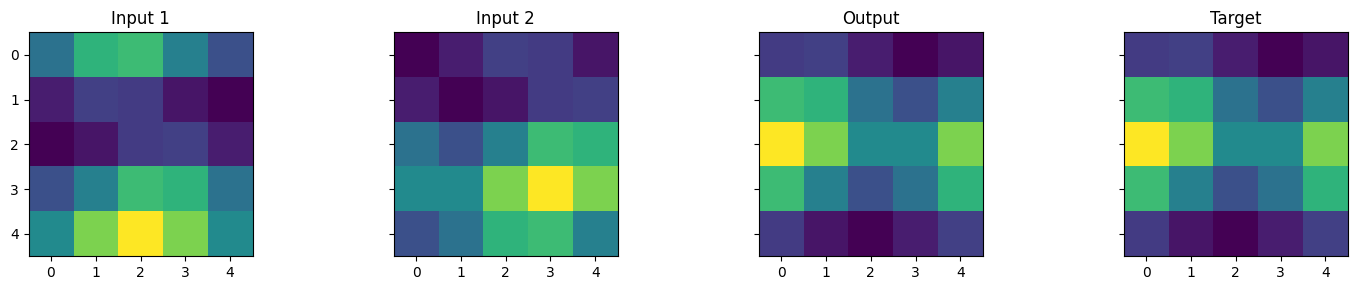

Epoch 32210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32300/50000, Loss: 0.000000


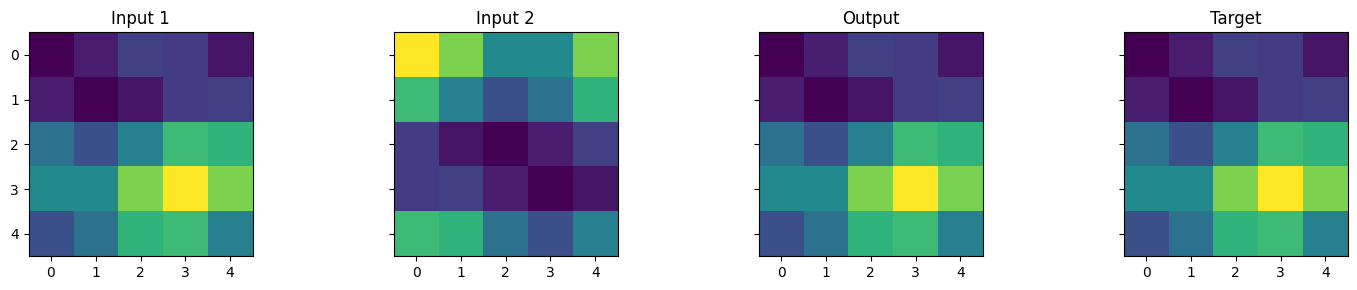

Epoch 32310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32400/50000, Loss: 0.000000


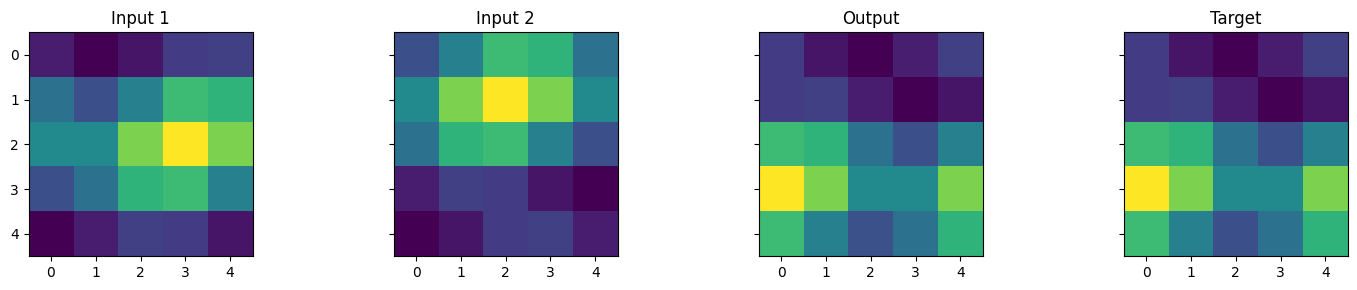

Epoch 32410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32500/50000, Loss: 0.000000


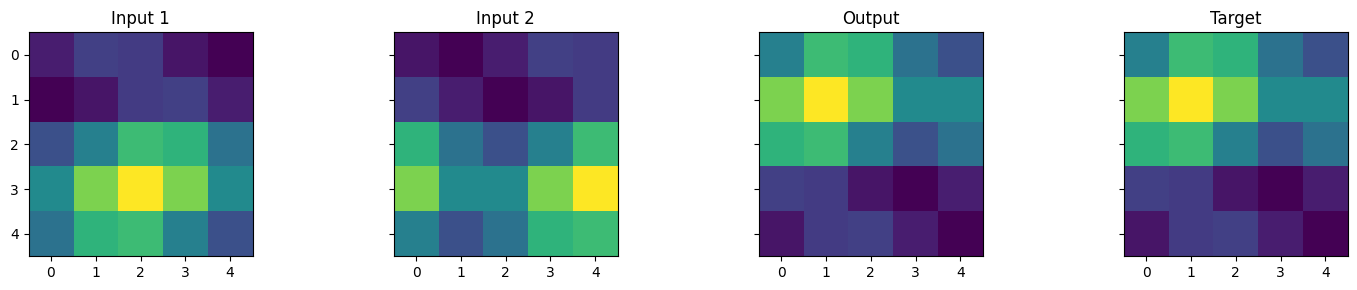

Epoch 32510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32600/50000, Loss: 0.000000


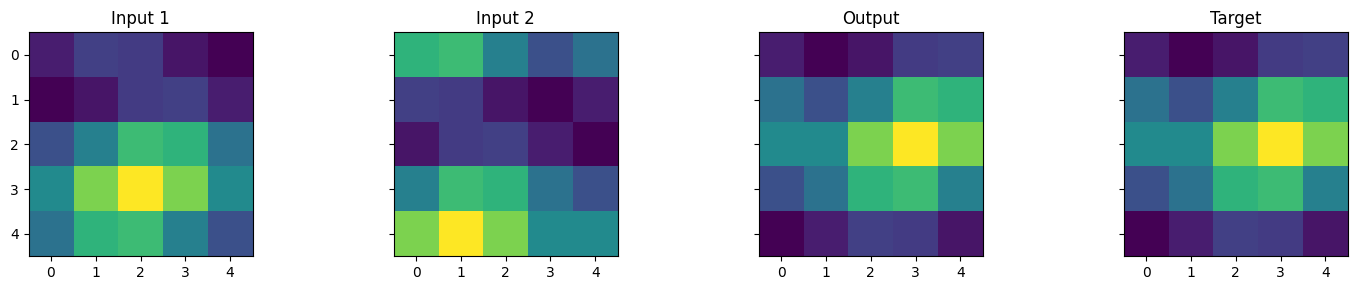

Epoch 32610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32700/50000, Loss: 0.000000


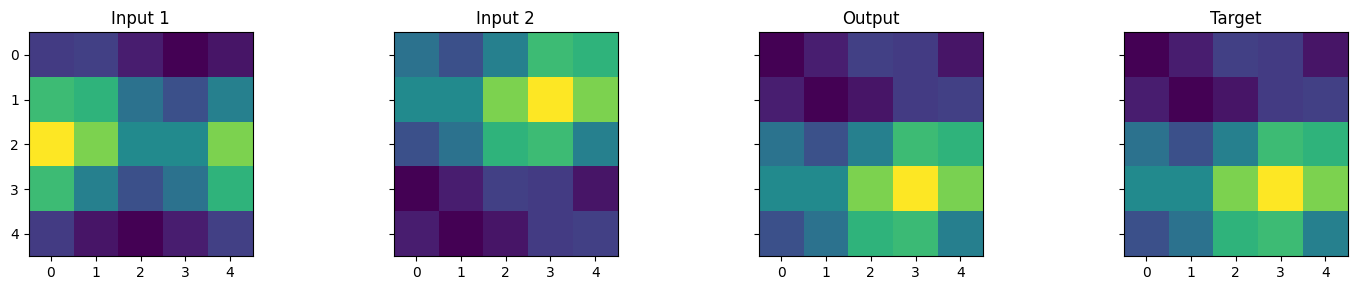

Epoch 32710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32800/50000, Loss: 0.000000


Epoch 32810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32900/50000, Loss: 0.000000


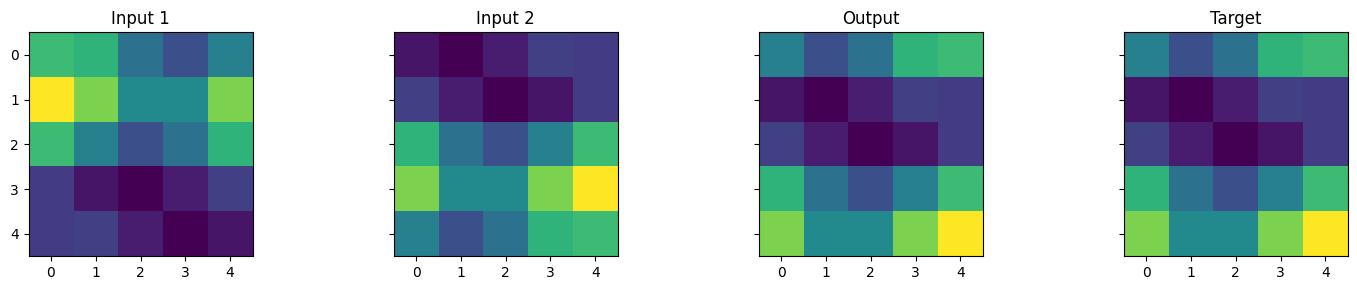

Epoch 32910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 32990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33000/50000, Loss: 0.000000


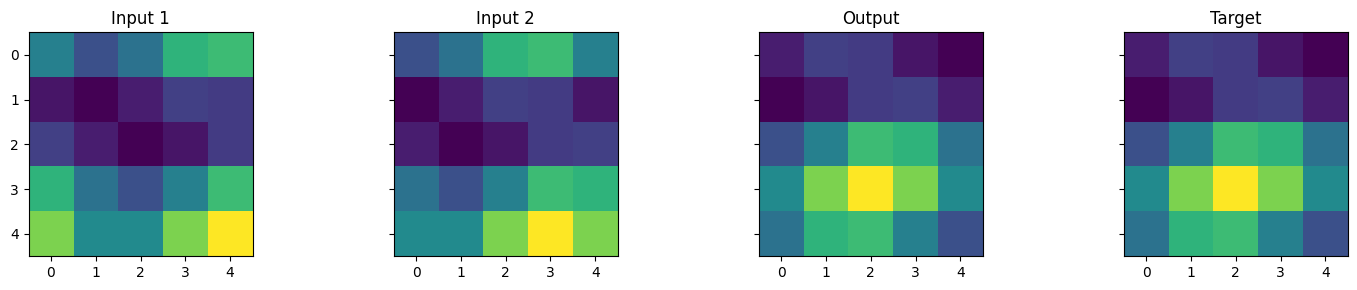

Epoch 33010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33100/50000, Loss: 0.000000


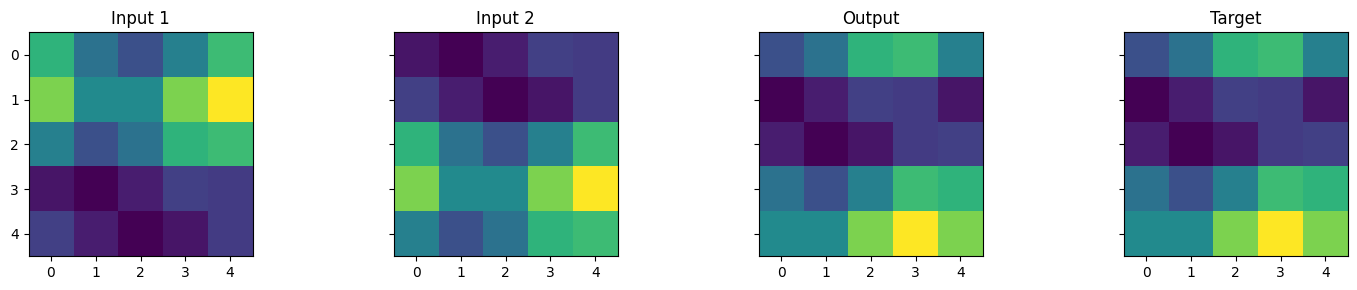

Epoch 33110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33200/50000, Loss: 0.000000


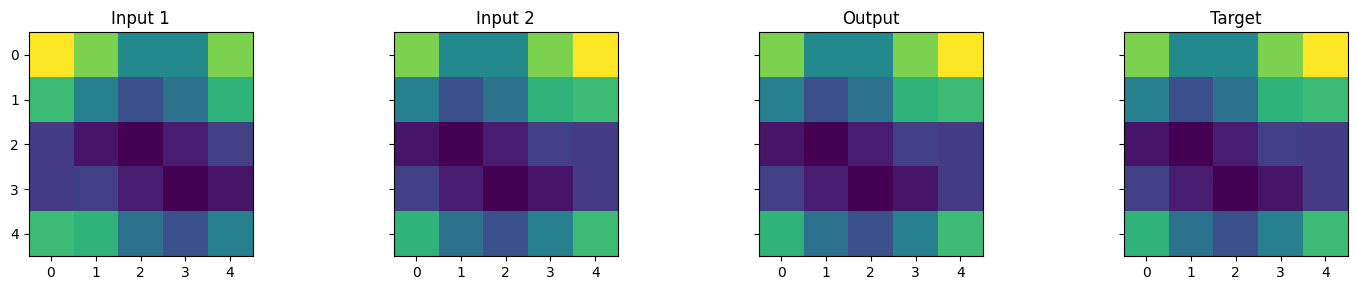

Epoch 33210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33300/50000, Loss: 0.000000


Epoch 33310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33400/50000, Loss: 0.000000


Epoch 33410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33500/50000, Loss: 0.000000


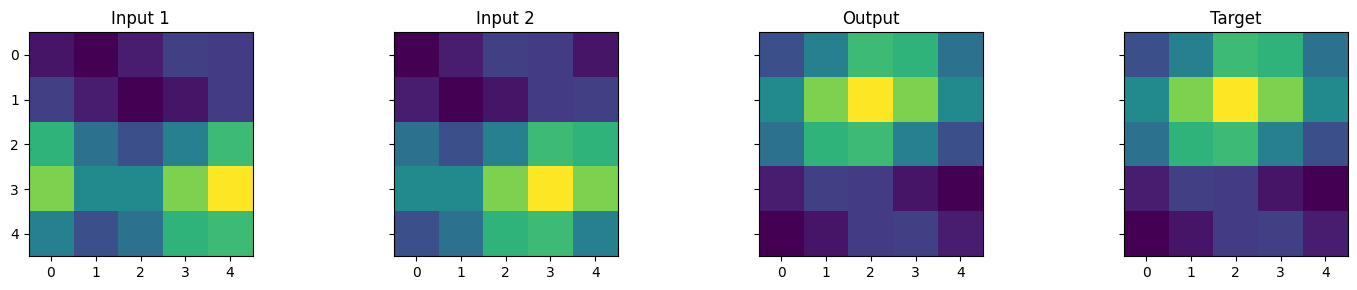

Epoch 33510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33600/50000, Loss: 0.000000


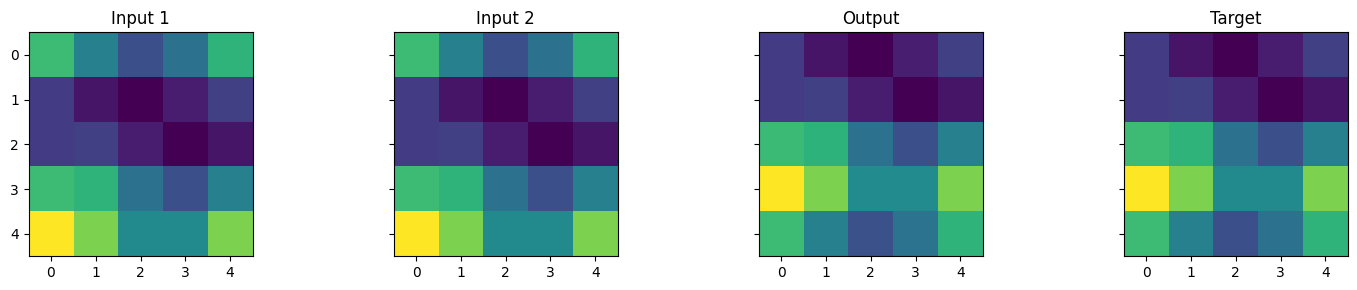

Epoch 33610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33700/50000, Loss: 0.000000


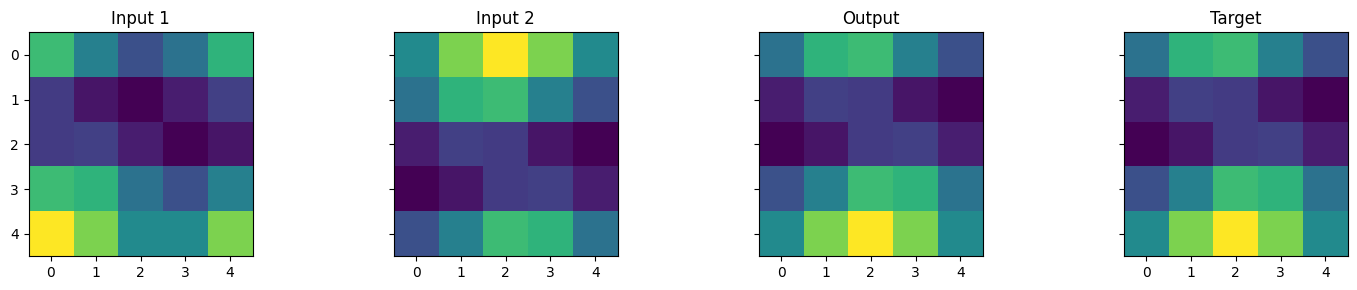

Epoch 33710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33800/50000, Loss: 0.000000


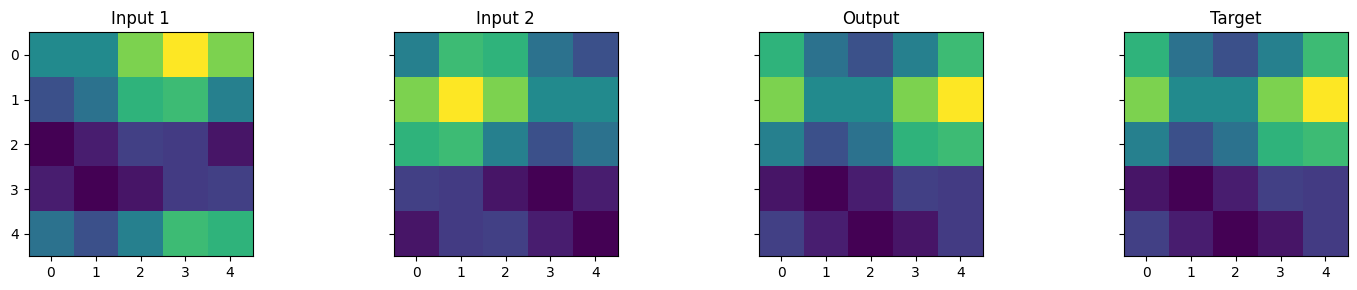

Epoch 33810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33900/50000, Loss: 0.000000


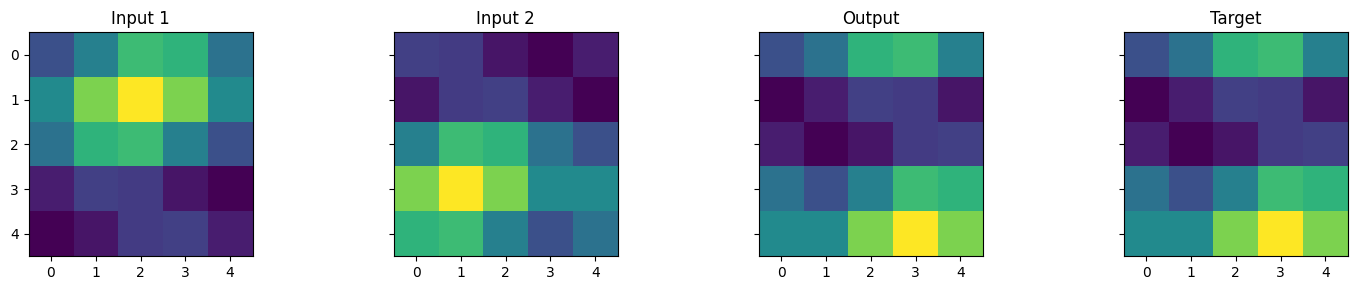

Epoch 33910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 33990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34000/50000, Loss: 0.000000


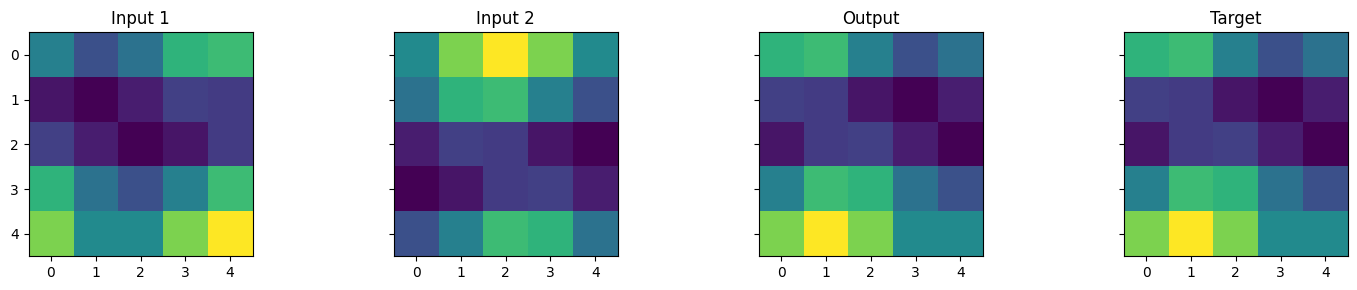

Epoch 34010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34100/50000, Loss: 0.000001


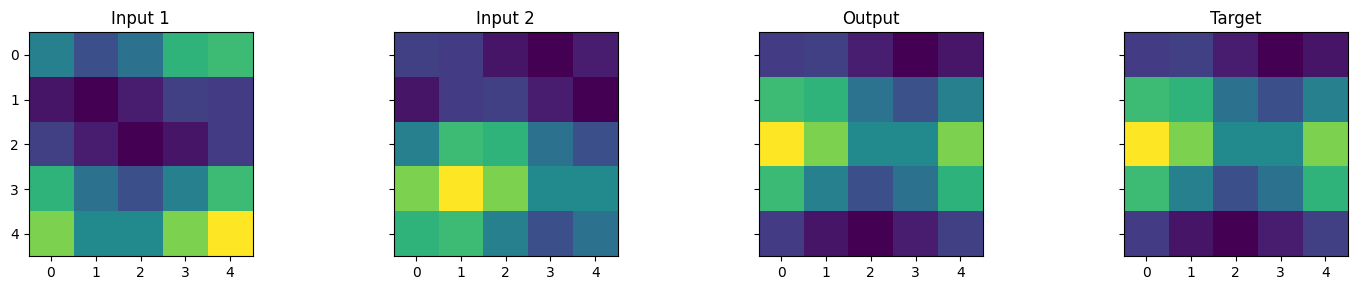

Epoch 34110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34200/50000, Loss: 0.000000


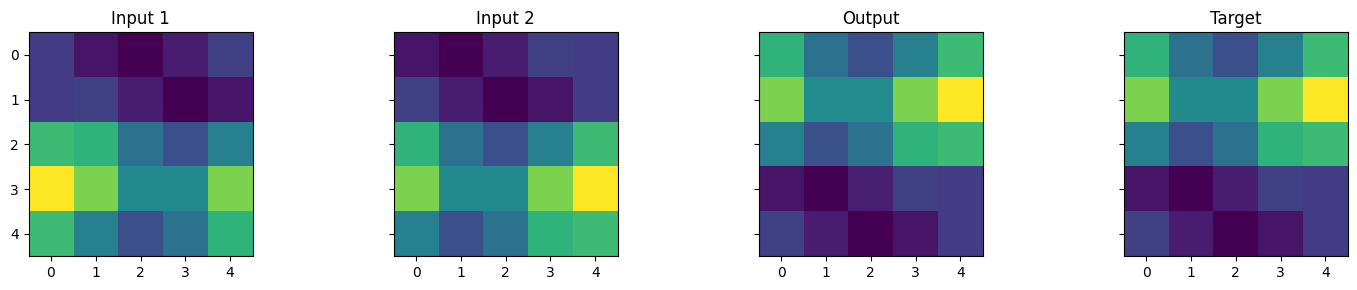

Epoch 34210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34300/50000, Loss: 0.000000


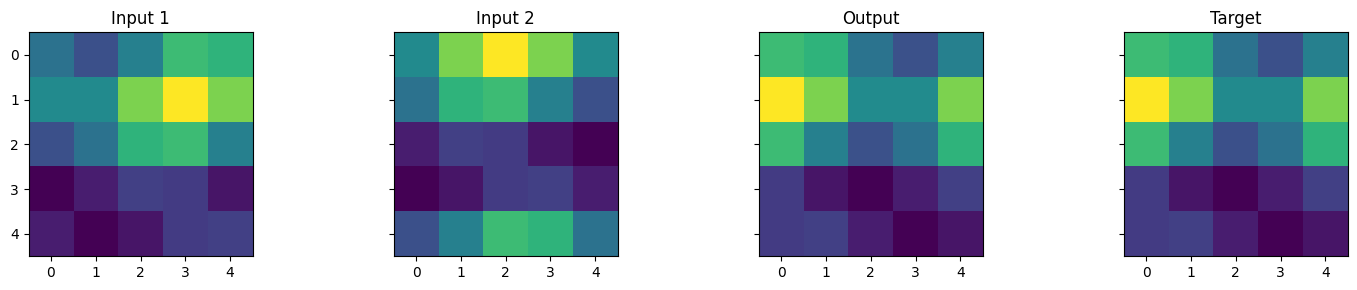

Epoch 34310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34400/50000, Loss: 0.000000


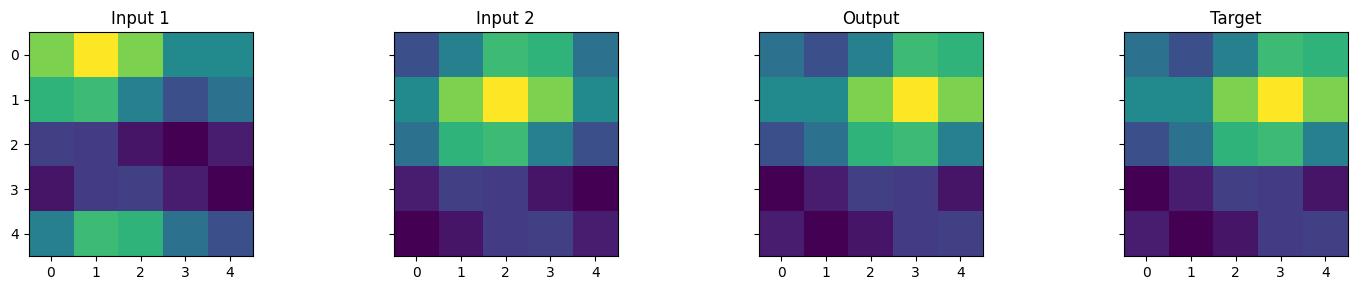

Epoch 34410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34500/50000, Loss: 0.000000


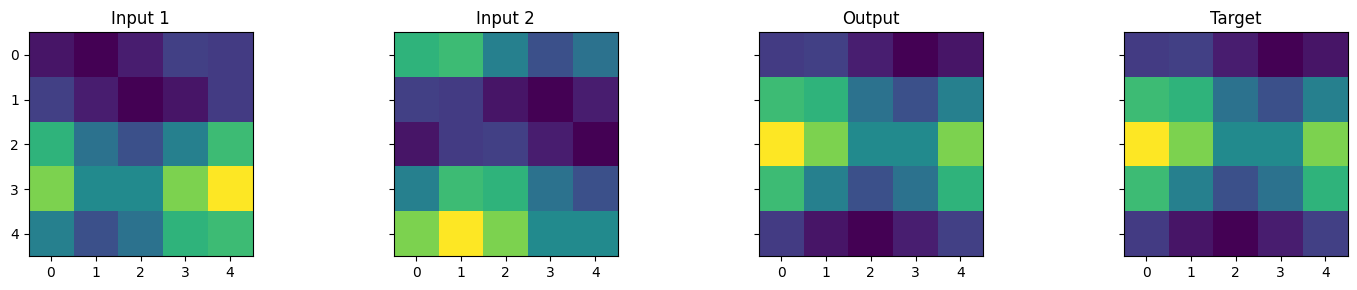

Epoch 34510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34600/50000, Loss: 0.000000


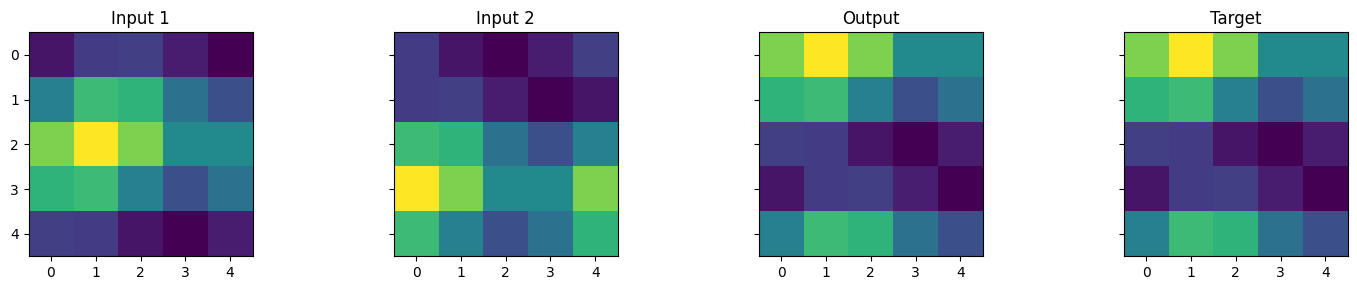

Epoch 34610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34700/50000, Loss: 0.000000


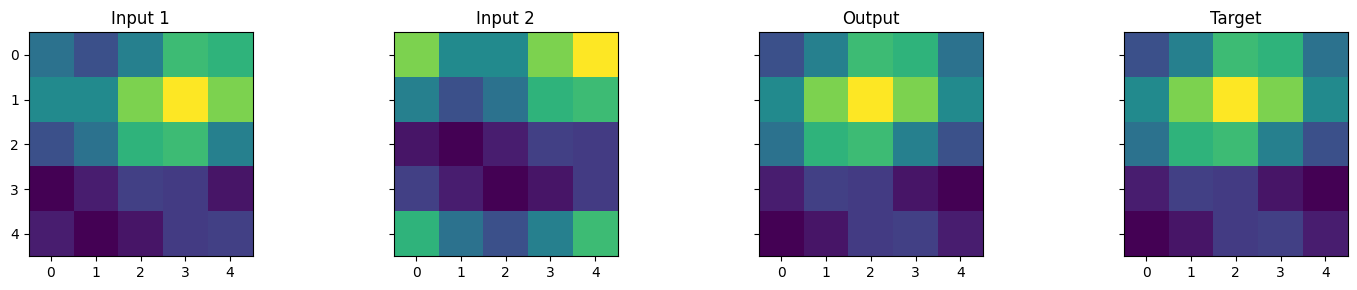

Epoch 34710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34800/50000, Loss: 0.000000


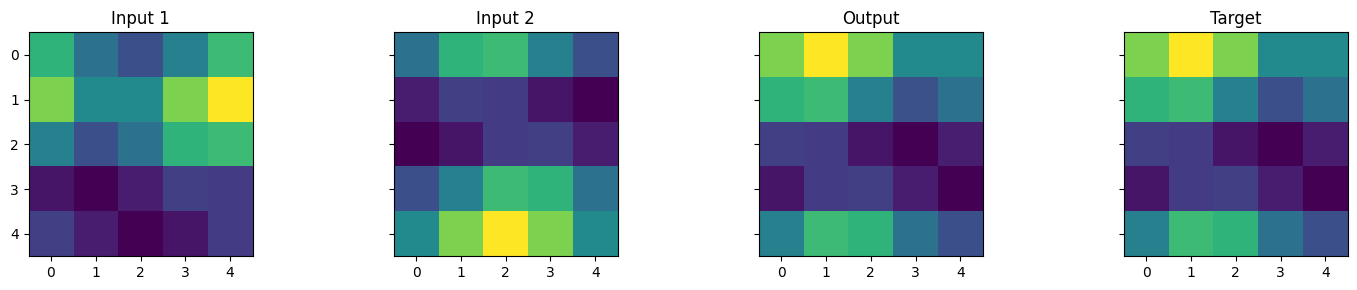

Epoch 34810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34900/50000, Loss: 0.000000


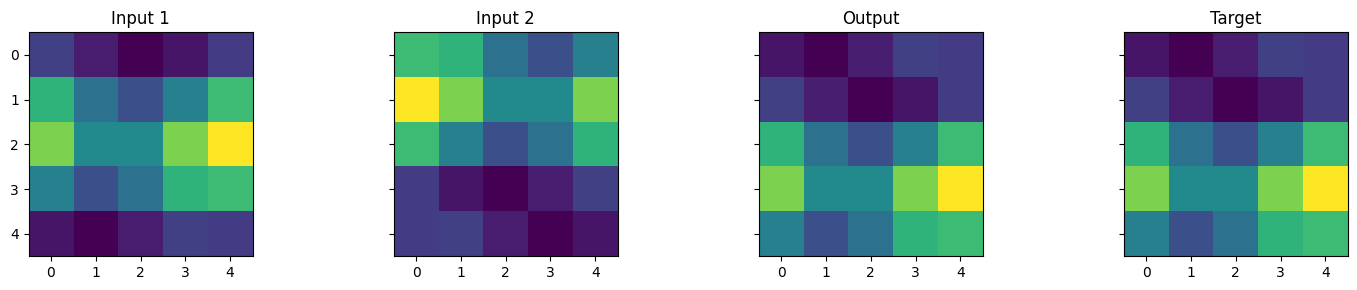

Epoch 34910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 34990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35000/50000, Loss: 0.000000


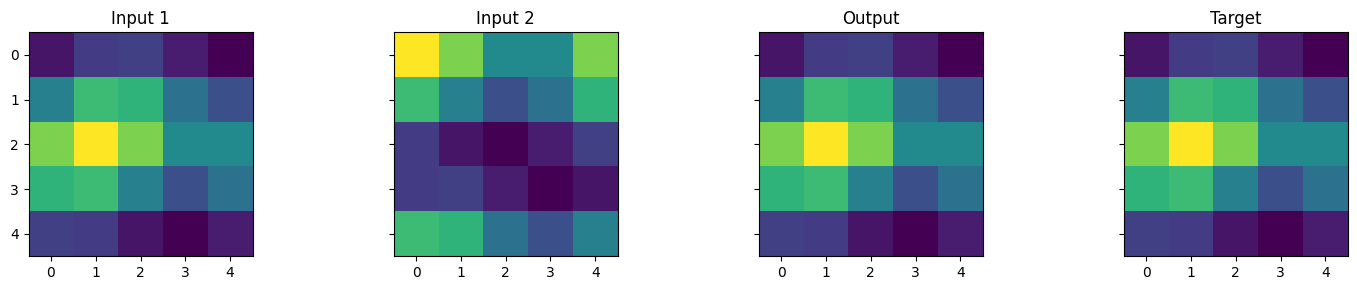

Epoch 35010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35100/50000, Loss: 0.000000


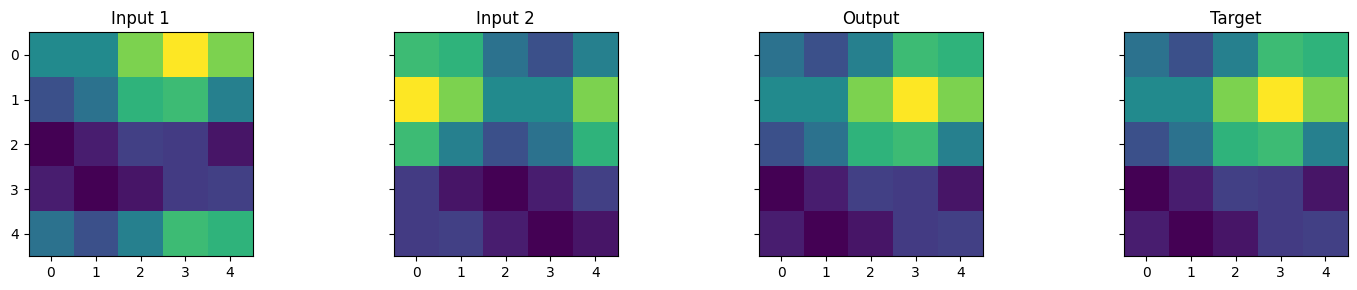

Epoch 35110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35200/50000, Loss: 0.000000


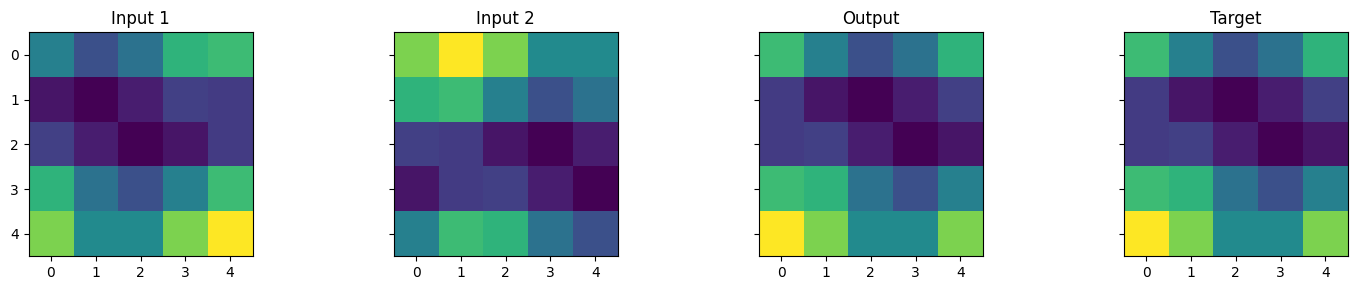

Epoch 35210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35300/50000, Loss: 0.000000


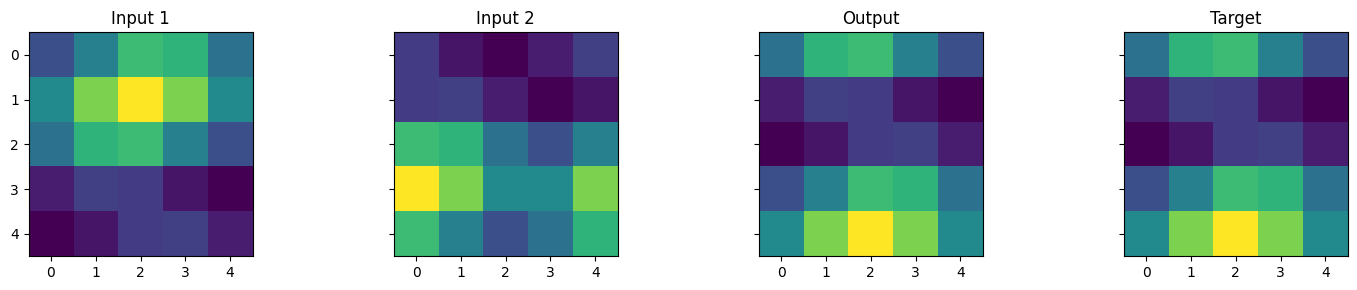

Epoch 35310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35400/50000, Loss: 0.000001


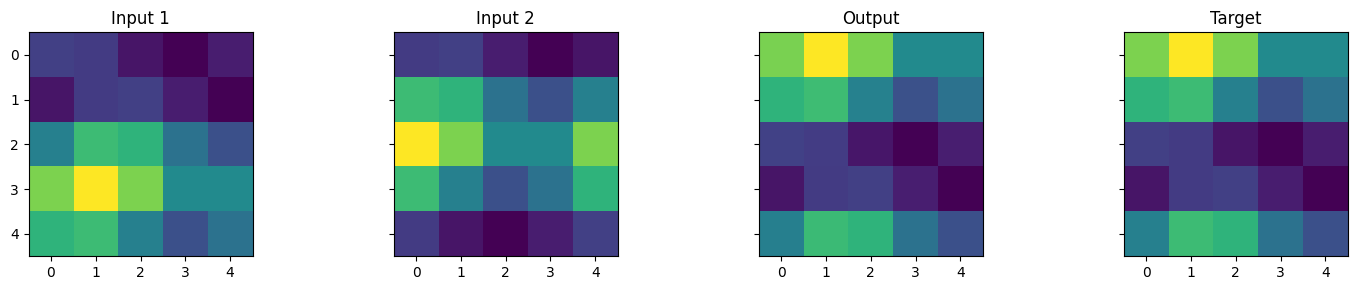

Epoch 35410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35500/50000, Loss: 0.000000


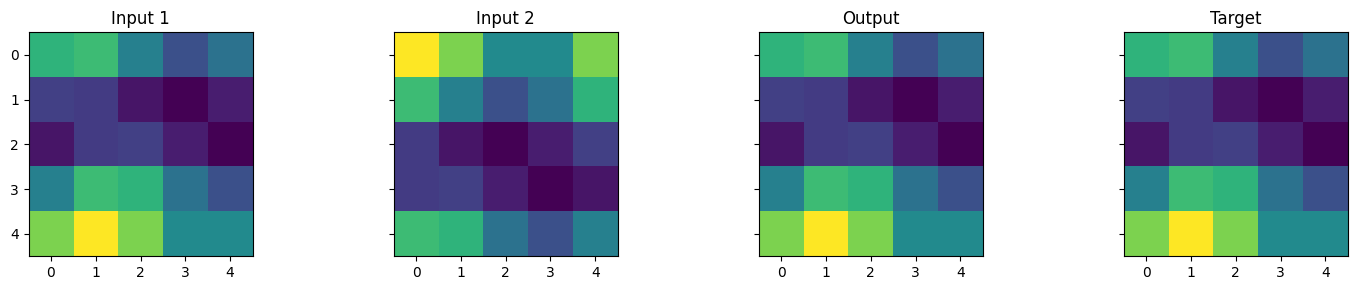

Epoch 35510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35600/50000, Loss: 0.000000


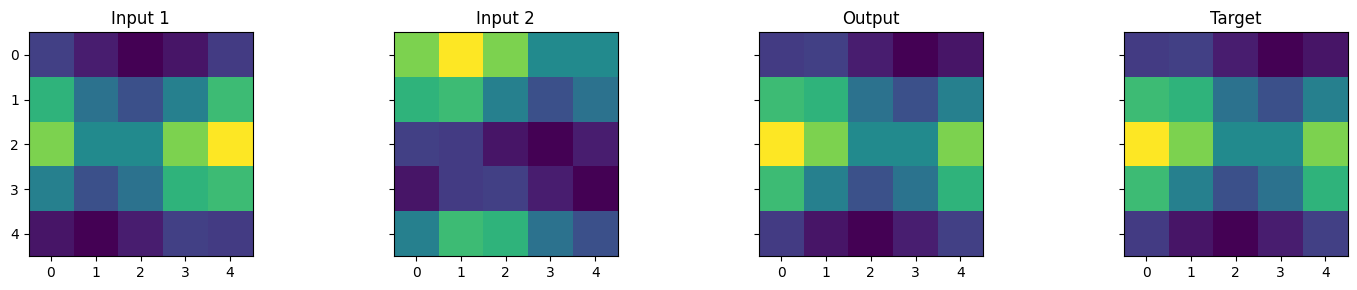

Epoch 35610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35700/50000, Loss: 0.000000


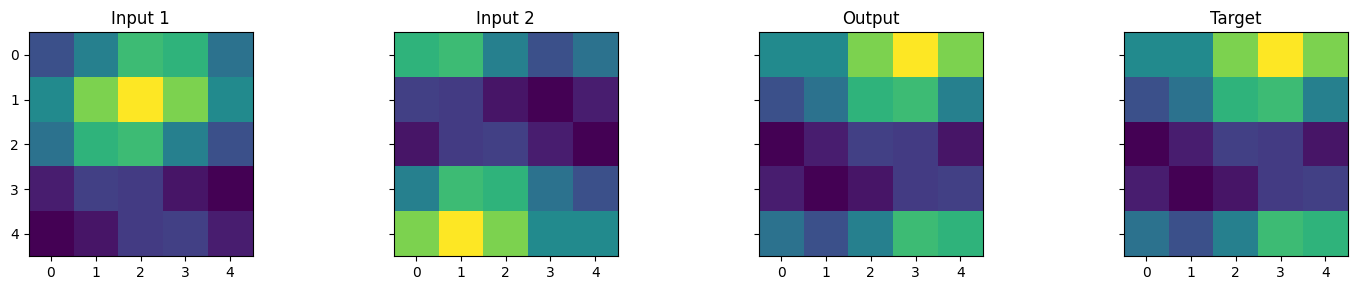

Epoch 35710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35800/50000, Loss: 0.000000


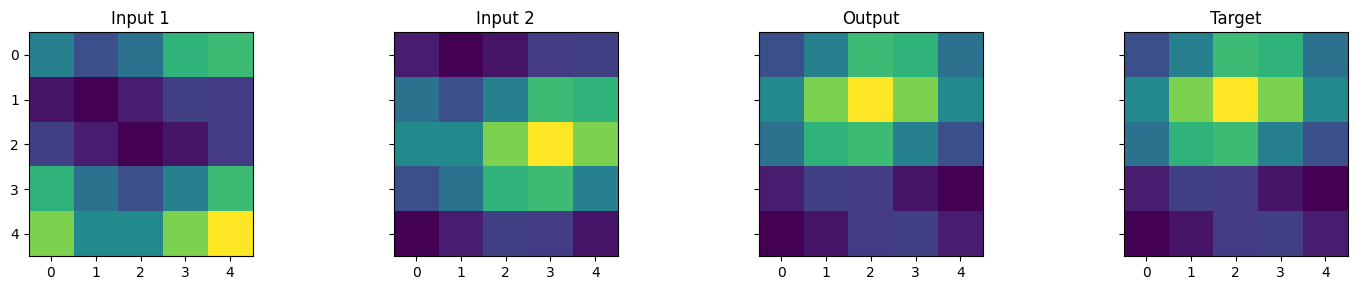

Epoch 35810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35900/50000, Loss: 0.000000


Epoch 35910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 35990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36000/50000, Loss: 0.000000


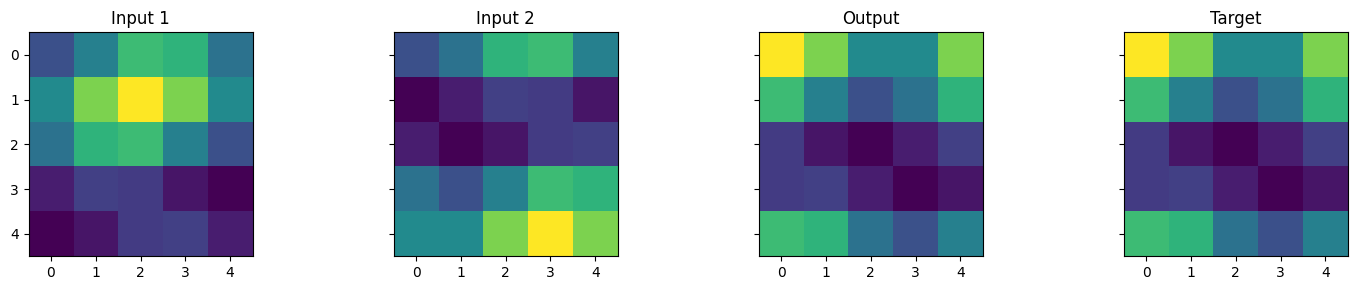

Epoch 36010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36100/50000, Loss: 0.000000


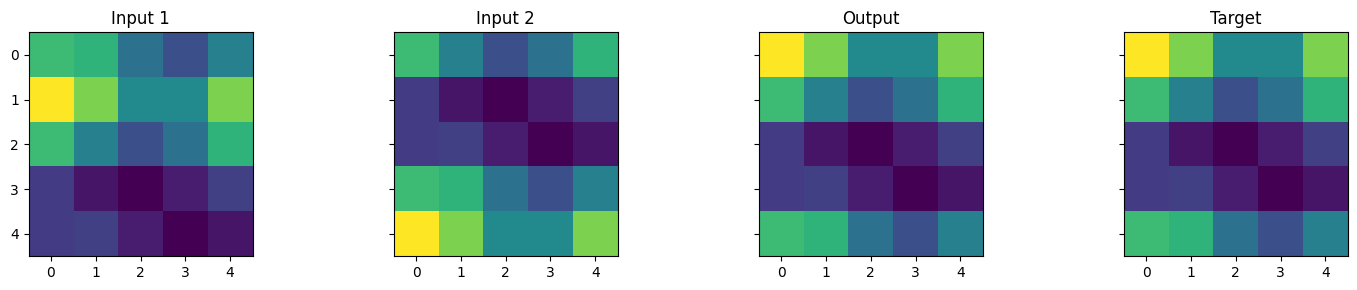

Epoch 36110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36200/50000, Loss: 0.000000


Epoch 36210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36300/50000, Loss: 0.000000


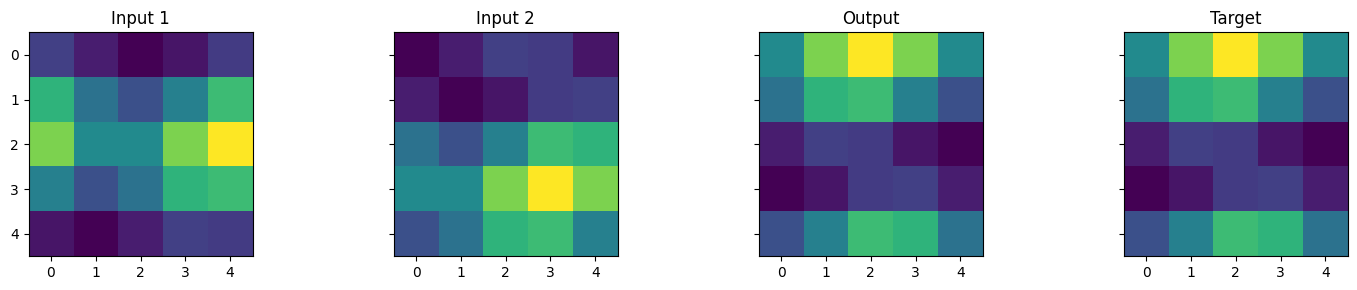

Epoch 36310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36400/50000, Loss: 0.000000


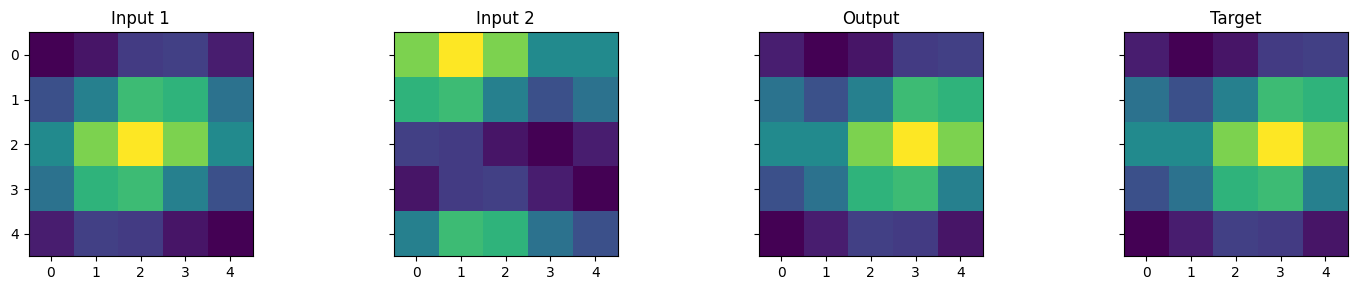

Epoch 36410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36500/50000, Loss: 0.000000


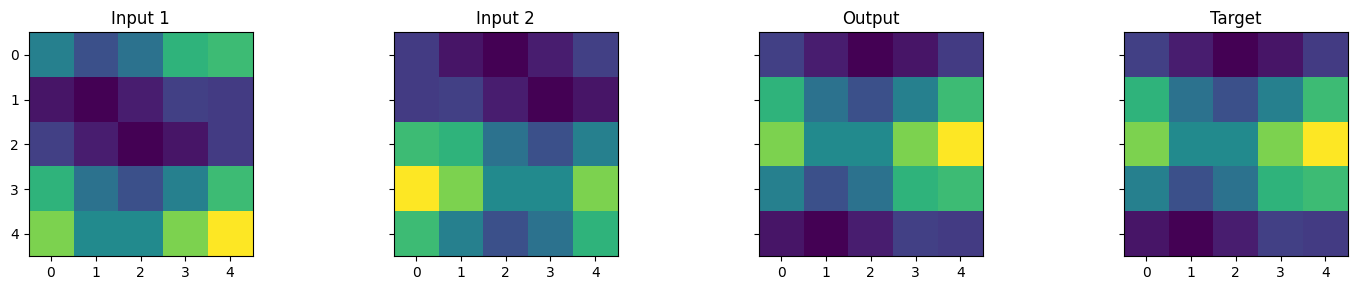

Epoch 36510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36600/50000, Loss: 0.000000


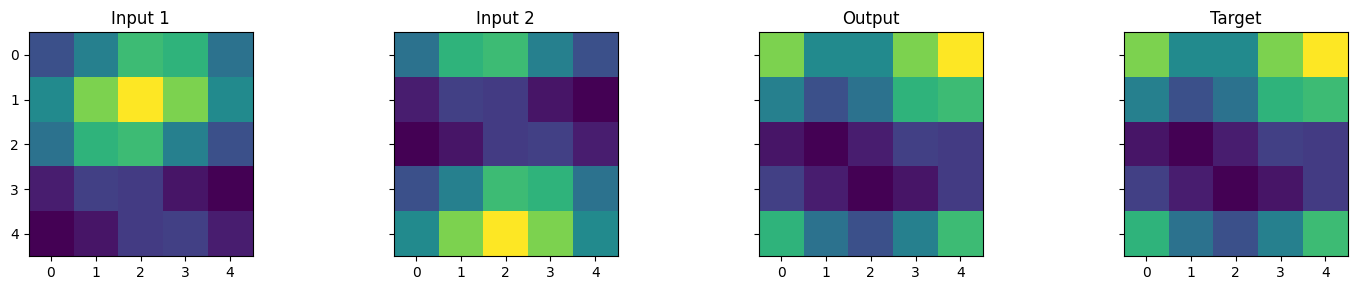

Epoch 36610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36700/50000, Loss: 0.000000


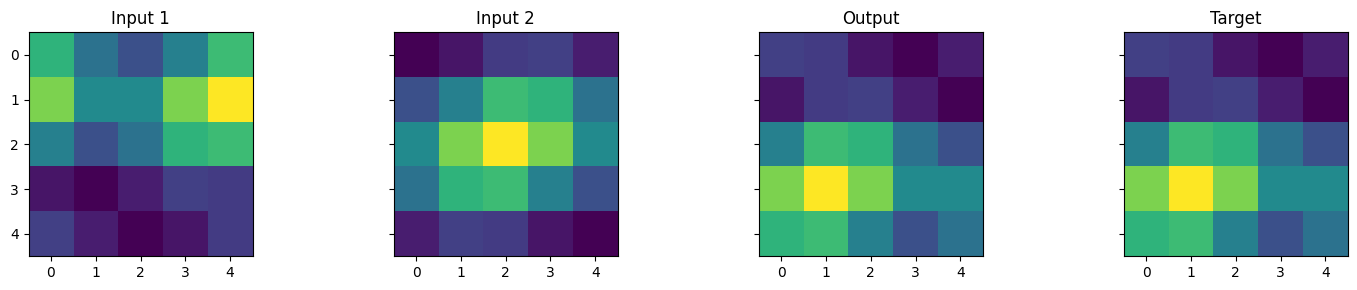

Epoch 36710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36800/50000, Loss: 0.000000


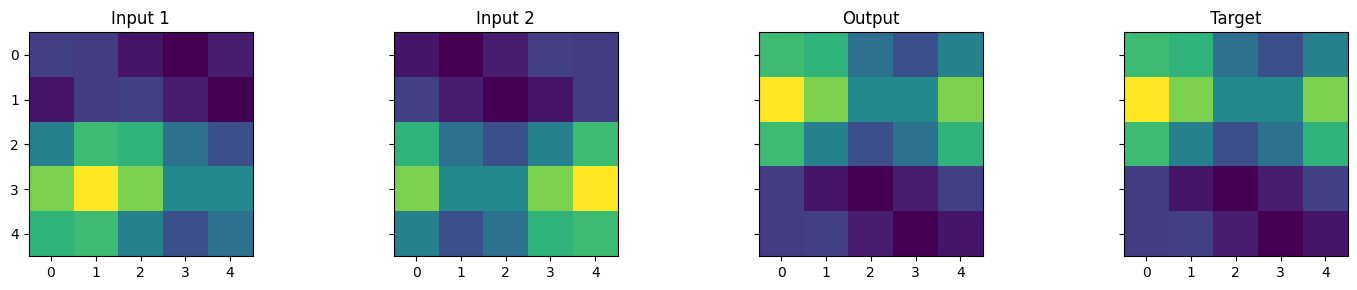

Epoch 36810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36900/50000, Loss: 0.000000


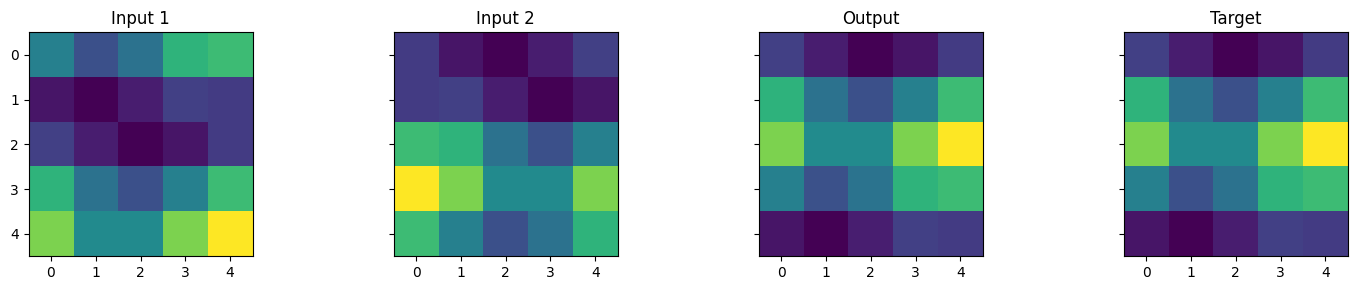

Epoch 36910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 36990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37000/50000, Loss: 0.000000


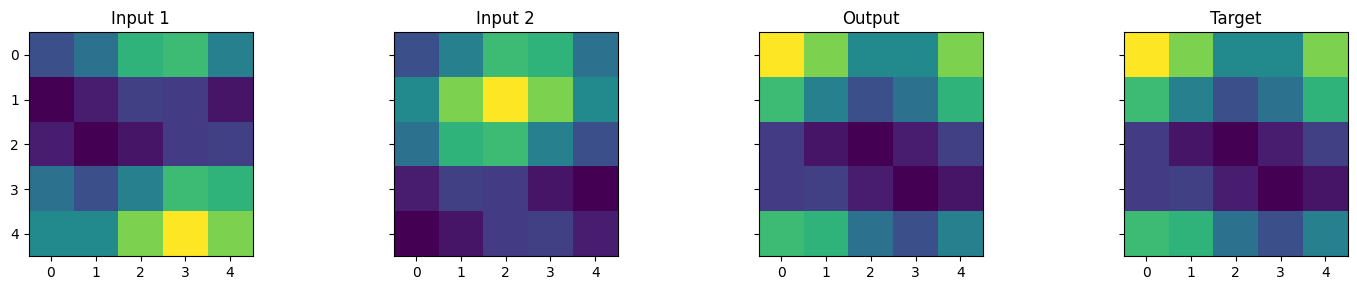

Epoch 37010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37100/50000, Loss: 0.000000


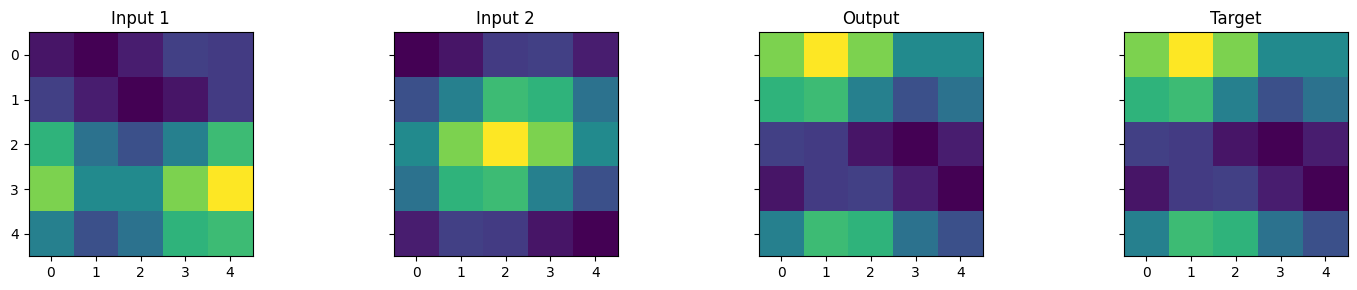

Epoch 37110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37200/50000, Loss: 0.000000


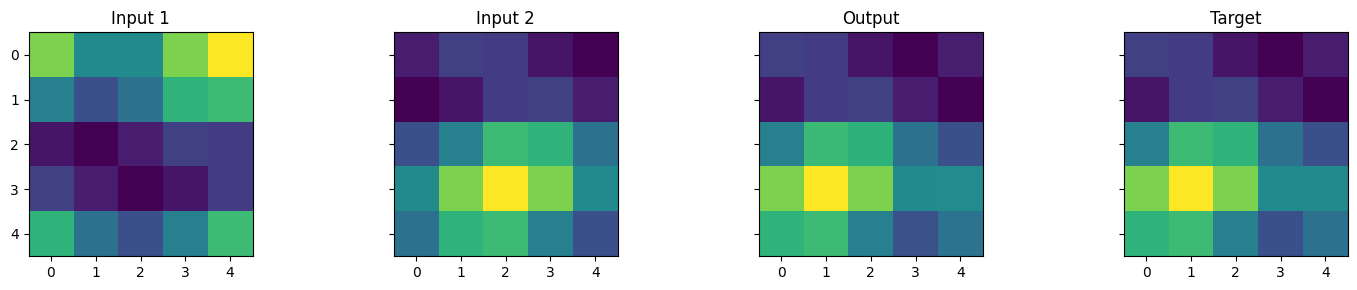

Epoch 37210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37300/50000, Loss: 0.000000


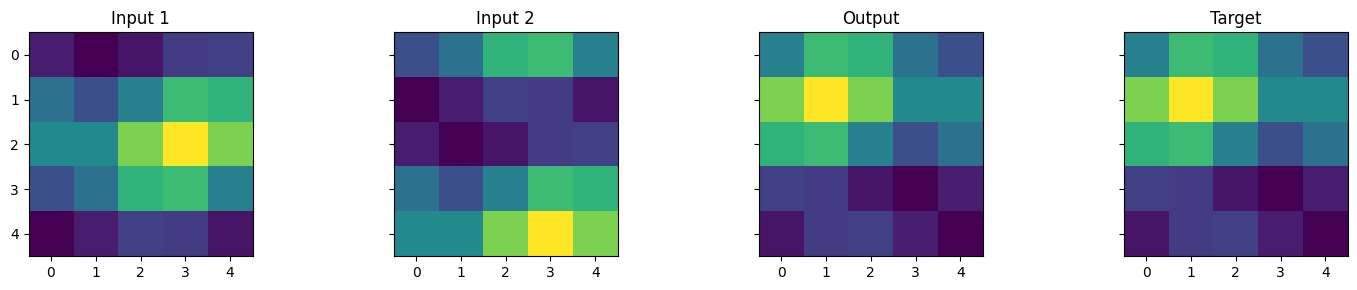

Epoch 37310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37400/50000, Loss: 0.000000


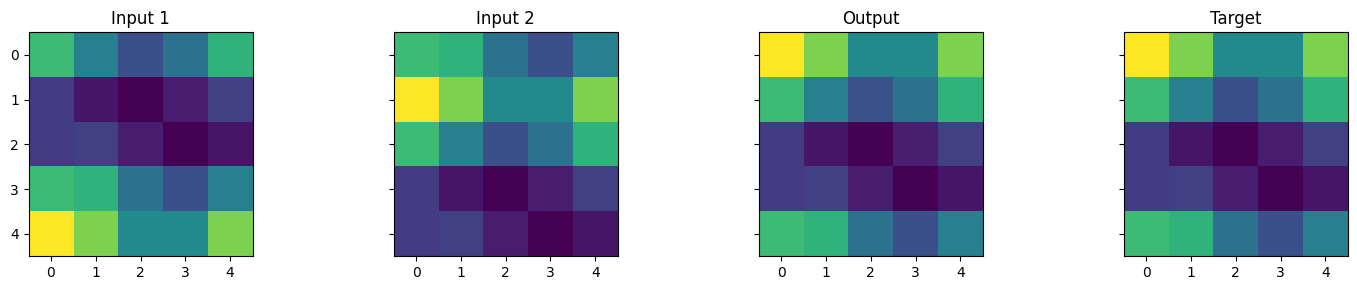

Epoch 37410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37500/50000, Loss: 0.000000


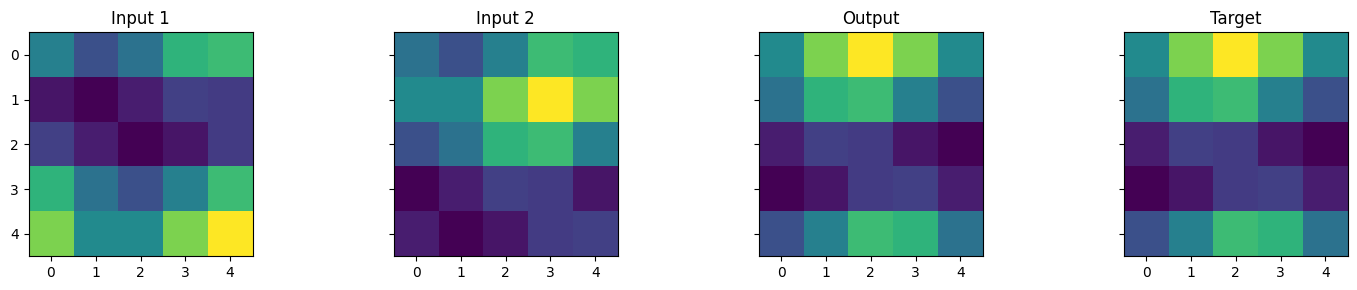

Epoch 37510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37600/50000, Loss: 0.000000


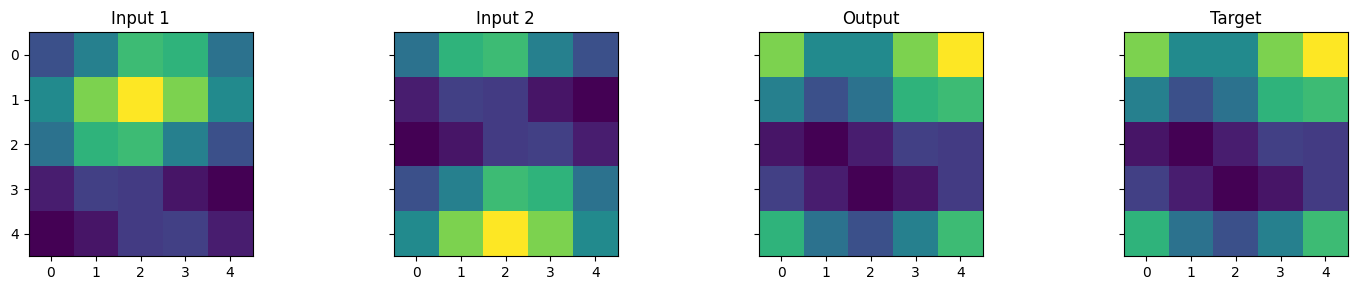

Epoch 37610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37700/50000, Loss: 0.000000


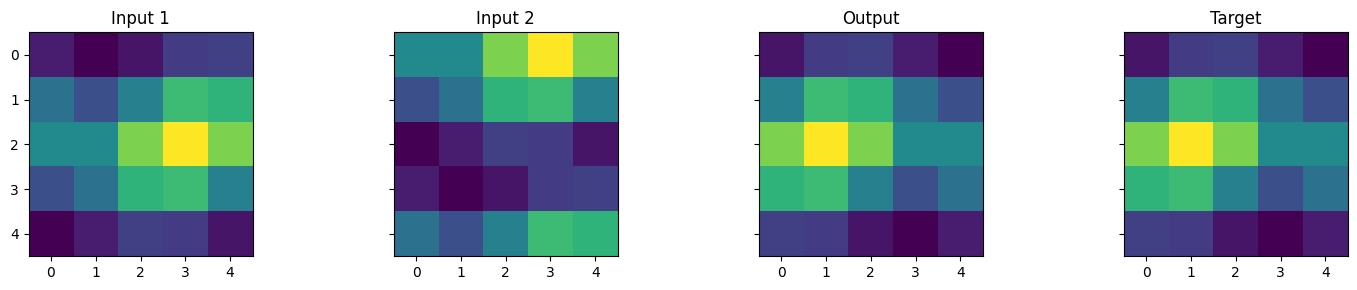

Epoch 37710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37800/50000, Loss: 0.000000


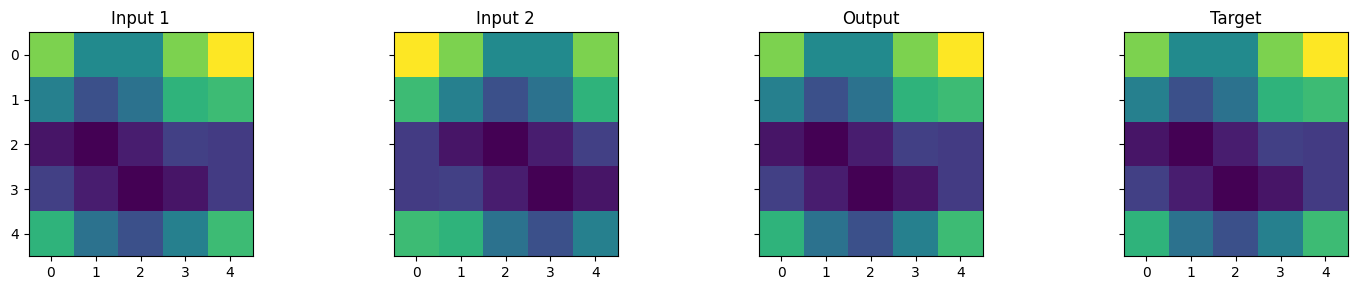

Epoch 37810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37900/50000, Loss: 0.000000


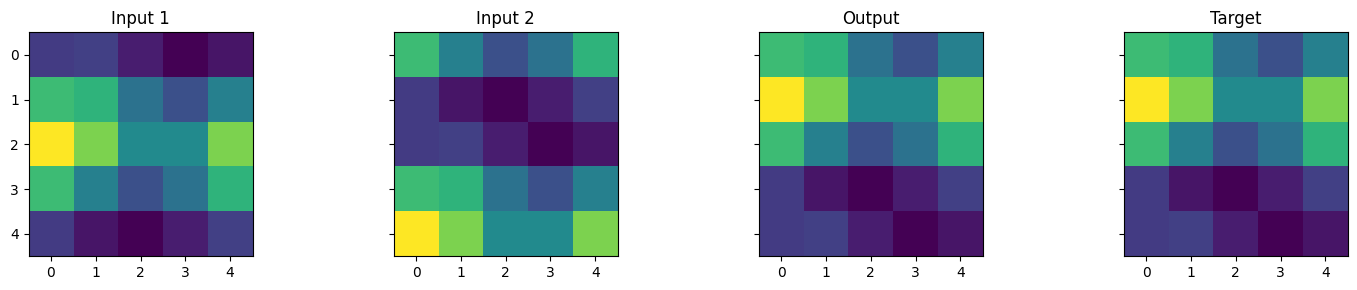

Epoch 37910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 37990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38000/50000, Loss: 0.000000


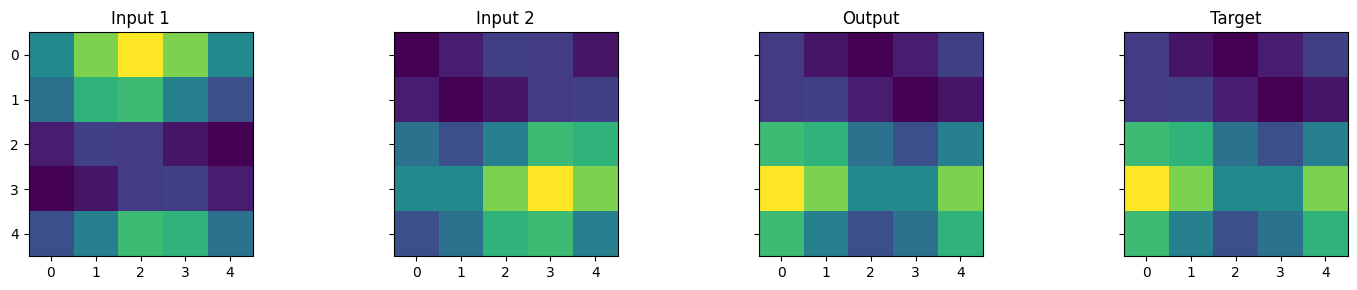

Epoch 38010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38100/50000, Loss: 0.000000


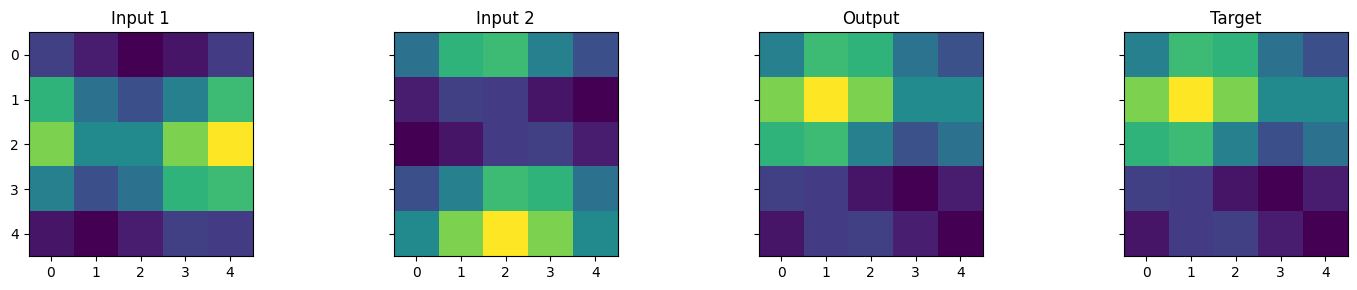

Epoch 38110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38200/50000, Loss: 0.000000


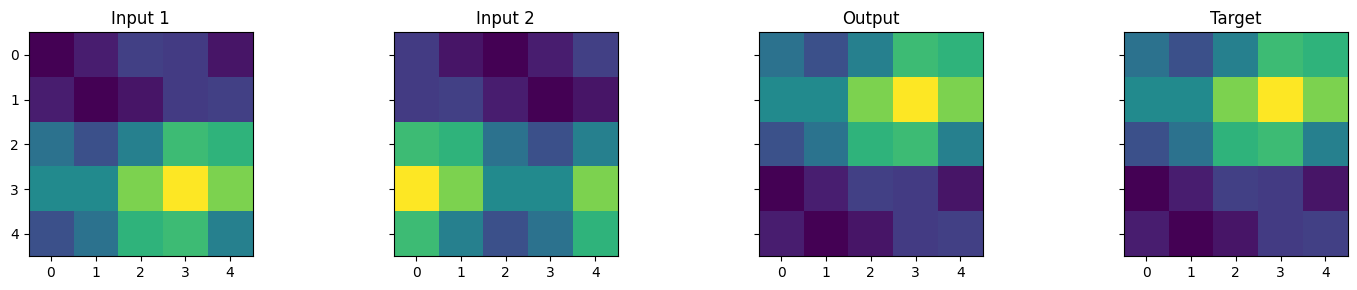

Epoch 38210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38300/50000, Loss: 0.000000


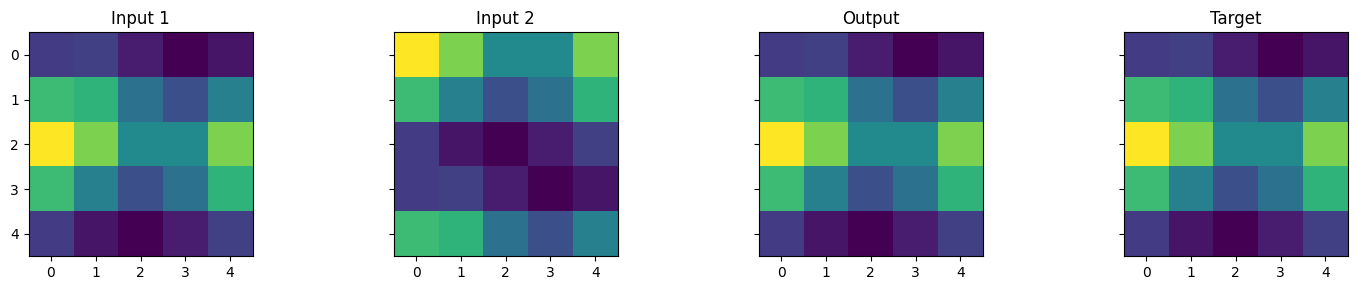

Epoch 38310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38400/50000, Loss: 0.000000


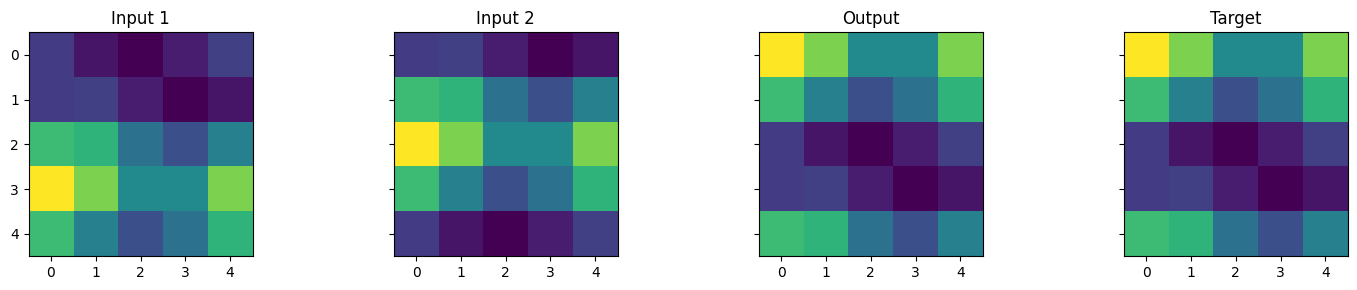

Epoch 38410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38500/50000, Loss: 0.000000


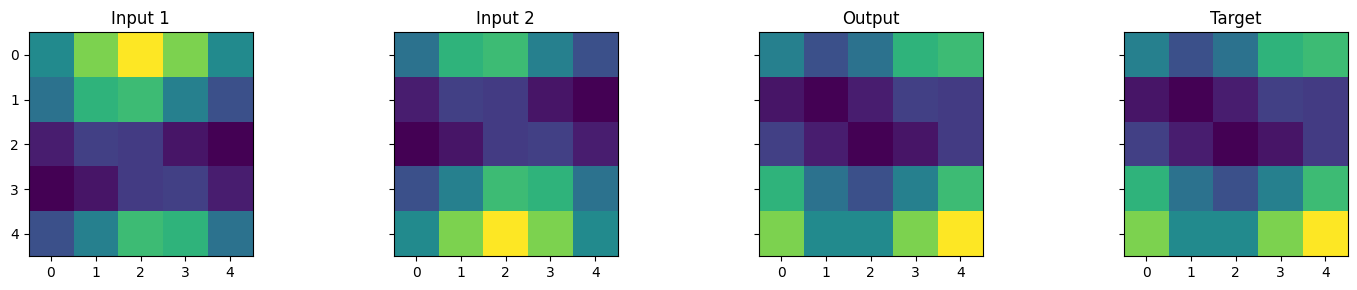

Epoch 38510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38600/50000, Loss: 0.000000


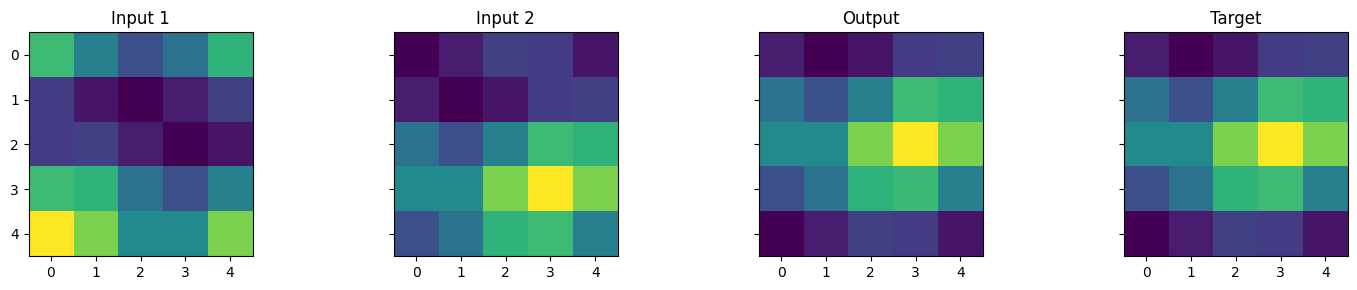

Epoch 38610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38700/50000, Loss: 0.000000


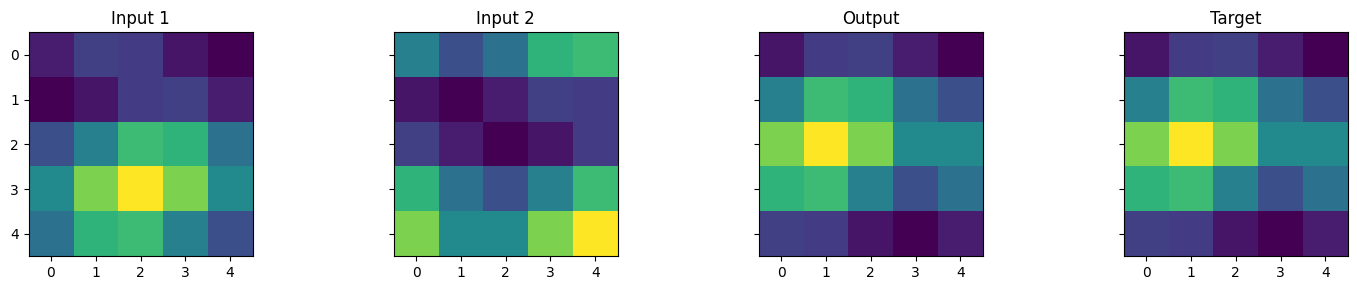

Epoch 38710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38800/50000, Loss: 0.000000


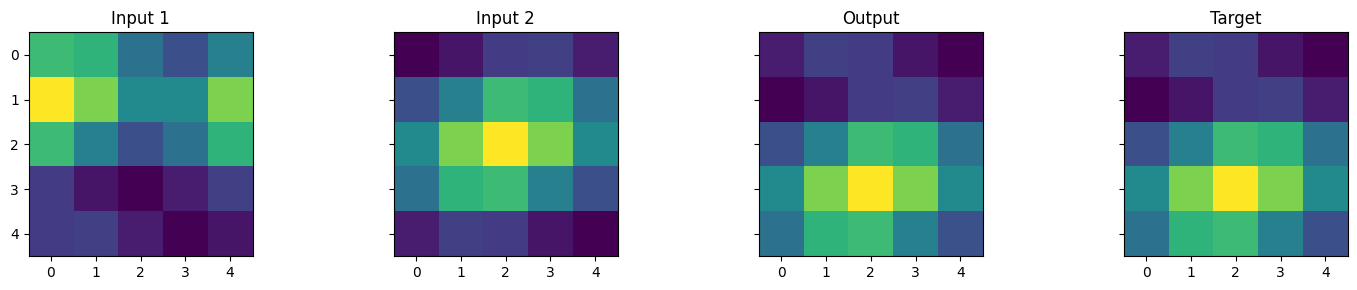

Epoch 38810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38900/50000, Loss: 0.000000


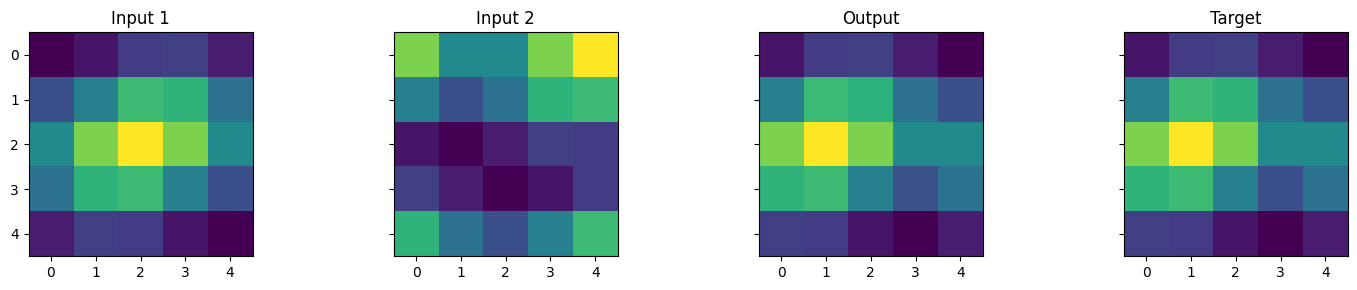

Epoch 38910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 38990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39000/50000, Loss: 0.000000


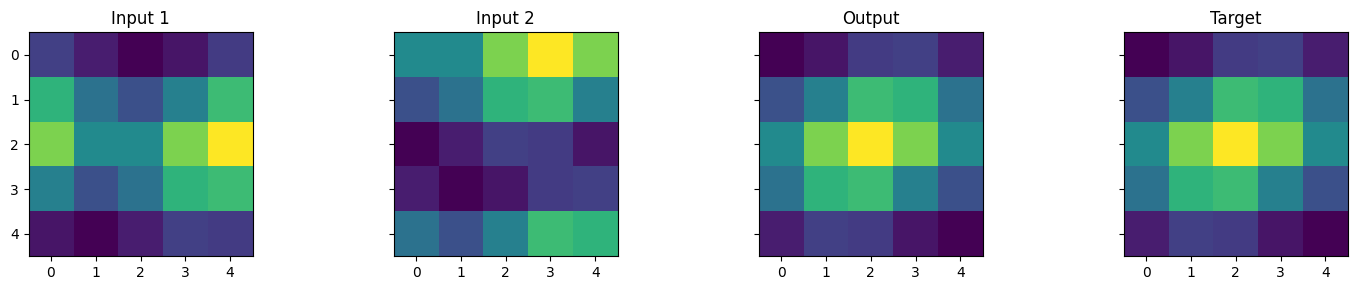

Epoch 39010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39100/50000, Loss: 0.000000


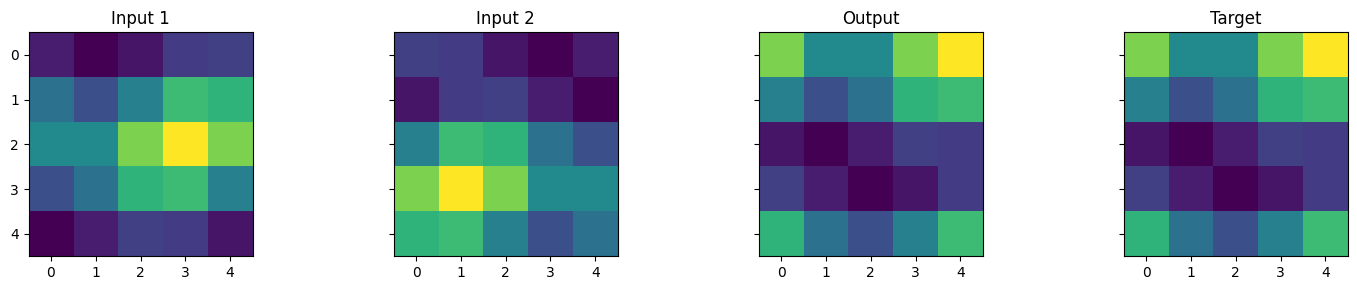

Epoch 39110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39200/50000, Loss: 0.000000


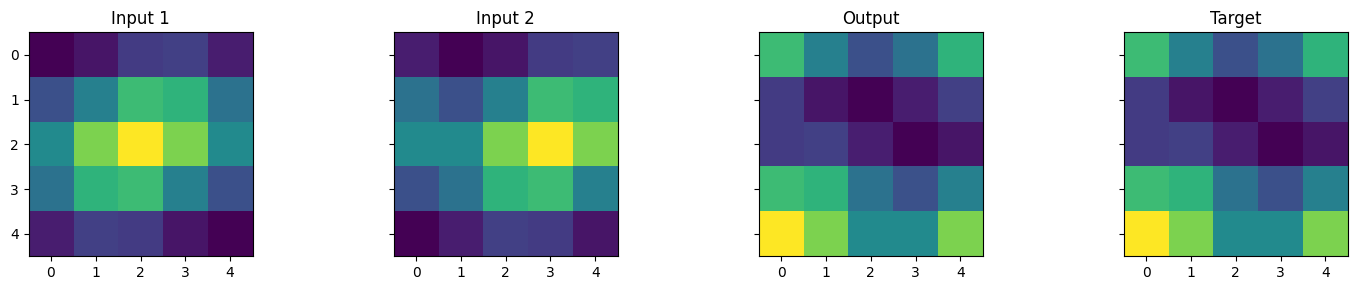

Epoch 39210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39300/50000, Loss: 0.000000


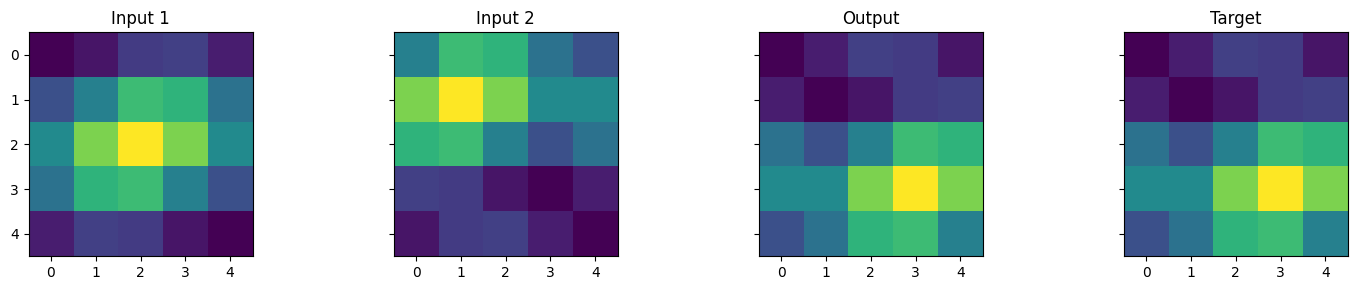

Epoch 39310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39400/50000, Loss: 0.000000


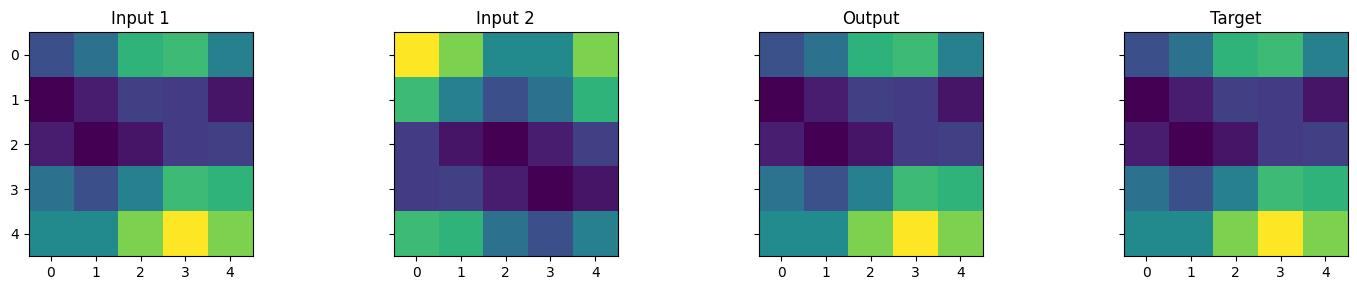

Epoch 39410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39500/50000, Loss: 0.000000


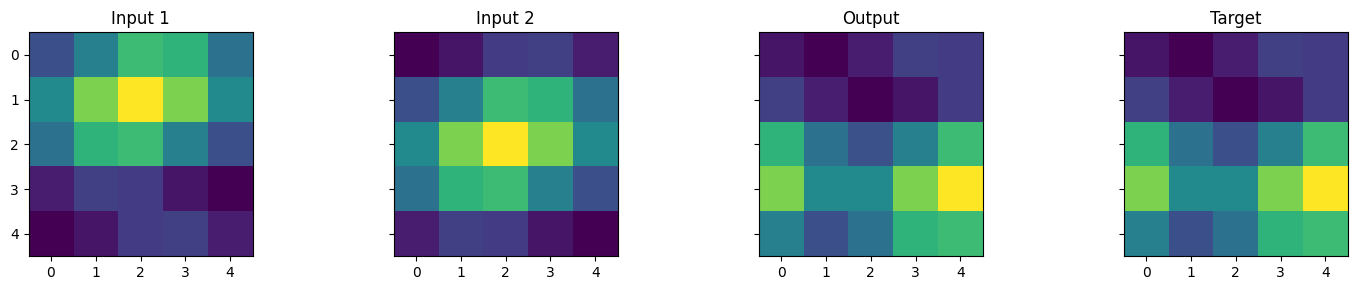

Epoch 39510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39600/50000, Loss: 0.000000


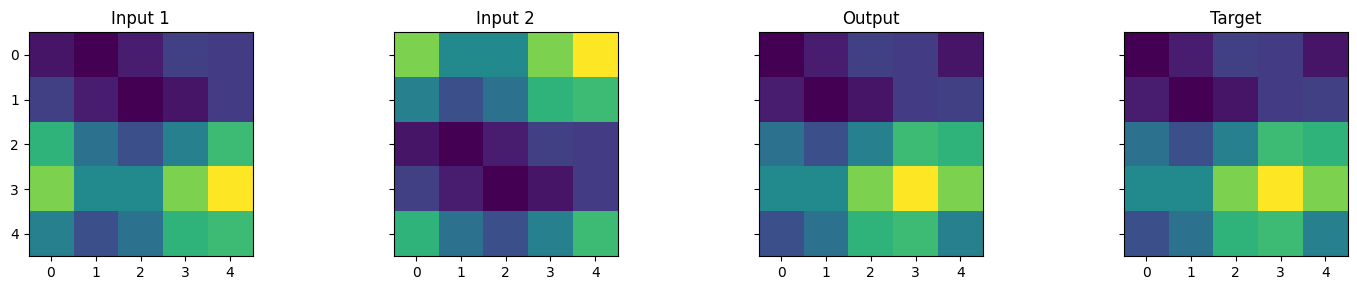

Epoch 39610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39700/50000, Loss: 0.000000


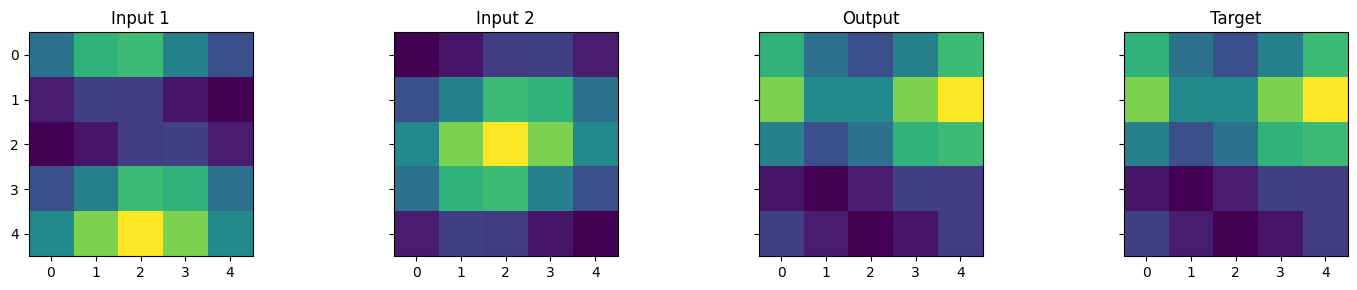

Epoch 39710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39800/50000, Loss: 0.000000


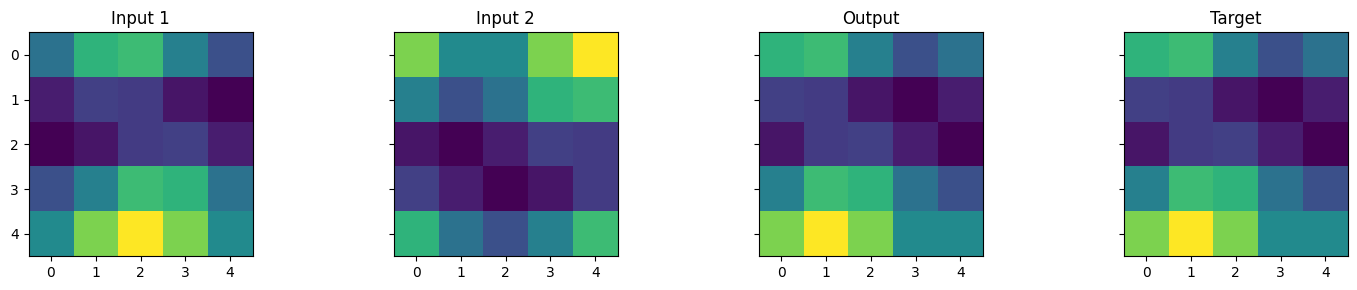

Epoch 39810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39900/50000, Loss: 0.000000


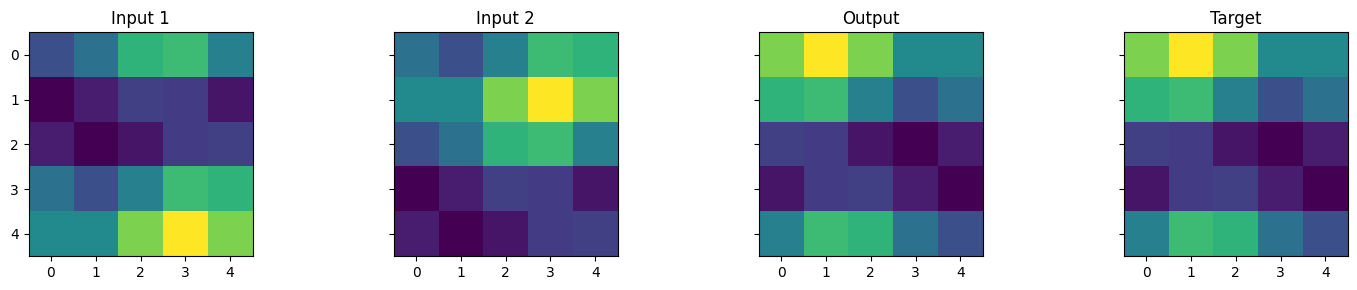

Epoch 39910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 39990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40000/50000, Loss: 0.000000


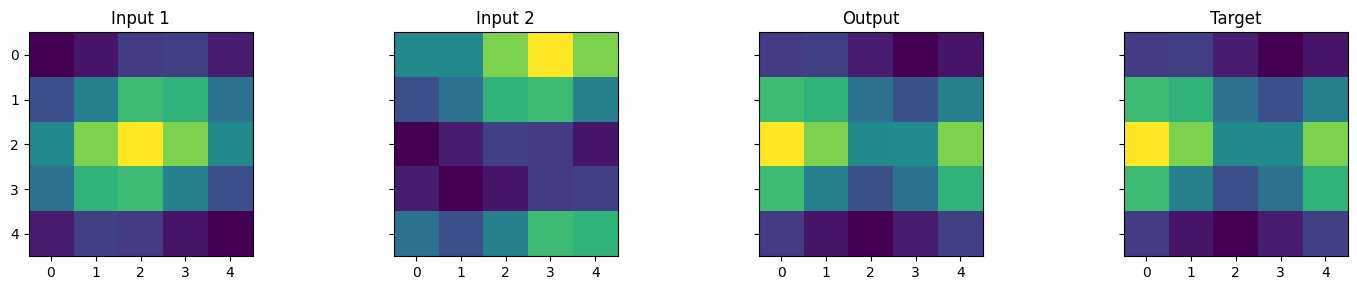

Epoch 40010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40100/50000, Loss: 0.000000


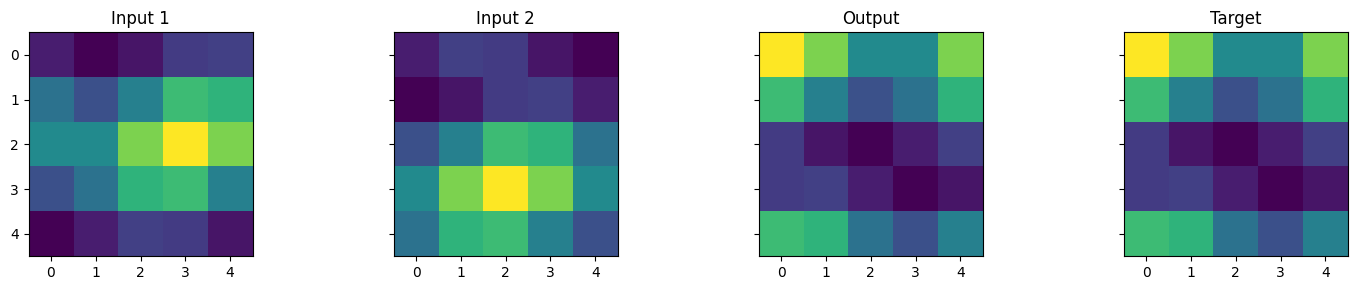

Epoch 40110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40200/50000, Loss: 0.000000


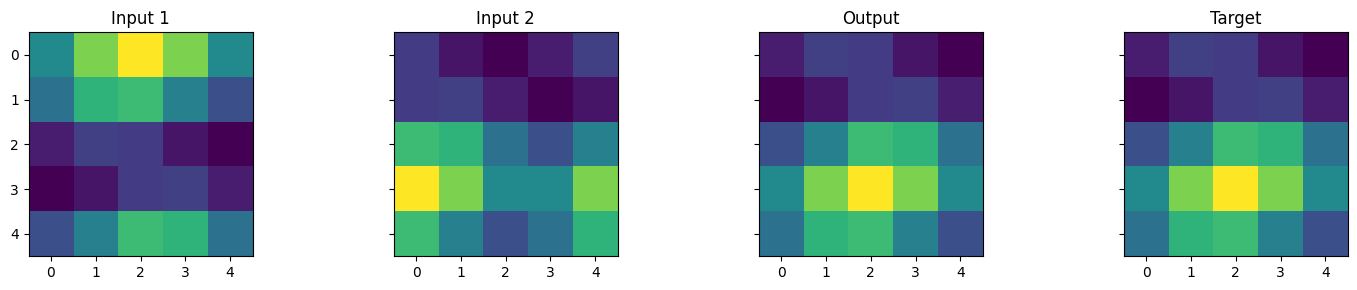

Epoch 40210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40300/50000, Loss: 0.000000


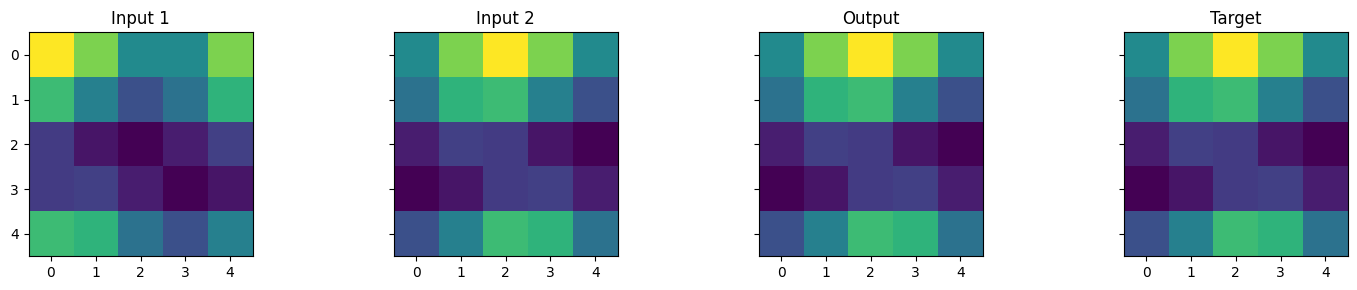

Epoch 40310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40400/50000, Loss: 0.000000


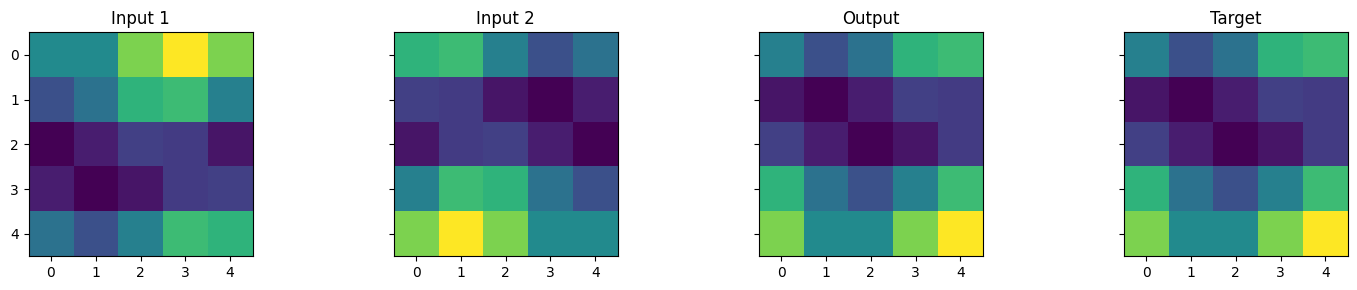

Epoch 40410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40500/50000, Loss: 0.000000


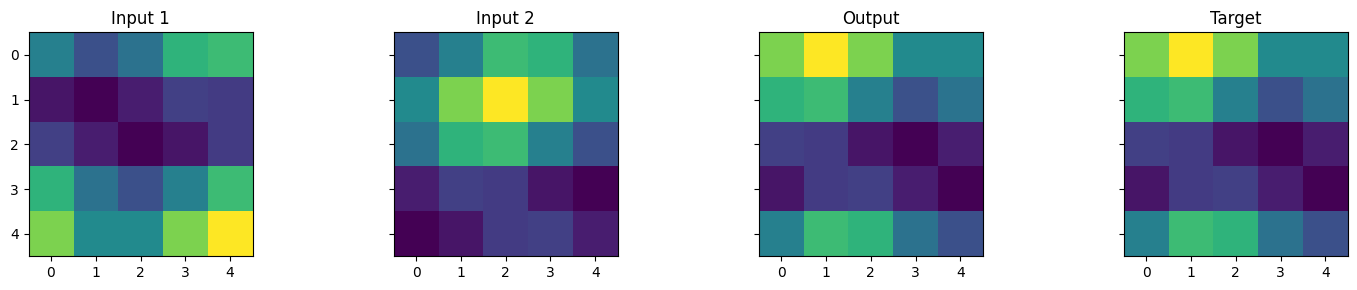

Epoch 40510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40600/50000, Loss: 0.000000


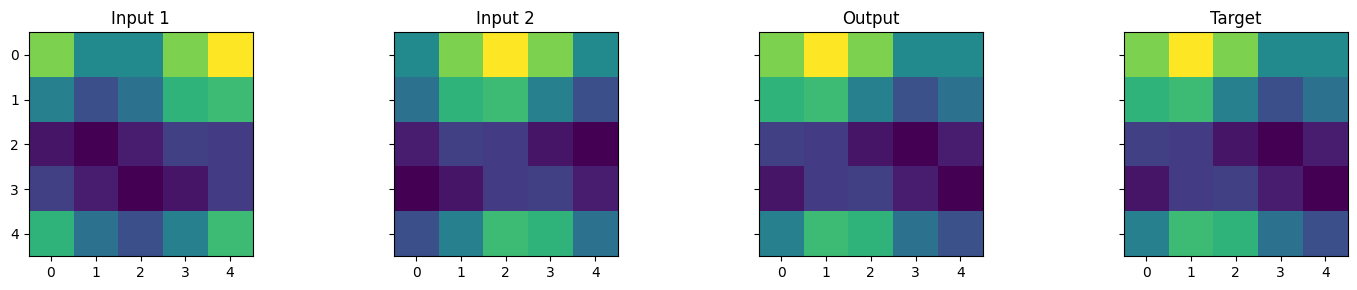

Epoch 40610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40700/50000, Loss: 0.000000


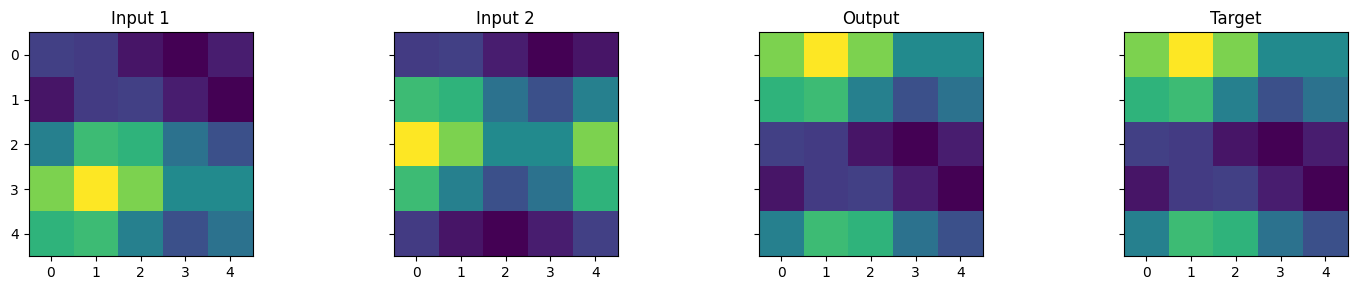

Epoch 40710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40800/50000, Loss: 0.000000


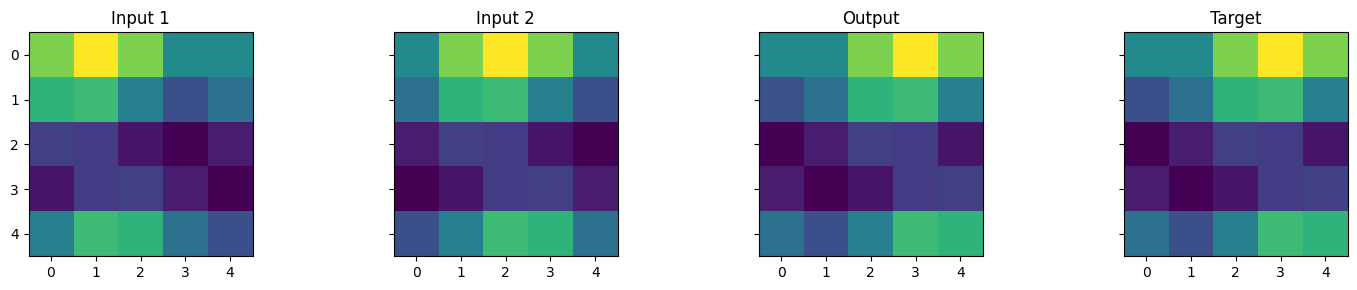

Epoch 40810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40900/50000, Loss: 0.000000


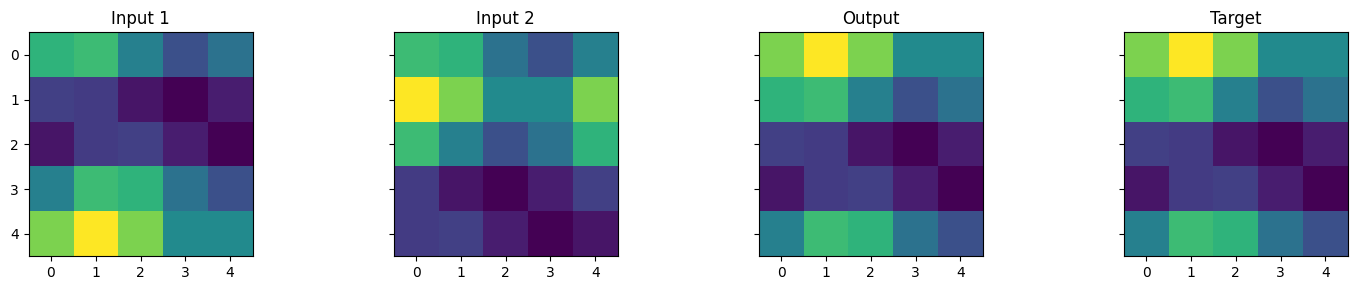

Epoch 40910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 40990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41000/50000, Loss: 0.000000


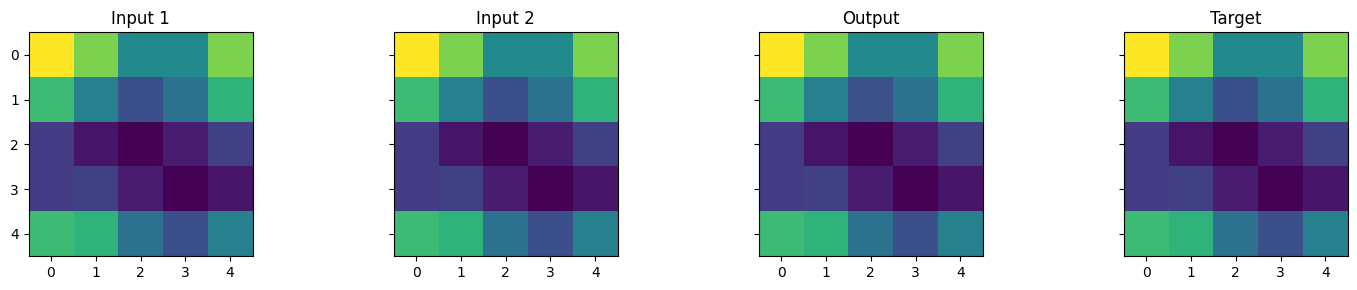

Epoch 41010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41100/50000, Loss: 0.000000


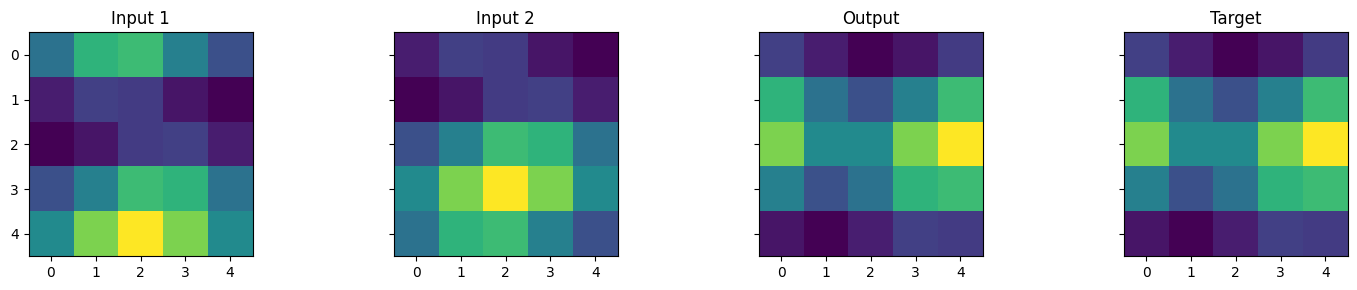

Epoch 41110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41200/50000, Loss: 0.000000


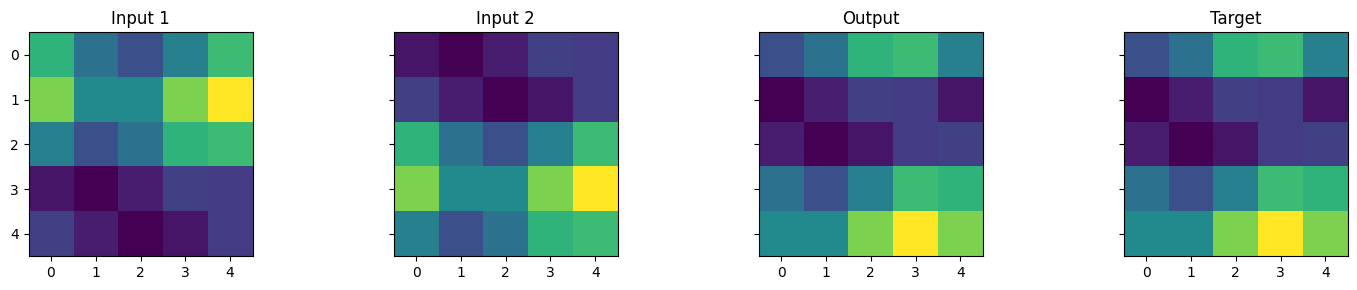

Epoch 41210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41300/50000, Loss: 0.000000


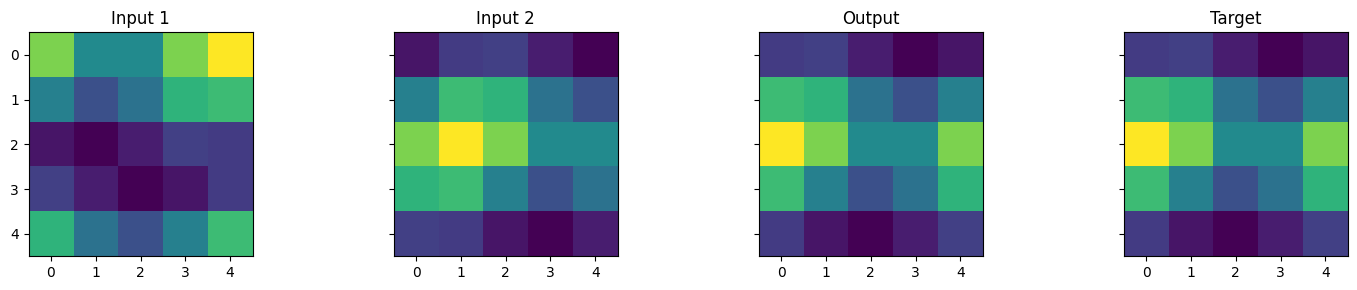

Epoch 41310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41400/50000, Loss: 0.000000


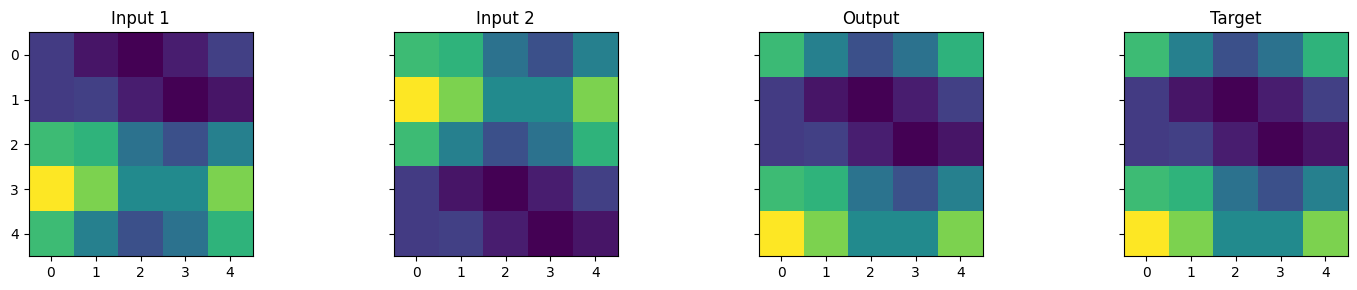

Epoch 41410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41500/50000, Loss: 0.000000


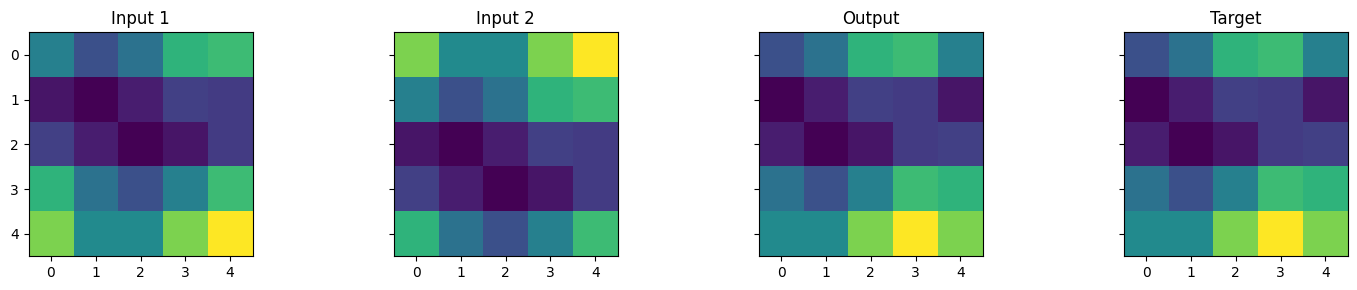

Epoch 41510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41600/50000, Loss: 0.000000


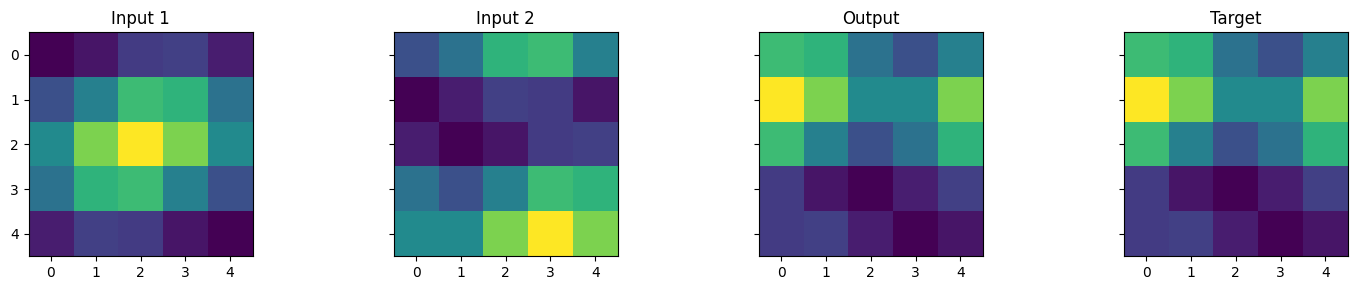

Epoch 41610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41700/50000, Loss: 0.000000


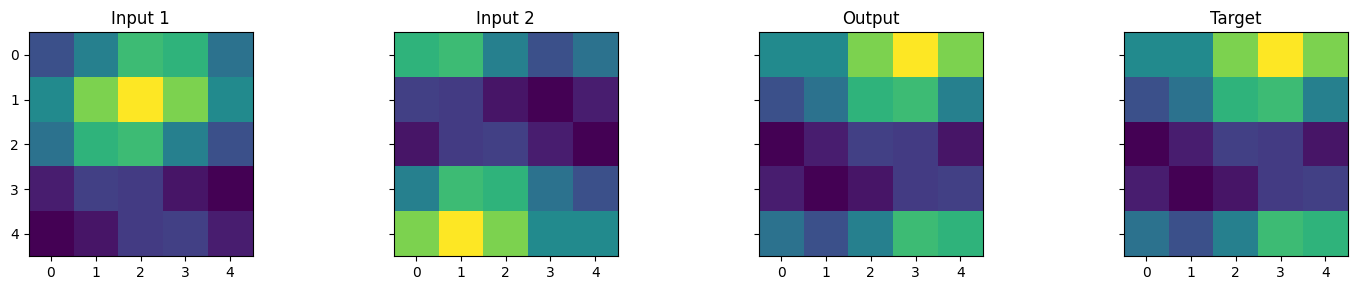

Epoch 41710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41800/50000, Loss: 0.000000


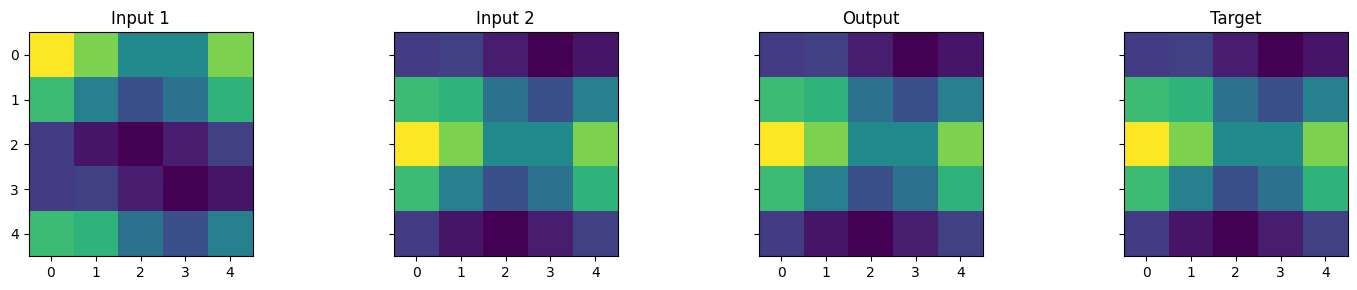

Epoch 41810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41900/50000, Loss: 0.000000


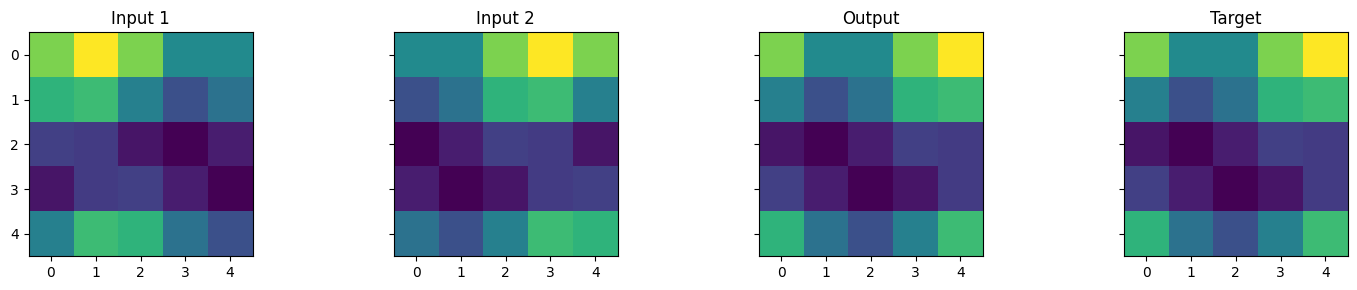

Epoch 41910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 41990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42000/50000, Loss: 0.000000


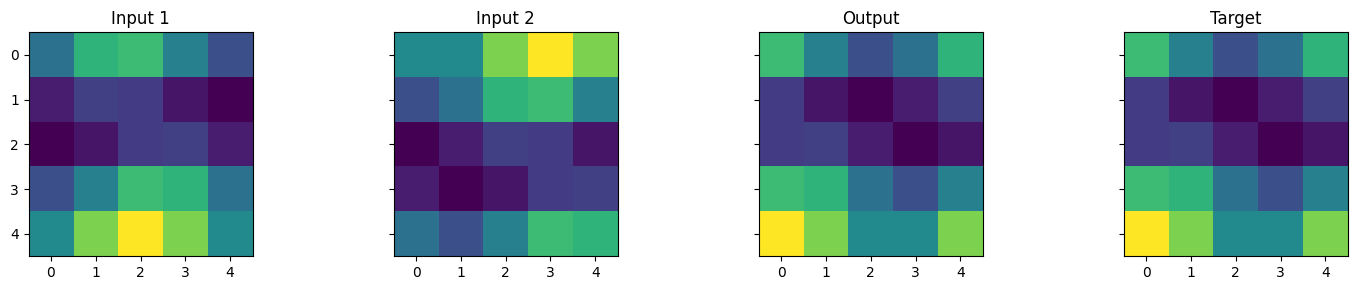

Epoch 42010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42100/50000, Loss: 0.000000


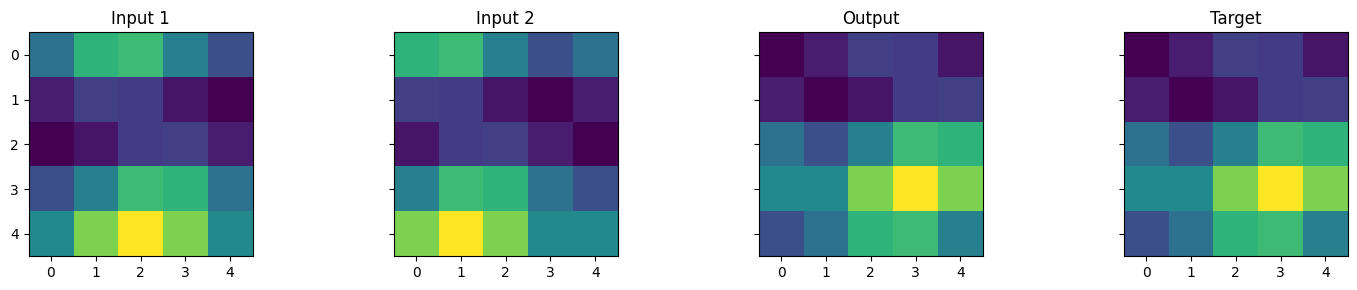

Epoch 42110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42200/50000, Loss: 0.000000


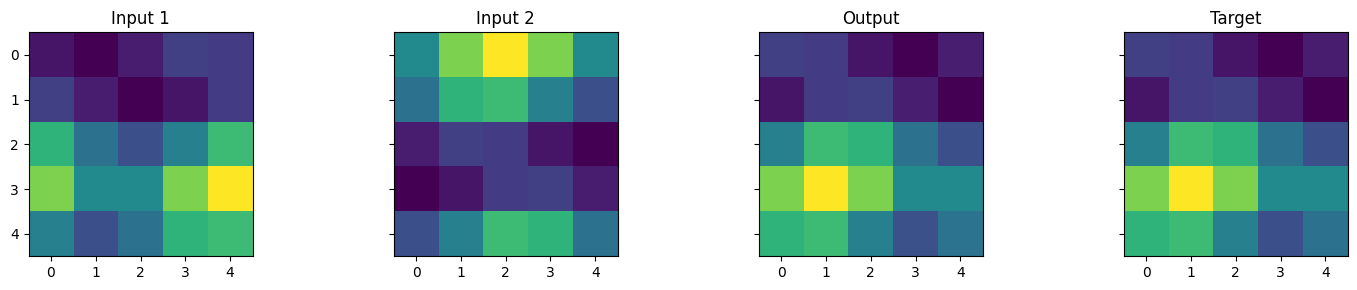

Epoch 42210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42300/50000, Loss: 0.000000


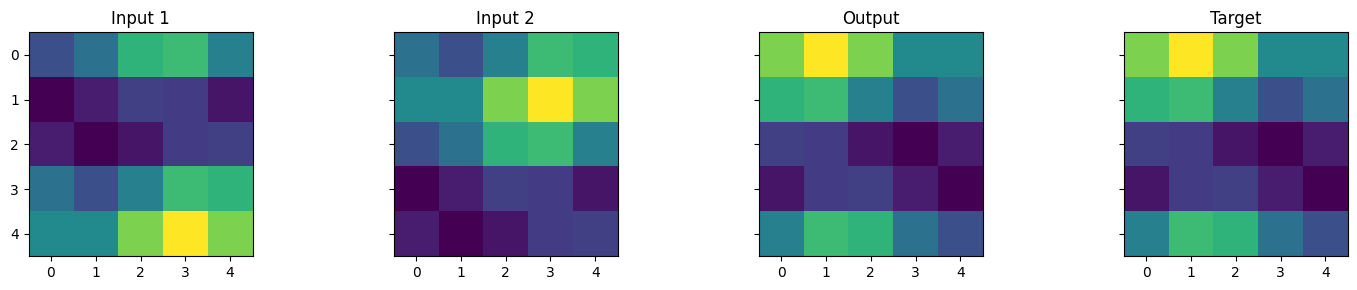

Epoch 42310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42400/50000, Loss: 0.000000


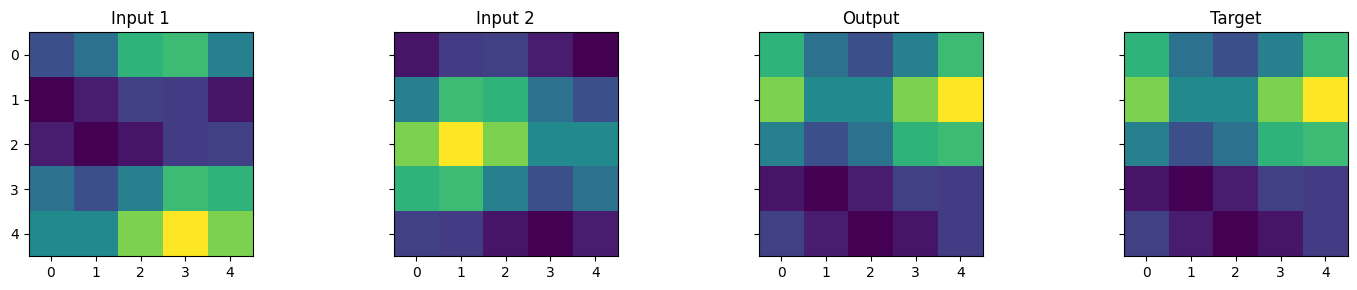

Epoch 42410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42500/50000, Loss: 0.000000


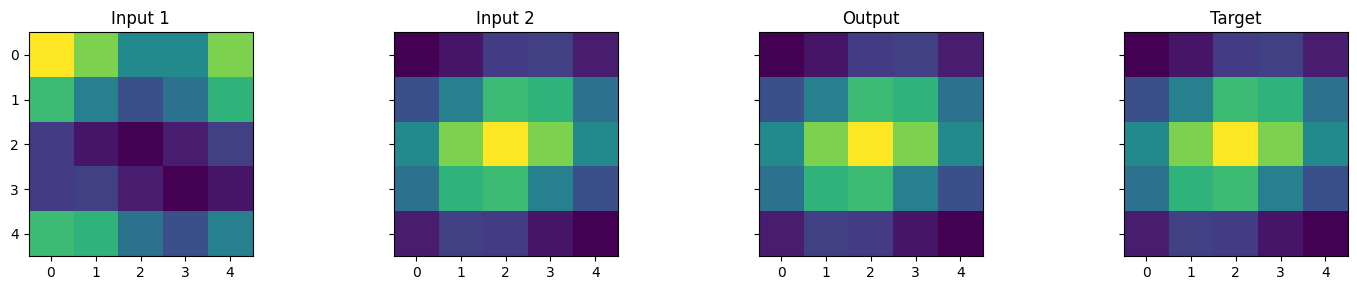

Epoch 42510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42600/50000, Loss: 0.000000


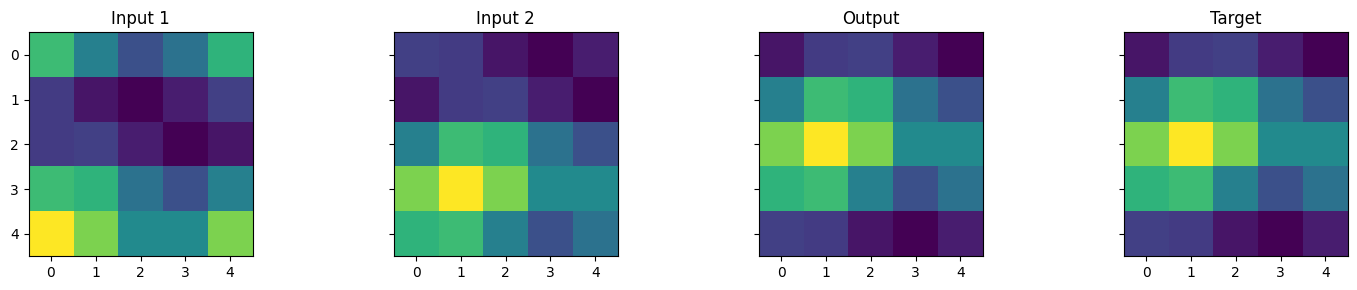

Epoch 42610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42700/50000, Loss: 0.000000


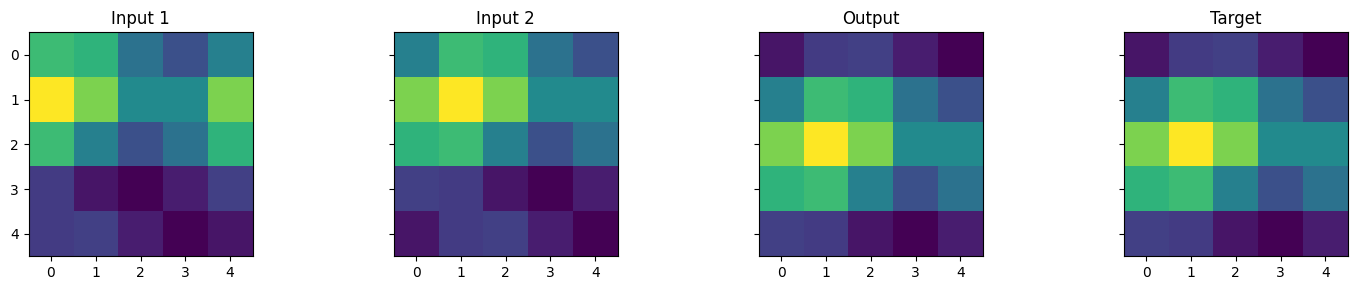

Epoch 42710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42800/50000, Loss: 0.000000


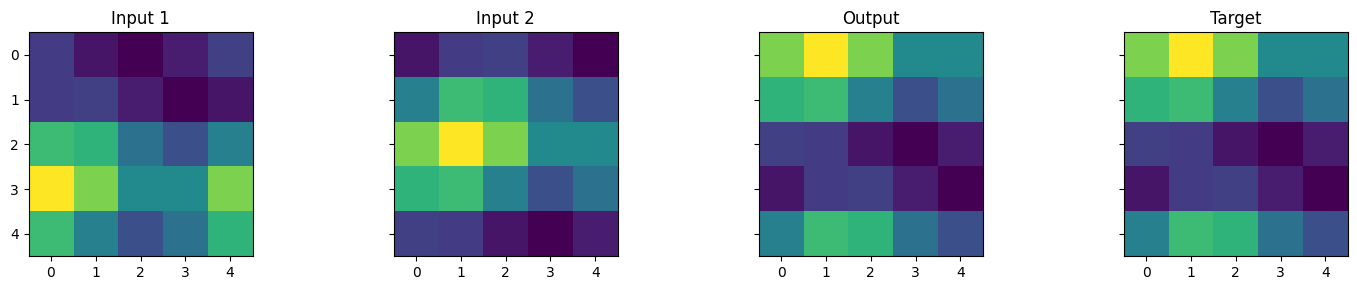

Epoch 42810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42900/50000, Loss: 0.000000


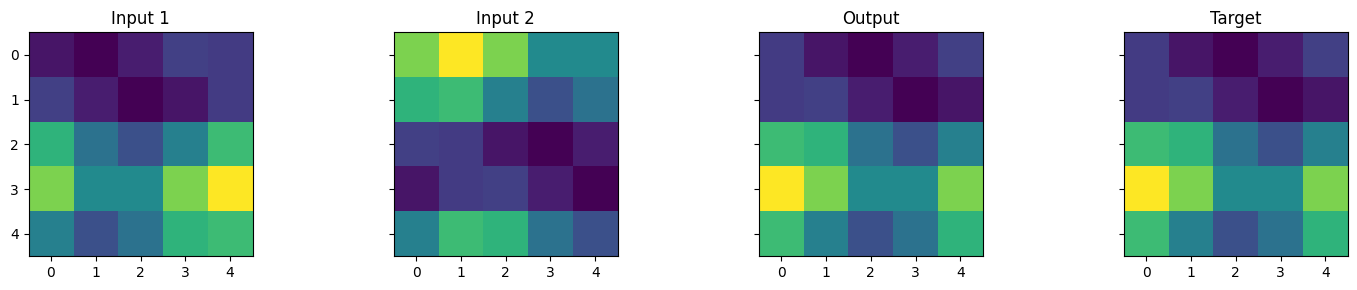

Epoch 42910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 42990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43000/50000, Loss: 0.000000


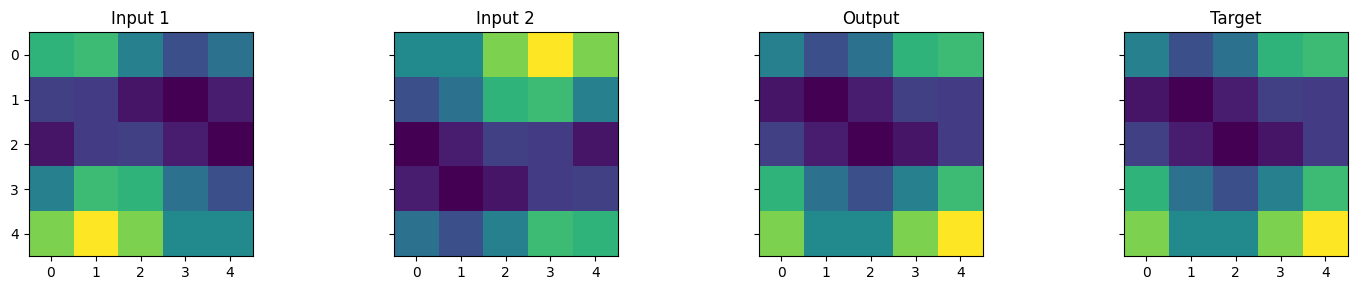

Epoch 43010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43100/50000, Loss: 0.000000


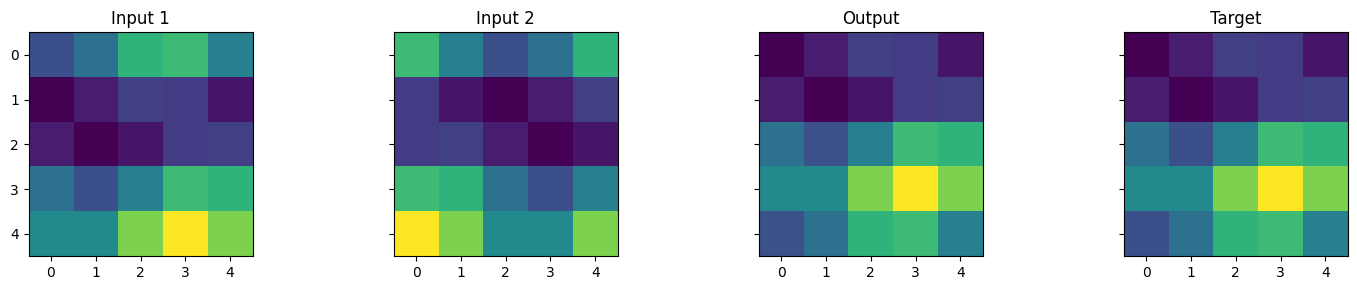

Epoch 43110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43200/50000, Loss: 0.000000


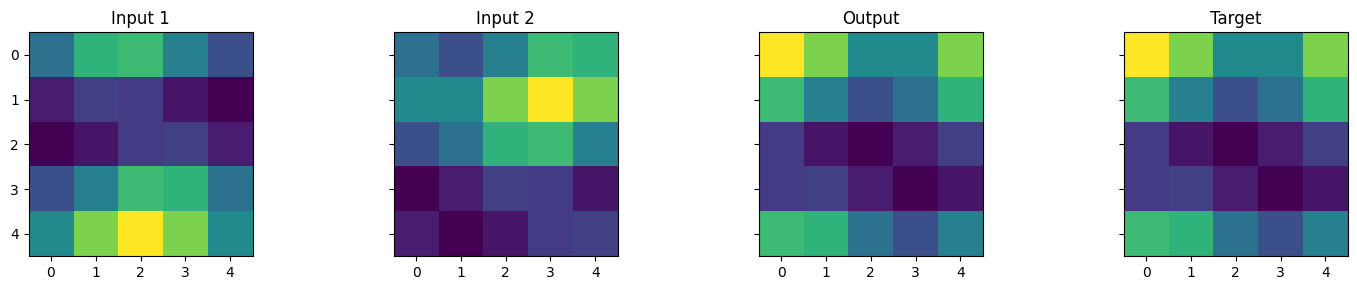

Epoch 43210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43300/50000, Loss: 0.000000


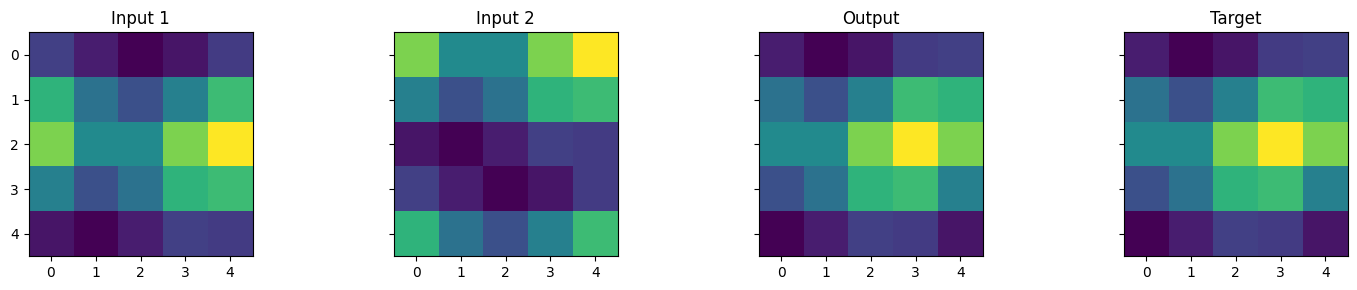

Epoch 43310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43400/50000, Loss: 0.000000


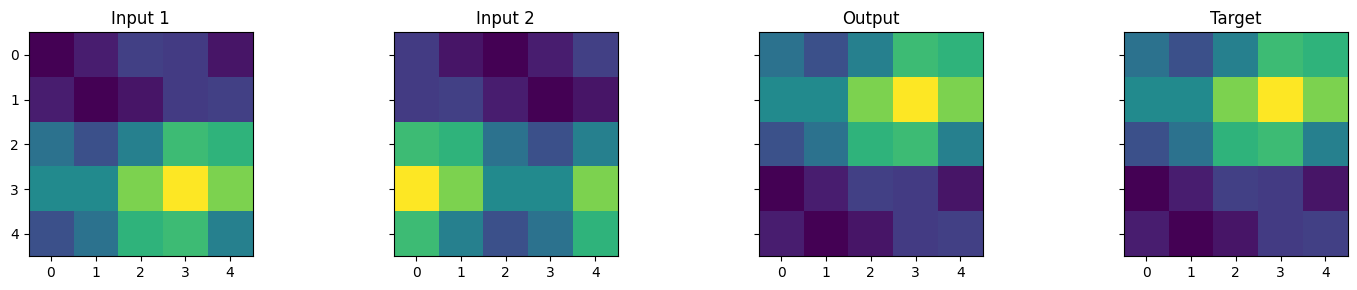

Epoch 43410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43500/50000, Loss: 0.000000


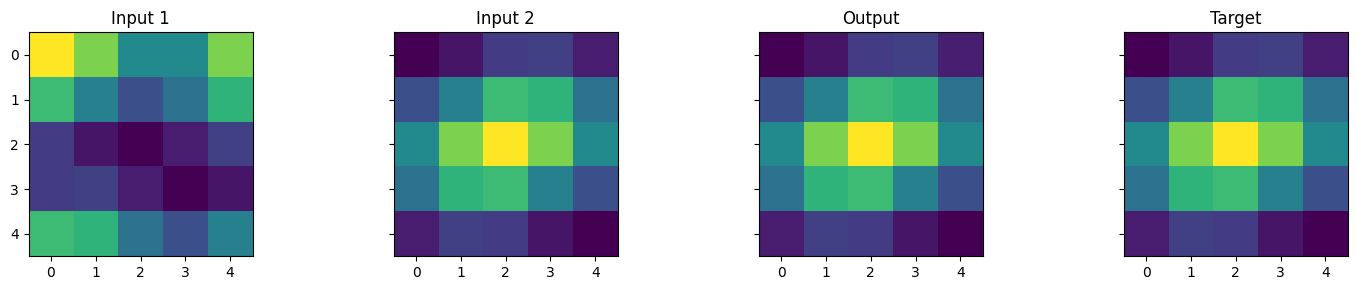

Epoch 43510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43600/50000, Loss: 0.000000


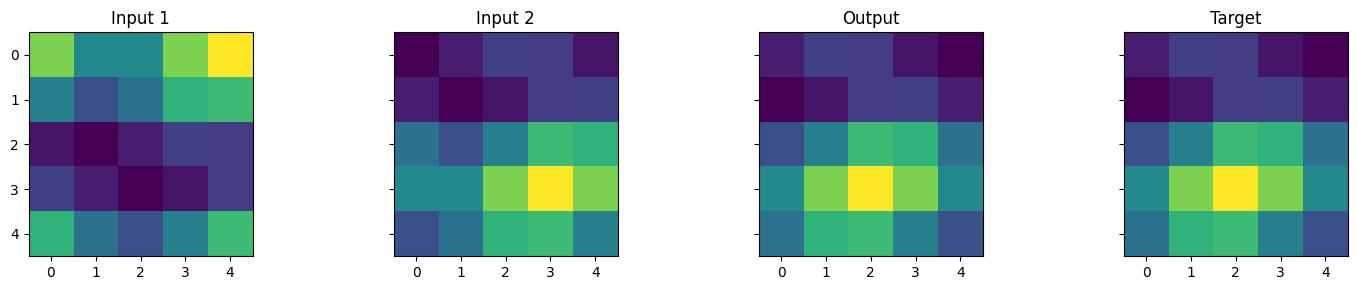

Epoch 43610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43700/50000, Loss: 0.000000


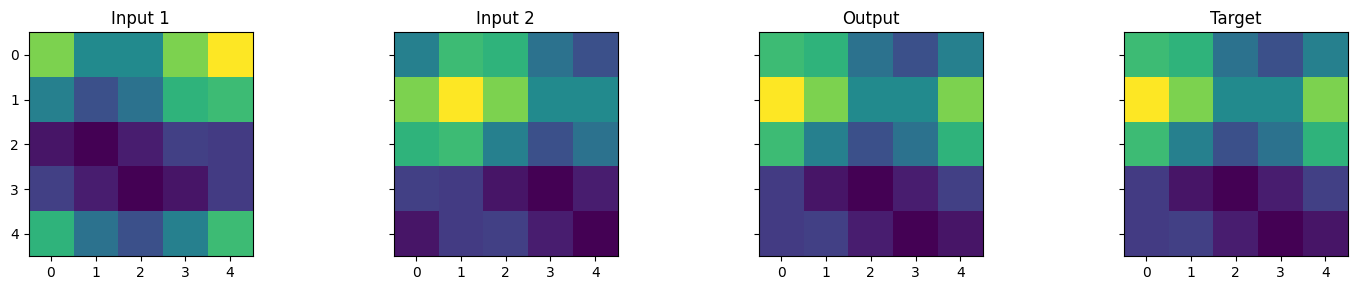

Epoch 43710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43800/50000, Loss: 0.000000


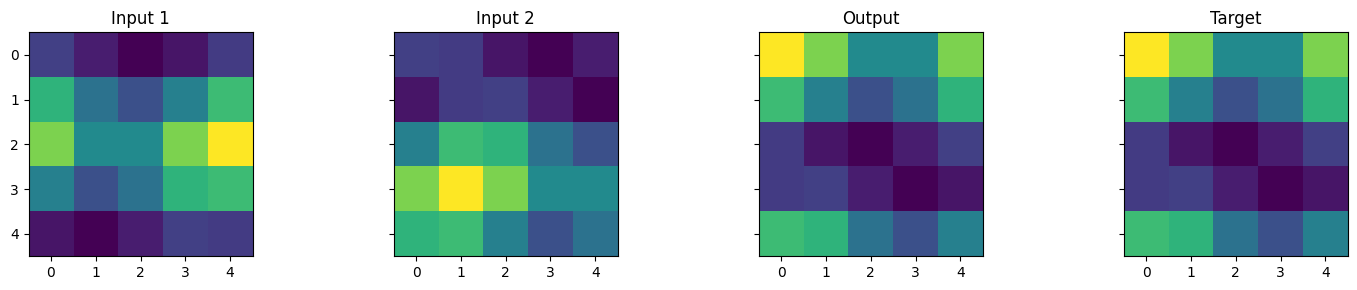

Epoch 43810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43900/50000, Loss: 0.000000


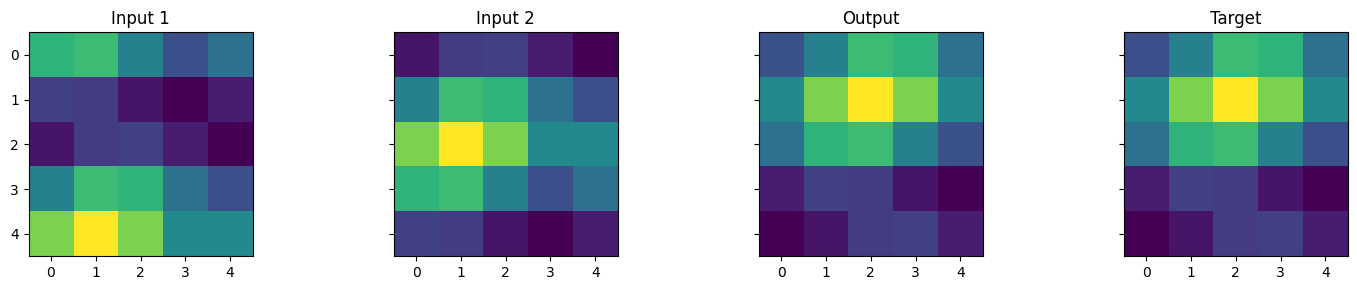

Epoch 43910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 43990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44000/50000, Loss: 0.000000


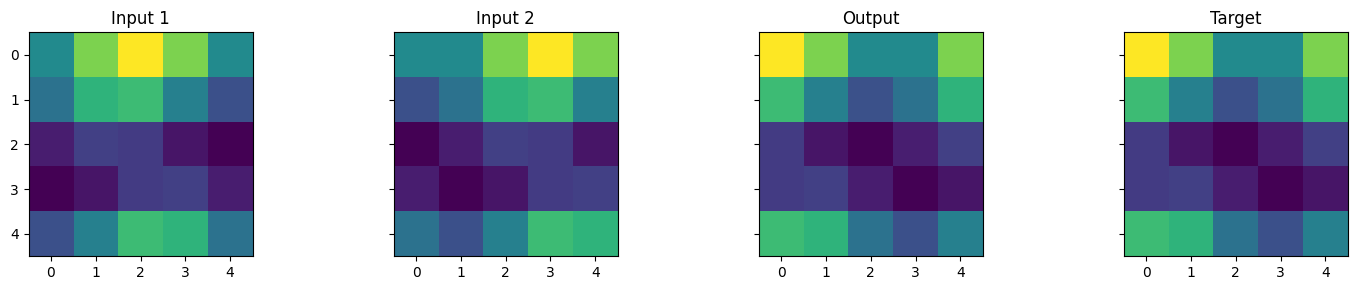

Epoch 44010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44100/50000, Loss: 0.000000


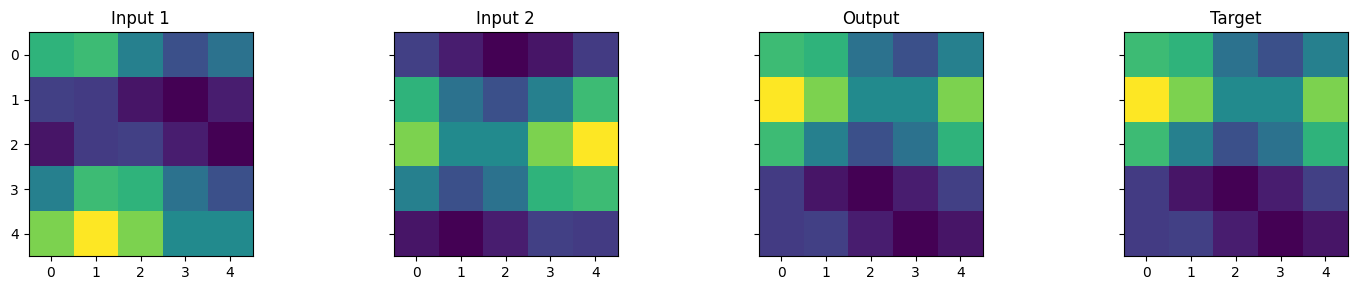

Epoch 44110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44200/50000, Loss: 0.000000


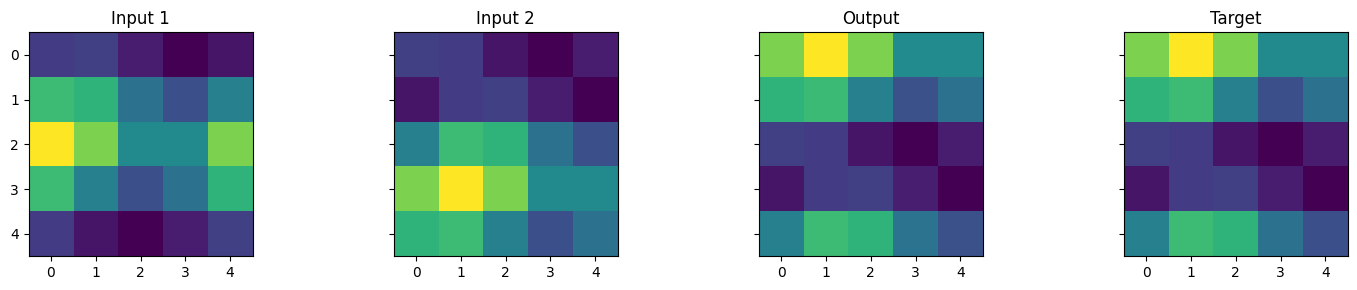

Epoch 44210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44300/50000, Loss: 0.000000


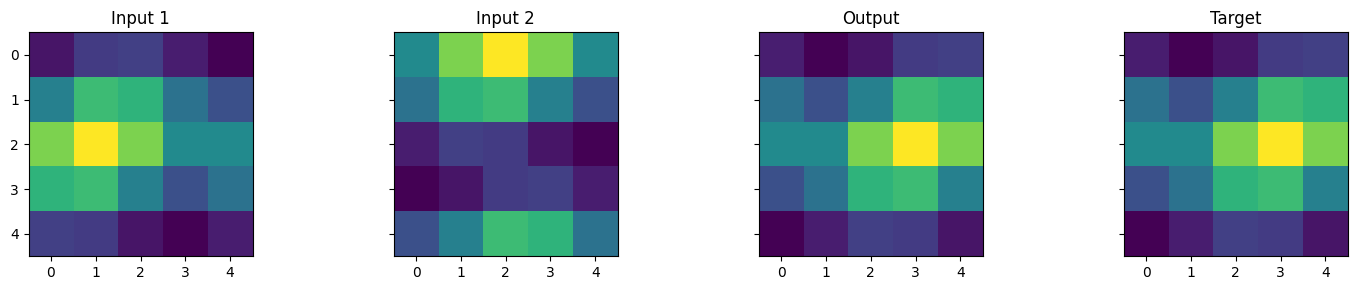

Epoch 44310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44400/50000, Loss: 0.000000


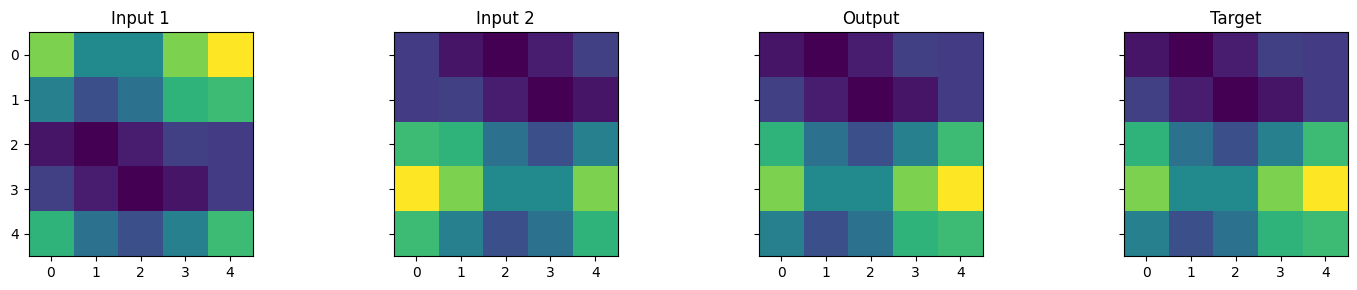

Epoch 44410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44500/50000, Loss: 0.000000


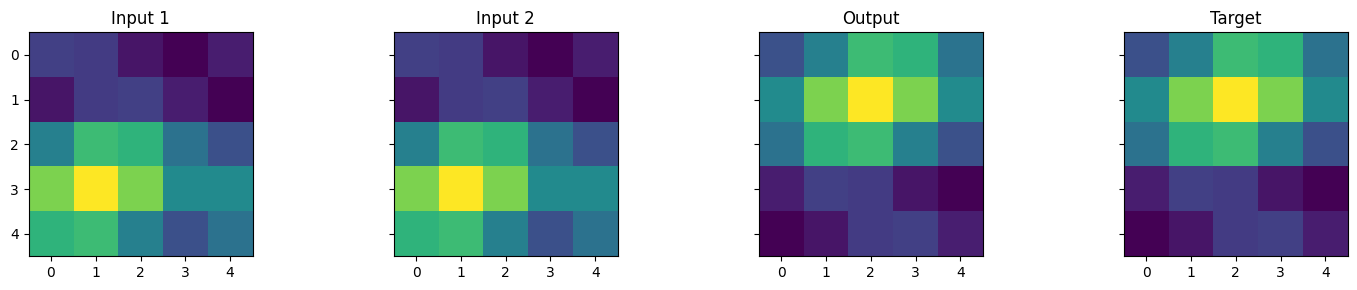

Epoch 44510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44600/50000, Loss: 0.000000


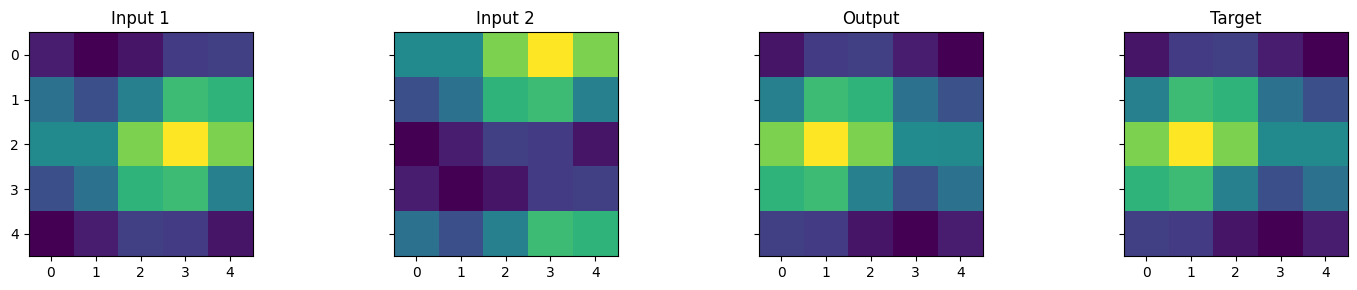

Epoch 44610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44700/50000, Loss: 0.000000


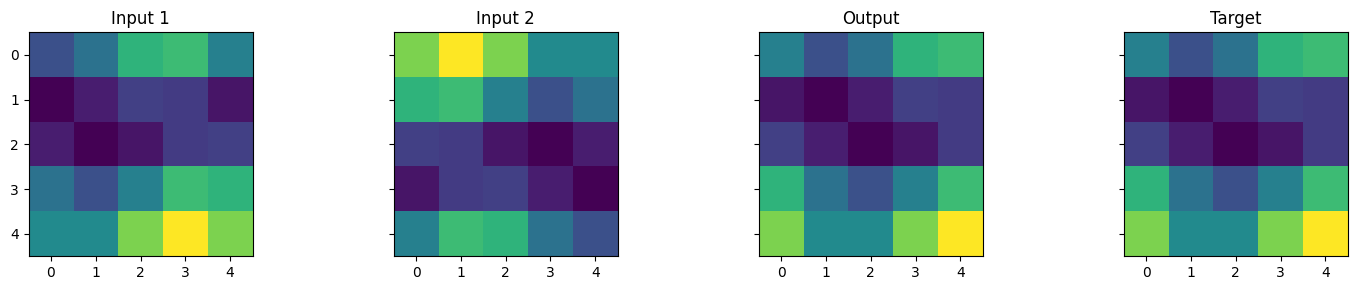

Epoch 44710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44800/50000, Loss: 0.000000


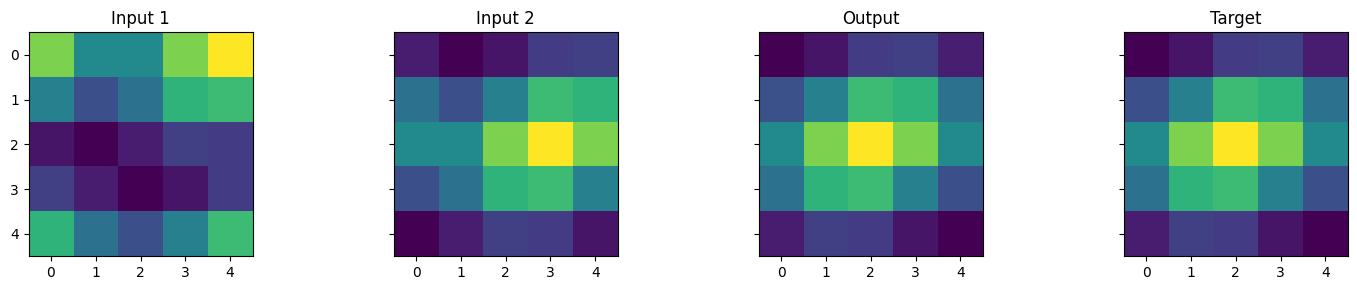

Epoch 44810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44900/50000, Loss: 0.000000


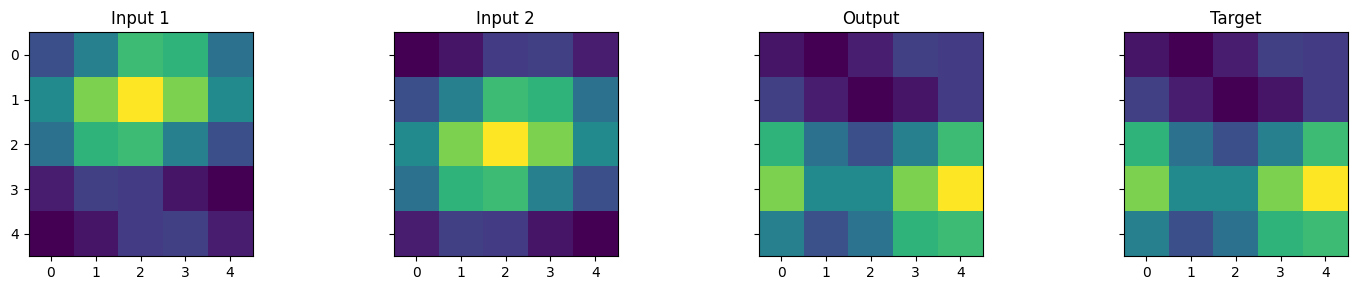

Epoch 44910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 44990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45000/50000, Loss: 0.000000


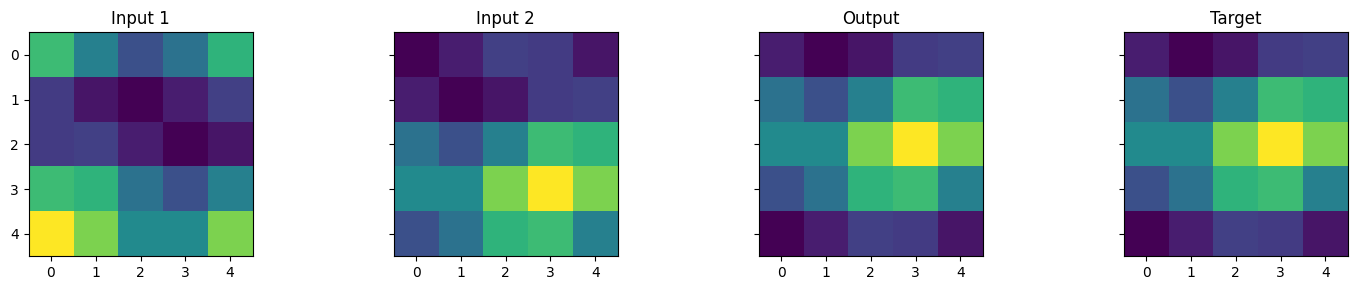

Epoch 45010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45100/50000, Loss: 0.000000


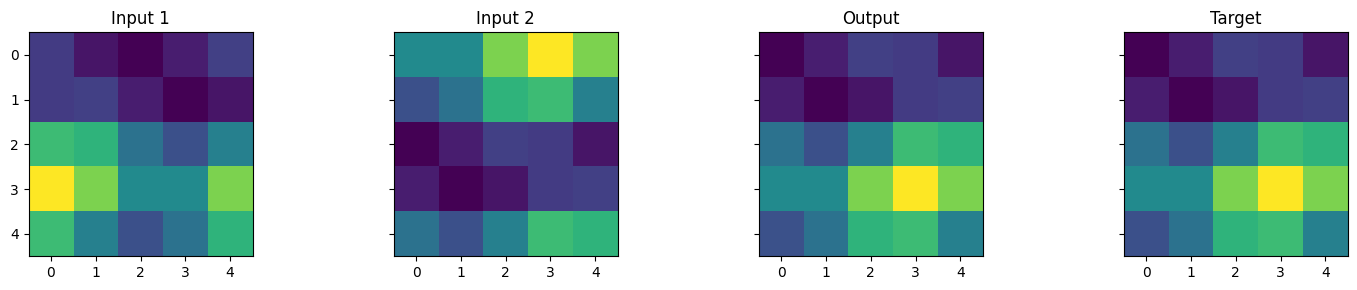

Epoch 45110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45200/50000, Loss: 0.000000


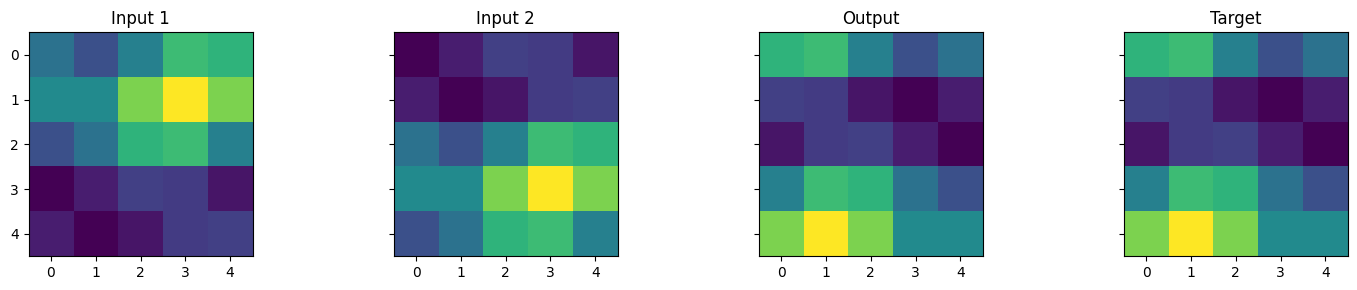

Epoch 45210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45300/50000, Loss: 0.000000


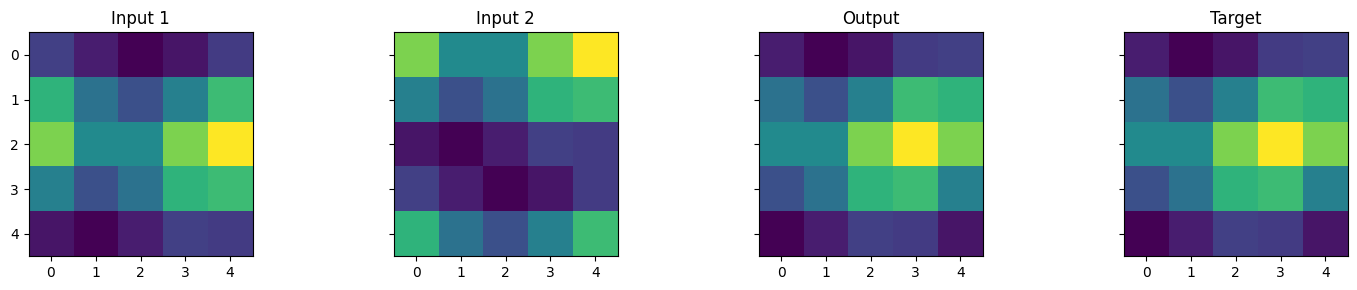

Epoch 45310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45400/50000, Loss: 0.000000


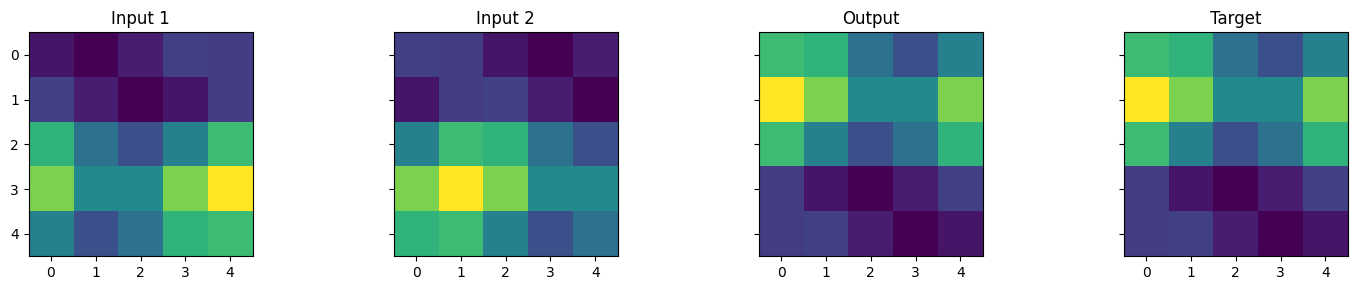

Epoch 45410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45500/50000, Loss: 0.000000


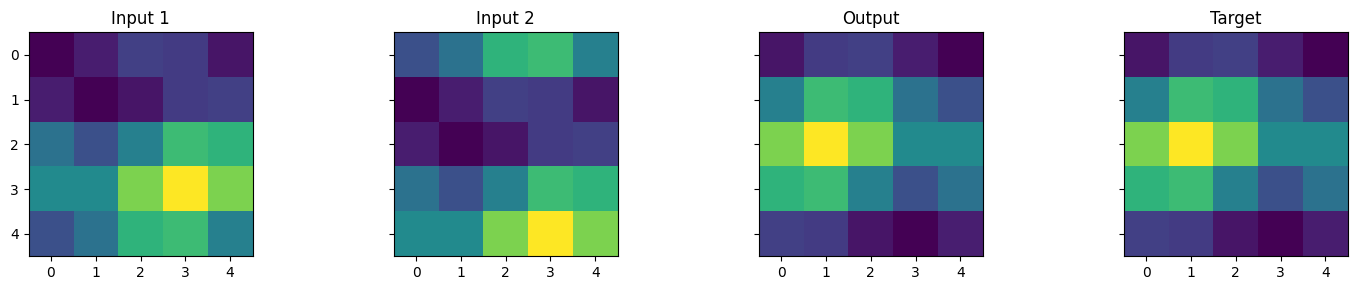

Epoch 45510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45600/50000, Loss: 0.000000


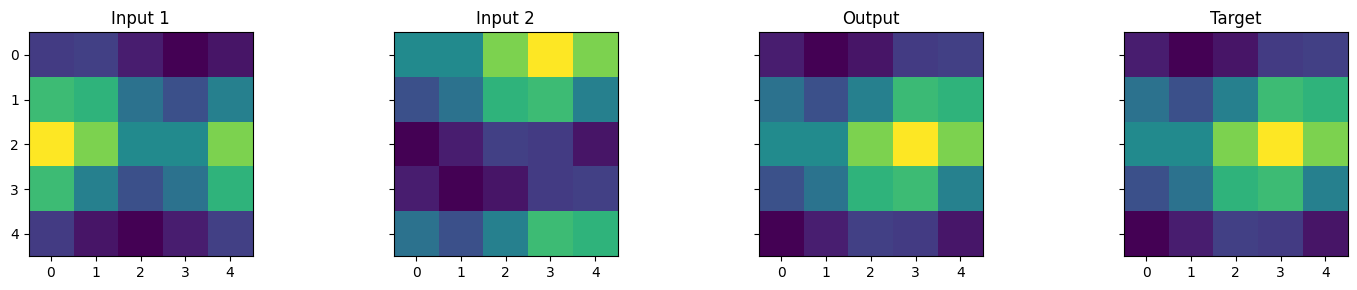

Epoch 45610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45700/50000, Loss: 0.000000


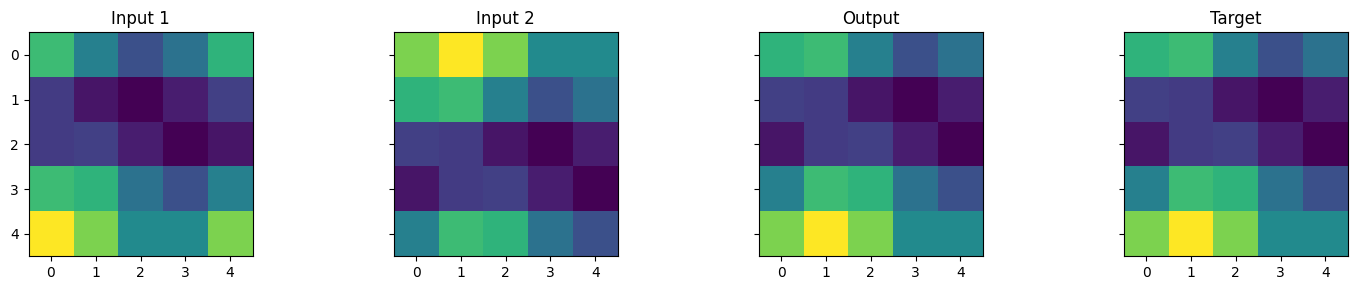

Epoch 45710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45800/50000, Loss: 0.000000


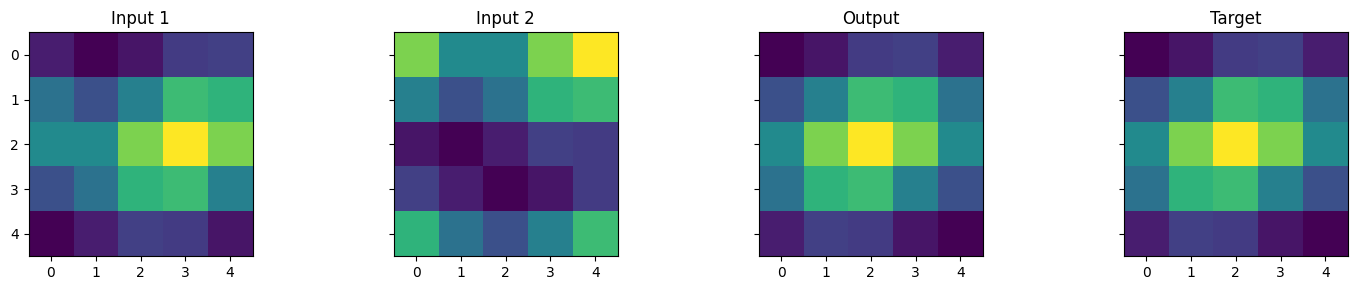

Epoch 45810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45900/50000, Loss: 0.000000


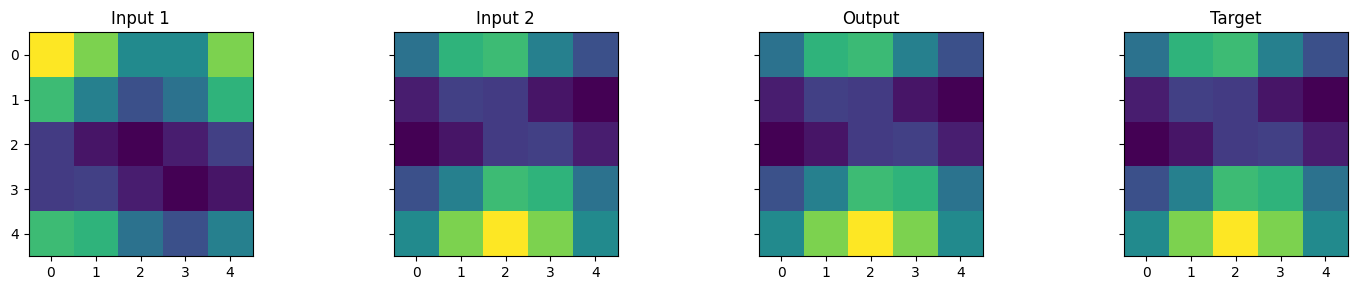

Epoch 45910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 45990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46000/50000, Loss: 0.000000


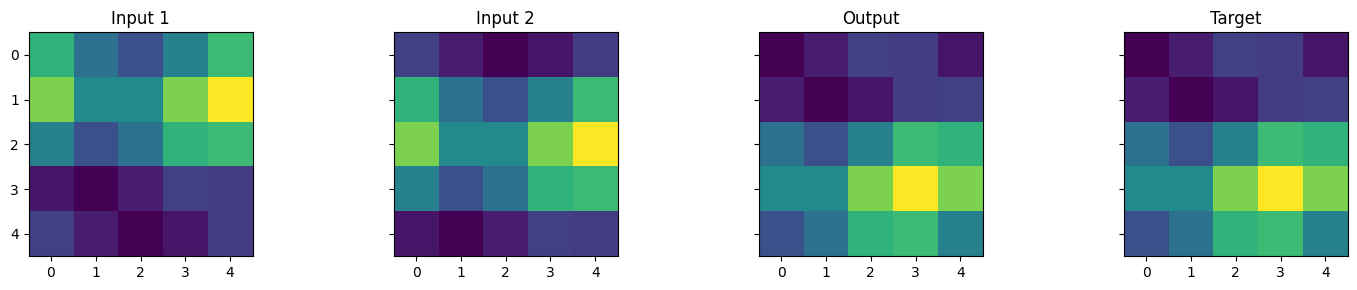

Epoch 46010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46100/50000, Loss: 0.000000


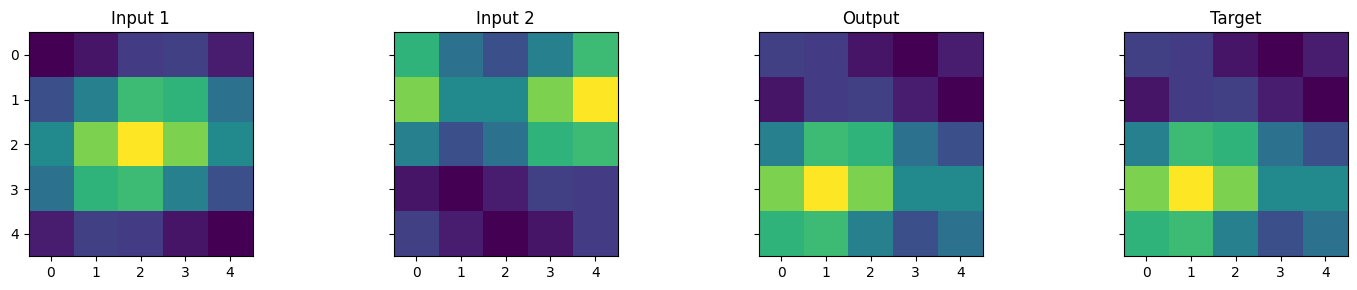

Epoch 46110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46200/50000, Loss: 0.000000


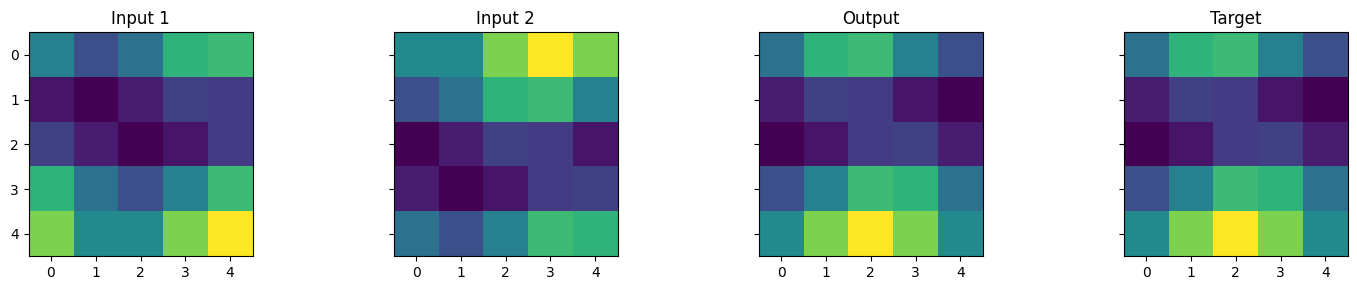

Epoch 46210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46300/50000, Loss: 0.000000


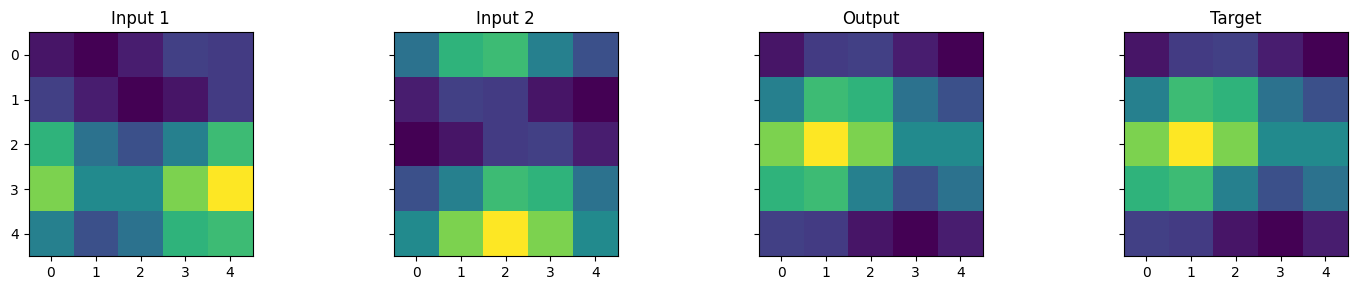

Epoch 46310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46400/50000, Loss: 0.000000


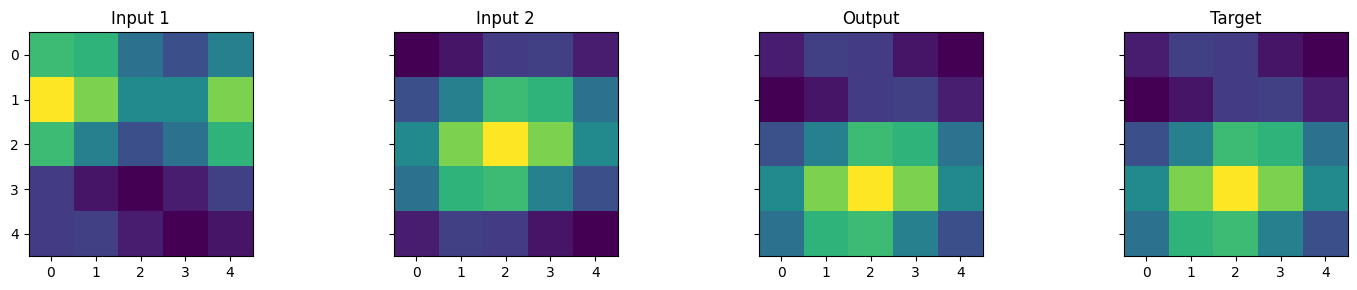

Epoch 46410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46500/50000, Loss: 0.000000


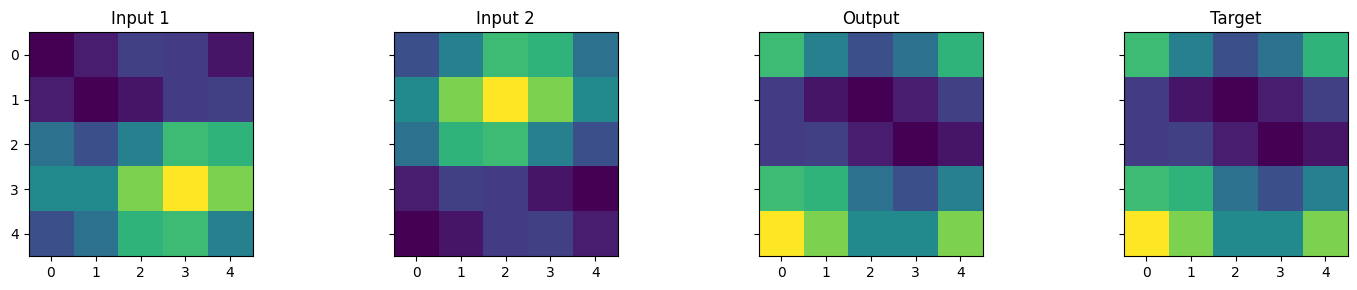

Epoch 46510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46600/50000, Loss: 0.000000


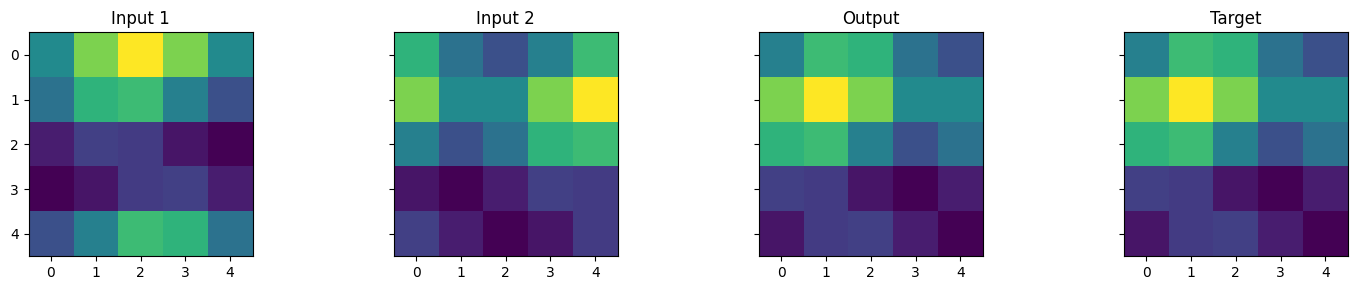

Epoch 46610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46700/50000, Loss: 0.000000


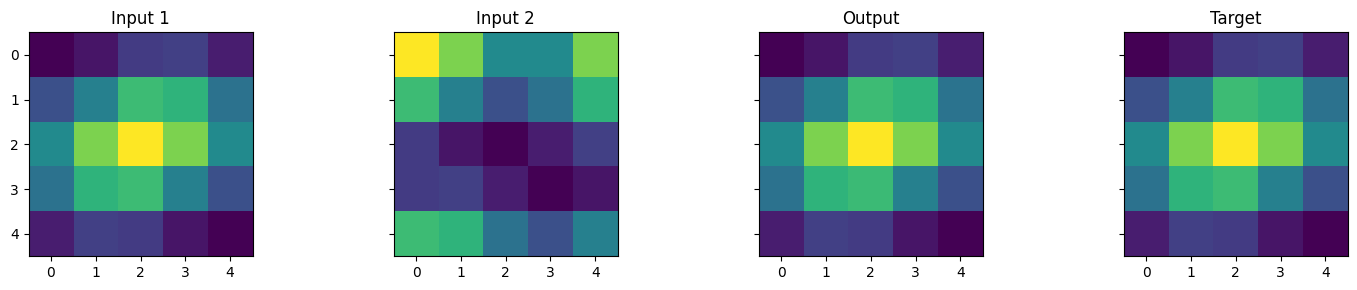

Epoch 46710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46800/50000, Loss: 0.000000


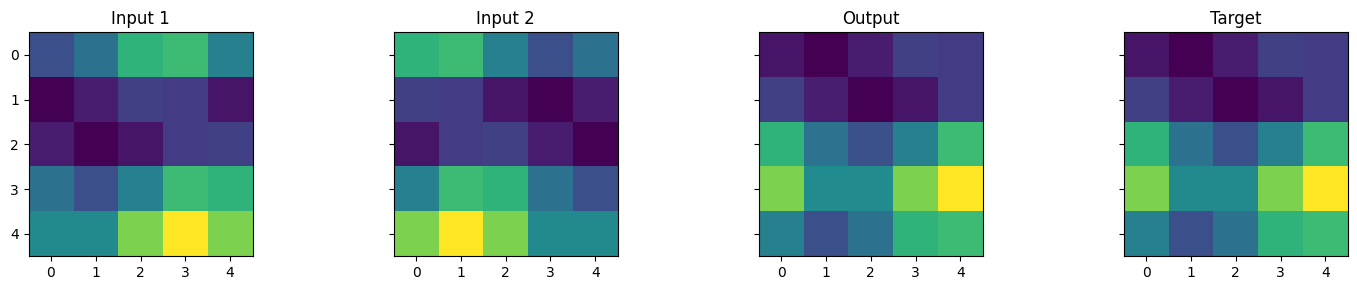

Epoch 46810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46900/50000, Loss: 0.000000


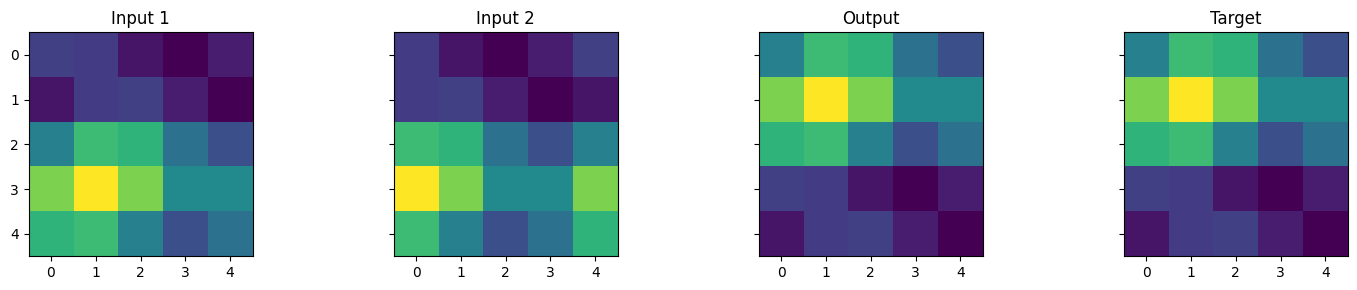

Epoch 46910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 46990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47000/50000, Loss: 0.000000


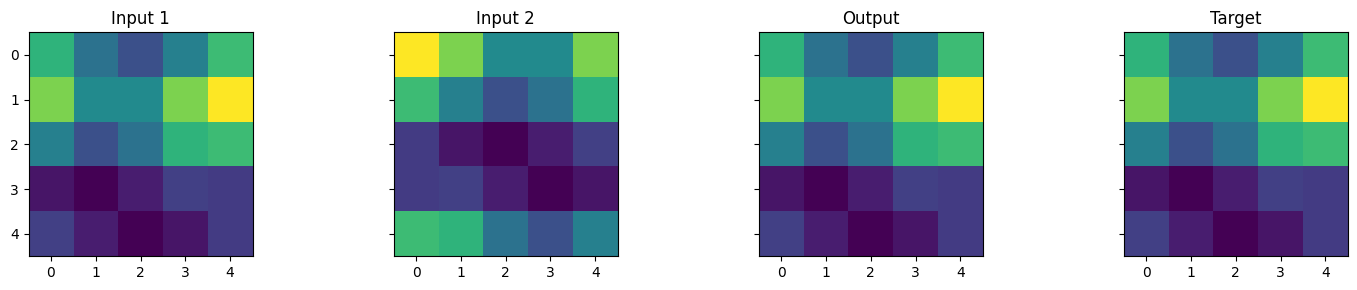

Epoch 47010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47100/50000, Loss: 0.000000


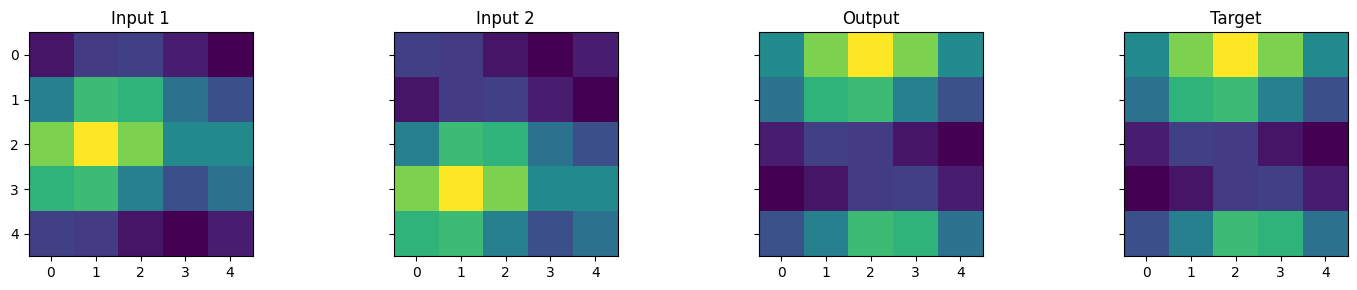

Epoch 47110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47200/50000, Loss: 0.000000


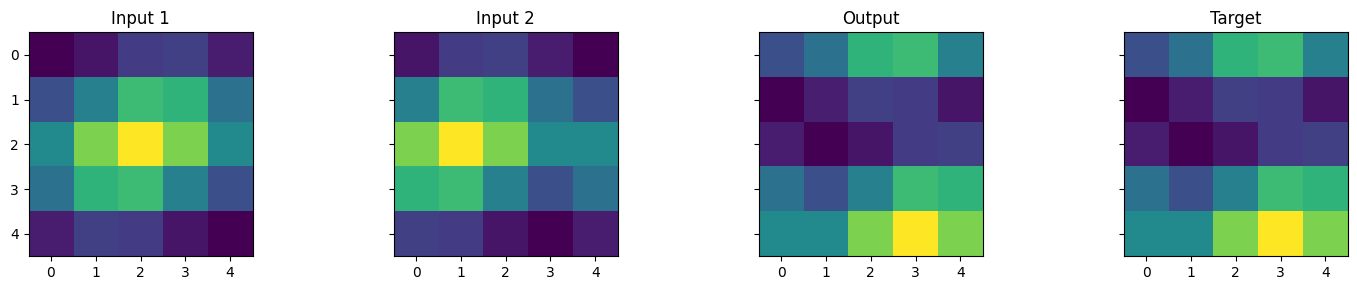

Epoch 47210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47300/50000, Loss: 0.000000


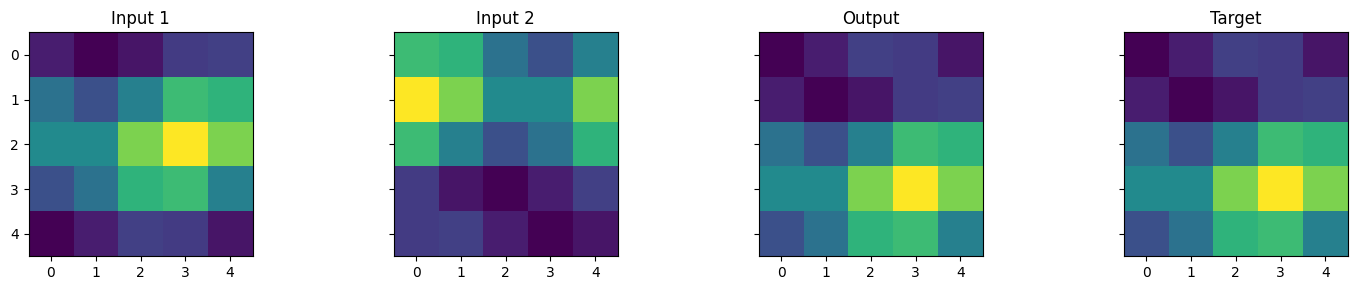

Epoch 47310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47400/50000, Loss: 0.000000


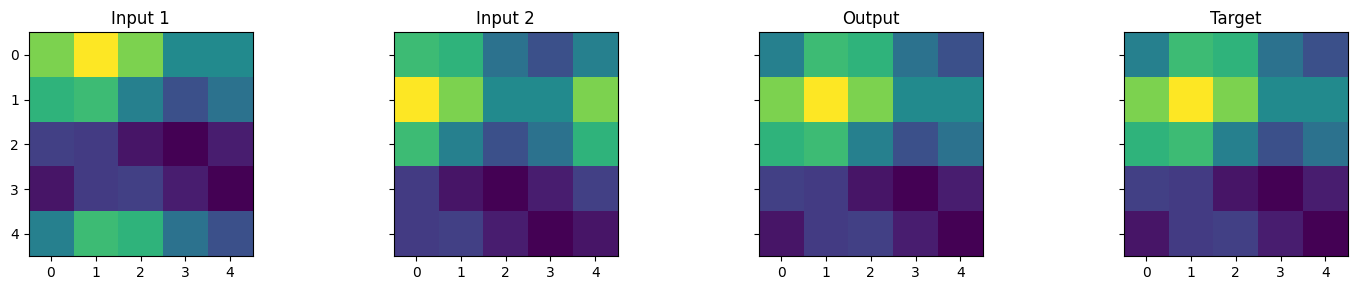

Epoch 47410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47500/50000, Loss: 0.000000


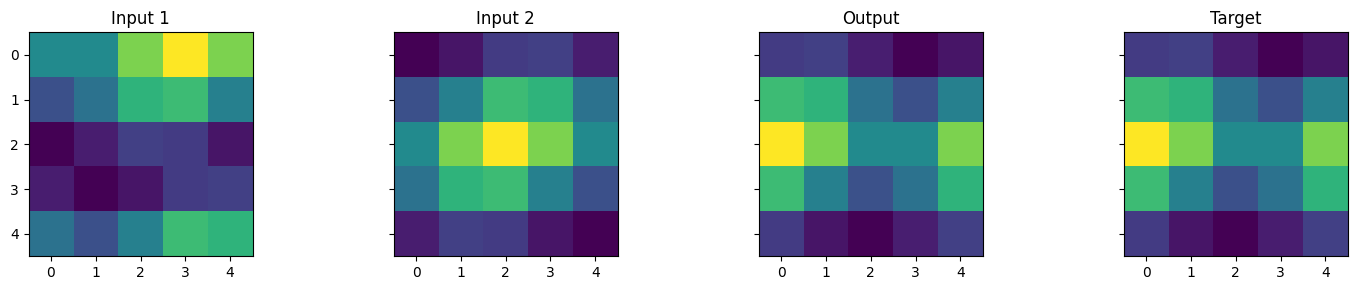

Epoch 47510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47600/50000, Loss: 0.000000


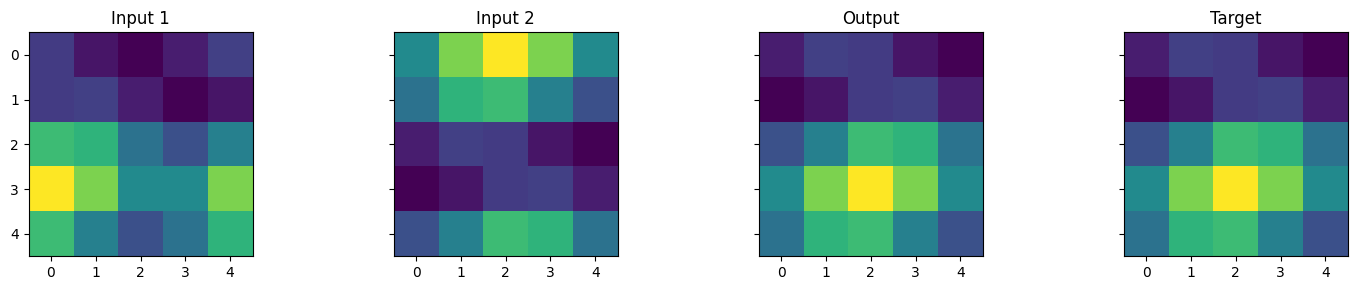

Epoch 47610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47700/50000, Loss: 0.000000


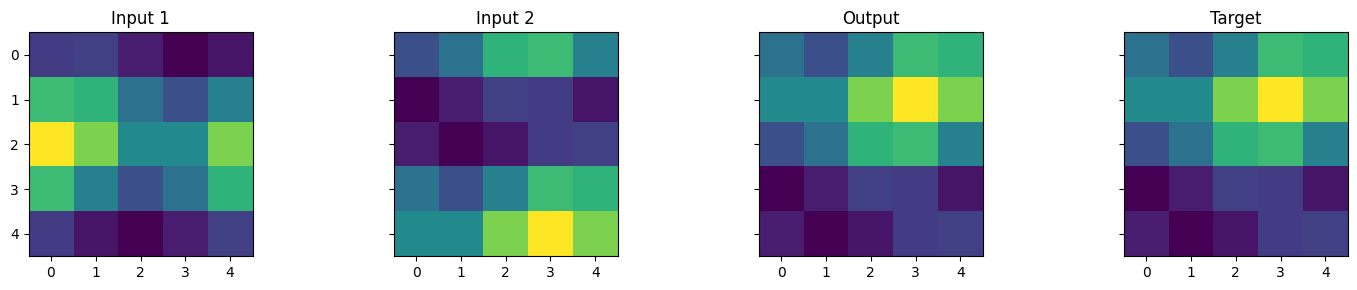

Epoch 47710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47800/50000, Loss: 0.000000


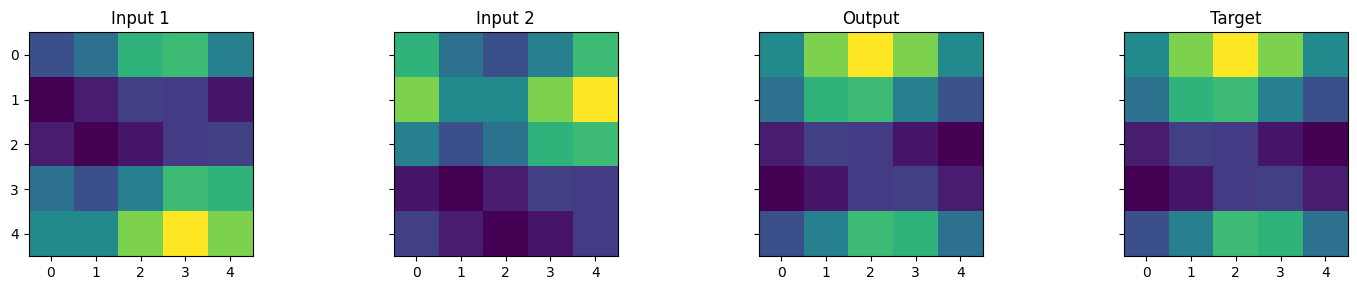

Epoch 47810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47900/50000, Loss: 0.000000


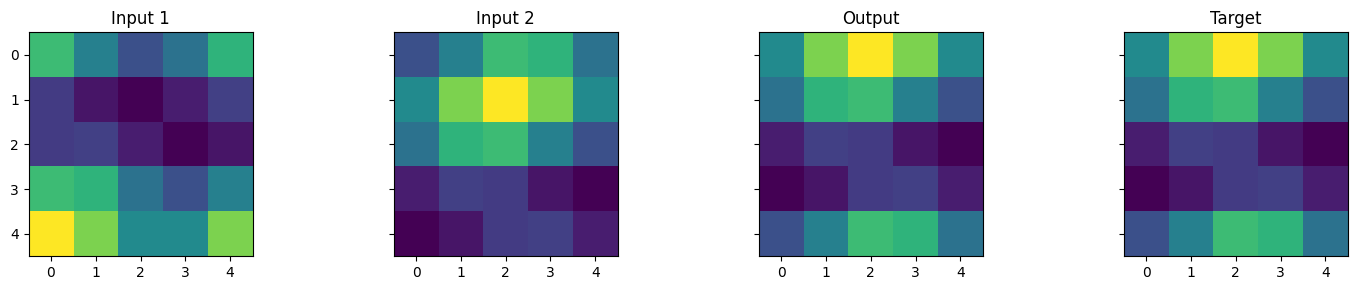

Epoch 47910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 47990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48000/50000, Loss: 0.000000


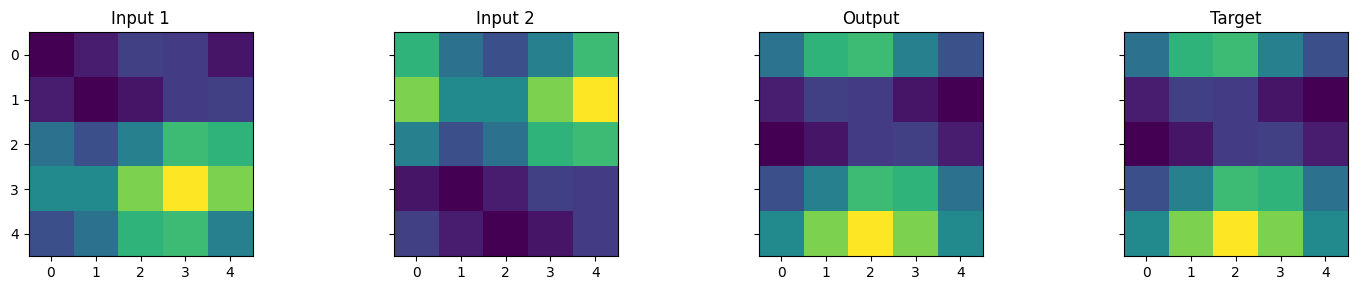

Epoch 48010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48100/50000, Loss: 0.000000


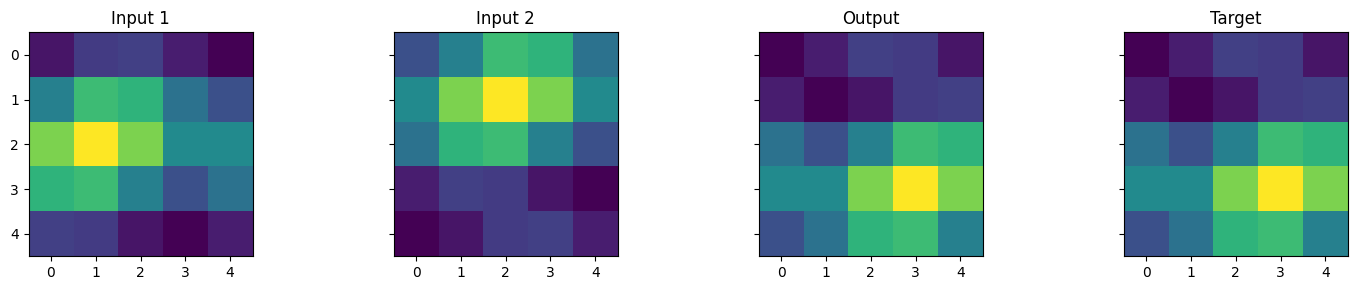

Epoch 48110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48200/50000, Loss: 0.000000


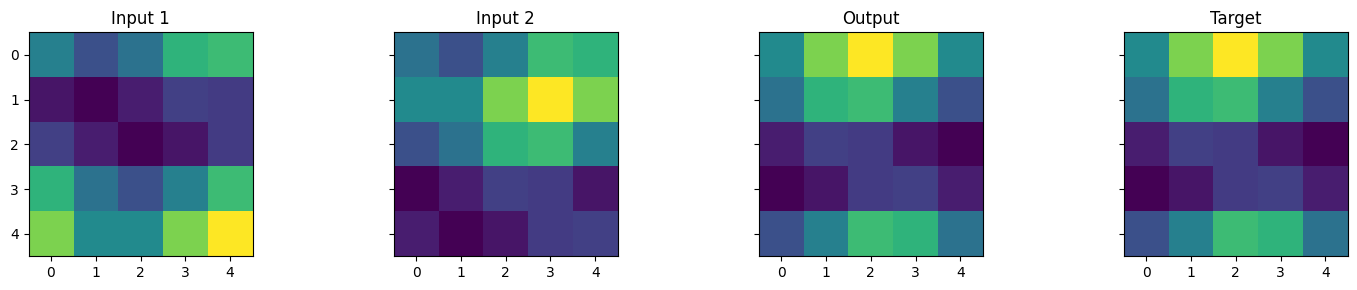

Epoch 48210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48300/50000, Loss: 0.000000


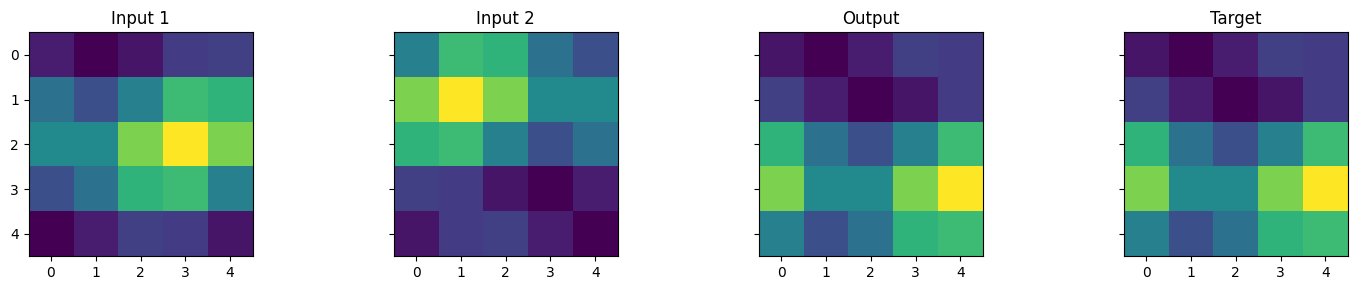

Epoch 48310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48400/50000, Loss: 0.000000


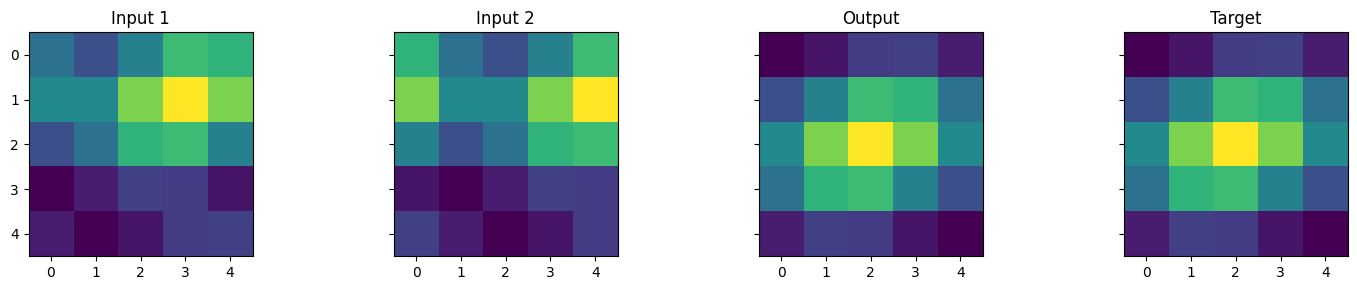

Epoch 48410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48500/50000, Loss: 0.000000


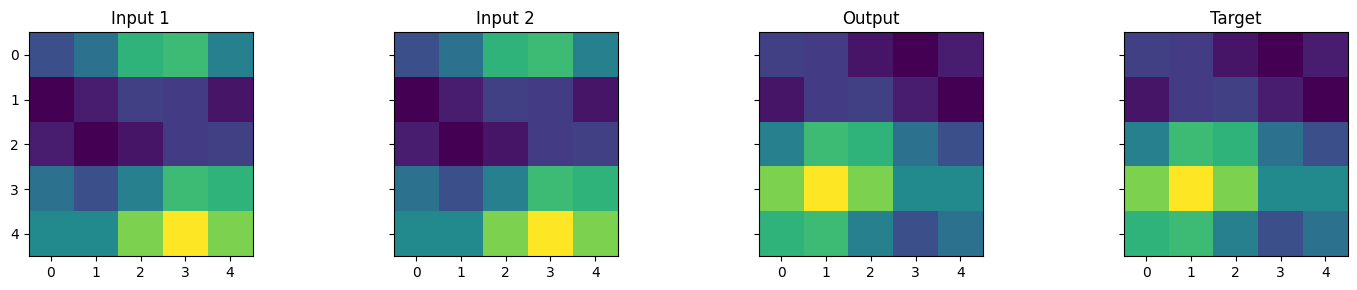

Epoch 48510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48600/50000, Loss: 0.000000


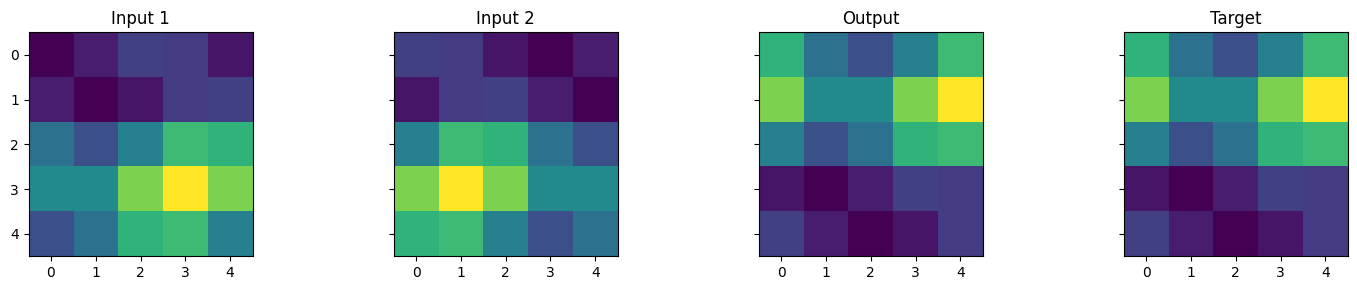

Epoch 48610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48700/50000, Loss: 0.000000


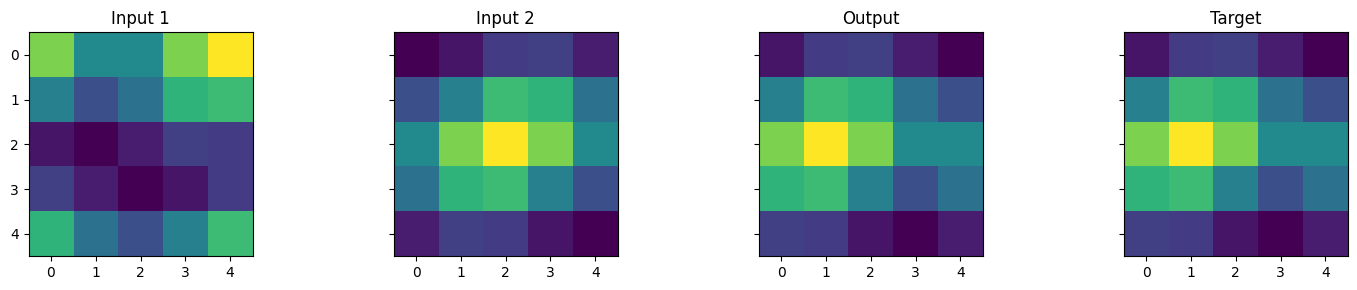

Epoch 48710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48800/50000, Loss: 0.000000


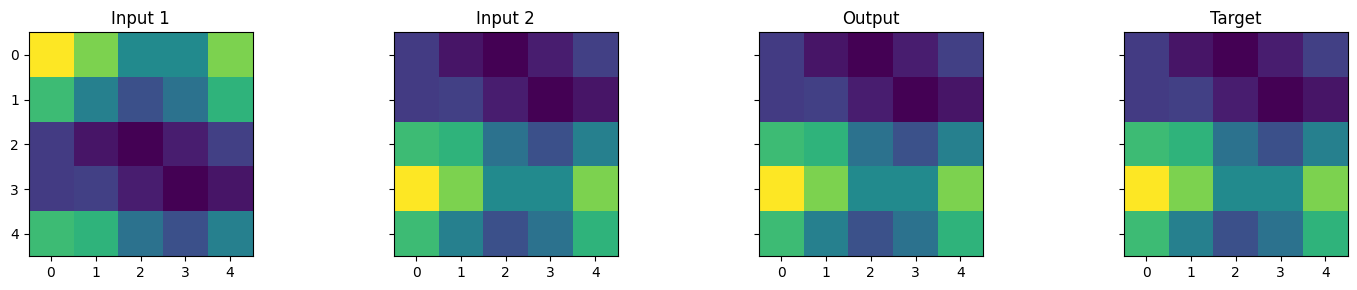

Epoch 48810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48900/50000, Loss: 0.000000


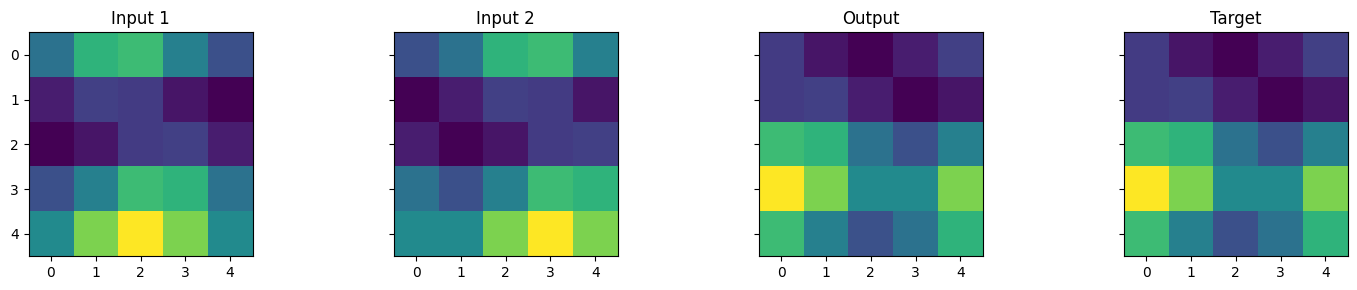

Epoch 48910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 48990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49000/50000, Loss: 0.000000


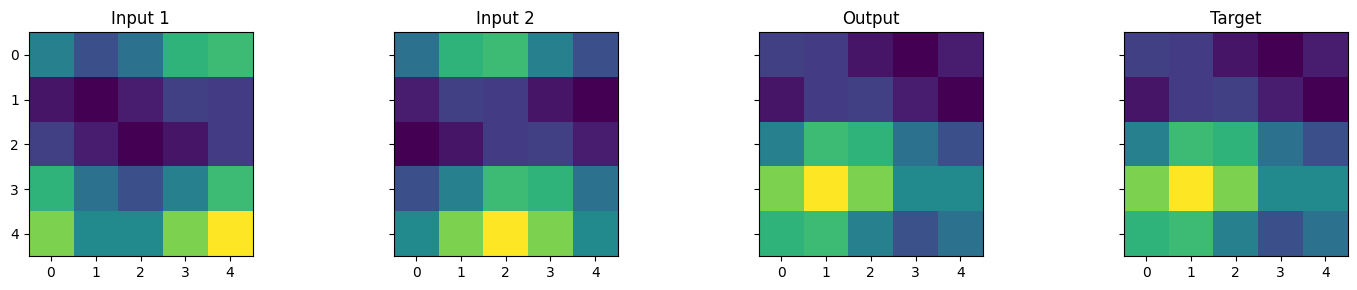

Epoch 49010/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49020/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49030/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49040/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49050/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49060/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49070/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49080/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49090/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49100/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49100/50000, Loss: 0.000000


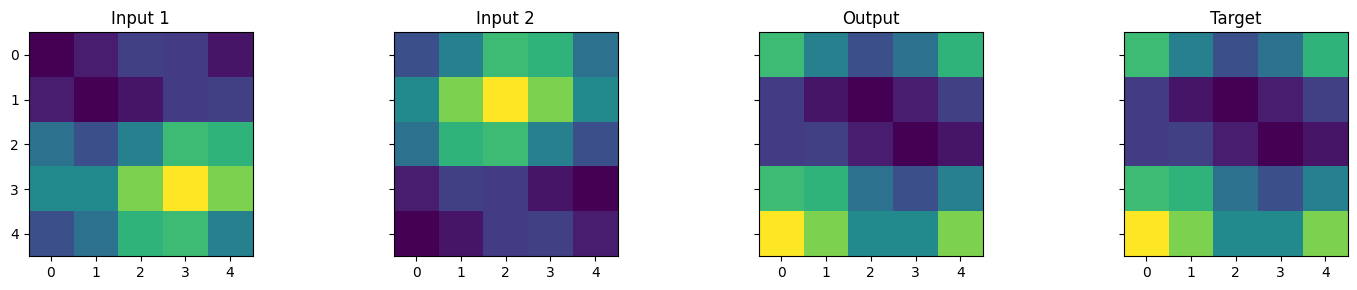

Epoch 49110/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49120/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49130/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49140/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49150/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49160/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49170/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49180/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49190/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49200/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49200/50000, Loss: 0.000000


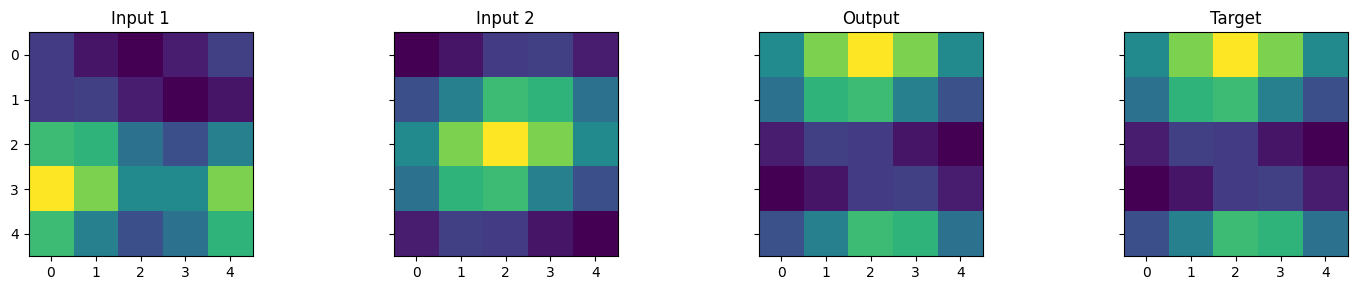

Epoch 49210/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49220/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49230/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49240/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49250/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49260/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49270/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49280/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49290/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49300/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49300/50000, Loss: 0.000000


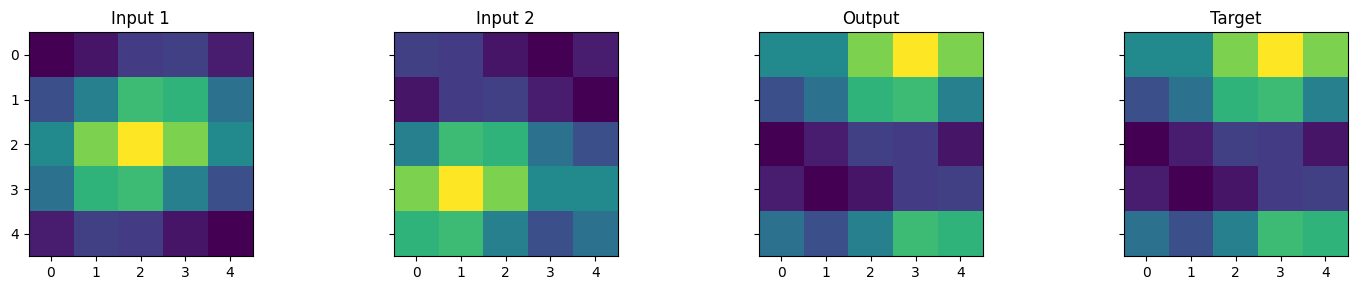

Epoch 49310/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49320/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49330/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49340/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49350/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49360/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49370/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49380/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49390/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49400/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49400/50000, Loss: 0.000000


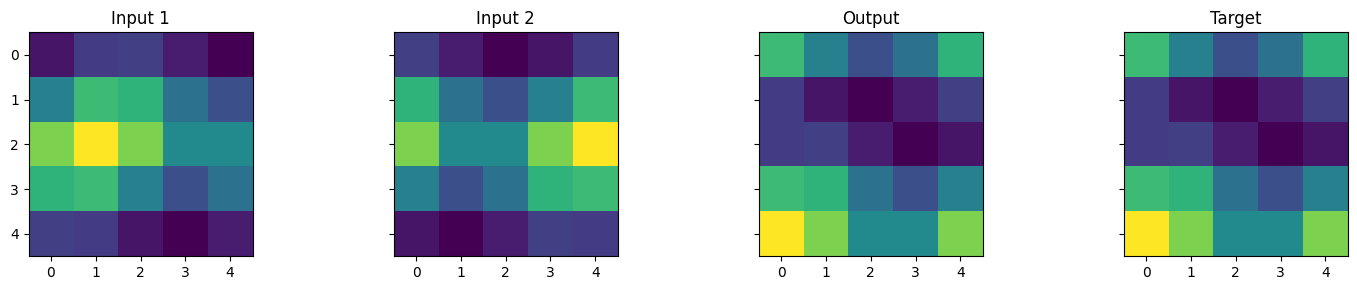

Epoch 49410/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49420/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49430/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49440/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49450/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49460/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49470/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49480/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49490/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49500/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49500/50000, Loss: 0.000000


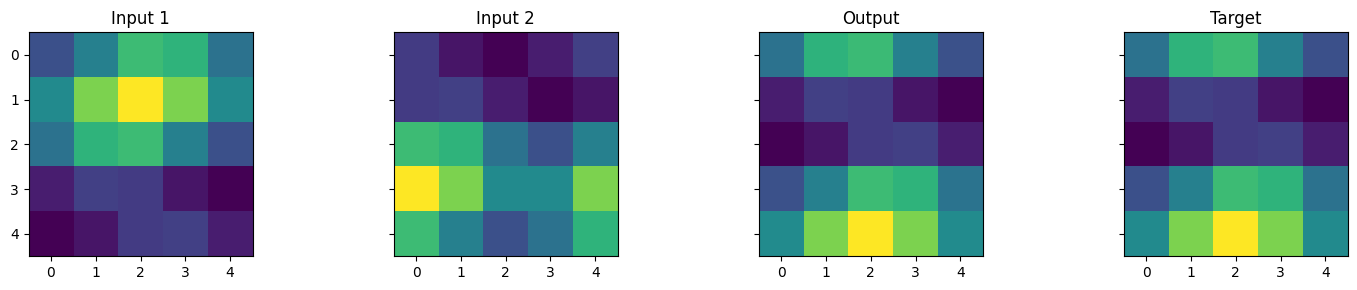

Epoch 49510/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49520/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49530/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49540/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49550/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49560/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49570/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49580/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49590/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49600/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49600/50000, Loss: 0.000000


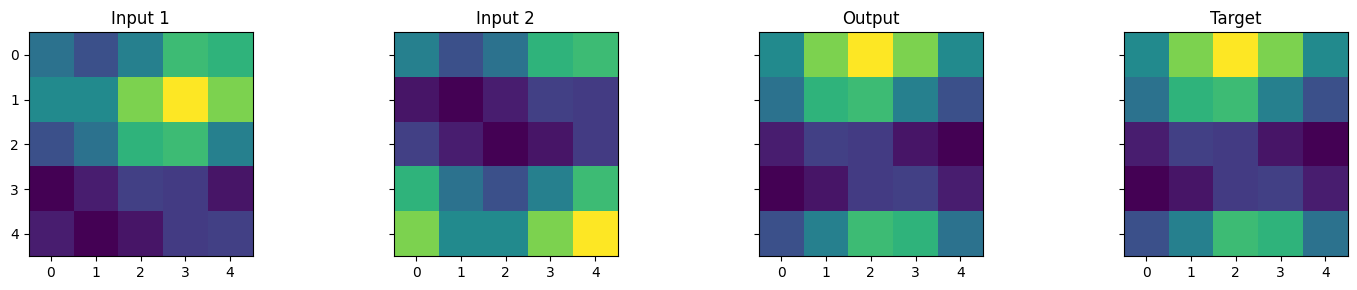

Epoch 49610/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49620/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49630/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49640/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49650/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49660/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49670/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49680/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49690/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49700/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49700/50000, Loss: 0.000000


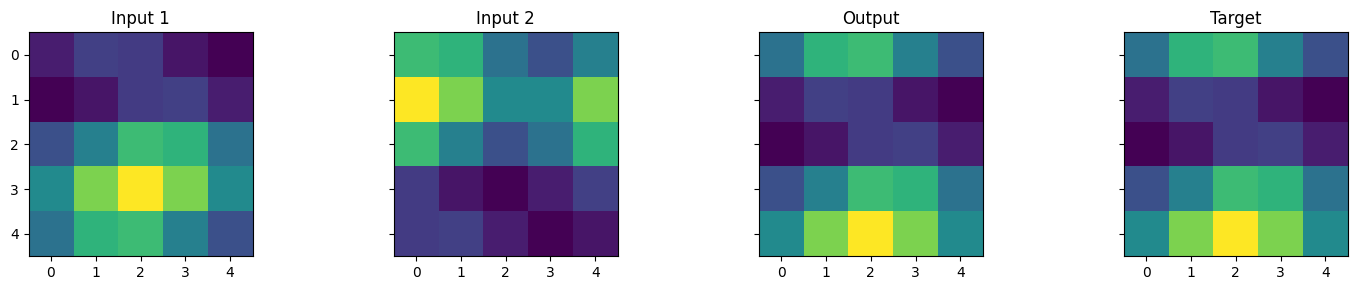

Epoch 49710/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49720/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49730/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49740/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49750/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49760/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49770/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49780/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49790/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49800/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49800/50000, Loss: 0.000000


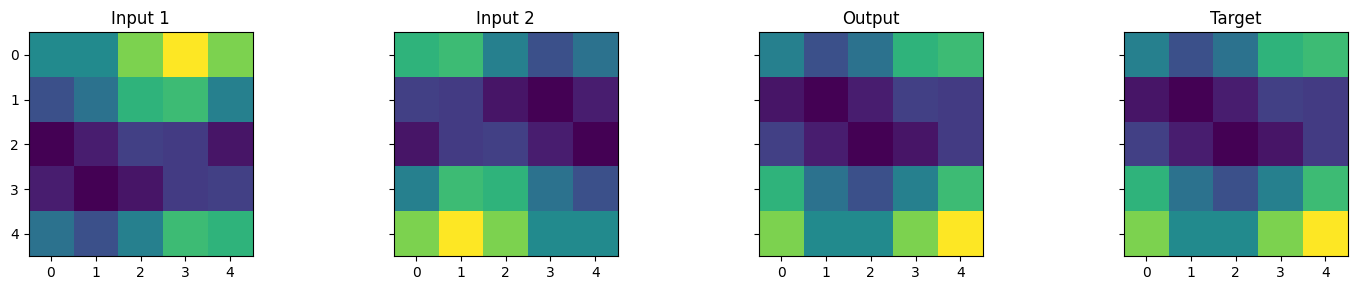

Epoch 49810/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49820/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49830/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49840/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49850/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49860/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49870/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49880/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49890/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49900/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49900/50000, Loss: 0.000000


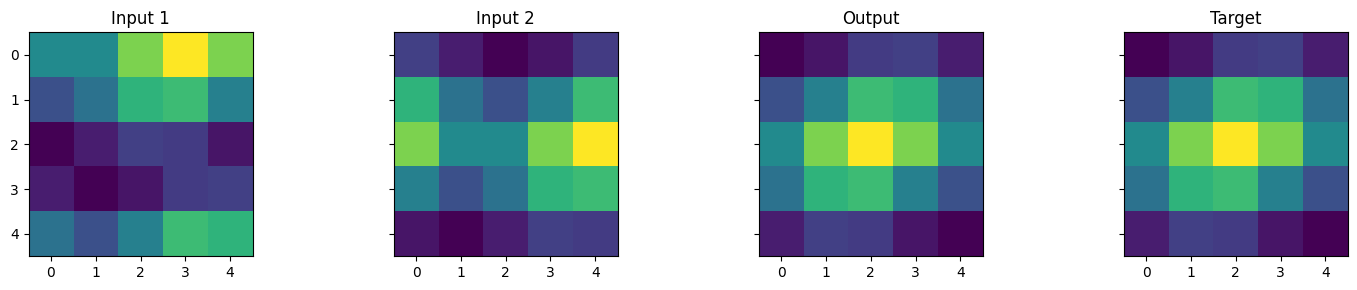

Epoch 49910/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49920/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49930/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49940/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49950/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49960/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49970/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49980/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 49990/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 50000/50000, Loss: 0.0000, Accuracy: 100.00%
Epoch 50000/50000, Loss: 0.000000


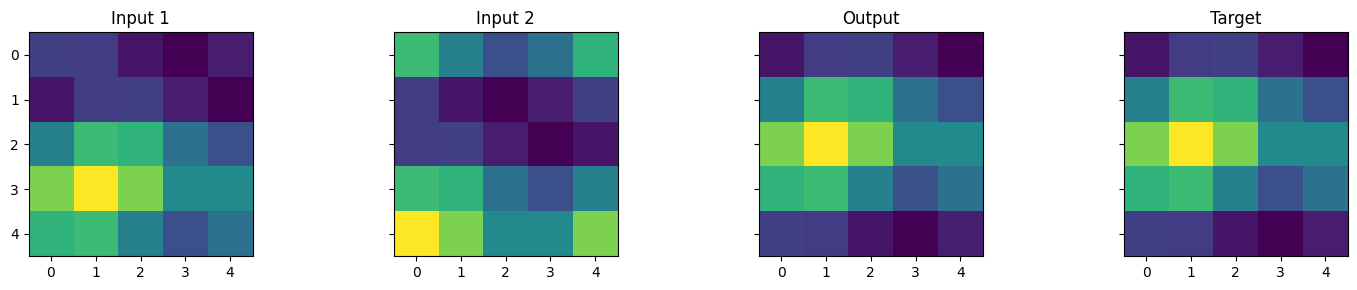

In [9]:
seed = 0#0  # or any integer you like
#random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using GPU

# Initialize model
hidden_size = 6 * 16 
model = TwoLayerNet(p=p, hidden_size=hidden_size, nonlinearity='square', init_scale=1e-2, output_scale=1e0)
model = model.to(device)

# Check if tensors and model are on the correct device (cuda or cpu)
print(f"X_tensor device: {X_tensor.device}")
print(f"Y_tensor device: {Y_tensor.device}")
print(f"Model device: {next(model.parameters()).device}")

# Create loss function
loss = nn.MSELoss()


# Construct optimizer
lr, mom = 0.01, 0.9
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mom) # TODO: try adam optimizer.
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Train the model
epochs = 10000#01
loss_history, accuracy_history, param_history = train(model, dataloader, loss, optimizer, epochs=epochs, verbose_interval=10)

In [10]:
import pickle

with open("training_history.pkl", "wb") as f:
    pickle.dump({
        "loss_history": loss_history,
        "accuracy_history": accuracy_history,
        "param_history": param_history
    }, f)

print("Training history saved to training_history.pkl. You can reload it later with pickle.load(open('training_history.pkl', 'rb')).")



Training history saved to training_history.pkl. You can reload it later with pickle.load(open('training_history.pkl', 'rb')).


## Plot Loss

p: 5
[[1.97215226e-33 8.00000000e-02 4.71852836e-35]
 [3.20000000e-01 3.92000000e-02 5.44653768e-36]
 [2.21867130e-33 8.66668475e-34 7.06577882e-34]
 [0.00000000e+00 1.88741135e-34 1.62266194e-34]
 [0.00000000e+00 3.94430453e-33 4.02600939e-34]]
[ 0.   0.2  0.4 -0.4 -0.2]
[0.  0.2 0.4]


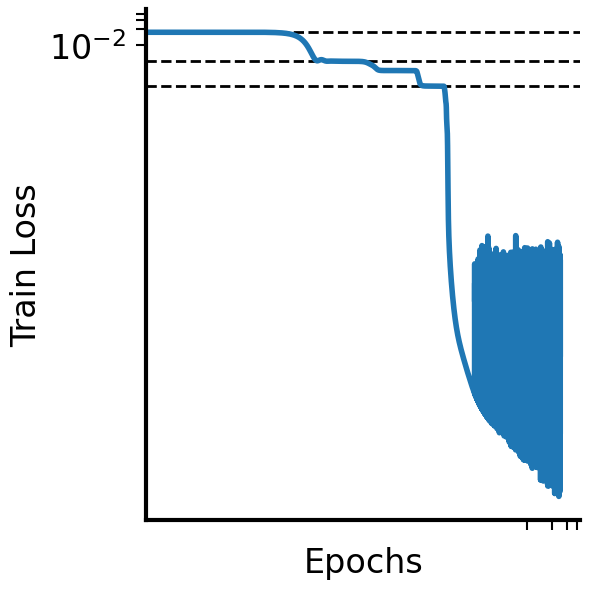

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(list(loss_history), lw=4)


# === Compute power spectrum of template ===
p = int(np.sqrt(len(template)))
print("p:", p)
x_freq, y_freq, power = get_power_2d(template.reshape((p, p)))
print(power)
print(x_freq)
print(y_freq)
power = power.flatten()

valid = power > 1e-20
power = power[valid]
sorted_idx = np.argsort(power)[::-1]  # np.argsort with [::-1] gives descending order
power = power[sorted_idx]

# Plot theoretical lines
alpha_values = [np.sum(power[k:]) for k in range(len(power))]
coef = 1 / (p * p)

# alpha_values = get_alpha_values(template)

for k, alpha in enumerate(alpha_values):
    ax.axhline(y=coef*alpha, color='black', linestyle='--', linewidth=2, zorder=-2)

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_ylim(1e-2, 1e0)

ax.set_xlabel('Epochs', fontsize=24)
ax.set_ylabel('Train Loss', fontsize=24)

style_axes(ax)
plt.grid(False)
plt.tight_layout()
plt.savefig("loss-without-lines.pdf", bbox_inches="tight")
plt.show()

## Power Spectrum of output

p = 5
[ 0.   0.2  0.4 -0.4 -0.2]
[0.  0.2 0.4]
[[ 0.   0. ]
 [ 0.   0.2]
 [ 0.   0.4]
 [ 0.2  0. ]
 [ 0.2  0.2]
 [ 0.2  0.4]
 [ 0.4  0. ]
 [ 0.4  0.2]
 [ 0.4  0.4]
 [-0.4  0. ]
 [-0.4  0.2]
 [-0.4  0.4]
 [-0.2  0. ]
 [-0.2  0.2]
 [-0.2  0.4]]
[-0.2  0. ]
[[0.2 0. ]
 [0.  0.2]
 [0.2 0.2]]
Powers shape: (625, 5, 3)
Powers reshaped: (625, 15)
Powers shape: (625, 5, 3)
Powers reshaped: (625, 15)
Powers shape: (625, 5, 3)
Powers reshaped: (625, 15)
Powers shape: (625, 5, 3)
Powers reshaped: (625, 15)
Powers shape: (625, 5, 3)
Powers reshaped: (625, 15)
Powers shape: (625, 5, 3)
Powers reshaped: (625, 15)
Powers shape: (625, 5, 3)
Powers reshaped: (625, 15)
Powers shape: (625, 5, 3)
Powers reshaped: (625, 15)
Powers shape: (625, 5, 3)
Powers reshaped: (625, 15)
Powers shape: (625, 5, 3)
Powers reshaped: (625, 15)
Powers shape: (625, 5, 3)
Powers reshaped: (625, 15)
Powers shape: (625, 5, 3)
Powers reshaped: (625, 15)
Powers shape: (625, 5, 3)
Powers reshaped: (625, 15)
Powers shape: (625, 5,

/tmp/ipykernel_1169237/3663753721.py:112: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


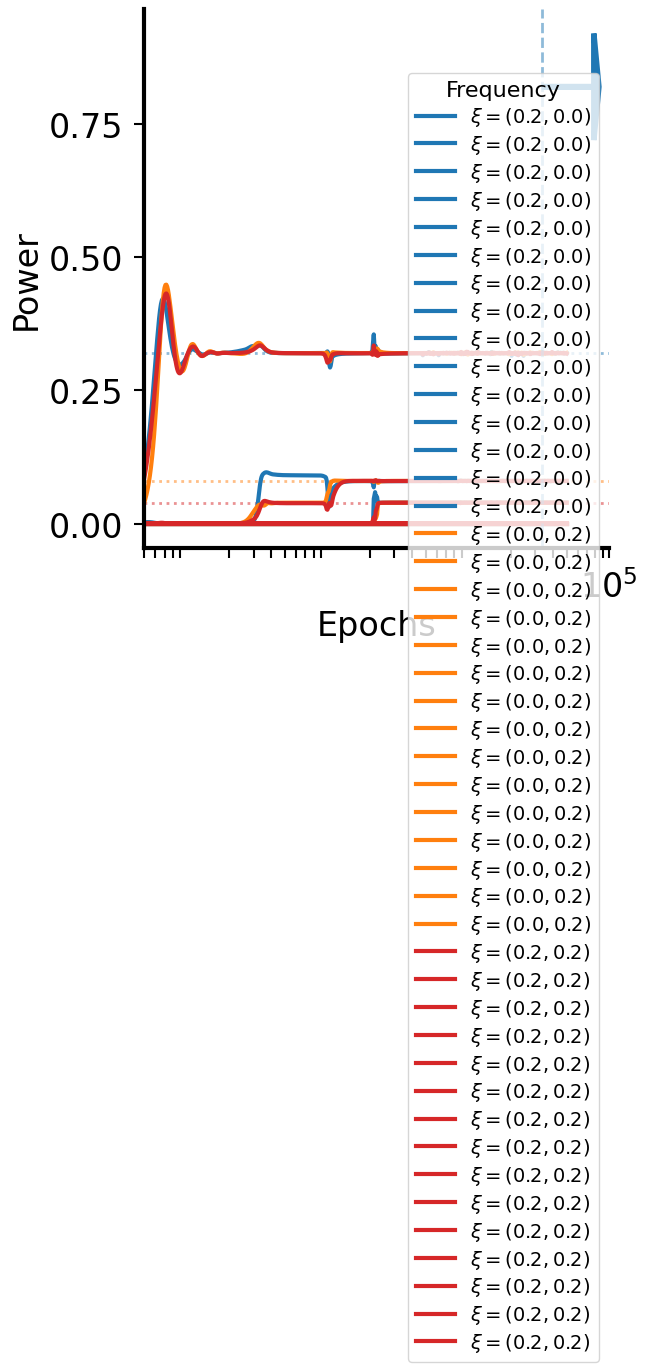

In [31]:
# === SETTINGS ===
print("p =", p)
pxp = p * p
num_freqs = pxp // 2 + 1

# Compute template power spectrum (flattened 2D)
template_2d = template.reshape((p, p))
template_ft_2d = np.fft.rfft2(template_2d)
# template_power_2d = np.abs(template_ft_2d).flatten()[:num_freqs]

# === Compute power spectrum of template ===
freqs_u, freqs_v, power_og = get_power_2d(template_2d)
print(freqs_u)
print(freqs_v)
freq = np.array([(u, v) for u in freqs_u for v in freqs_v])
print(freq)
print(freq[12])
power_og = power_og.flatten()
valid = power_og > 1e-20
freq, power = freq[valid], power_og[valid]
sorted_idx = np.argsort(-power)
freq, power = freq[sorted_idx], power[sorted_idx]
print(freq)

# === Theory lines ===
alpha_values = [np.sum(power[k:]) for k in range(len(power))]
coef = 1 / p
theta0 = np.sqrt(2) * model.init_scale
uMax = [np.sqrt(2 * p / 27) * (p * power[k] / 2)**(3/2) / p**2 for k in range(len(power))]
tau_values = [(1 / theta0 - 1) / (3 * uMax[k]) for k in range(len(uMax))]
step_size = 2 * coef * lr / (1 - mom)

# Color settings
cmap = plt.colormaps.get_cmap('tab20').resampled(num_freqs)
manual_colors = {
    0: 'tab:blue',
    1: 'tab:orange',
    2: 'tab:red',
    3: 'tab:green',
    4: 'tab:brown',
    5: 'tab:purple',
}
colors = [manual_colors.get(i, cmap(i)) for i in range(num_freqs)]

# Compute output power over time (GD)
num_points = 1000
steps = np.unique(np.logspace(0, np.log10(len(param_history) - 1), num_points, dtype=int))
powers_over_time = np.zeros([len(steps), len(X_tensor), len(power_og)])  # shape: (steps, num_freqs)

for i_step, step in enumerate(steps):
    model.load_state_dict(param_history[step])
    
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        # Compute 2D FFT for each output, then flatten and take rfft2
        outputs_2d = outputs.detach().cpu().numpy().reshape(-1, p, p)
        powers = np.array([get_power_2d(out, no_freq=True) for out in outputs_2d])
        print("Powers shape:", powers.shape)  # Should be (num_samples, p, p//2 + 1)
        # Don't flatten the batch dim; keep as (num_samples, p, p//2 + 1)
        powers = powers.reshape(outputs_2d.shape[0], -1)
        print("Powers reshaped:", powers.shape)  # Should be (num_samples, num_freqs)
        powers_over_time[i_step, :, :] = powers

powers_over_time = np.array(powers_over_time)  # shape: (steps, num_freqs)
print("Powers over time shape:", powers_over_time.shape)

# === PLOTTING ===
fig, ax = plt.subplots(figsize=(6, 7))

# Identify the indices of the top 5 frequencies in the template's power spectrum
top_k = 5
top_freq_indices = np.argsort(power)[-top_k:][::-1]  # descending order
print("Top frequency indices:", top_freq_indices)

# For labeling, get the (u, v) frequency pairs for these indices
# freq is an array of shape (num_freqs, 2)
top_freq_labels = [fr"$\xi = ({freq[k][0]}, {freq[k][1]})$" for k in top_freq_indices]

for i, k in enumerate(top_freq_indices):
    color = colors[i] if i < len(colors) else colors[0]
    label = top_freq_labels[i]
    ax.plot(steps, powers_over_time[:, k], color=color, lw=3, label=label)
    ax.axhline(power[k], color=color, linestyle='dotted', linewidth=2, alpha=0.5, zorder=-10)

for i, k in enumerate(top_freq_indices):
    color = colors[i] if i < len(colors) else colors[0]
    tau = tau_values[k]
    x = tau / step_size
    y = power[k]
    ax.axvline(x=x, color=color, linestyle='dashed', linewidth=2, alpha=0.5)
    # Add arrow at intersection
    ax.arrow(1.04 * x, y + 0.5, 1.5 * x, 0, 
             head_width=0.2, head_length=x*0.2, length_includes_head=True,
             fc=color, ec=color, lw=4)

# # Add vertical lines if needed
# for step in time_steps:
#     ax.axvline(x=step, color='gray', alpha=0.5, linestyle='solid', linewidth=2)

# Labeling and formatting
ax.set_xscale('log')
ax.set_xlim(5e1, len(param_history) - 1)
ax.set_xticks([1000, 10000, 100000, len(param_history) - 1])
ax.set_xticklabels(['$10^3$', '$10^4$', '$10^5$', 'Final'])
ax.set_ylabel("Power", fontsize=24)
ax.set_xlabel("Epochs", fontsize=24)
ax.legend(fontsize=14, title="Frequency", title_fontsize=16, loc='upper right', bbox_to_anchor=(1, 0.9), labelspacing=0.25)

style_axes(ax)
ax.grid(False)
plt.tight_layout()
plt.savefig("fourier_power_only.pdf", bbox_inches="tight")
plt.show()

## Plot outputs
TODO: un-flatten predicted signals. First column is ground truth, second column is predicted signal, third column is MSE between them.

In [ ]:
import matplotlib.pyplot as plt

# Choose time steps to visualize
steps_to_show = [1000, 10000, 100000, epochs-1]
num_samples = 1  # how many examples to plot per row

# For 2D: p is the side length, output is flattened p*p
p = int(np.sqrt(Y_tensor.shape[1]))
x = np.arange(p)

fig, axes = plt.subplots(len(steps_to_show), num_samples * 3, figsize=(9, 6), sharex=False)

if len(axes.shape) == 1:
    axes = axes[None, :]  # ensure axes is 2D

for row, step in enumerate(steps_to_show):
    # Load weights at this step
    model.load_state_dict(param_history[step])
    model.eval()

    indices = np.random.choice(len(Y_tensor), size=num_samples, replace=False)
    with torch.no_grad():
        preds = model(X_tensor[indices]).detach().cpu().numpy()
        truths = Y_tensor[indices].detach().cpu().numpy()

    for i, idx in enumerate(indices):
        a = idx // p
        b = idx % p

        # Unflatten for 2D
        truth_2d = truths[i].reshape(p, p)
        pred_2d = preds[i].reshape(p, p)
        mse_2d = (truth_2d - pred_2d) ** 2

        # Plot ground truth
        ax_true = axes[row, i*3 + 0]
        im0 = ax_true.imshow(truth_2d, cmap='viridis', vmin=truth_2d.min(), vmax=truth_2d.max())
        ax_true.set_title("Ground Truth", fontsize=10)
        plt.colorbar(im0, ax=ax_true, fraction=0.046, pad=0.04)
        ax_true.set_xticks([])
        ax_true.set_yticks([])

        # Plot prediction
        ax_pred = axes[row, i*3 + 1]
        im1 = ax_pred.imshow(pred_2d, cmap='viridis', vmin=truth_2d.min(), vmax=truth_2d.max())
        ax_pred.set_title("Prediction", fontsize=10)
        plt.colorbar(im1, ax=ax_pred, fraction=0.046, pad=0.04)
        ax_pred.set_xticks([])
        ax_pred.set_yticks([])

        # Plot MSE
        ax_mse = axes[row, i*3 + 2]
        im2 = ax_mse.imshow(mse_2d, cmap='Reds')
        ax_mse.set_title("MSE", fontsize=10)
        plt.colorbar(im2, ax=ax_mse, fraction=0.046, pad=0.04)
        ax_mse.set_xticks([])
        ax_mse.set_yticks([])

        # Only leftmost column gets ylabel
        ax_true.set_ylabel(fr"$t = 10^{{{int(np.log10(step))}}}$", fontsize=14)

        # Optionally, annotate with a, b
        for ax in [ax_true, ax_pred, ax_mse]:
            ax.set_xlabel(fr"$a = {a},\ b = {b}$", fontsize=8)

plt.tight_layout()
plt.savefig("predictions_2d.pdf", bbox_inches='tight')

NameError: name 'epochs' is not defined

## Plot Weights
TODO: un-flatten the weights, frequencies and phases can stay in vector I think.

/var/folders/4g/shvz3x5d6rx38cxrtg_wmtw80000gn/T/ipykernel_46920/4254458089.py:113: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("W-weights.pdf", bbox_inches='tight')
/var/folders/4g/shvz3x5d6rx38cxrtg_wmtw80000gn/T/ipykernel_46920/4254458089.py:113: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("W-weights.pdf", bbox_inches='tight')
/Users/danielkunin/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


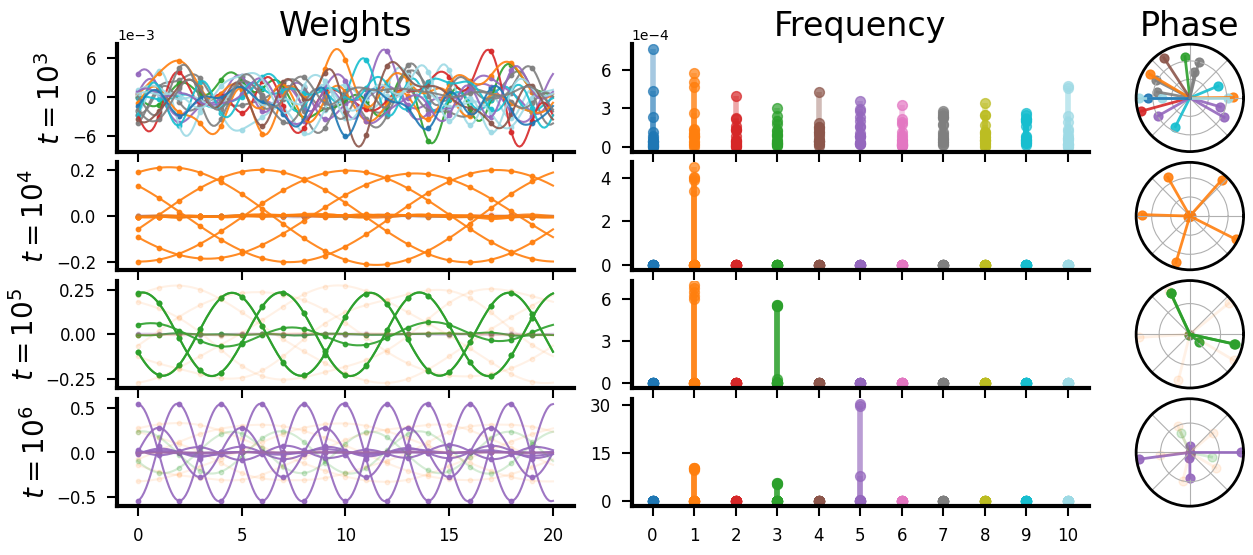

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

# Steps and corresponding highlighted frequencies

steps = [1000, 10000, 100000, epochs-1]
highlight_freqs_list = [[], [1], [3], [5]]

num_rows, num_cols = len(steps), 3

# Use gridspec to control layout
fig = plt.figure(figsize=(24, 6), constrained_layout=True)
gs = gridspec.GridSpec(num_rows, num_cols, width_ratios=[1.1, 1.1, 2.0], wspace=0.1, hspace=0.1)
axes = np.empty((num_rows, num_cols), dtype=object)

# Create axes
for row in range(num_rows):
    for col in range(num_cols):
        if col == 2:
            ax = fig.add_subplot(gs[row, col], projection='polar')
        else:
            ax = fig.add_subplot(gs[row, col])  # ⬅ no sharex anymore
        axes[row, col] = ax

num_freqs = None
for row, index in enumerate(steps):
    highlight_freqs = highlight_freqs_list[row]
    params = param_history[index]
    W = params['W'].numpy()
    h, p = W.shape

    if num_freqs is None:
        num_freqs = p // 2 + 1
        cmap = plt.colormaps.get_cmap('tab20').resampled(num_freqs)
        colors = [cmap(i) for i in range(num_freqs)]
        manual_colors = {
            0: 'tab:blue',
            1: 'tab:orange',
            2: 'tab:red',
            3: 'tab:green',
            4: 'tab:brown',
            5: 'tab:purple',
        }
        freq_colors = [manual_colors.get(i, cmap(i)) for i in range(num_freqs)]


    # === Column 1: Weights ===
    ax = axes[row, 0]
    for i in range(h):
        w = W[i, :]
        ft = np.fft.rfft(w)
        power = np.abs(ft)**2
        dom_idx = np.argmax(power)
        color = freq_colors[dom_idx]
        alpha = 0.9 if not highlight_freqs or dom_idx in highlight_freqs else 0.1
        x = np.linspace(0, p - 1, 500)
        plot2D(ax, w, color=color, continuous=True, alpha=alpha)
        # ax.scatter(np.arange(p), w, color=color, s=10, alpha=alpha)
    if row == 0: ax.set_title("Weights", fontsize=24)
    ax.set_ylabel(fr"$t = 10^{{{int(np.log10(index))}}}$", fontsize=20)
    style_axes(ax, numyticks=3, numxticks=5, labelsize=12)
    ax.grid(False)
    if row < num_rows - 1:
        ax.tick_params(labelbottom=False)

    # === Column 2: Frequency Spectrum ===
    ax = axes[row, 1]
    for i in range(h):
        w = W[i, :]
        ft = np.fft.rfft(w)
        power = np.abs(ft)**2
        for k in range(len(power)):
            color = freq_colors[k]
            ax.vlines(k, 0, power[k], linewidth=4, color=color, alpha=0.4)
            ax.scatter(k, power[k], color=color, s=50, alpha=0.7)
    # ax.axhline(0, color='gray', linewidth=1, linestyle='--', alpha=0.4)
    ax.set_xlim(-0.5, len(power) - 0.5)
    ax.set_xticks(np.arange(len(power)))
    if row == 0: ax.set_title("Frequency", fontsize=24)
    style_axes(ax, numyticks=3, numxticks=11, labelsize=12)
    ax.grid(False)
    if row < num_rows - 1:
        ax.tick_params(labelbottom=False)

    # === Column 3: Phase Polar Plot ===
    ax = axes[row, 2]
    for i in range(h):
        w = W[i, :]
        ft = np.fft.rfft(w)
        power = np.abs(ft)**2
        dom_idx = np.argmax(power)
        phase = np.angle(ft[dom_idx])
        norm = np.linalg.norm(w)
        color = freq_colors[dom_idx]
        alpha = 0.9 if not highlight_freqs or dom_idx in highlight_freqs else 0.1
        ax.plot([phase, phase], [0, norm], color=color, linewidth=2, alpha=alpha)
        ax.scatter(phase, norm, color=color, s=40, alpha=alpha)
        angles = np.arange(0, 360, 45)
        # ax.set_thetagrids(angles, [f"{a}°" if a in [45,135,225,315] else "" for a in angles])
        ax.set_thetagrids(angles, ["" for a in angles])
        ax.set_yticklabels([])
        ax.spines['polar'].set_linewidth(2)
    if row == 0: ax.set_title("Phase", fontsize=24)

# Shift polar plots left to reduce whitespace
for row in range(num_rows):
    ax = axes[row, 2]
    pos = ax.get_position()
    ax.set_position([pos.x0 - 0.155, pos.y0, pos.width, pos.height])

plt.savefig("W-weights.pdf", bbox_inches='tight')